# Lecture 21: AutoEncoders

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1DnAtRC5udV52Kn5918nlvvLIjkzQKNPT)

In [1]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2024-01-10 00:43:26


## This Lecture 

* The basics of AutoEncoders
* This is a complex and very varied subject (could do a whole course on this alone)
* Will not cover supervised pre-training, sparse autoencoder, interpolation


In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
try:
    import subprocess
    subprocess.run("git config --get remote.origin.url | grep 'astro-informatics'", shell=True, check=True)
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = "Lecture21_Images"
except: 
    PROJECT_ROOT_DIR = "."
    CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
import warnings
warnings.filterwarnings('ignore')

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

2024-01-10 00:43:26.519407: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 00:43:26.570849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 00:43:26.572098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-01-10 00:43:27.424399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


https://github.com/astro-informatics/course_mlbd


## Overview of AutoEncoders

* Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any supervision (i.e., the training set is unlabeled).
* General class of network used to perform data compression, pattern recognition, extracting trends and relations from data 
* Essentially a normal feedforward network except that there are one or more hidden layers with $N_{\rm neuron}<N_{\rm input}$
* Also can be used in an unsupervised (i.e. no training classification) manner to learn features from data 
* they are capable of randomly generating new data that looks very similar to the training data; this is called a generative model.



* autoencoders work by simply learning to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult.

Simple example (hailstone sequence): 
* 40, 27, 25, 36, 81, 57, 10, 73, 19, 68 
* 50, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20

Second sequence has simple rule (even numbers are followed by their half, and odd numbers are followed by their triple plus one)


Finding 2D representation of 3D data

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/ae.jpeg" alt="Drawing" style="width: 500px;"/>

Input mapped to output via an encoder layer


Example build a 3D data set (same as that used in PCA Lecture)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/3d.jpeg" alt="Drawing" style="width: 450px;"/>

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

#normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Build an Autoencoder

In [4]:
import tensorflow as tf
from tensorflow import keras

reset_state()

n_inputs = 3  # 3D data 
n_hidden = 2  # codings
n_outputs = n_inputs #note that in=out 

learning_rate = 0.01

encoder = keras.models.Sequential([keras.layers.Dense(n_hidden, input_shape=[n_inputs])])
decoder = keras.models.Sequential([keras.layers.Dense(n_outputs, input_shape=[n_hidden])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=100)

Epoch 1/100


1/4 [======>.......................] - ETA: 0s - loss: 0.8189

4/4 [==============================] - 0s 3ms/step - loss: 0.6925


Epoch 2/100


1/4 [======>.......................] - ETA: 0s - loss: 0.5962

4/4 [==============================] - 0s 2ms/step - loss: 0.6032


Epoch 3/100


1/4 [======>.......................] - ETA: 0s - loss: 0.6603

4/4 [==============================] - 0s 2ms/step - loss: 0.5313


Epoch 4/100


1/4 [======>.......................] - ETA: 0s - loss: 0.5647

4/4 [==============================] - 0s 2ms/step - loss: 0.4562


Epoch 5/100


1/4 [======>.......................] - ETA: 0s - loss: 0.4172

4/4 [==============================] - 0s 2ms/step - loss: 0.3848


Epoch 6/100


1/4 [======>.......................] - ETA: 0s - loss: 0.3640

4/4 [==============================] - 0s 1ms/step - loss: 0.3193


Epoch 7/100


1/4 [======>.......................] - ETA: 0s - loss: 0.2808

4/4 [==============================] - 0s 1ms/step - loss: 0.2620


Epoch 8/100


1/4 [======>.......................] - ETA: 0s - loss: 0.2390

4/4 [==============================] - 0s 1ms/step - loss: 0.2219


Epoch 9/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1795

4/4 [==============================] - 0s 1ms/step - loss: 0.1919


Epoch 10/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1659

4/4 [==============================] - 0s 1ms/step - loss: 0.1717


Epoch 11/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1700

4/4 [==============================] - 0s 1ms/step - loss: 0.1587


Epoch 12/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1500

4/4 [==============================] - 0s 1ms/step - loss: 0.1428


Epoch 13/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1582

4/4 [==============================] - 0s 1ms/step - loss: 0.1293


Epoch 14/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1270

4/4 [==============================] - 0s 1ms/step - loss: 0.1171


Epoch 15/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0963

4/4 [==============================] - 0s 1ms/step - loss: 0.1076


Epoch 16/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1433

4/4 [==============================] - 0s 1ms/step - loss: 0.1002


Epoch 17/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1051

4/4 [==============================] - 0s 1ms/step - loss: 0.0943


Epoch 18/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1212

4/4 [==============================] - 0s 1ms/step - loss: 0.0888


Epoch 19/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0825

4/4 [==============================] - 0s 1ms/step - loss: 0.0838


Epoch 20/100


1/4 [======>.......................] - ETA: 0s - loss: 0.1014

4/4 [==============================] - 0s 1ms/step - loss: 0.0798


Epoch 21/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0619

4/4 [==============================] - 0s 1ms/step - loss: 0.0765


Epoch 22/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0923

4/4 [==============================] - 0s 1ms/step - loss: 0.0739


Epoch 23/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0593

4/4 [==============================] - 0s 1ms/step - loss: 0.0717


Epoch 24/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0495

4/4 [==============================] - 0s 1ms/step - loss: 0.0695


Epoch 25/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0538

4/4 [==============================] - 0s 1ms/step - loss: 0.0678


Epoch 26/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0606

4/4 [==============================] - 0s 1ms/step - loss: 0.0664


Epoch 27/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0577

4/4 [==============================] - 0s 1ms/step - loss: 0.0651


Epoch 28/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0889

4/4 [==============================] - 0s 1ms/step - loss: 0.0641


Epoch 29/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0403

4/4 [==============================] - 0s 1ms/step - loss: 0.0629


Epoch 30/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0598

4/4 [==============================] - 0s 1ms/step - loss: 0.0617


Epoch 31/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0505

4/4 [==============================] - 0s 1ms/step - loss: 0.0605


Epoch 32/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0472

4/4 [==============================] - 0s 1ms/step - loss: 0.0593


Epoch 33/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0630

4/4 [==============================] - 0s 1ms/step - loss: 0.0581


Epoch 34/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0511

4/4 [==============================] - 0s 1ms/step - loss: 0.0572


Epoch 35/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0492

4/4 [==============================] - 0s 1ms/step - loss: 0.0561


Epoch 36/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0651

4/4 [==============================] - 0s 1ms/step - loss: 0.0553


Epoch 37/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0510

4/4 [==============================] - 0s 1ms/step - loss: 0.0545


Epoch 38/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0583

4/4 [==============================] - 0s 1ms/step - loss: 0.0537


Epoch 39/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0408

4/4 [==============================] - 0s 1ms/step - loss: 0.0531


Epoch 40/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0493

4/4 [==============================] - 0s 1ms/step - loss: 0.0523


Epoch 41/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0555

4/4 [==============================] - 0s 1ms/step - loss: 0.0516


Epoch 42/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0368

4/4 [==============================] - 0s 1ms/step - loss: 0.0511


Epoch 43/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0698

4/4 [==============================] - 0s 1ms/step - loss: 0.0506


Epoch 44/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0642

4/4 [==============================] - 0s 1ms/step - loss: 0.0504


Epoch 45/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0420

4/4 [==============================] - 0s 1ms/step - loss: 0.0498


Epoch 46/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0362

4/4 [==============================] - 0s 1ms/step - loss: 0.0498


Epoch 47/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0518

4/4 [==============================] - 0s 1ms/step - loss: 0.0495


Epoch 48/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0472

4/4 [==============================] - 0s 1ms/step - loss: 0.0494


Epoch 49/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0395

4/4 [==============================] - 0s 1ms/step - loss: 0.0490


Epoch 50/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0405

4/4 [==============================] - 0s 1ms/step - loss: 0.0485


Epoch 51/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0568

4/4 [==============================] - 0s 1ms/step - loss: 0.0483


Epoch 52/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0392

4/4 [==============================] - 0s 1ms/step - loss: 0.0481


Epoch 53/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0510

4/4 [==============================] - 0s 1ms/step - loss: 0.0482


Epoch 54/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0357

4/4 [==============================] - 0s 1ms/step - loss: 0.0480


Epoch 55/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0422

4/4 [==============================] - 0s 1ms/step - loss: 0.0482


Epoch 56/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0592

4/4 [==============================] - 0s 1ms/step - loss: 0.0475


Epoch 57/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0464

4/4 [==============================] - 0s 1ms/step - loss: 0.0478


Epoch 58/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0484

4/4 [==============================] - 0s 1ms/step - loss: 0.0476


Epoch 59/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0498

4/4 [==============================] - 0s 1ms/step - loss: 0.0479


Epoch 60/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0431

4/4 [==============================] - 0s 1ms/step - loss: 0.0481


Epoch 61/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0479

4/4 [==============================] - 0s 1ms/step - loss: 0.0477


Epoch 62/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0506

4/4 [==============================] - 0s 1ms/step - loss: 0.0469


Epoch 63/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0398

4/4 [==============================] - 0s 1ms/step - loss: 0.0468


Epoch 64/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363

4/4 [==============================] - 0s 1ms/step - loss: 0.0473


Epoch 65/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0618

4/4 [==============================] - 0s 1ms/step - loss: 0.0475


Epoch 66/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0352

4/4 [==============================] - 0s 1ms/step - loss: 0.0468


Epoch 67/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0377

4/4 [==============================] - 0s 1ms/step - loss: 0.0468


Epoch 68/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0453

4/4 [==============================] - 0s 1ms/step - loss: 0.0470


Epoch 69/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0399

4/4 [==============================] - 0s 1ms/step - loss: 0.0465


Epoch 70/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0363

4/4 [==============================] - 0s 1ms/step - loss: 0.0464


Epoch 71/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0458

4/4 [==============================] - 0s 1ms/step - loss: 0.0463


Epoch 72/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0512

4/4 [==============================] - 0s 1ms/step - loss: 0.0462


Epoch 73/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0483

4/4 [==============================] - 0s 1ms/step - loss: 0.0463


Epoch 74/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0458

4/4 [==============================] - 0s 1ms/step - loss: 0.0462


Epoch 75/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0452

4/4 [==============================] - 0s 1ms/step - loss: 0.0463


Epoch 76/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0375

4/4 [==============================] - 0s 1ms/step - loss: 0.0460


Epoch 77/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0497

4/4 [==============================] - 0s 1ms/step - loss: 0.0461


Epoch 78/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0483

4/4 [==============================] - 0s 1ms/step - loss: 0.0461


Epoch 79/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0581

4/4 [==============================] - 0s 1ms/step - loss: 0.0462


Epoch 80/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0424

4/4 [==============================] - 0s 2ms/step - loss: 0.0464


Epoch 81/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0407

4/4 [==============================] - 0s 2ms/step - loss: 0.0463


Epoch 82/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0364

4/4 [==============================] - 0s 1ms/step - loss: 0.0460


Epoch 83/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0412

4/4 [==============================] - 0s 1ms/step - loss: 0.0460


Epoch 84/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0511

4/4 [==============================] - 0s 1ms/step - loss: 0.0460


Epoch 85/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0430

4/4 [==============================] - 0s 1ms/step - loss: 0.0458


Epoch 86/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0495

4/4 [==============================] - 0s 1ms/step - loss: 0.0457


Epoch 87/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0358

4/4 [==============================] - 0s 1ms/step - loss: 0.0458


Epoch 88/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0532

4/4 [==============================] - 0s 2ms/step - loss: 0.0458


Epoch 89/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0414

4/4 [==============================] - 0s 2ms/step - loss: 0.0460


Epoch 90/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0423

4/4 [==============================] - 0s 2ms/step - loss: 0.0460


Epoch 91/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0531

4/4 [==============================] - 0s 1ms/step - loss: 0.0459


Epoch 92/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0452

4/4 [==============================] - 0s 2ms/step - loss: 0.0460


Epoch 93/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0504

4/4 [==============================] - 0s 1ms/step - loss: 0.0461


Epoch 94/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0388

4/4 [==============================] - 0s 1ms/step - loss: 0.0458


Epoch 95/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0492

4/4 [==============================] - 0s 1ms/step - loss: 0.0459


Epoch 96/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0331

4/4 [==============================] - 0s 1ms/step - loss: 0.0463


Epoch 97/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0536

4/4 [==============================] - 0s 2ms/step - loss: 0.0460


Epoch 98/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0410

4/4 [==============================] - 0s 1ms/step - loss: 0.0461


Epoch 99/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0329

4/4 [==============================] - 0s 1ms/step - loss: 0.0459


Epoch 100/100


1/4 [======>.......................] - ETA: 0s - loss: 0.0423

4/4 [==============================] - 0s 1ms/step - loss: 0.0459


In [6]:
#look at the codings i.e. the inner representation of the data
codings = encoder.predict(X_train)

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


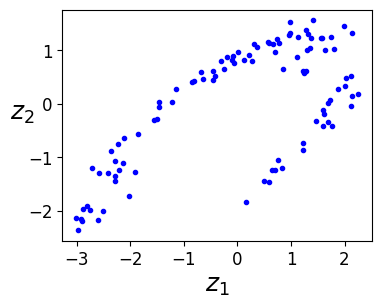

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked autoencoders 

Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. 

In this case they are called stacked autoencoders (or deep autoencoders).


The architecture of a stacked autoencoder is typically symmetrical with regards to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich.

Example (MNIST data, 28x28=784 pixel input)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/stacked.jpeg" alt="Drawing" style="width: 500px;"/>


Let's use the MNIST data as an example

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

The code should look very familiar, except that there are no labels (no y)!

In [9]:
reset_state()

n_inputs = 28 * 28 #input dimension 
n_hidden1 = 300  #first coding
n_hidden2 = 150  #second coding
n_hidden3 = n_hidden1 #symmetric decoding 
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001 #limit used in L2 reg

#Returns an initializer that generates tensors without scaling variance.
#When initializing a deep network, it is in principle advantageous to keep 
#the scale of the input variance constant, so it does not explode or 
#diminish by reaching the final layer. 
he_init = tf.keras.initializers.HeNormal() # He initialization

#Returns a function that can be used to apply L2 regularization to weights.
#Small values of L2 can help prevent overfitting the training data.
l2_regularizer = tf.keras.regularizers.L2(l2_reg)

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer),
    keras.layers.Dense(30, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_initializer=he_init, kernel_regularizer=l2_regularizer, input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.legacy.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [11]:
history = stacked_ae.fit(X_train, X_train, batch_size = 150, epochs=5,
                         validation_data=(X_valid, X_valid))

Epoch 1/5


  1/367 [..............................] - ETA: 2:44 - loss: 0.7551 - rounded_accuracy: 0.4865

 10/367 [..............................] - ETA: 2s - loss: 0.7238 - rounded_accuracy: 0.5682  

 20/367 [>.............................] - ETA: 1s - loss: 0.6688 - rounded_accuracy: 0.6360

 31/367 [=>............................] - ETA: 1s - loss: 0.6258 - rounded_accuracy: 0.6746

 43/367 [==>...........................] - ETA: 1s - loss: 0.5988 - rounded_accuracy: 0.6983

 54/367 [===>..........................] - ETA: 1s - loss: 0.5800 - rounded_accuracy: 0.7142

 65/367 [====>.........................] - ETA: 1s - loss: 0.5630 - rounded_accuracy: 0.7287

 76/367 [=====>........................] - ETA: 1s - loss: 0.5493 - rounded_accuracy: 0.7403

 87/367 [======>.......................] - ETA: 1s - loss: 0.5379 - rounded_accuracy: 0.7502

 99/367 [=======>......................] - ETA: 1s - loss: 0.5266 - rounded_accuracy: 0.7596

111/367 [========>.....................] - ETA: 1s - loss: 0.5175 - rounded_accuracy: 0.7673

123/367 [=========>....................] - ETA: 1s - loss: 0.5083 - rounded_accuracy: 0.7750

135/367 [==========>...................] - ETA: 1s - loss: 0.5006 - rounded_accuracy: 0.7813

146/367 [==========>...................] - ETA: 1s - loss: 0.4943 - rounded_accuracy: 0.7868

158/367 [===========>..................] - ETA: 0s - loss: 0.4883 - rounded_accuracy: 0.7919

170/367 [============>.................] - ETA: 0s - loss: 0.4832 - rounded_accuracy: 0.7963

182/367 [=============>................] - ETA: 0s - loss: 0.4786 - rounded_accuracy: 0.8004

194/367 [==============>...............] - ETA: 0s - loss: 0.4741 - rounded_accuracy: 0.8043

206/367 [===============>..............] - ETA: 0s - loss: 0.4705 - rounded_accuracy: 0.8076

218/367 [================>.............] - ETA: 0s - loss: 0.4668 - rounded_accuracy: 0.8111

229/367 [=================>............] - ETA: 0s - loss: 0.4638 - rounded_accuracy: 0.8137

240/367 [==================>...........] - ETA: 0s - loss: 0.4609 - rounded_accuracy: 0.8164

251/367 [===================>..........] - ETA: 0s - loss: 0.4583 - rounded_accuracy: 0.8186

263/367 [====================>.........] - ETA: 0s - loss: 0.4558 - rounded_accuracy: 0.8211

274/367 [=====================>........] - ETA: 0s - loss: 0.4534 - rounded_accuracy: 0.8233

285/367 [======================>.......] - ETA: 0s - loss: 0.4507 - rounded_accuracy: 0.8256

296/367 [=======================>......] - ETA: 0s - loss: 0.4485 - rounded_accuracy: 0.8276

307/367 [========================>.....] - ETA: 0s - loss: 0.4466 - rounded_accuracy: 0.8293

319/367 [=========================>....] - ETA: 0s - loss: 0.4444 - rounded_accuracy: 0.8312

331/367 [==========================>...] - ETA: 0s - loss: 0.4424 - rounded_accuracy: 0.8330

343/367 [===========================>..] - ETA: 0s - loss: 0.4404 - rounded_accuracy: 0.8347

355/367 [============================>.] - ETA: 0s - loss: 0.4383 - rounded_accuracy: 0.8365

366/367 [============================>.] - ETA: 0s - loss: 0.4366 - rounded_accuracy: 0.8380

367/367 [==============================] - 2s 5ms/step - loss: 0.4364 - rounded_accuracy: 0.8381 - val_loss: 0.3788 - val_rounded_accuracy: 0.8889


Epoch 2/5


  1/367 [..............................] - ETA: 1s - loss: 0.3854 - rounded_accuracy: 0.8855

 12/367 [..............................] - ETA: 1s - loss: 0.3810 - rounded_accuracy: 0.8853

 22/367 [>.............................] - ETA: 1s - loss: 0.3817 - rounded_accuracy: 0.8849

 33/367 [=>............................] - ETA: 1s - loss: 0.3784 - rounded_accuracy: 0.8862

 44/367 [==>...........................] - ETA: 1s - loss: 0.3782 - rounded_accuracy: 0.8873

 55/367 [===>..........................] - ETA: 1s - loss: 0.3788 - rounded_accuracy: 0.8871

 67/367 [====>.........................] - ETA: 1s - loss: 0.3790 - rounded_accuracy: 0.8870

 77/367 [=====>........................] - ETA: 1s - loss: 0.3772 - rounded_accuracy: 0.8882

 88/367 [======>.......................] - ETA: 1s - loss: 0.3765 - rounded_accuracy: 0.8888

 99/367 [=======>......................] - ETA: 1s - loss: 0.3757 - rounded_accuracy: 0.8891

111/367 [========>.....................] - ETA: 1s - loss: 0.3753 - rounded_accuracy: 0.8891

122/367 [========>.....................] - ETA: 1s - loss: 0.3744 - rounded_accuracy: 0.8899

134/367 [=========>....................] - ETA: 1s - loss: 0.3738 - rounded_accuracy: 0.8906

146/367 [==========>...................] - ETA: 1s - loss: 0.3738 - rounded_accuracy: 0.8905

157/367 [===========>..................] - ETA: 0s - loss: 0.3732 - rounded_accuracy: 0.8909

169/367 [============>.................] - ETA: 0s - loss: 0.3727 - rounded_accuracy: 0.8914

180/367 [=============>................] - ETA: 0s - loss: 0.3722 - rounded_accuracy: 0.8916

192/367 [==============>...............] - ETA: 0s - loss: 0.3717 - rounded_accuracy: 0.8919

204/367 [===============>..............] - ETA: 0s - loss: 0.3717 - rounded_accuracy: 0.8919

216/367 [================>.............] - ETA: 0s - loss: 0.3711 - rounded_accuracy: 0.8924

227/367 [=================>............] - ETA: 0s - loss: 0.3708 - rounded_accuracy: 0.8927

237/367 [==================>...........] - ETA: 0s - loss: 0.3705 - rounded_accuracy: 0.8929

249/367 [===================>..........] - ETA: 0s - loss: 0.3703 - rounded_accuracy: 0.8930

261/367 [====================>.........] - ETA: 0s - loss: 0.3699 - rounded_accuracy: 0.8932

272/367 [=====================>........] - ETA: 0s - loss: 0.3694 - rounded_accuracy: 0.8935

283/367 [======================>.......] - ETA: 0s - loss: 0.3689 - rounded_accuracy: 0.8938

295/367 [=======================>......] - ETA: 0s - loss: 0.3685 - rounded_accuracy: 0.8942

307/367 [========================>.....] - ETA: 0s - loss: 0.3683 - rounded_accuracy: 0.8941

318/367 [========================>.....] - ETA: 0s - loss: 0.3680 - rounded_accuracy: 0.8944

330/367 [=========================>....] - ETA: 0s - loss: 0.3677 - rounded_accuracy: 0.8946

342/367 [==========================>...] - ETA: 0s - loss: 0.3674 - rounded_accuracy: 0.8948

354/367 [===========================>..] - ETA: 0s - loss: 0.3671 - rounded_accuracy: 0.8950

365/367 [============================>.] - ETA: 0s - loss: 0.3669 - rounded_accuracy: 0.8951

367/367 [==============================] - 2s 5ms/step - loss: 0.3668 - rounded_accuracy: 0.8952 - val_loss: 0.3610 - val_rounded_accuracy: 0.8936


Epoch 3/5


  1/367 [..............................] - ETA: 2s - loss: 0.3552 - rounded_accuracy: 0.8924

 13/367 [>.............................] - ETA: 1s - loss: 0.3576 - rounded_accuracy: 0.9006

 24/367 [>.............................] - ETA: 1s - loss: 0.3545 - rounded_accuracy: 0.9028

 36/367 [=>............................] - ETA: 1s - loss: 0.3563 - rounded_accuracy: 0.9011

 48/367 [==>...........................] - ETA: 1s - loss: 0.3568 - rounded_accuracy: 0.9012

 58/367 [===>..........................] - ETA: 1s - loss: 0.3560 - rounded_accuracy: 0.9016

 69/367 [====>.........................] - ETA: 1s - loss: 0.3560 - rounded_accuracy: 0.9014

 80/367 [=====>........................] - ETA: 1s - loss: 0.3557 - rounded_accuracy: 0.9015

 92/367 [======>.......................] - ETA: 1s - loss: 0.3551 - rounded_accuracy: 0.9020

104/367 [=======>......................] - ETA: 1s - loss: 0.3548 - rounded_accuracy: 0.9020

116/367 [========>.....................] - ETA: 1s - loss: 0.3548 - rounded_accuracy: 0.9021

128/367 [=========>....................] - ETA: 1s - loss: 0.3549 - rounded_accuracy: 0.9019

140/367 [==========>...................] - ETA: 1s - loss: 0.3550 - rounded_accuracy: 0.9017

152/367 [===========>..................] - ETA: 0s - loss: 0.3546 - rounded_accuracy: 0.9018

164/367 [============>.................] - ETA: 0s - loss: 0.3544 - rounded_accuracy: 0.9020

176/367 [=============>................] - ETA: 0s - loss: 0.3540 - rounded_accuracy: 0.9022

188/367 [==============>...............] - ETA: 0s - loss: 0.3538 - rounded_accuracy: 0.9024

199/367 [===============>..............] - ETA: 0s - loss: 0.3536 - rounded_accuracy: 0.9025

210/367 [================>.............] - ETA: 0s - loss: 0.3537 - rounded_accuracy: 0.9025

221/367 [=================>............] - ETA: 0s - loss: 0.3537 - rounded_accuracy: 0.9025

232/367 [=================>............] - ETA: 0s - loss: 0.3536 - rounded_accuracy: 0.9026

244/367 [==================>...........] - ETA: 0s - loss: 0.3534 - rounded_accuracy: 0.9029

256/367 [===================>..........] - ETA: 0s - loss: 0.3532 - rounded_accuracy: 0.9029

268/367 [====================>.........] - ETA: 0s - loss: 0.3533 - rounded_accuracy: 0.9028

280/367 [=====================>........] - ETA: 0s - loss: 0.3531 - rounded_accuracy: 0.9030

291/367 [======================>.......] - ETA: 0s - loss: 0.3529 - rounded_accuracy: 0.9032

303/367 [=======================>......] - ETA: 0s - loss: 0.3525 - rounded_accuracy: 0.9033

314/367 [========================>.....] - ETA: 0s - loss: 0.3525 - rounded_accuracy: 0.9034

326/367 [=========================>....] - ETA: 0s - loss: 0.3521 - rounded_accuracy: 0.9036

338/367 [==========================>...] - ETA: 0s - loss: 0.3520 - rounded_accuracy: 0.9038

349/367 [===========================>..] - ETA: 0s - loss: 0.3520 - rounded_accuracy: 0.9037

360/367 [============================>.] - ETA: 0s - loss: 0.3517 - rounded_accuracy: 0.9039

367/367 [==============================] - 2s 5ms/step - loss: 0.3516 - rounded_accuracy: 0.9039 - val_loss: 0.3484 - val_rounded_accuracy: 0.9092


Epoch 4/5


  1/367 [..............................] - ETA: 2s - loss: 0.3525 - rounded_accuracy: 0.9030

 12/367 [..............................] - ETA: 1s - loss: 0.3454 - rounded_accuracy: 0.9064

 23/367 [>.............................] - ETA: 1s - loss: 0.3452 - rounded_accuracy: 0.9072

 34/367 [=>............................] - ETA: 1s - loss: 0.3459 - rounded_accuracy: 0.9062

 45/367 [==>...........................] - ETA: 1s - loss: 0.3463 - rounded_accuracy: 0.9060

 56/367 [===>..........................] - ETA: 1s - loss: 0.3461 - rounded_accuracy: 0.9066

 67/367 [====>.........................] - ETA: 1s - loss: 0.3456 - rounded_accuracy: 0.9070

 79/367 [=====>........................] - ETA: 1s - loss: 0.3454 - rounded_accuracy: 0.9071

 91/367 [======>.......................] - ETA: 1s - loss: 0.3466 - rounded_accuracy: 0.9062

102/367 [=======>......................] - ETA: 1s - loss: 0.3462 - rounded_accuracy: 0.9064

113/367 [========>.....................] - ETA: 1s - loss: 0.3455 - rounded_accuracy: 0.9069

123/367 [=========>....................] - ETA: 1s - loss: 0.3450 - rounded_accuracy: 0.9074

134/367 [=========>....................] - ETA: 1s - loss: 0.3444 - rounded_accuracy: 0.9074

145/367 [==========>...................] - ETA: 1s - loss: 0.3448 - rounded_accuracy: 0.9069

156/367 [===========>..................] - ETA: 0s - loss: 0.3446 - rounded_accuracy: 0.9072

167/367 [============>.................] - ETA: 0s - loss: 0.3443 - rounded_accuracy: 0.9073

178/367 [=============>................] - ETA: 0s - loss: 0.3443 - rounded_accuracy: 0.9072

190/367 [==============>...............] - ETA: 0s - loss: 0.3441 - rounded_accuracy: 0.9074

202/367 [===============>..............] - ETA: 0s - loss: 0.3440 - rounded_accuracy: 0.9075

214/367 [================>.............] - ETA: 0s - loss: 0.3438 - rounded_accuracy: 0.9074

225/367 [=================>............] - ETA: 0s - loss: 0.3436 - rounded_accuracy: 0.9076

237/367 [==================>...........] - ETA: 0s - loss: 0.3438 - rounded_accuracy: 0.9074

249/367 [===================>..........] - ETA: 0s - loss: 0.3437 - rounded_accuracy: 0.9075

261/367 [====================>.........] - ETA: 0s - loss: 0.3435 - rounded_accuracy: 0.9076

272/367 [=====================>........] - ETA: 0s - loss: 0.3433 - rounded_accuracy: 0.9077

282/367 [======================>.......] - ETA: 0s - loss: 0.3434 - rounded_accuracy: 0.9076

293/367 [======================>.......] - ETA: 0s - loss: 0.3433 - rounded_accuracy: 0.9076

305/367 [=======================>......] - ETA: 0s - loss: 0.3432 - rounded_accuracy: 0.9078

315/367 [========================>.....] - ETA: 0s - loss: 0.3430 - rounded_accuracy: 0.9079

327/367 [=========================>....] - ETA: 0s - loss: 0.3430 - rounded_accuracy: 0.9079

338/367 [==========================>...] - ETA: 0s - loss: 0.3428 - rounded_accuracy: 0.9080

349/367 [===========================>..] - ETA: 0s - loss: 0.3426 - rounded_accuracy: 0.9082

360/367 [============================>.] - ETA: 0s - loss: 0.3425 - rounded_accuracy: 0.9081

367/367 [==============================] - 2s 5ms/step - loss: 0.3424 - rounded_accuracy: 0.9080 - val_loss: 0.3415 - val_rounded_accuracy: 0.9047


Epoch 5/5


  1/367 [..............................] - ETA: 2s - loss: 0.3347 - rounded_accuracy: 0.9054

 12/367 [..............................] - ETA: 1s - loss: 0.3385 - rounded_accuracy: 0.9106

 24/367 [>.............................] - ETA: 1s - loss: 0.3370 - rounded_accuracy: 0.9108

 36/367 [=>............................] - ETA: 1s - loss: 0.3368 - rounded_accuracy: 0.9104

 47/367 [==>...........................] - ETA: 1s - loss: 0.3375 - rounded_accuracy: 0.9099

 58/367 [===>..........................] - ETA: 1s - loss: 0.3379 - rounded_accuracy: 0.9097

 70/367 [====>.........................] - ETA: 1s - loss: 0.3384 - rounded_accuracy: 0.9098

 82/367 [=====>........................] - ETA: 1s - loss: 0.3385 - rounded_accuracy: 0.9097

 94/367 [======>.......................] - ETA: 1s - loss: 0.3382 - rounded_accuracy: 0.9101

106/367 [=======>......................] - ETA: 1s - loss: 0.3380 - rounded_accuracy: 0.9102

118/367 [========>.....................] - ETA: 1s - loss: 0.3379 - rounded_accuracy: 0.9105

129/367 [=========>....................] - ETA: 1s - loss: 0.3378 - rounded_accuracy: 0.9104

140/367 [==========>...................] - ETA: 1s - loss: 0.3379 - rounded_accuracy: 0.9103

150/367 [===========>..................] - ETA: 0s - loss: 0.3376 - rounded_accuracy: 0.9103

161/367 [============>.................] - ETA: 0s - loss: 0.3374 - rounded_accuracy: 0.9105

171/367 [============>.................] - ETA: 0s - loss: 0.3372 - rounded_accuracy: 0.9107

182/367 [=============>................] - ETA: 0s - loss: 0.3373 - rounded_accuracy: 0.9106

193/367 [==============>...............] - ETA: 0s - loss: 0.3370 - rounded_accuracy: 0.9107

203/367 [===============>..............] - ETA: 0s - loss: 0.3370 - rounded_accuracy: 0.9107

214/367 [================>.............] - ETA: 0s - loss: 0.3368 - rounded_accuracy: 0.9108

225/367 [=================>............] - ETA: 0s - loss: 0.3367 - rounded_accuracy: 0.9108

237/367 [==================>...........] - ETA: 0s - loss: 0.3364 - rounded_accuracy: 0.9109

249/367 [===================>..........] - ETA: 0s - loss: 0.3363 - rounded_accuracy: 0.9109

261/367 [====================>.........] - ETA: 0s - loss: 0.3364 - rounded_accuracy: 0.9109

272/367 [=====================>........] - ETA: 0s - loss: 0.3363 - rounded_accuracy: 0.9109

283/367 [======================>.......] - ETA: 0s - loss: 0.3362 - rounded_accuracy: 0.9109

294/367 [=======================>......] - ETA: 0s - loss: 0.3362 - rounded_accuracy: 0.9109

306/367 [========================>.....] - ETA: 0s - loss: 0.3361 - rounded_accuracy: 0.9109

317/367 [========================>.....] - ETA: 0s - loss: 0.3360 - rounded_accuracy: 0.9108

328/367 [=========================>....] - ETA: 0s - loss: 0.3359 - rounded_accuracy: 0.9108

339/367 [==========================>...] - ETA: 0s - loss: 0.3359 - rounded_accuracy: 0.9108

351/367 [===========================>..] - ETA: 0s - loss: 0.3360 - rounded_accuracy: 0.9107

361/367 [============================>.] - ETA: 0s - loss: 0.3359 - rounded_accuracy: 0.9108

367/367 [==============================] - 2s 5ms/step - loss: 0.3358 - rounded_accuracy: 0.9108 - val_loss: 0.3344 - val_rounded_accuracy: 0.9140


In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 62ms/step


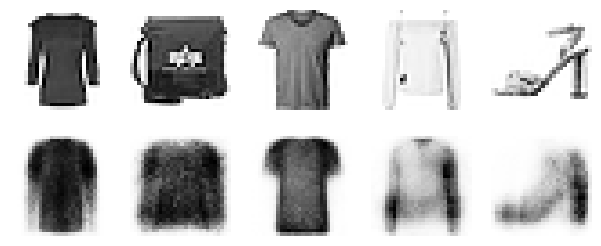

In [13]:
#showing output layer
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Can tie decoding weights to be the same as the encoder - difficult to do with dense, but can be coded manually

In [14]:
reset_state()

learning_rate = 0.01
l2_reg = 0.0005

In [15]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation=tf.keras.layers.ELU(), kernel_regularizer=l2_regularizer)
dense_2 = keras.layers.Dense(30, activation=tf.keras.layers.ELU(), kernel_regularizer=l2_regularizer)

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation=tf.keras.layers.ELU()),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=[rounded_accuracy])

In [17]:
history = tied_ae.fit(X_train, X_train, epochs=5, batch_size=150,
                      validation_data=(X_valid, X_valid))

Epoch 1/5


  1/367 [..............................] - ETA: 2:48 - loss: 0.7136 - rounded_accuracy: 0.5349

 11/367 [..............................] - ETA: 1s - loss: 0.5683 - rounded_accuracy: 0.7012  

 22/367 [>.............................] - ETA: 1s - loss: 0.4956 - rounded_accuracy: 0.7575

 33/367 [=>............................] - ETA: 1s - loss: 0.4608 - rounded_accuracy: 0.7900

 44/367 [==>...........................] - ETA: 1s - loss: 0.4364 - rounded_accuracy: 0.8162

 55/367 [===>..........................] - ETA: 1s - loss: 0.4198 - rounded_accuracy: 0.8327

 66/367 [====>.........................] - ETA: 1s - loss: 0.4066 - rounded_accuracy: 0.8450

 77/367 [=====>........................] - ETA: 1s - loss: 0.3967 - rounded_accuracy: 0.8541

 88/367 [======>.......................] - ETA: 1s - loss: 0.3886 - rounded_accuracy: 0.8610

 99/367 [=======>......................] - ETA: 1s - loss: 0.3821 - rounded_accuracy: 0.8665

111/367 [========>.....................] - ETA: 1s - loss: 0.3764 - rounded_accuracy: 0.8713

123/367 [=========>....................] - ETA: 1s - loss: 0.3714 - rounded_accuracy: 0.8753

135/367 [==========>...................] - ETA: 1s - loss: 0.3672 - rounded_accuracy: 0.8787

147/367 [===========>..................] - ETA: 1s - loss: 0.3634 - rounded_accuracy: 0.8816

157/367 [===========>..................] - ETA: 0s - loss: 0.3608 - rounded_accuracy: 0.8837

168/367 [============>.................] - ETA: 0s - loss: 0.3581 - rounded_accuracy: 0.8857

179/367 [=============>................] - ETA: 0s - loss: 0.3560 - rounded_accuracy: 0.8875

190/367 [==============>...............] - ETA: 0s - loss: 0.3539 - rounded_accuracy: 0.8892

202/367 [===============>..............] - ETA: 0s - loss: 0.3519 - rounded_accuracy: 0.8907

213/367 [================>.............] - ETA: 0s - loss: 0.3502 - rounded_accuracy: 0.8922

225/367 [=================>............] - ETA: 0s - loss: 0.3484 - rounded_accuracy: 0.8936

237/367 [==================>...........] - ETA: 0s - loss: 0.3472 - rounded_accuracy: 0.8947

249/367 [===================>..........] - ETA: 0s - loss: 0.3458 - rounded_accuracy: 0.8959

260/367 [====================>.........] - ETA: 0s - loss: 0.3448 - rounded_accuracy: 0.8968

271/367 [=====================>........] - ETA: 0s - loss: 0.3438 - rounded_accuracy: 0.8977

283/367 [======================>.......] - ETA: 0s - loss: 0.3426 - rounded_accuracy: 0.8987

294/367 [=======================>......] - ETA: 0s - loss: 0.3415 - rounded_accuracy: 0.8996

306/367 [========================>.....] - ETA: 0s - loss: 0.3407 - rounded_accuracy: 0.9003

318/367 [========================>.....] - ETA: 0s - loss: 0.3398 - rounded_accuracy: 0.9010

330/367 [=========================>....] - ETA: 0s - loss: 0.3390 - rounded_accuracy: 0.9017

342/367 [==========================>...] - ETA: 0s - loss: 0.3382 - rounded_accuracy: 0.9023

354/367 [===========================>..] - ETA: 0s - loss: 0.3375 - rounded_accuracy: 0.9029

366/367 [============================>.] - ETA: 0s - loss: 0.3368 - rounded_accuracy: 0.9035

367/367 [==============================] - 2s 5ms/step - loss: 0.3367 - rounded_accuracy: 0.9036 - val_loss: 0.3176 - val_rounded_accuracy: 0.9204


Epoch 2/5


  1/367 [..............................] - ETA: 2s - loss: 0.3218 - rounded_accuracy: 0.9152

 12/367 [..............................] - ETA: 1s - loss: 0.3166 - rounded_accuracy: 0.9194

 24/367 [>.............................] - ETA: 1s - loss: 0.3166 - rounded_accuracy: 0.9210

 36/367 [=>............................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9213

 48/367 [==>...........................] - ETA: 1s - loss: 0.3164 - rounded_accuracy: 0.9206

 59/367 [===>..........................] - ETA: 1s - loss: 0.3173 - rounded_accuracy: 0.9206

 71/367 [====>.........................] - ETA: 1s - loss: 0.3167 - rounded_accuracy: 0.9209

 83/367 [=====>........................] - ETA: 1s - loss: 0.3161 - rounded_accuracy: 0.9210

 94/367 [======>.......................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9211

105/367 [=======>......................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9215

116/367 [========>.....................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9214

128/367 [=========>....................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9216

140/367 [==========>...................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9217

152/367 [===========>..................] - ETA: 0s - loss: 0.3149 - rounded_accuracy: 0.9218

164/367 [============>.................] - ETA: 0s - loss: 0.3150 - rounded_accuracy: 0.9218

175/367 [=============>................] - ETA: 0s - loss: 0.3149 - rounded_accuracy: 0.9219

186/367 [==============>...............] - ETA: 0s - loss: 0.3147 - rounded_accuracy: 0.9219

198/367 [===============>..............] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9220

209/367 [================>.............] - ETA: 0s - loss: 0.3147 - rounded_accuracy: 0.9221

220/367 [================>.............] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9223

231/367 [=================>............] - ETA: 0s - loss: 0.3147 - rounded_accuracy: 0.9223

242/367 [==================>...........] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9223

253/367 [===================>..........] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9224

265/367 [====================>.........] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9224

277/367 [=====================>........] - ETA: 0s - loss: 0.3143 - rounded_accuracy: 0.9225

288/367 [======================>.......] - ETA: 0s - loss: 0.3141 - rounded_accuracy: 0.9226

299/367 [=======================>......] - ETA: 0s - loss: 0.3142 - rounded_accuracy: 0.9227

311/367 [========================>.....] - ETA: 0s - loss: 0.3141 - rounded_accuracy: 0.9227

323/367 [=========================>....] - ETA: 0s - loss: 0.3142 - rounded_accuracy: 0.9227

335/367 [==========================>...] - ETA: 0s - loss: 0.3142 - rounded_accuracy: 0.9228

346/367 [===========================>..] - ETA: 0s - loss: 0.3141 - rounded_accuracy: 0.9228

357/367 [============================>.] - ETA: 0s - loss: 0.3142 - rounded_accuracy: 0.9228

367/367 [==============================] - 2s 5ms/step - loss: 0.3141 - rounded_accuracy: 0.9229 - val_loss: 0.3151 - val_rounded_accuracy: 0.9251


Epoch 3/5


  1/367 [..............................] - ETA: 2s - loss: 0.3094 - rounded_accuracy: 0.9259

 12/367 [..............................] - ETA: 1s - loss: 0.3116 - rounded_accuracy: 0.9264

 24/367 [>.............................] - ETA: 1s - loss: 0.3107 - rounded_accuracy: 0.9258

 35/367 [=>............................] - ETA: 1s - loss: 0.3120 - rounded_accuracy: 0.9250

 46/367 [==>...........................] - ETA: 1s - loss: 0.3125 - rounded_accuracy: 0.9249

 57/367 [===>..........................] - ETA: 1s - loss: 0.3122 - rounded_accuracy: 0.9253

 68/367 [====>.........................] - ETA: 1s - loss: 0.3121 - rounded_accuracy: 0.9251

 80/367 [=====>........................] - ETA: 1s - loss: 0.3119 - rounded_accuracy: 0.9252

 92/367 [======>.......................] - ETA: 1s - loss: 0.3118 - rounded_accuracy: 0.9254

103/367 [=======>......................] - ETA: 1s - loss: 0.3115 - rounded_accuracy: 0.9253

115/367 [========>.....................] - ETA: 1s - loss: 0.3118 - rounded_accuracy: 0.9252

126/367 [=========>....................] - ETA: 1s - loss: 0.3121 - rounded_accuracy: 0.9250

138/367 [==========>...................] - ETA: 1s - loss: 0.3121 - rounded_accuracy: 0.9249

150/367 [===========>..................] - ETA: 0s - loss: 0.3119 - rounded_accuracy: 0.9249

162/367 [============>.................] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9247

174/367 [=============>................] - ETA: 0s - loss: 0.3119 - rounded_accuracy: 0.9248

186/367 [==============>...............] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9249

198/367 [===============>..............] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9250

210/367 [================>.............] - ETA: 0s - loss: 0.3119 - rounded_accuracy: 0.9250

222/367 [=================>............] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9250

234/367 [==================>...........] - ETA: 0s - loss: 0.3120 - rounded_accuracy: 0.9250

246/367 [===================>..........] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9250

258/367 [====================>.........] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9250

269/367 [====================>.........] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9250

280/367 [=====================>........] - ETA: 0s - loss: 0.3121 - rounded_accuracy: 0.9251

292/367 [======================>.......] - ETA: 0s - loss: 0.3119 - rounded_accuracy: 0.9252

303/367 [=======================>......] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9253

314/367 [========================>.....] - ETA: 0s - loss: 0.3119 - rounded_accuracy: 0.9252

325/367 [=========================>....] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9253

337/367 [==========================>...] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9253

348/367 [===========================>..] - ETA: 0s - loss: 0.3118 - rounded_accuracy: 0.9254

359/367 [============================>.] - ETA: 0s - loss: 0.3117 - rounded_accuracy: 0.9255

367/367 [==============================] - 2s 5ms/step - loss: 0.3117 - rounded_accuracy: 0.9255 - val_loss: 0.3126 - val_rounded_accuracy: 0.9274


Epoch 4/5


  1/367 [..............................] - ETA: 1s - loss: 0.3181 - rounded_accuracy: 0.9221

 12/367 [..............................] - ETA: 1s - loss: 0.3111 - rounded_accuracy: 0.9253

 24/367 [>.............................] - ETA: 1s - loss: 0.3122 - rounded_accuracy: 0.9243

 35/367 [=>............................] - ETA: 1s - loss: 0.3118 - rounded_accuracy: 0.9245

 46/367 [==>...........................] - ETA: 1s - loss: 0.3119 - rounded_accuracy: 0.9250

 56/367 [===>..........................] - ETA: 1s - loss: 0.3120 - rounded_accuracy: 0.9254

 68/367 [====>.........................] - ETA: 1s - loss: 0.3117 - rounded_accuracy: 0.9256

 80/367 [=====>........................] - ETA: 1s - loss: 0.3115 - rounded_accuracy: 0.9258

 91/367 [======>.......................] - ETA: 1s - loss: 0.3121 - rounded_accuracy: 0.9258

103/367 [=======>......................] - ETA: 1s - loss: 0.3118 - rounded_accuracy: 0.9258

115/367 [========>.....................] - ETA: 1s - loss: 0.3114 - rounded_accuracy: 0.9261

126/367 [=========>....................] - ETA: 1s - loss: 0.3110 - rounded_accuracy: 0.9263

137/367 [==========>...................] - ETA: 1s - loss: 0.3108 - rounded_accuracy: 0.9261

149/367 [===========>..................] - ETA: 1s - loss: 0.3110 - rounded_accuracy: 0.9262

161/367 [============>.................] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9264

173/367 [=============>................] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9263

184/367 [==============>...............] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9262

196/367 [===============>..............] - ETA: 0s - loss: 0.3108 - rounded_accuracy: 0.9262

208/367 [================>.............] - ETA: 0s - loss: 0.3105 - rounded_accuracy: 0.9264

220/367 [================>.............] - ETA: 0s - loss: 0.3104 - rounded_accuracy: 0.9264

231/367 [=================>............] - ETA: 0s - loss: 0.3105 - rounded_accuracy: 0.9264

243/367 [==================>...........] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9264

255/367 [===================>..........] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9264

266/367 [====================>.........] - ETA: 0s - loss: 0.3105 - rounded_accuracy: 0.9264

277/367 [=====================>........] - ETA: 0s - loss: 0.3105 - rounded_accuracy: 0.9264

288/367 [======================>.......] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9264

300/367 [=======================>......] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9265

312/367 [========================>.....] - ETA: 0s - loss: 0.3107 - rounded_accuracy: 0.9264

324/367 [=========================>....] - ETA: 0s - loss: 0.3107 - rounded_accuracy: 0.9264

335/367 [==========================>...] - ETA: 0s - loss: 0.3107 - rounded_accuracy: 0.9264

347/367 [===========================>..] - ETA: 0s - loss: 0.3107 - rounded_accuracy: 0.9264

359/367 [============================>.] - ETA: 0s - loss: 0.3106 - rounded_accuracy: 0.9264

367/367 [==============================] - 2s 5ms/step - loss: 0.3104 - rounded_accuracy: 0.9265 - val_loss: 0.3109 - val_rounded_accuracy: 0.9280


Epoch 5/5


  1/367 [..............................] - ETA: 2s - loss: 0.3035 - rounded_accuracy: 0.9291

 13/367 [>.............................] - ETA: 1s - loss: 0.3104 - rounded_accuracy: 0.9280

 25/367 [=>............................] - ETA: 1s - loss: 0.3088 - rounded_accuracy: 0.9278

 37/367 [==>...........................] - ETA: 1s - loss: 0.3091 - rounded_accuracy: 0.9270

 49/367 [===>..........................] - ETA: 1s - loss: 0.3098 - rounded_accuracy: 0.9266

 60/367 [===>..........................] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9271

 72/367 [====>.........................] - ETA: 1s - loss: 0.3099 - rounded_accuracy: 0.9272

 84/367 [=====>........................] - ETA: 1s - loss: 0.3100 - rounded_accuracy: 0.9271

 95/367 [======>.......................] - ETA: 1s - loss: 0.3102 - rounded_accuracy: 0.9270

105/367 [=======>......................] - ETA: 1s - loss: 0.3102 - rounded_accuracy: 0.9270

116/367 [========>.....................] - ETA: 1s - loss: 0.3101 - rounded_accuracy: 0.9271

127/367 [=========>....................] - ETA: 1s - loss: 0.3100 - rounded_accuracy: 0.9272

139/367 [==========>...................] - ETA: 1s - loss: 0.3100 - rounded_accuracy: 0.9271

150/367 [===========>..................] - ETA: 0s - loss: 0.3099 - rounded_accuracy: 0.9271

162/367 [============>.................] - ETA: 0s - loss: 0.3099 - rounded_accuracy: 0.9272

173/367 [=============>................] - ETA: 0s - loss: 0.3098 - rounded_accuracy: 0.9272

185/367 [==============>...............] - ETA: 0s - loss: 0.3099 - rounded_accuracy: 0.9271

196/367 [===============>..............] - ETA: 0s - loss: 0.3096 - rounded_accuracy: 0.9273

207/367 [===============>..............] - ETA: 0s - loss: 0.3096 - rounded_accuracy: 0.9274

218/367 [================>.............] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9274

229/367 [=================>............] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9275

241/367 [==================>...........] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9276

252/367 [===================>..........] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9275

264/367 [====================>.........] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9275

276/367 [=====================>........] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9276

288/367 [======================>.......] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9275

300/367 [=======================>......] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9275

312/367 [========================>.....] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9275

324/367 [=========================>....] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9275

334/367 [==========================>...] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9274

346/367 [===========================>..] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9273

358/367 [============================>.] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9273

367/367 [==============================] - 2s 5ms/step - loss: 0.3095 - rounded_accuracy: 0.9273 - val_loss: 0.3110 - val_rounded_accuracy: 0.9279


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 60ms/step


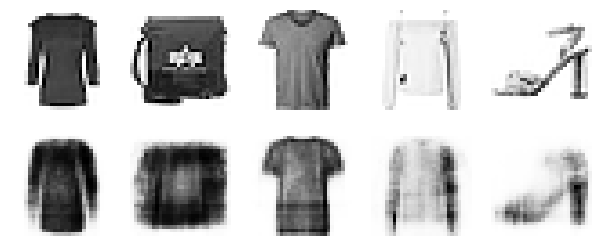

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Training One Autoencoder at a Time 

* Rather than training the whole stacked autoencoder in one go like we just did, 
* It is often much faster to train one shallow autoencoder at a time, 
* then stack all of them into a single stacked autoencoder (hence the name)

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/stacked2.jpeg" alt="Drawing" style="width: 500px;"/>




Using example from tied weights above 

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)

In [21]:
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.legacy.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.legacy.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10


   1/1719 [..............................] - ETA: 8:22 - loss: 0.7006 - rounded_accuracy: 0.5135

  24/1719 [..............................] - ETA: 3s - loss: 0.6128 - rounded_accuracy: 0.6635  

  49/1719 [..............................] - ETA: 3s - loss: 0.5597 - rounded_accuracy: 0.7111

  74/1719 [>.............................] - ETA: 3s - loss: 0.5349 - rounded_accuracy: 0.7332

 100/1719 [>.............................] - ETA: 3s - loss: 0.5151 - rounded_accuracy: 0.7500

 126/1719 [=>............................] - ETA: 3s - loss: 0.5002 - rounded_accuracy: 0.7620

 152/1719 [=>............................] - ETA: 3s - loss: 0.4871 - rounded_accuracy: 0.7725

 177/1719 [==>...........................] - ETA: 3s - loss: 0.4762 - rounded_accuracy: 0.7814

 202/1719 [==>...........................] - ETA: 3s - loss: 0.4668 - rounded_accuracy: 0.7896

 225/1719 [==>...........................] - ETA: 3s - loss: 0.4583 - rounded_accuracy: 0.7957

 251/1719 [===>..........................] - ETA: 2s - loss: 0.4509 - rounded_accuracy: 0.8015

 276/1719 [===>..........................] - ETA: 2s - loss: 0.4445 - rounded_accuracy: 0.8069

 304/1719 [====>.........................] - ETA: 2s - loss: 0.4370 - rounded_accuracy: 0.8127

 328/1719 [====>.........................] - ETA: 2s - loss: 0.4318 - rounded_accuracy: 0.8170

 354/1719 [=====>........................] - ETA: 2s - loss: 0.4270 - rounded_accuracy: 0.8211

 376/1719 [=====>........................] - ETA: 2s - loss: 0.4228 - rounded_accuracy: 0.8245

 401/1719 [=====>........................] - ETA: 2s - loss: 0.4186 - rounded_accuracy: 0.8281

 427/1719 [======>.......................] - ETA: 2s - loss: 0.4143 - rounded_accuracy: 0.8315

 452/1719 [======>.......................] - ETA: 2s - loss: 0.4109 - rounded_accuracy: 0.8344

 477/1719 [=======>......................] - ETA: 2s - loss: 0.4075 - rounded_accuracy: 0.8370

 502/1719 [=======>......................] - ETA: 2s - loss: 0.4044 - rounded_accuracy: 0.8395

 528/1719 [========>.....................] - ETA: 2s - loss: 0.4015 - rounded_accuracy: 0.8420

 552/1719 [========>.....................] - ETA: 2s - loss: 0.3988 - rounded_accuracy: 0.8441

 577/1719 [=========>....................] - ETA: 2s - loss: 0.3960 - rounded_accuracy: 0.8462

 602/1719 [=========>....................] - ETA: 2s - loss: 0.3934 - rounded_accuracy: 0.8483

 625/1719 [=========>....................] - ETA: 2s - loss: 0.3912 - rounded_accuracy: 0.8500

 648/1719 [==========>...................] - ETA: 2s - loss: 0.3891 - rounded_accuracy: 0.8516

 671/1719 [==========>...................] - ETA: 2s - loss: 0.3870 - rounded_accuracy: 0.8533

 697/1719 [===========>..................] - ETA: 2s - loss: 0.3848 - rounded_accuracy: 0.8549

 721/1719 [===========>..................] - ETA: 2s - loss: 0.3829 - rounded_accuracy: 0.8565

 747/1719 [============>.................] - ETA: 1s - loss: 0.3811 - rounded_accuracy: 0.8578

 774/1719 [============>.................] - ETA: 1s - loss: 0.3792 - rounded_accuracy: 0.8593

 800/1719 [============>.................] - ETA: 1s - loss: 0.3772 - rounded_accuracy: 0.8608

 823/1719 [=============>................] - ETA: 1s - loss: 0.3760 - rounded_accuracy: 0.8618

 844/1719 [=============>................] - ETA: 1s - loss: 0.3747 - rounded_accuracy: 0.8629

 869/1719 [==============>...............] - ETA: 1s - loss: 0.3733 - rounded_accuracy: 0.8641

 895/1719 [==============>...............] - ETA: 1s - loss: 0.3718 - rounded_accuracy: 0.8653

 918/1719 [===============>..............] - ETA: 1s - loss: 0.3705 - rounded_accuracy: 0.8663

 944/1719 [===============>..............] - ETA: 1s - loss: 0.3691 - rounded_accuracy: 0.8673

 970/1719 [===============>..............] - ETA: 1s - loss: 0.3679 - rounded_accuracy: 0.8684

 996/1719 [================>.............] - ETA: 1s - loss: 0.3667 - rounded_accuracy: 0.8695

1019/1719 [================>.............] - ETA: 1s - loss: 0.3654 - rounded_accuracy: 0.8704

1045/1719 [=================>............] - ETA: 1s - loss: 0.3643 - rounded_accuracy: 0.8714

1070/1719 [=================>............] - ETA: 1s - loss: 0.3631 - rounded_accuracy: 0.8723

1095/1719 [==================>...........] - ETA: 1s - loss: 0.3622 - rounded_accuracy: 0.8731

1119/1719 [==================>...........] - ETA: 1s - loss: 0.3613 - rounded_accuracy: 0.8738

1145/1719 [==================>...........] - ETA: 1s - loss: 0.3603 - rounded_accuracy: 0.8746

1170/1719 [===================>..........] - ETA: 1s - loss: 0.3594 - rounded_accuracy: 0.8754

1196/1719 [===================>..........] - ETA: 1s - loss: 0.3584 - rounded_accuracy: 0.8762

1218/1719 [====================>.........] - ETA: 1s - loss: 0.3578 - rounded_accuracy: 0.8768

1243/1719 [====================>.........] - ETA: 0s - loss: 0.3571 - rounded_accuracy: 0.8775

1267/1719 [=====================>........] - ETA: 0s - loss: 0.3563 - rounded_accuracy: 0.8781

1289/1719 [=====================>........] - ETA: 0s - loss: 0.3555 - rounded_accuracy: 0.8787

1315/1719 [=====================>........] - ETA: 0s - loss: 0.3546 - rounded_accuracy: 0.8794

1337/1719 [======================>.......] - ETA: 0s - loss: 0.3538 - rounded_accuracy: 0.8800

1363/1719 [======================>.......] - ETA: 0s - loss: 0.3531 - rounded_accuracy: 0.8806

1389/1719 [=======================>......] - ETA: 0s - loss: 0.3523 - rounded_accuracy: 0.8813

1413/1719 [=======================>......] - ETA: 0s - loss: 0.3517 - rounded_accuracy: 0.8818

1439/1719 [========================>.....] - ETA: 0s - loss: 0.3510 - rounded_accuracy: 0.8823

1464/1719 [========================>.....] - ETA: 0s - loss: 0.3504 - rounded_accuracy: 0.8828

1487/1719 [========================>.....] - ETA: 0s - loss: 0.3498 - rounded_accuracy: 0.8833

1512/1719 [=========================>....] - ETA: 0s - loss: 0.3492 - rounded_accuracy: 0.8838

1535/1719 [=========================>....] - ETA: 0s - loss: 0.3487 - rounded_accuracy: 0.8843

1561/1719 [==========================>...] - ETA: 0s - loss: 0.3480 - rounded_accuracy: 0.8848

1587/1719 [==========================>...] - ETA: 0s - loss: 0.3474 - rounded_accuracy: 0.8852

1613/1719 [===========================>..] - ETA: 0s - loss: 0.3468 - rounded_accuracy: 0.8857

1639/1719 [===========================>..] - ETA: 0s - loss: 0.3463 - rounded_accuracy: 0.8861

1666/1719 [============================>.] - ETA: 0s - loss: 0.3456 - rounded_accuracy: 0.8867

1691/1719 [============================>.] - ETA: 0s - loss: 0.3452 - rounded_accuracy: 0.8871

1717/1719 [============================>.] - ETA: 0s - loss: 0.3446 - rounded_accuracy: 0.8876

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3445 - rounded_accuracy: 0.8876 - val_loss: 0.3112 - val_rounded_accuracy: 0.9161


Epoch 2/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3102 - rounded_accuracy: 0.9182

  28/1719 [..............................] - ETA: 3s - loss: 0.3138 - rounded_accuracy: 0.9134

  54/1719 [..............................] - ETA: 3s - loss: 0.3103 - rounded_accuracy: 0.9145

  80/1719 [>.............................] - ETA: 3s - loss: 0.3082 - rounded_accuracy: 0.9163

 105/1719 [>.............................] - ETA: 3s - loss: 0.3094 - rounded_accuracy: 0.9166

 130/1719 [=>............................] - ETA: 3s - loss: 0.3080 - rounded_accuracy: 0.9166

 157/1719 [=>............................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9168

 181/1719 [==>...........................] - ETA: 3s - loss: 0.3086 - rounded_accuracy: 0.9166

 204/1719 [==>...........................] - ETA: 3s - loss: 0.3080 - rounded_accuracy: 0.9166

 228/1719 [==>...........................] - ETA: 3s - loss: 0.3084 - rounded_accuracy: 0.9167

 254/1719 [===>..........................] - ETA: 2s - loss: 0.3086 - rounded_accuracy: 0.9168

 278/1719 [===>..........................] - ETA: 2s - loss: 0.3089 - rounded_accuracy: 0.9169

 303/1719 [====>.........................] - ETA: 2s - loss: 0.3088 - rounded_accuracy: 0.9167

 325/1719 [====>.........................] - ETA: 2s - loss: 0.3087 - rounded_accuracy: 0.9169

 346/1719 [=====>........................] - ETA: 2s - loss: 0.3081 - rounded_accuracy: 0.9172

 366/1719 [=====>........................] - ETA: 2s - loss: 0.3078 - rounded_accuracy: 0.9173

 388/1719 [=====>........................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9172

 410/1719 [======>.......................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9172

 433/1719 [======>.......................] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9173

 458/1719 [======>.......................] - ETA: 2s - loss: 0.3069 - rounded_accuracy: 0.9176

 484/1719 [=======>......................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9178

 510/1719 [=======>......................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9177

 535/1719 [========>.....................] - ETA: 2s - loss: 0.3065 - rounded_accuracy: 0.9178

 559/1719 [========>.....................] - ETA: 2s - loss: 0.3065 - rounded_accuracy: 0.9178

 582/1719 [=========>....................] - ETA: 2s - loss: 0.3063 - rounded_accuracy: 0.9181

 606/1719 [=========>....................] - ETA: 2s - loss: 0.3063 - rounded_accuracy: 0.9181

 632/1719 [==========>...................] - ETA: 2s - loss: 0.3062 - rounded_accuracy: 0.9182

 658/1719 [==========>...................] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9182

 684/1719 [==========>...................] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9182

 709/1719 [===========>..................] - ETA: 2s - loss: 0.3058 - rounded_accuracy: 0.9184

 734/1719 [===========>..................] - ETA: 2s - loss: 0.3060 - rounded_accuracy: 0.9184

 760/1719 [============>.................] - ETA: 2s - loss: 0.3058 - rounded_accuracy: 0.9185

 785/1719 [============>.................] - ETA: 1s - loss: 0.3057 - rounded_accuracy: 0.9187

 811/1719 [=============>................] - ETA: 1s - loss: 0.3057 - rounded_accuracy: 0.9187

 835/1719 [=============>................] - ETA: 1s - loss: 0.3055 - rounded_accuracy: 0.9188

 859/1719 [=============>................] - ETA: 1s - loss: 0.3054 - rounded_accuracy: 0.9189

 881/1719 [==============>...............] - ETA: 1s - loss: 0.3053 - rounded_accuracy: 0.9189

 905/1719 [==============>...............] - ETA: 1s - loss: 0.3051 - rounded_accuracy: 0.9191

 931/1719 [===============>..............] - ETA: 1s - loss: 0.3051 - rounded_accuracy: 0.9192

 954/1719 [===============>..............] - ETA: 1s - loss: 0.3051 - rounded_accuracy: 0.9192

 979/1719 [================>.............] - ETA: 1s - loss: 0.3051 - rounded_accuracy: 0.9193

1005/1719 [================>.............] - ETA: 1s - loss: 0.3049 - rounded_accuracy: 0.9195

1030/1719 [================>.............] - ETA: 1s - loss: 0.3049 - rounded_accuracy: 0.9195

1054/1719 [=================>............] - ETA: 1s - loss: 0.3048 - rounded_accuracy: 0.9196

1080/1719 [=================>............] - ETA: 1s - loss: 0.3048 - rounded_accuracy: 0.9197

1106/1719 [==================>...........] - ETA: 1s - loss: 0.3047 - rounded_accuracy: 0.9197

1132/1719 [==================>...........] - ETA: 1s - loss: 0.3047 - rounded_accuracy: 0.9198

1154/1719 [===================>..........] - ETA: 1s - loss: 0.3045 - rounded_accuracy: 0.9199

1179/1719 [===================>..........] - ETA: 1s - loss: 0.3045 - rounded_accuracy: 0.9200

1205/1719 [====================>.........] - ETA: 1s - loss: 0.3044 - rounded_accuracy: 0.9201

1229/1719 [====================>.........] - ETA: 1s - loss: 0.3043 - rounded_accuracy: 0.9202

1254/1719 [====================>.........] - ETA: 0s - loss: 0.3042 - rounded_accuracy: 0.9202

1278/1719 [=====================>........] - ETA: 0s - loss: 0.3041 - rounded_accuracy: 0.9203

1305/1719 [=====================>........] - ETA: 0s - loss: 0.3039 - rounded_accuracy: 0.9204

1328/1719 [======================>.......] - ETA: 0s - loss: 0.3038 - rounded_accuracy: 0.9204

1352/1719 [======================>.......] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9205

1375/1719 [======================>.......] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9205

1400/1719 [=======================>......] - ETA: 0s - loss: 0.3036 - rounded_accuracy: 0.9206

1424/1719 [=======================>......] - ETA: 0s - loss: 0.3035 - rounded_accuracy: 0.9207

1447/1719 [========================>.....] - ETA: 0s - loss: 0.3035 - rounded_accuracy: 0.9207

1470/1719 [========================>.....] - ETA: 0s - loss: 0.3034 - rounded_accuracy: 0.9208

1492/1719 [=========================>....] - ETA: 0s - loss: 0.3035 - rounded_accuracy: 0.9209

1517/1719 [=========================>....] - ETA: 0s - loss: 0.3034 - rounded_accuracy: 0.9209

1539/1719 [=========================>....] - ETA: 0s - loss: 0.3032 - rounded_accuracy: 0.9211

1562/1719 [==========================>...] - ETA: 0s - loss: 0.3032 - rounded_accuracy: 0.9211

1587/1719 [==========================>...] - ETA: 0s - loss: 0.3032 - rounded_accuracy: 0.9212

1612/1719 [===========================>..] - ETA: 0s - loss: 0.3030 - rounded_accuracy: 0.9213

1638/1719 [===========================>..] - ETA: 0s - loss: 0.3030 - rounded_accuracy: 0.9213

1663/1719 [============================>.] - ETA: 0s - loss: 0.3029 - rounded_accuracy: 0.9214

1688/1719 [============================>.] - ETA: 0s - loss: 0.3029 - rounded_accuracy: 0.9215

1713/1719 [============================>.] - ETA: 0s - loss: 0.3027 - rounded_accuracy: 0.9215

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3027 - rounded_accuracy: 0.9216 - val_loss: 0.2994 - val_rounded_accuracy: 0.9258


Epoch 3/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2887 - rounded_accuracy: 0.9419

  27/1719 [..............................] - ETA: 3s - loss: 0.2969 - rounded_accuracy: 0.9273

  53/1719 [..............................] - ETA: 3s - loss: 0.2976 - rounded_accuracy: 0.9272

  78/1719 [>.............................] - ETA: 3s - loss: 0.2968 - rounded_accuracy: 0.9268

 103/1719 [>.............................] - ETA: 3s - loss: 0.2949 - rounded_accuracy: 0.9273

 128/1719 [=>............................] - ETA: 3s - loss: 0.2962 - rounded_accuracy: 0.9268

 153/1719 [=>............................] - ETA: 3s - loss: 0.2962 - rounded_accuracy: 0.9267

 178/1719 [==>...........................] - ETA: 3s - loss: 0.2966 - rounded_accuracy: 0.9264

 202/1719 [==>...........................] - ETA: 3s - loss: 0.2971 - rounded_accuracy: 0.9266

 225/1719 [==>...........................] - ETA: 3s - loss: 0.2972 - rounded_accuracy: 0.9266

 250/1719 [===>..........................] - ETA: 3s - loss: 0.2973 - rounded_accuracy: 0.9268

 276/1719 [===>..........................] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9271

 301/1719 [====>.........................] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9270

 324/1719 [====>.........................] - ETA: 2s - loss: 0.2966 - rounded_accuracy: 0.9271

 348/1719 [=====>........................] - ETA: 2s - loss: 0.2963 - rounded_accuracy: 0.9273

 372/1719 [=====>........................] - ETA: 2s - loss: 0.2963 - rounded_accuracy: 0.9271

 398/1719 [=====>........................] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9273

 421/1719 [======>.......................] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9274

 446/1719 [======>.......................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9274

 470/1719 [=======>......................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9274

 495/1719 [=======>......................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9274

 517/1719 [========>.....................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9274

 543/1719 [========>.....................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9274

 568/1719 [========>.....................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9274

 591/1719 [=========>....................] - ETA: 2s - loss: 0.2961 - rounded_accuracy: 0.9274

 615/1719 [=========>....................] - ETA: 2s - loss: 0.2958 - rounded_accuracy: 0.9274

 640/1719 [==========>...................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9273

 667/1719 [==========>...................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9274

 693/1719 [===========>..................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9274

 718/1719 [===========>..................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9274

 743/1719 [===========>..................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9273

 765/1719 [============>.................] - ETA: 1s - loss: 0.2958 - rounded_accuracy: 0.9274

 791/1719 [============>.................] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9274

 816/1719 [=============>................] - ETA: 1s - loss: 0.2956 - rounded_accuracy: 0.9275

 840/1719 [=============>................] - ETA: 1s - loss: 0.2956 - rounded_accuracy: 0.9276

 864/1719 [==============>...............] - ETA: 1s - loss: 0.2954 - rounded_accuracy: 0.9277

 889/1719 [==============>...............] - ETA: 1s - loss: 0.2954 - rounded_accuracy: 0.9278

 912/1719 [==============>...............] - ETA: 1s - loss: 0.2953 - rounded_accuracy: 0.9279

 937/1719 [===============>..............] - ETA: 1s - loss: 0.2952 - rounded_accuracy: 0.9280

 960/1719 [===============>..............] - ETA: 1s - loss: 0.2953 - rounded_accuracy: 0.9280

 986/1719 [================>.............] - ETA: 1s - loss: 0.2952 - rounded_accuracy: 0.9281

1012/1719 [================>.............] - ETA: 1s - loss: 0.2952 - rounded_accuracy: 0.9281

1037/1719 [=================>............] - ETA: 1s - loss: 0.2953 - rounded_accuracy: 0.9282

1063/1719 [=================>............] - ETA: 1s - loss: 0.2954 - rounded_accuracy: 0.9282

1088/1719 [=================>............] - ETA: 1s - loss: 0.2952 - rounded_accuracy: 0.9282

1113/1719 [==================>...........] - ETA: 1s - loss: 0.2952 - rounded_accuracy: 0.9283

1137/1719 [==================>...........] - ETA: 1s - loss: 0.2951 - rounded_accuracy: 0.9284

1161/1719 [===================>..........] - ETA: 1s - loss: 0.2951 - rounded_accuracy: 0.9284

1187/1719 [===================>..........] - ETA: 1s - loss: 0.2950 - rounded_accuracy: 0.9285

1212/1719 [====================>.........] - ETA: 1s - loss: 0.2950 - rounded_accuracy: 0.9284

1236/1719 [====================>.........] - ETA: 0s - loss: 0.2950 - rounded_accuracy: 0.9285

1261/1719 [=====================>........] - ETA: 0s - loss: 0.2950 - rounded_accuracy: 0.9285

1285/1719 [=====================>........] - ETA: 0s - loss: 0.2950 - rounded_accuracy: 0.9286

1311/1719 [=====================>........] - ETA: 0s - loss: 0.2949 - rounded_accuracy: 0.9287

1336/1719 [======================>.......] - ETA: 0s - loss: 0.2948 - rounded_accuracy: 0.9288

1362/1719 [======================>.......] - ETA: 0s - loss: 0.2947 - rounded_accuracy: 0.9289

1386/1719 [=======================>......] - ETA: 0s - loss: 0.2946 - rounded_accuracy: 0.9289

1410/1719 [=======================>......] - ETA: 0s - loss: 0.2945 - rounded_accuracy: 0.9290

1434/1719 [========================>.....] - ETA: 0s - loss: 0.2945 - rounded_accuracy: 0.9291

1456/1719 [========================>.....] - ETA: 0s - loss: 0.2945 - rounded_accuracy: 0.9291

1480/1719 [========================>.....] - ETA: 0s - loss: 0.2945 - rounded_accuracy: 0.9291

1504/1719 [=========================>....] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9292

1527/1719 [=========================>....] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9293

1551/1719 [==========================>...] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9293

1576/1719 [==========================>...] - ETA: 0s - loss: 0.2942 - rounded_accuracy: 0.9293

1601/1719 [==========================>...] - ETA: 0s - loss: 0.2941 - rounded_accuracy: 0.9294

1627/1719 [===========================>..] - ETA: 0s - loss: 0.2941 - rounded_accuracy: 0.9295

1652/1719 [===========================>..] - ETA: 0s - loss: 0.2940 - rounded_accuracy: 0.9296

1676/1719 [============================>.] - ETA: 0s - loss: 0.2940 - rounded_accuracy: 0.9296

1699/1719 [============================>.] - ETA: 0s - loss: 0.2939 - rounded_accuracy: 0.9297

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2939 - rounded_accuracy: 0.9297 - val_loss: 0.2925 - val_rounded_accuracy: 0.9323


Epoch 4/10


   1/1719 [..............................] - ETA: 5s - loss: 0.3050 - rounded_accuracy: 0.9205

  26/1719 [..............................] - ETA: 3s - loss: 0.2943 - rounded_accuracy: 0.9305

  50/1719 [..............................] - ETA: 3s - loss: 0.2902 - rounded_accuracy: 0.9323

  72/1719 [>.............................] - ETA: 3s - loss: 0.2898 - rounded_accuracy: 0.9322

  94/1719 [>.............................] - ETA: 3s - loss: 0.2894 - rounded_accuracy: 0.9322

 120/1719 [=>............................] - ETA: 3s - loss: 0.2912 - rounded_accuracy: 0.9319

 145/1719 [=>............................] - ETA: 3s - loss: 0.2913 - rounded_accuracy: 0.9319

 170/1719 [=>............................] - ETA: 3s - loss: 0.2905 - rounded_accuracy: 0.9323

 195/1719 [==>...........................] - ETA: 3s - loss: 0.2909 - rounded_accuracy: 0.9325

 218/1719 [==>...........................] - ETA: 3s - loss: 0.2911 - rounded_accuracy: 0.9324

 244/1719 [===>..........................] - ETA: 3s - loss: 0.2908 - rounded_accuracy: 0.9326

 268/1719 [===>..........................] - ETA: 3s - loss: 0.2910 - rounded_accuracy: 0.9328

 292/1719 [====>.........................] - ETA: 2s - loss: 0.2909 - rounded_accuracy: 0.9329

 318/1719 [====>.........................] - ETA: 2s - loss: 0.2908 - rounded_accuracy: 0.9329

 342/1719 [====>.........................] - ETA: 2s - loss: 0.2909 - rounded_accuracy: 0.9329

 367/1719 [=====>........................] - ETA: 2s - loss: 0.2906 - rounded_accuracy: 0.9329

 390/1719 [=====>........................] - ETA: 2s - loss: 0.2908 - rounded_accuracy: 0.9329

 411/1719 [======>.......................] - ETA: 2s - loss: 0.2912 - rounded_accuracy: 0.9330

 432/1719 [======>.......................] - ETA: 2s - loss: 0.2912 - rounded_accuracy: 0.9331

 456/1719 [======>.......................] - ETA: 2s - loss: 0.2911 - rounded_accuracy: 0.9332

 482/1719 [=======>......................] - ETA: 2s - loss: 0.2909 - rounded_accuracy: 0.9332

 508/1719 [=======>......................] - ETA: 2s - loss: 0.2908 - rounded_accuracy: 0.9332

 534/1719 [========>.....................] - ETA: 2s - loss: 0.2905 - rounded_accuracy: 0.9334

 557/1719 [========>.....................] - ETA: 2s - loss: 0.2902 - rounded_accuracy: 0.9335

 582/1719 [=========>....................] - ETA: 2s - loss: 0.2902 - rounded_accuracy: 0.9336

 607/1719 [=========>....................] - ETA: 2s - loss: 0.2899 - rounded_accuracy: 0.9336

 633/1719 [==========>...................] - ETA: 2s - loss: 0.2899 - rounded_accuracy: 0.9335

 657/1719 [==========>...................] - ETA: 2s - loss: 0.2898 - rounded_accuracy: 0.9335

 682/1719 [==========>...................] - ETA: 2s - loss: 0.2900 - rounded_accuracy: 0.9335

 706/1719 [===========>..................] - ETA: 2s - loss: 0.2899 - rounded_accuracy: 0.9337

 731/1719 [===========>..................] - ETA: 2s - loss: 0.2897 - rounded_accuracy: 0.9338

 755/1719 [============>.................] - ETA: 2s - loss: 0.2895 - rounded_accuracy: 0.9338

 778/1719 [============>.................] - ETA: 1s - loss: 0.2896 - rounded_accuracy: 0.9338

 802/1719 [============>.................] - ETA: 1s - loss: 0.2895 - rounded_accuracy: 0.9338

 824/1719 [=============>................] - ETA: 1s - loss: 0.2896 - rounded_accuracy: 0.9338

 849/1719 [=============>................] - ETA: 1s - loss: 0.2895 - rounded_accuracy: 0.9339

 873/1719 [==============>...............] - ETA: 1s - loss: 0.2895 - rounded_accuracy: 0.9338

 898/1719 [==============>...............] - ETA: 1s - loss: 0.2894 - rounded_accuracy: 0.9339

 922/1719 [===============>..............] - ETA: 1s - loss: 0.2895 - rounded_accuracy: 0.9339

 947/1719 [===============>..............] - ETA: 1s - loss: 0.2894 - rounded_accuracy: 0.9340

 971/1719 [===============>..............] - ETA: 1s - loss: 0.2893 - rounded_accuracy: 0.9341

 994/1719 [================>.............] - ETA: 1s - loss: 0.2892 - rounded_accuracy: 0.9341

1018/1719 [================>.............] - ETA: 1s - loss: 0.2891 - rounded_accuracy: 0.9342

1040/1719 [=================>............] - ETA: 1s - loss: 0.2891 - rounded_accuracy: 0.9343

1062/1719 [=================>............] - ETA: 1s - loss: 0.2890 - rounded_accuracy: 0.9343

1087/1719 [=================>............] - ETA: 1s - loss: 0.2891 - rounded_accuracy: 0.9343

1112/1719 [==================>...........] - ETA: 1s - loss: 0.2892 - rounded_accuracy: 0.9343

1136/1719 [==================>...........] - ETA: 1s - loss: 0.2891 - rounded_accuracy: 0.9344

1159/1719 [===================>..........] - ETA: 1s - loss: 0.2890 - rounded_accuracy: 0.9344

1184/1719 [===================>..........] - ETA: 1s - loss: 0.2891 - rounded_accuracy: 0.9344

1209/1719 [====================>.........] - ETA: 1s - loss: 0.2890 - rounded_accuracy: 0.9344

1233/1719 [====================>.........] - ETA: 1s - loss: 0.2890 - rounded_accuracy: 0.9344

1255/1719 [====================>.........] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9345

1281/1719 [=====================>........] - ETA: 0s - loss: 0.2888 - rounded_accuracy: 0.9345

1305/1719 [=====================>........] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9345

1330/1719 [======================>.......] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9345

1355/1719 [======================>.......] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9345

1380/1719 [=======================>......] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9346

1405/1719 [=======================>......] - ETA: 0s - loss: 0.2888 - rounded_accuracy: 0.9347

1430/1719 [=======================>......] - ETA: 0s - loss: 0.2888 - rounded_accuracy: 0.9347

1456/1719 [========================>.....] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9347

1479/1719 [========================>.....] - ETA: 0s - loss: 0.2887 - rounded_accuracy: 0.9348

1503/1719 [=========================>....] - ETA: 0s - loss: 0.2887 - rounded_accuracy: 0.9348

1524/1719 [=========================>....] - ETA: 0s - loss: 0.2888 - rounded_accuracy: 0.9347

1549/1719 [==========================>...] - ETA: 0s - loss: 0.2889 - rounded_accuracy: 0.9347

1573/1719 [==========================>...] - ETA: 0s - loss: 0.2888 - rounded_accuracy: 0.9348

1598/1719 [==========================>...] - ETA: 0s - loss: 0.2887 - rounded_accuracy: 0.9348

1624/1719 [===========================>..] - ETA: 0s - loss: 0.2887 - rounded_accuracy: 0.9348

1648/1719 [===========================>..] - ETA: 0s - loss: 0.2886 - rounded_accuracy: 0.9348

1672/1719 [============================>.] - ETA: 0s - loss: 0.2885 - rounded_accuracy: 0.9349

1695/1719 [============================>.] - ETA: 0s - loss: 0.2885 - rounded_accuracy: 0.9349

1717/1719 [============================>.] - ETA: 0s - loss: 0.2884 - rounded_accuracy: 0.9349

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2884 - rounded_accuracy: 0.9350 - val_loss: 0.2881 - val_rounded_accuracy: 0.9368


Epoch 5/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2856 - rounded_accuracy: 0.9427

  26/1719 [..............................] - ETA: 3s - loss: 0.2870 - rounded_accuracy: 0.9375

  52/1719 [..............................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9376

  75/1719 [>.............................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9370

  98/1719 [>.............................] - ETA: 3s - loss: 0.2862 - rounded_accuracy: 0.9373

 122/1719 [=>............................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9371

 146/1719 [=>............................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9371

 169/1719 [=>............................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9367

 195/1719 [==>...........................] - ETA: 3s - loss: 0.2853 - rounded_accuracy: 0.9368

 219/1719 [==>...........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9366

 242/1719 [===>..........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9368

 267/1719 [===>..........................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9372

 291/1719 [====>.........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9372

 316/1719 [====>.........................] - ETA: 2s - loss: 0.2862 - rounded_accuracy: 0.9373

 341/1719 [====>.........................] - ETA: 2s - loss: 0.2861 - rounded_accuracy: 0.9373

 367/1719 [=====>........................] - ETA: 2s - loss: 0.2862 - rounded_accuracy: 0.9373

 393/1719 [=====>........................] - ETA: 2s - loss: 0.2861 - rounded_accuracy: 0.9373

 418/1719 [======>.......................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9374

 441/1719 [======>.......................] - ETA: 2s - loss: 0.2862 - rounded_accuracy: 0.9373

 465/1719 [=======>......................] - ETA: 2s - loss: 0.2863 - rounded_accuracy: 0.9373

 491/1719 [=======>......................] - ETA: 2s - loss: 0.2862 - rounded_accuracy: 0.9374

 516/1719 [========>.....................] - ETA: 2s - loss: 0.2860 - rounded_accuracy: 0.9375

 538/1719 [========>.....................] - ETA: 2s - loss: 0.2861 - rounded_accuracy: 0.9375

 558/1719 [========>.....................] - ETA: 2s - loss: 0.2861 - rounded_accuracy: 0.9375

 578/1719 [=========>....................] - ETA: 2s - loss: 0.2861 - rounded_accuracy: 0.9376

 602/1719 [=========>....................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9376

 626/1719 [=========>....................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9377

 647/1719 [==========>...................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9377

 671/1719 [==========>...................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9377

 696/1719 [===========>..................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9377

 721/1719 [===========>..................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9378

 744/1719 [===========>..................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9378

 768/1719 [============>.................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9378

 793/1719 [============>.................] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9378

 818/1719 [=============>................] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9378

 842/1719 [=============>................] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9378

 866/1719 [==============>...............] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9378

 891/1719 [==============>...............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9379

 914/1719 [==============>...............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9379

 939/1719 [===============>..............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9380

 961/1719 [===============>..............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9380

 985/1719 [================>.............] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9381

1010/1719 [================>.............] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9381

1033/1719 [=================>............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9382

1057/1719 [=================>............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9382

1080/1719 [=================>............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9382

1102/1719 [==================>...........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9383

1126/1719 [==================>...........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9383

1152/1719 [===================>..........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9383

1176/1719 [===================>..........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9383

1200/1719 [===================>..........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9383

1225/1719 [====================>.........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9384

1250/1719 [====================>.........] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9384

1274/1719 [=====================>........] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1299/1719 [=====================>........] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1324/1719 [======================>.......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1345/1719 [======================>.......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1367/1719 [======================>.......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1391/1719 [=======================>......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1415/1719 [=======================>......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1439/1719 [========================>.....] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1461/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1485/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1508/1719 [=========================>....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1531/1719 [=========================>....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1556/1719 [==========================>...] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1579/1719 [==========================>...] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9384

1604/1719 [==========================>...] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1629/1719 [===========================>..] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1655/1719 [===========================>..] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1680/1719 [============================>.] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9384

1705/1719 [============================>.] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9385

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2847 - rounded_accuracy: 0.9385 - val_loss: 0.2851 - val_rounded_accuracy: 0.9397


Epoch 6/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2996 - rounded_accuracy: 0.9401

  25/1719 [..............................] - ETA: 3s - loss: 0.2820 - rounded_accuracy: 0.9410

  49/1719 [..............................] - ETA: 3s - loss: 0.2846 - rounded_accuracy: 0.9407

  74/1719 [>.............................] - ETA: 3s - loss: 0.2873 - rounded_accuracy: 0.9401

  97/1719 [>.............................] - ETA: 3s - loss: 0.2880 - rounded_accuracy: 0.9393

 121/1719 [=>............................] - ETA: 3s - loss: 0.2863 - rounded_accuracy: 0.9397

 144/1719 [=>............................] - ETA: 3s - loss: 0.2869 - rounded_accuracy: 0.9391

 168/1719 [=>............................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9395

 192/1719 [==>...........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9394

 218/1719 [==>...........................] - ETA: 3s - loss: 0.2852 - rounded_accuracy: 0.9394

 243/1719 [===>..........................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9396

 267/1719 [===>..........................] - ETA: 3s - loss: 0.2842 - rounded_accuracy: 0.9398

 290/1719 [====>.........................] - ETA: 3s - loss: 0.2846 - rounded_accuracy: 0.9397

 315/1719 [====>.........................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9399

 340/1719 [====>.........................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9397

 364/1719 [=====>........................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9397

 387/1719 [=====>........................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9399

 411/1719 [======>.......................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9399

 436/1719 [======>.......................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9400

 462/1719 [=======>......................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9400

 487/1719 [=======>......................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9400

 512/1719 [=======>......................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9401

 535/1719 [========>.....................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9400

 558/1719 [========>.....................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9401

 582/1719 [=========>....................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9401

 606/1719 [=========>....................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9401

 628/1719 [=========>....................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9401

 652/1719 [==========>...................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9402

 677/1719 [==========>...................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9402

 700/1719 [===========>..................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9402

 726/1719 [===========>..................] - ETA: 2s - loss: 0.2837 - rounded_accuracy: 0.9402

 753/1719 [============>.................] - ETA: 2s - loss: 0.2836 - rounded_accuracy: 0.9402

 776/1719 [============>.................] - ETA: 1s - loss: 0.2834 - rounded_accuracy: 0.9403

 800/1719 [============>.................] - ETA: 1s - loss: 0.2836 - rounded_accuracy: 0.9402

 823/1719 [=============>................] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9403

 849/1719 [=============>................] - ETA: 1s - loss: 0.2836 - rounded_accuracy: 0.9403

 872/1719 [==============>...............] - ETA: 1s - loss: 0.2835 - rounded_accuracy: 0.9403

 896/1719 [==============>...............] - ETA: 1s - loss: 0.2835 - rounded_accuracy: 0.9403

 920/1719 [===============>..............] - ETA: 1s - loss: 0.2833 - rounded_accuracy: 0.9404

 945/1719 [===============>..............] - ETA: 1s - loss: 0.2833 - rounded_accuracy: 0.9404

 969/1719 [===============>..............] - ETA: 1s - loss: 0.2833 - rounded_accuracy: 0.9404

 995/1719 [================>.............] - ETA: 1s - loss: 0.2834 - rounded_accuracy: 0.9403

1018/1719 [================>.............] - ETA: 1s - loss: 0.2834 - rounded_accuracy: 0.9404

1043/1719 [=================>............] - ETA: 1s - loss: 0.2834 - rounded_accuracy: 0.9404

1067/1719 [=================>............] - ETA: 1s - loss: 0.2834 - rounded_accuracy: 0.9403

1092/1719 [==================>...........] - ETA: 1s - loss: 0.2832 - rounded_accuracy: 0.9404

1118/1719 [==================>...........] - ETA: 1s - loss: 0.2831 - rounded_accuracy: 0.9404

1142/1719 [==================>...........] - ETA: 1s - loss: 0.2830 - rounded_accuracy: 0.9405

1167/1719 [===================>..........] - ETA: 1s - loss: 0.2829 - rounded_accuracy: 0.9405

1190/1719 [===================>..........] - ETA: 1s - loss: 0.2828 - rounded_accuracy: 0.9405

1213/1719 [====================>.........] - ETA: 1s - loss: 0.2827 - rounded_accuracy: 0.9406

1238/1719 [====================>.........] - ETA: 1s - loss: 0.2828 - rounded_accuracy: 0.9406

1261/1719 [=====================>........] - ETA: 0s - loss: 0.2827 - rounded_accuracy: 0.9406

1286/1719 [=====================>........] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9406

1310/1719 [=====================>........] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9407

1335/1719 [======================>.......] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9406

1359/1719 [======================>.......] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9406

1383/1719 [=======================>......] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9406

1407/1719 [=======================>......] - ETA: 0s - loss: 0.2828 - rounded_accuracy: 0.9406

1432/1719 [=======================>......] - ETA: 0s - loss: 0.2826 - rounded_accuracy: 0.9407

1457/1719 [========================>.....] - ETA: 0s - loss: 0.2825 - rounded_accuracy: 0.9407

1481/1719 [========================>.....] - ETA: 0s - loss: 0.2824 - rounded_accuracy: 0.9408

1507/1719 [=========================>....] - ETA: 0s - loss: 0.2824 - rounded_accuracy: 0.9408

1530/1719 [=========================>....] - ETA: 0s - loss: 0.2824 - rounded_accuracy: 0.9408

1553/1719 [==========================>...] - ETA: 0s - loss: 0.2823 - rounded_accuracy: 0.9409

1578/1719 [==========================>...] - ETA: 0s - loss: 0.2823 - rounded_accuracy: 0.9409

1602/1719 [==========================>...] - ETA: 0s - loss: 0.2822 - rounded_accuracy: 0.9409

1627/1719 [===========================>..] - ETA: 0s - loss: 0.2822 - rounded_accuracy: 0.9410

1650/1719 [===========================>..] - ETA: 0s - loss: 0.2822 - rounded_accuracy: 0.9410

1672/1719 [============================>.] - ETA: 0s - loss: 0.2821 - rounded_accuracy: 0.9410

1697/1719 [============================>.] - ETA: 0s - loss: 0.2821 - rounded_accuracy: 0.9410

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2821 - rounded_accuracy: 0.9410 - val_loss: 0.2828 - val_rounded_accuracy: 0.9416


Epoch 7/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2875 - rounded_accuracy: 0.9389

  25/1719 [..............................] - ETA: 3s - loss: 0.2870 - rounded_accuracy: 0.9442

  47/1719 [..............................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9427

  72/1719 [>.............................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9417

  96/1719 [>.............................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9412

 122/1719 [=>............................] - ETA: 3s - loss: 0.2825 - rounded_accuracy: 0.9414

 144/1719 [=>............................] - ETA: 3s - loss: 0.2820 - rounded_accuracy: 0.9418

 167/1719 [=>............................] - ETA: 3s - loss: 0.2824 - rounded_accuracy: 0.9417

 190/1719 [==>...........................] - ETA: 3s - loss: 0.2826 - rounded_accuracy: 0.9416

 214/1719 [==>...........................] - ETA: 3s - loss: 0.2819 - rounded_accuracy: 0.9418

 239/1719 [===>..........................] - ETA: 3s - loss: 0.2823 - rounded_accuracy: 0.9415

 262/1719 [===>..........................] - ETA: 3s - loss: 0.2817 - rounded_accuracy: 0.9418

 287/1719 [====>.........................] - ETA: 3s - loss: 0.2814 - rounded_accuracy: 0.9421

 311/1719 [====>.........................] - ETA: 3s - loss: 0.2809 - rounded_accuracy: 0.9421

 335/1719 [====>.........................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9422

 360/1719 [=====>........................] - ETA: 2s - loss: 0.2805 - rounded_accuracy: 0.9422

 384/1719 [=====>........................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9422

 409/1719 [======>.......................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9423

 432/1719 [======>.......................] - ETA: 2s - loss: 0.2807 - rounded_accuracy: 0.9422

 456/1719 [======>.......................] - ETA: 2s - loss: 0.2805 - rounded_accuracy: 0.9424

 481/1719 [=======>......................] - ETA: 2s - loss: 0.2809 - rounded_accuracy: 0.9423

 506/1719 [=======>......................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9425

 526/1719 [========>.....................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9424

 549/1719 [========>.....................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9424

 574/1719 [=========>....................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9425

 599/1719 [=========>....................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9425

 624/1719 [=========>....................] - ETA: 2s - loss: 0.2804 - rounded_accuracy: 0.9424

 649/1719 [==========>...................] - ETA: 2s - loss: 0.2805 - rounded_accuracy: 0.9424

 673/1719 [==========>...................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9424

 697/1719 [===========>..................] - ETA: 2s - loss: 0.2807 - rounded_accuracy: 0.9424

 722/1719 [===========>..................] - ETA: 2s - loss: 0.2805 - rounded_accuracy: 0.9424

 746/1719 [============>.................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9424

 770/1719 [============>.................] - ETA: 2s - loss: 0.2806 - rounded_accuracy: 0.9424

 794/1719 [============>.................] - ETA: 1s - loss: 0.2806 - rounded_accuracy: 0.9424

 819/1719 [=============>................] - ETA: 1s - loss: 0.2808 - rounded_accuracy: 0.9423

 843/1719 [=============>................] - ETA: 1s - loss: 0.2809 - rounded_accuracy: 0.9423

 867/1719 [==============>...............] - ETA: 1s - loss: 0.2810 - rounded_accuracy: 0.9423

 891/1719 [==============>...............] - ETA: 1s - loss: 0.2810 - rounded_accuracy: 0.9423

 914/1719 [==============>...............] - ETA: 1s - loss: 0.2809 - rounded_accuracy: 0.9424

 939/1719 [===============>..............] - ETA: 1s - loss: 0.2809 - rounded_accuracy: 0.9424

 963/1719 [===============>..............] - ETA: 1s - loss: 0.2808 - rounded_accuracy: 0.9425

 987/1719 [================>.............] - ETA: 1s - loss: 0.2807 - rounded_accuracy: 0.9425

1013/1719 [================>.............] - ETA: 1s - loss: 0.2808 - rounded_accuracy: 0.9425

1039/1719 [=================>............] - ETA: 1s - loss: 0.2806 - rounded_accuracy: 0.9426

1062/1719 [=================>............] - ETA: 1s - loss: 0.2806 - rounded_accuracy: 0.9426

1085/1719 [=================>............] - ETA: 1s - loss: 0.2807 - rounded_accuracy: 0.9426

1111/1719 [==================>...........] - ETA: 1s - loss: 0.2807 - rounded_accuracy: 0.9426

1136/1719 [==================>...........] - ETA: 1s - loss: 0.2805 - rounded_accuracy: 0.9426

1152/1719 [===================>..........] - ETA: 1s - loss: 0.2806 - rounded_accuracy: 0.9426

1177/1719 [===================>..........] - ETA: 1s - loss: 0.2806 - rounded_accuracy: 0.9426

1201/1719 [===================>..........] - ETA: 1s - loss: 0.2805 - rounded_accuracy: 0.9427

1227/1719 [====================>.........] - ETA: 1s - loss: 0.2805 - rounded_accuracy: 0.9427

1251/1719 [====================>.........] - ETA: 0s - loss: 0.2807 - rounded_accuracy: 0.9426

1275/1719 [=====================>........] - ETA: 0s - loss: 0.2806 - rounded_accuracy: 0.9427

1299/1719 [=====================>........] - ETA: 0s - loss: 0.2806 - rounded_accuracy: 0.9427

1322/1719 [======================>.......] - ETA: 0s - loss: 0.2806 - rounded_accuracy: 0.9427

1347/1719 [======================>.......] - ETA: 0s - loss: 0.2807 - rounded_accuracy: 0.9427

1372/1719 [======================>.......] - ETA: 0s - loss: 0.2807 - rounded_accuracy: 0.9427

1396/1719 [=======================>......] - ETA: 0s - loss: 0.2805 - rounded_accuracy: 0.9427

1420/1719 [=======================>......] - ETA: 0s - loss: 0.2806 - rounded_accuracy: 0.9428

1445/1719 [========================>.....] - ETA: 0s - loss: 0.2805 - rounded_accuracy: 0.9428

1470/1719 [========================>.....] - ETA: 0s - loss: 0.2805 - rounded_accuracy: 0.9428

1494/1719 [=========================>....] - ETA: 0s - loss: 0.2805 - rounded_accuracy: 0.9428

1520/1719 [=========================>....] - ETA: 0s - loss: 0.2804 - rounded_accuracy: 0.9428

1545/1719 [=========================>....] - ETA: 0s - loss: 0.2804 - rounded_accuracy: 0.9429

1569/1719 [==========================>...] - ETA: 0s - loss: 0.2803 - rounded_accuracy: 0.9429

1594/1719 [==========================>...] - ETA: 0s - loss: 0.2802 - rounded_accuracy: 0.9429

1617/1719 [===========================>..] - ETA: 0s - loss: 0.2802 - rounded_accuracy: 0.9429

1640/1719 [===========================>..] - ETA: 0s - loss: 0.2801 - rounded_accuracy: 0.9430

1667/1719 [============================>.] - ETA: 0s - loss: 0.2800 - rounded_accuracy: 0.9430

1692/1719 [============================>.] - ETA: 0s - loss: 0.2800 - rounded_accuracy: 0.9430

1716/1719 [============================>.] - ETA: 0s - loss: 0.2800 - rounded_accuracy: 0.9430

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2800 - rounded_accuracy: 0.9430 - val_loss: 0.2809 - val_rounded_accuracy: 0.9435


Epoch 8/10


   1/1719 [..............................] - ETA: 7s - loss: 0.2871 - rounded_accuracy: 0.9332

  25/1719 [..............................] - ETA: 3s - loss: 0.2758 - rounded_accuracy: 0.9454

  49/1719 [..............................] - ETA: 3s - loss: 0.2775 - rounded_accuracy: 0.9446

  75/1719 [>.............................] - ETA: 3s - loss: 0.2769 - rounded_accuracy: 0.9447

 100/1719 [>.............................] - ETA: 3s - loss: 0.2779 - rounded_accuracy: 0.9444

 123/1719 [=>............................] - ETA: 3s - loss: 0.2778 - rounded_accuracy: 0.9445

 147/1719 [=>............................] - ETA: 3s - loss: 0.2788 - rounded_accuracy: 0.9444

 170/1719 [=>............................] - ETA: 3s - loss: 0.2786 - rounded_accuracy: 0.9445

 193/1719 [==>...........................] - ETA: 3s - loss: 0.2784 - rounded_accuracy: 0.9446

 217/1719 [==>...........................] - ETA: 3s - loss: 0.2780 - rounded_accuracy: 0.9447

 241/1719 [===>..........................] - ETA: 3s - loss: 0.2778 - rounded_accuracy: 0.9445

 264/1719 [===>..........................] - ETA: 3s - loss: 0.2781 - rounded_accuracy: 0.9445

 288/1719 [====>.........................] - ETA: 3s - loss: 0.2783 - rounded_accuracy: 0.9444

 312/1719 [====>.........................] - ETA: 2s - loss: 0.2784 - rounded_accuracy: 0.9445

 337/1719 [====>.........................] - ETA: 2s - loss: 0.2780 - rounded_accuracy: 0.9445

 362/1719 [=====>........................] - ETA: 2s - loss: 0.2779 - rounded_accuracy: 0.9447

 383/1719 [=====>........................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9447

 407/1719 [======>.......................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9445

 430/1719 [======>.......................] - ETA: 2s - loss: 0.2784 - rounded_accuracy: 0.9444

 454/1719 [======>.......................] - ETA: 2s - loss: 0.2784 - rounded_accuracy: 0.9444

 478/1719 [=======>......................] - ETA: 2s - loss: 0.2786 - rounded_accuracy: 0.9444

 502/1719 [=======>......................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9443

 527/1719 [========>.....................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9444

 551/1719 [========>.....................] - ETA: 2s - loss: 0.2784 - rounded_accuracy: 0.9444

 574/1719 [=========>....................] - ETA: 2s - loss: 0.2784 - rounded_accuracy: 0.9443

 597/1719 [=========>....................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9443

 622/1719 [=========>....................] - ETA: 2s - loss: 0.2786 - rounded_accuracy: 0.9443

 647/1719 [==========>...................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9443

 672/1719 [==========>...................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9443

 695/1719 [===========>..................] - ETA: 2s - loss: 0.2786 - rounded_accuracy: 0.9443

 719/1719 [===========>..................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9442

 742/1719 [===========>..................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9442

 765/1719 [============>.................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9442

 790/1719 [============>.................] - ETA: 1s - loss: 0.2785 - rounded_accuracy: 0.9442

 812/1719 [=============>................] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9442

 835/1719 [=============>................] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9442

 858/1719 [=============>................] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9442

 883/1719 [==============>...............] - ETA: 1s - loss: 0.2782 - rounded_accuracy: 0.9443

 908/1719 [==============>...............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9443

 933/1719 [===============>..............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9443

 958/1719 [===============>..............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9443

 980/1719 [================>.............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9442

1001/1719 [================>.............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9443

1026/1719 [================>.............] - ETA: 1s - loss: 0.2782 - rounded_accuracy: 0.9443

1049/1719 [=================>............] - ETA: 1s - loss: 0.2783 - rounded_accuracy: 0.9443

1071/1719 [=================>............] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9443

1096/1719 [==================>...........] - ETA: 1s - loss: 0.2785 - rounded_accuracy: 0.9443

1120/1719 [==================>...........] - ETA: 1s - loss: 0.2786 - rounded_accuracy: 0.9443

1144/1719 [==================>...........] - ETA: 1s - loss: 0.2785 - rounded_accuracy: 0.9443

1170/1719 [===================>..........] - ETA: 1s - loss: 0.2785 - rounded_accuracy: 0.9443

1194/1719 [===================>..........] - ETA: 1s - loss: 0.2785 - rounded_accuracy: 0.9444

1217/1719 [====================>.........] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9444

1242/1719 [====================>.........] - ETA: 1s - loss: 0.2784 - rounded_accuracy: 0.9444

1266/1719 [=====================>........] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1290/1719 [=====================>........] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1315/1719 [=====================>........] - ETA: 0s - loss: 0.2786 - rounded_accuracy: 0.9444

1338/1719 [======================>.......] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1362/1719 [======================>.......] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1385/1719 [=======================>......] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1408/1719 [=======================>......] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9444

1433/1719 [========================>.....] - ETA: 0s - loss: 0.2784 - rounded_accuracy: 0.9445

1457/1719 [========================>.....] - ETA: 0s - loss: 0.2784 - rounded_accuracy: 0.9445

1482/1719 [========================>.....] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9445

1507/1719 [=========================>....] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9445

1531/1719 [=========================>....] - ETA: 0s - loss: 0.2784 - rounded_accuracy: 0.9445

1555/1719 [==========================>...] - ETA: 0s - loss: 0.2784 - rounded_accuracy: 0.9445

1580/1719 [==========================>...] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9445

1605/1719 [===========================>..] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9445

1629/1719 [===========================>..] - ETA: 0s - loss: 0.2785 - rounded_accuracy: 0.9445

1653/1719 [===========================>..] - ETA: 0s - loss: 0.2784 - rounded_accuracy: 0.9445

1678/1719 [============================>.] - ETA: 0s - loss: 0.2783 - rounded_accuracy: 0.9446

1702/1719 [============================>.] - ETA: 0s - loss: 0.2783 - rounded_accuracy: 0.9446

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2784 - rounded_accuracy: 0.9446 - val_loss: 0.2795 - val_rounded_accuracy: 0.9447


Epoch 9/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2562 - rounded_accuracy: 0.9568

  25/1719 [..............................] - ETA: 3s - loss: 0.2784 - rounded_accuracy: 0.9464

  50/1719 [..............................] - ETA: 3s - loss: 0.2810 - rounded_accuracy: 0.9448

  73/1719 [>.............................] - ETA: 3s - loss: 0.2811 - rounded_accuracy: 0.9444

  97/1719 [>.............................] - ETA: 3s - loss: 0.2803 - rounded_accuracy: 0.9449

 122/1719 [=>............................] - ETA: 3s - loss: 0.2792 - rounded_accuracy: 0.9450

 147/1719 [=>............................] - ETA: 3s - loss: 0.2790 - rounded_accuracy: 0.9450

 172/1719 [==>...........................] - ETA: 3s - loss: 0.2792 - rounded_accuracy: 0.9448

 195/1719 [==>...........................] - ETA: 3s - loss: 0.2791 - rounded_accuracy: 0.9446

 219/1719 [==>...........................] - ETA: 3s - loss: 0.2795 - rounded_accuracy: 0.9445

 243/1719 [===>..........................] - ETA: 3s - loss: 0.2795 - rounded_accuracy: 0.9445

 266/1719 [===>..........................] - ETA: 3s - loss: 0.2796 - rounded_accuracy: 0.9445

 290/1719 [====>.........................] - ETA: 3s - loss: 0.2795 - rounded_accuracy: 0.9445

 313/1719 [====>.........................] - ETA: 2s - loss: 0.2791 - rounded_accuracy: 0.9446

 335/1719 [====>.........................] - ETA: 2s - loss: 0.2789 - rounded_accuracy: 0.9447

 360/1719 [=====>........................] - ETA: 2s - loss: 0.2789 - rounded_accuracy: 0.9448

 385/1719 [=====>........................] - ETA: 2s - loss: 0.2787 - rounded_accuracy: 0.9450

 410/1719 [======>.......................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9451

 434/1719 [======>.......................] - ETA: 2s - loss: 0.2783 - rounded_accuracy: 0.9452

 456/1719 [======>.......................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9453

 480/1719 [=======>......................] - ETA: 2s - loss: 0.2783 - rounded_accuracy: 0.9453

 502/1719 [=======>......................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9452

 524/1719 [========>.....................] - ETA: 2s - loss: 0.2785 - rounded_accuracy: 0.9452

 544/1719 [========>.....................] - ETA: 2s - loss: 0.2786 - rounded_accuracy: 0.9452

 567/1719 [========>.....................] - ETA: 2s - loss: 0.2783 - rounded_accuracy: 0.9452

 592/1719 [=========>....................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9452

 616/1719 [=========>....................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9452

 640/1719 [==========>...................] - ETA: 2s - loss: 0.2783 - rounded_accuracy: 0.9452

 665/1719 [==========>...................] - ETA: 2s - loss: 0.2782 - rounded_accuracy: 0.9452

 690/1719 [===========>..................] - ETA: 2s - loss: 0.2780 - rounded_accuracy: 0.9452

 713/1719 [===========>..................] - ETA: 2s - loss: 0.2779 - rounded_accuracy: 0.9452

 736/1719 [===========>..................] - ETA: 2s - loss: 0.2779 - rounded_accuracy: 0.9453

 760/1719 [============>.................] - ETA: 2s - loss: 0.2779 - rounded_accuracy: 0.9453

 783/1719 [============>.................] - ETA: 2s - loss: 0.2779 - rounded_accuracy: 0.9453

 807/1719 [=============>................] - ETA: 1s - loss: 0.2779 - rounded_accuracy: 0.9453

 830/1719 [=============>................] - ETA: 1s - loss: 0.2779 - rounded_accuracy: 0.9454

 855/1719 [=============>................] - ETA: 1s - loss: 0.2777 - rounded_accuracy: 0.9454

 880/1719 [==============>...............] - ETA: 1s - loss: 0.2779 - rounded_accuracy: 0.9453

 903/1719 [==============>...............] - ETA: 1s - loss: 0.2777 - rounded_accuracy: 0.9454

 927/1719 [===============>..............] - ETA: 1s - loss: 0.2775 - rounded_accuracy: 0.9454

 953/1719 [===============>..............] - ETA: 1s - loss: 0.2775 - rounded_accuracy: 0.9454

 976/1719 [================>.............] - ETA: 1s - loss: 0.2774 - rounded_accuracy: 0.9455

 998/1719 [================>.............] - ETA: 1s - loss: 0.2774 - rounded_accuracy: 0.9455

1020/1719 [================>.............] - ETA: 1s - loss: 0.2773 - rounded_accuracy: 0.9455

1043/1719 [=================>............] - ETA: 1s - loss: 0.2773 - rounded_accuracy: 0.9455

1066/1719 [=================>............] - ETA: 1s - loss: 0.2772 - rounded_accuracy: 0.9456

1091/1719 [==================>...........] - ETA: 1s - loss: 0.2772 - rounded_accuracy: 0.9456

1114/1719 [==================>...........] - ETA: 1s - loss: 0.2772 - rounded_accuracy: 0.9456

1137/1719 [==================>...........] - ETA: 1s - loss: 0.2772 - rounded_accuracy: 0.9456

1160/1719 [===================>..........] - ETA: 1s - loss: 0.2773 - rounded_accuracy: 0.9456

1185/1719 [===================>..........] - ETA: 1s - loss: 0.2772 - rounded_accuracy: 0.9457

1210/1719 [====================>.........] - ETA: 1s - loss: 0.2773 - rounded_accuracy: 0.9457

1235/1719 [====================>.........] - ETA: 1s - loss: 0.2773 - rounded_accuracy: 0.9457

1258/1719 [====================>.........] - ETA: 0s - loss: 0.2772 - rounded_accuracy: 0.9457

1282/1719 [=====================>........] - ETA: 0s - loss: 0.2772 - rounded_accuracy: 0.9457

1306/1719 [=====================>........] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1331/1719 [======================>.......] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1355/1719 [======================>.......] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1378/1719 [=======================>......] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1403/1719 [=======================>......] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1427/1719 [=======================>......] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1448/1719 [========================>.....] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1472/1719 [========================>.....] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1497/1719 [=========================>....] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9457

1522/1719 [=========================>....] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1545/1719 [=========================>....] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1570/1719 [==========================>...] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1595/1719 [==========================>...] - ETA: 0s - loss: 0.2771 - rounded_accuracy: 0.9458

1619/1719 [===========================>..] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1642/1719 [===========================>..] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9458

1668/1719 [============================>.] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9459

1693/1719 [============================>.] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9459

1719/1719 [==============================] - ETA: 0s - loss: 0.2770 - rounded_accuracy: 0.9459

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2770 - rounded_accuracy: 0.9459 - val_loss: 0.2782 - val_rounded_accuracy: 0.9459


Epoch 10/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2693 - rounded_accuracy: 0.9551

  24/1719 [..............................] - ETA: 3s - loss: 0.2775 - rounded_accuracy: 0.9451

  49/1719 [..............................] - ETA: 3s - loss: 0.2780 - rounded_accuracy: 0.9463

  71/1719 [>.............................] - ETA: 3s - loss: 0.2781 - rounded_accuracy: 0.9470

  94/1719 [>.............................] - ETA: 3s - loss: 0.2759 - rounded_accuracy: 0.9473

 117/1719 [=>............................] - ETA: 3s - loss: 0.2763 - rounded_accuracy: 0.9469

 142/1719 [=>............................] - ETA: 3s - loss: 0.2760 - rounded_accuracy: 0.9472

 167/1719 [=>............................] - ETA: 3s - loss: 0.2765 - rounded_accuracy: 0.9470

 187/1719 [==>...........................] - ETA: 3s - loss: 0.2766 - rounded_accuracy: 0.9469

 209/1719 [==>...........................] - ETA: 3s - loss: 0.2760 - rounded_accuracy: 0.9470

 231/1719 [===>..........................] - ETA: 3s - loss: 0.2763 - rounded_accuracy: 0.9471

 253/1719 [===>..........................] - ETA: 3s - loss: 0.2767 - rounded_accuracy: 0.9470

 280/1719 [===>..........................] - ETA: 3s - loss: 0.2766 - rounded_accuracy: 0.9470

 306/1719 [====>.........................] - ETA: 3s - loss: 0.2766 - rounded_accuracy: 0.9469

 331/1719 [====>.........................] - ETA: 2s - loss: 0.2765 - rounded_accuracy: 0.9469

 355/1719 [=====>........................] - ETA: 2s - loss: 0.2764 - rounded_accuracy: 0.9467

 379/1719 [=====>........................] - ETA: 2s - loss: 0.2764 - rounded_accuracy: 0.9466

 405/1719 [======>.......................] - ETA: 2s - loss: 0.2764 - rounded_accuracy: 0.9466

 430/1719 [======>.......................] - ETA: 2s - loss: 0.2763 - rounded_accuracy: 0.9466

 454/1719 [======>.......................] - ETA: 2s - loss: 0.2765 - rounded_accuracy: 0.9465

 477/1719 [=======>......................] - ETA: 2s - loss: 0.2767 - rounded_accuracy: 0.9465

 499/1719 [=======>......................] - ETA: 2s - loss: 0.2766 - rounded_accuracy: 0.9465

 523/1719 [========>.....................] - ETA: 2s - loss: 0.2765 - rounded_accuracy: 0.9466

 549/1719 [========>.....................] - ETA: 2s - loss: 0.2762 - rounded_accuracy: 0.9467

 572/1719 [========>.....................] - ETA: 2s - loss: 0.2761 - rounded_accuracy: 0.9467

 598/1719 [=========>....................] - ETA: 2s - loss: 0.2759 - rounded_accuracy: 0.9468

 623/1719 [=========>....................] - ETA: 2s - loss: 0.2760 - rounded_accuracy: 0.9467

 647/1719 [==========>...................] - ETA: 2s - loss: 0.2761 - rounded_accuracy: 0.9466

 671/1719 [==========>...................] - ETA: 2s - loss: 0.2761 - rounded_accuracy: 0.9467

 694/1719 [===========>..................] - ETA: 2s - loss: 0.2763 - rounded_accuracy: 0.9467

 717/1719 [===========>..................] - ETA: 2s - loss: 0.2762 - rounded_accuracy: 0.9468

 742/1719 [===========>..................] - ETA: 2s - loss: 0.2762 - rounded_accuracy: 0.9467

 766/1719 [============>.................] - ETA: 2s - loss: 0.2763 - rounded_accuracy: 0.9467

 791/1719 [============>.................] - ETA: 1s - loss: 0.2760 - rounded_accuracy: 0.9468

 813/1719 [=============>................] - ETA: 1s - loss: 0.2760 - rounded_accuracy: 0.9467

 839/1719 [=============>................] - ETA: 1s - loss: 0.2761 - rounded_accuracy: 0.9467

 861/1719 [==============>...............] - ETA: 1s - loss: 0.2760 - rounded_accuracy: 0.9467

 886/1719 [==============>...............] - ETA: 1s - loss: 0.2761 - rounded_accuracy: 0.9467

 910/1719 [==============>...............] - ETA: 1s - loss: 0.2760 - rounded_accuracy: 0.9468

 934/1719 [===============>..............] - ETA: 1s - loss: 0.2757 - rounded_accuracy: 0.9468

 959/1719 [===============>..............] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9468

 978/1719 [================>.............] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9469

1002/1719 [================>.............] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9468

1025/1719 [================>.............] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9468

1049/1719 [=================>............] - ETA: 1s - loss: 0.2759 - rounded_accuracy: 0.9469

1072/1719 [=================>............] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9468

1095/1719 [==================>...........] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9469

1120/1719 [==================>...........] - ETA: 1s - loss: 0.2757 - rounded_accuracy: 0.9469

1145/1719 [==================>...........] - ETA: 1s - loss: 0.2757 - rounded_accuracy: 0.9469

1169/1719 [===================>..........] - ETA: 1s - loss: 0.2757 - rounded_accuracy: 0.9469

1191/1719 [===================>..........] - ETA: 1s - loss: 0.2758 - rounded_accuracy: 0.9469

1217/1719 [====================>.........] - ETA: 1s - loss: 0.2759 - rounded_accuracy: 0.9468

1242/1719 [====================>.........] - ETA: 1s - loss: 0.2759 - rounded_accuracy: 0.9468

1266/1719 [=====================>........] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1290/1719 [=====================>........] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1314/1719 [=====================>........] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1337/1719 [======================>.......] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1363/1719 [======================>.......] - ETA: 0s - loss: 0.2757 - rounded_accuracy: 0.9469

1386/1719 [=======================>......] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1410/1719 [=======================>......] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1435/1719 [========================>.....] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9469

1456/1719 [========================>.....] - ETA: 0s - loss: 0.2757 - rounded_accuracy: 0.9469

1481/1719 [========================>.....] - ETA: 0s - loss: 0.2758 - rounded_accuracy: 0.9470

1506/1719 [=========================>....] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9469

1530/1719 [=========================>....] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9469

1554/1719 [==========================>...] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9469

1575/1719 [==========================>...] - ETA: 0s - loss: 0.2760 - rounded_accuracy: 0.9469

1597/1719 [==========================>...] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9470

1622/1719 [===========================>..] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9470

1646/1719 [===========================>..] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9470

1669/1719 [============================>.] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9470

1693/1719 [============================>.] - ETA: 0s - loss: 0.2760 - rounded_accuracy: 0.9469

1718/1719 [============================>.] - ETA: 0s - loss: 0.2759 - rounded_accuracy: 0.9470

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2759 - rounded_accuracy: 0.9470 - val_loss: 0.2773 - val_rounded_accuracy: 0.9473


Epoch 1/10


   1/1719 [..............................] - ETA: 6:00 - loss: 13.1096

  57/1719 [..............................] - ETA: 1s - loss: 3.2477   

 111/1719 [>.............................] - ETA: 1s - loss: 2.3569

 167/1719 [=>............................] - ETA: 1s - loss: 1.9167

 223/1719 [==>...........................] - ETA: 1s - loss: 1.6505

 279/1719 [===>..........................] - ETA: 1s - loss: 1.4743

 338/1719 [====>.........................] - ETA: 1s - loss: 1.3463

 396/1719 [=====>........................] - ETA: 1s - loss: 1.2460

 449/1719 [======>.......................] - ETA: 1s - loss: 1.1719

 506/1719 [=======>......................] - ETA: 1s - loss: 1.1059

 564/1719 [========>.....................] - ETA: 1s - loss: 1.0505

 622/1719 [=========>....................] - ETA: 0s - loss: 1.0033

 677/1719 [==========>...................] - ETA: 0s - loss: 0.9650

 734/1719 [===========>..................] - ETA: 0s - loss: 0.9296

 791/1719 [============>.................] - ETA: 0s - loss: 0.8979

 844/1719 [=============>................] - ETA: 0s - loss: 0.8713

 901/1719 [==============>...............] - ETA: 0s - loss: 0.8458

 956/1719 [===============>..............] - ETA: 0s - loss: 0.8235

1010/1719 [================>.............] - ETA: 0s - loss: 0.8034

1065/1719 [=================>............] - ETA: 0s - loss: 0.7849

1119/1719 [==================>...........] - ETA: 0s - loss: 0.7681

1175/1719 [===================>..........] - ETA: 0s - loss: 0.7515

1233/1719 [====================>.........] - ETA: 0s - loss: 0.7363

1289/1719 [=====================>........] - ETA: 0s - loss: 0.7226

1345/1719 [======================>.......] - ETA: 0s - loss: 0.7100

1401/1719 [=======================>......] - ETA: 0s - loss: 0.6979

1458/1719 [========================>.....] - ETA: 0s - loss: 0.6861

1514/1719 [=========================>....] - ETA: 0s - loss: 0.6754

1515/1719 [=========================>....] - ETA: 0s - loss: 0.6752

1569/1719 [==========================>...] - ETA: 0s - loss: 0.6655

1627/1719 [===========================>..] - ETA: 0s - loss: 0.6556

1683/1719 [============================>.] - ETA: 0s - loss: 0.6466

1719/1719 [==============================] - 2s 1ms/step - loss: 0.6411 - val_loss: 0.3833


Epoch 2/10


   1/1719 [..............................] - ETA: 4s - loss: 0.4024

  56/1719 [..............................] - ETA: 1s - loss: 0.3807

 112/1719 [>.............................] - ETA: 1s - loss: 0.3750

 169/1719 [=>............................] - ETA: 1s - loss: 0.3744

 227/1719 [==>...........................] - ETA: 1s - loss: 0.3727

 284/1719 [===>..........................] - ETA: 1s - loss: 0.3726

 342/1719 [====>.........................] - ETA: 1s - loss: 0.3710

 399/1719 [=====>........................] - ETA: 1s - loss: 0.3681

 459/1719 [=======>......................] - ETA: 1s - loss: 0.3664

 517/1719 [========>.....................] - ETA: 1s - loss: 0.3644

 574/1719 [=========>....................] - ETA: 1s - loss: 0.3630

 634/1719 [==========>...................] - ETA: 0s - loss: 0.3613

 692/1719 [===========>..................] - ETA: 0s - loss: 0.3604

 749/1719 [============>.................] - ETA: 0s - loss: 0.3578

 807/1719 [=============>................] - ETA: 0s - loss: 0.3560

 862/1719 [==============>...............] - ETA: 0s - loss: 0.3550

 917/1719 [===============>..............] - ETA: 0s - loss: 0.3536

 975/1719 [================>.............] - ETA: 0s - loss: 0.3526

1031/1719 [================>.............] - ETA: 0s - loss: 0.3506

1090/1719 [==================>...........] - ETA: 0s - loss: 0.3495

1145/1719 [==================>...........] - ETA: 0s - loss: 0.3488

1204/1719 [====================>.........] - ETA: 0s - loss: 0.3474

1261/1719 [=====================>........] - ETA: 0s - loss: 0.3464

1317/1719 [=====================>........] - ETA: 0s - loss: 0.3447

1375/1719 [======================>.......] - ETA: 0s - loss: 0.3432

1432/1719 [=======================>......] - ETA: 0s - loss: 0.3418

1491/1719 [=========================>....] - ETA: 0s - loss: 0.3405

1552/1719 [==========================>...] - ETA: 0s - loss: 0.3400

1613/1719 [===========================>..] - ETA: 0s - loss: 0.3384

1669/1719 [============================>.] - ETA: 0s - loss: 0.3371

1719/1719 [==============================] - 2s 950us/step - loss: 0.3361 - val_loss: 0.3069


Epoch 3/10


   1/1719 [..............................] - ETA: 4s - loss: 0.2256

  58/1719 [>.............................] - ETA: 1s - loss: 0.2987

 114/1719 [>.............................] - ETA: 1s - loss: 0.2983

 171/1719 [=>............................] - ETA: 1s - loss: 0.2943

 224/1719 [==>...........................] - ETA: 1s - loss: 0.2912

 284/1719 [===>..........................] - ETA: 1s - loss: 0.2912

 342/1719 [====>.........................] - ETA: 1s - loss: 0.2907

 401/1719 [=====>........................] - ETA: 1s - loss: 0.2909

 458/1719 [======>.......................] - ETA: 1s - loss: 0.2904

 514/1719 [=======>......................] - ETA: 1s - loss: 0.2897

 575/1719 [=========>....................] - ETA: 1s - loss: 0.2902

 636/1719 [==========>...................] - ETA: 0s - loss: 0.2895

 697/1719 [===========>..................] - ETA: 0s - loss: 0.2894

 757/1719 [============>.................] - ETA: 0s - loss: 0.2885

 818/1719 [=============>................] - ETA: 0s - loss: 0.2884

 872/1719 [==============>...............] - ETA: 0s - loss: 0.2882

 928/1719 [===============>..............] - ETA: 0s - loss: 0.2890

 984/1719 [================>.............] - ETA: 0s - loss: 0.2881

1045/1719 [=================>............] - ETA: 0s - loss: 0.2873

1102/1719 [==================>...........] - ETA: 0s - loss: 0.2866

1161/1719 [===================>..........] - ETA: 0s - loss: 0.2861

1216/1719 [====================>.........] - ETA: 0s - loss: 0.2861

1275/1719 [=====================>........] - ETA: 0s - loss: 0.2860

1332/1719 [======================>.......] - ETA: 0s - loss: 0.2857

1387/1719 [=======================>......] - ETA: 0s - loss: 0.2852

1446/1719 [========================>.....] - ETA: 0s - loss: 0.2845

1506/1719 [=========================>....] - ETA: 0s - loss: 0.2844

1566/1719 [==========================>...] - ETA: 0s - loss: 0.2839

1627/1719 [===========================>..] - ETA: 0s - loss: 0.2836

1687/1719 [============================>.] - ETA: 0s - loss: 0.2830

1719/1719 [==============================] - 2s 961us/step - loss: 0.2826 - val_loss: 0.2702


Epoch 4/10


   1/1719 [..............................] - ETA: 3s - loss: 0.2759

  57/1719 [..............................] - ETA: 1s - loss: 0.2636

 112/1719 [>.............................] - ETA: 1s - loss: 0.2655

 166/1719 [=>............................] - ETA: 1s - loss: 0.2648

 217/1719 [==>...........................] - ETA: 1s - loss: 0.2666

 276/1719 [===>..........................] - ETA: 1s - loss: 0.2673

 330/1719 [====>.........................] - ETA: 1s - loss: 0.2662

 385/1719 [=====>........................] - ETA: 1s - loss: 0.2651

 442/1719 [======>.......................] - ETA: 1s - loss: 0.2661

 500/1719 [=======>......................] - ETA: 1s - loss: 0.2660

 557/1719 [========>.....................] - ETA: 1s - loss: 0.2649

 609/1719 [=========>....................] - ETA: 1s - loss: 0.2653

 666/1719 [==========>...................] - ETA: 0s - loss: 0.2648

 724/1719 [===========>..................] - ETA: 0s - loss: 0.2649

 781/1719 [============>.................] - ETA: 0s - loss: 0.2641

 838/1719 [=============>................] - ETA: 0s - loss: 0.2640

 898/1719 [==============>...............] - ETA: 0s - loss: 0.2636

 958/1719 [===============>..............] - ETA: 0s - loss: 0.2631

1017/1719 [================>.............] - ETA: 0s - loss: 0.2626

1076/1719 [=================>............] - ETA: 0s - loss: 0.2627

1133/1719 [==================>...........] - ETA: 0s - loss: 0.2631

1191/1719 [===================>..........] - ETA: 0s - loss: 0.2626

1249/1719 [====================>.........] - ETA: 0s - loss: 0.2622

1306/1719 [=====================>........] - ETA: 0s - loss: 0.2618

1363/1719 [======================>.......] - ETA: 0s - loss: 0.2613

1421/1719 [=======================>......] - ETA: 0s - loss: 0.2614

1480/1719 [========================>.....] - ETA: 0s - loss: 0.2610

1539/1719 [=========================>....] - ETA: 0s - loss: 0.2604

1597/1719 [==========================>...] - ETA: 0s - loss: 0.2609

1651/1719 [===========================>..] - ETA: 0s - loss: 0.2601

1710/1719 [============================>.] - ETA: 0s - loss: 0.2597

1719/1719 [==============================] - 2s 978us/step - loss: 0.2596 - val_loss: 0.2424


Epoch 5/10


   1/1719 [..............................] - ETA: 4s - loss: 0.2076

  56/1719 [..............................] - ETA: 1s - loss: 0.2580

 112/1719 [>.............................] - ETA: 1s - loss: 0.2500

 167/1719 [=>............................] - ETA: 1s - loss: 0.2459

 222/1719 [==>...........................] - ETA: 1s - loss: 0.2452

 278/1719 [===>..........................] - ETA: 1s - loss: 0.2442

 336/1719 [====>.........................] - ETA: 1s - loss: 0.2432

 395/1719 [=====>........................] - ETA: 1s - loss: 0.2429

 454/1719 [======>.......................] - ETA: 1s - loss: 0.2433

 511/1719 [=======>......................] - ETA: 1s - loss: 0.2432

 566/1719 [========>.....................] - ETA: 1s - loss: 0.2428

 625/1719 [=========>....................] - ETA: 0s - loss: 0.2422

 685/1719 [==========>...................] - ETA: 0s - loss: 0.2415

 743/1719 [===========>..................] - ETA: 0s - loss: 0.2419

 796/1719 [============>.................] - ETA: 0s - loss: 0.2416

 854/1719 [=============>................] - ETA: 0s - loss: 0.2411

 910/1719 [==============>...............] - ETA: 0s - loss: 0.2405

 969/1719 [===============>..............] - ETA: 0s - loss: 0.2401

1026/1719 [================>.............] - ETA: 0s - loss: 0.2405

1086/1719 [=================>............] - ETA: 0s - loss: 0.2400

1147/1719 [===================>..........] - ETA: 0s - loss: 0.2405

1203/1719 [===================>..........] - ETA: 0s - loss: 0.2402

1261/1719 [=====================>........] - ETA: 0s - loss: 0.2401

1321/1719 [======================>.......] - ETA: 0s - loss: 0.2398

1376/1719 [=======================>......] - ETA: 0s - loss: 0.2394

1435/1719 [========================>.....] - ETA: 0s - loss: 0.2389

1491/1719 [=========================>....] - ETA: 0s - loss: 0.2384

1551/1719 [==========================>...] - ETA: 0s - loss: 0.2379

1611/1719 [===========================>..] - ETA: 0s - loss: 0.2376

1670/1719 [============================>.] - ETA: 0s - loss: 0.2373

1719/1719 [==============================] - 2s 970us/step - loss: 0.2376 - val_loss: 0.2233


Epoch 6/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2320

  57/1719 [..............................] - ETA: 1s - loss: 0.2165

 111/1719 [>.............................] - ETA: 1s - loss: 0.2201

 168/1719 [=>............................] - ETA: 1s - loss: 0.2207

 227/1719 [==>...........................] - ETA: 1s - loss: 0.2223

 280/1719 [===>..........................] - ETA: 1s - loss: 0.2246

 337/1719 [====>.........................] - ETA: 1s - loss: 0.2227

 394/1719 [=====>........................] - ETA: 1s - loss: 0.2230

 452/1719 [======>.......................] - ETA: 1s - loss: 0.2233

 511/1719 [=======>......................] - ETA: 1s - loss: 0.2229

 567/1719 [========>.....................] - ETA: 1s - loss: 0.2230

 625/1719 [=========>....................] - ETA: 0s - loss: 0.2228

 680/1719 [==========>...................] - ETA: 0s - loss: 0.2236

 737/1719 [===========>..................] - ETA: 0s - loss: 0.2237

 795/1719 [============>.................] - ETA: 0s - loss: 0.2232

 850/1719 [=============>................] - ETA: 0s - loss: 0.2233

 909/1719 [==============>...............] - ETA: 0s - loss: 0.2228

 969/1719 [===============>..............] - ETA: 0s - loss: 0.2226

1027/1719 [================>.............] - ETA: 0s - loss: 0.2223

1084/1719 [=================>............] - ETA: 0s - loss: 0.2221

1143/1719 [==================>...........] - ETA: 0s - loss: 0.2224

1202/1719 [===================>..........] - ETA: 0s - loss: 0.2225

1259/1719 [====================>.........] - ETA: 0s - loss: 0.2219

1320/1719 [======================>.......] - ETA: 0s - loss: 0.2213

1378/1719 [=======================>......] - ETA: 0s - loss: 0.2208

1430/1719 [=======================>......] - ETA: 0s - loss: 0.2204

1484/1719 [========================>.....] - ETA: 0s - loss: 0.2204

1542/1719 [=========================>....] - ETA: 0s - loss: 0.2207

1599/1719 [==========================>...] - ETA: 0s - loss: 0.2202

1658/1719 [===========================>..] - ETA: 0s - loss: 0.2198

1716/1719 [============================>.] - ETA: 0s - loss: 0.2195

1719/1719 [==============================] - 2s 957us/step - loss: 0.2195 - val_loss: 0.2092


Epoch 7/10


   1/1719 [..............................] - ETA: 4s - loss: 0.2247

  58/1719 [>.............................] - ETA: 1s - loss: 0.2052

 114/1719 [>.............................] - ETA: 1s - loss: 0.2052

 174/1719 [==>...........................] - ETA: 1s - loss: 0.2055

 230/1719 [===>..........................] - ETA: 1s - loss: 0.2060

 286/1719 [===>..........................] - ETA: 1s - loss: 0.2061

 345/1719 [=====>........................] - ETA: 1s - loss: 0.2069

 406/1719 [======>.......................] - ETA: 1s - loss: 0.2067

 463/1719 [=======>......................] - ETA: 1s - loss: 0.2074

 523/1719 [========>.....................] - ETA: 1s - loss: 0.2071

 582/1719 [=========>....................] - ETA: 0s - loss: 0.2080

 638/1719 [==========>...................] - ETA: 0s - loss: 0.2084

 691/1719 [===========>..................] - ETA: 0s - loss: 0.2080

 750/1719 [============>.................] - ETA: 0s - loss: 0.2077

 811/1719 [=============>................] - ETA: 0s - loss: 0.2072

 872/1719 [==============>...............] - ETA: 0s - loss: 0.2068

 933/1719 [===============>..............] - ETA: 0s - loss: 0.2068

 993/1719 [================>.............] - ETA: 0s - loss: 0.2065

1050/1719 [=================>............] - ETA: 0s - loss: 0.2067

1108/1719 [==================>...........] - ETA: 0s - loss: 0.2063

1168/1719 [===================>..........] - ETA: 0s - loss: 0.2059

1224/1719 [====================>.........] - ETA: 0s - loss: 0.2061

1279/1719 [=====================>........] - ETA: 0s - loss: 0.2057

1330/1719 [======================>.......] - ETA: 0s - loss: 0.2058

1388/1719 [=======================>......] - ETA: 0s - loss: 0.2057

1444/1719 [========================>.....] - ETA: 0s - loss: 0.2055

1501/1719 [=========================>....] - ETA: 0s - loss: 0.2057

1559/1719 [==========================>...] - ETA: 0s - loss: 0.2057

1615/1719 [===========================>..] - ETA: 0s - loss: 0.2056

1672/1719 [============================>.] - ETA: 0s - loss: 0.2057

1719/1719 [==============================] - 2s 949us/step - loss: 0.2058 - val_loss: 0.2055


Epoch 8/10


   1/1719 [..............................] - ETA: 3s - loss: 0.2039

  49/1719 [..............................] - ETA: 1s - loss: 0.1933

 100/1719 [>.............................] - ETA: 1s - loss: 0.1990

 151/1719 [=>............................] - ETA: 1s - loss: 0.1994

 186/1719 [==>...........................] - ETA: 1s - loss: 0.1998

 242/1719 [===>..........................] - ETA: 1s - loss: 0.2002

 300/1719 [====>.........................] - ETA: 1s - loss: 0.1989

 357/1719 [=====>........................] - ETA: 1s - loss: 0.1993

 416/1719 [======>.......................] - ETA: 1s - loss: 0.2003

 475/1719 [=======>......................] - ETA: 1s - loss: 0.1998

 532/1719 [========>.....................] - ETA: 1s - loss: 0.2004

 591/1719 [=========>....................] - ETA: 1s - loss: 0.2006

 651/1719 [==========>...................] - ETA: 0s - loss: 0.2002

 711/1719 [===========>..................] - ETA: 0s - loss: 0.2005

 771/1719 [============>.................] - ETA: 0s - loss: 0.2007

 828/1719 [=============>................] - ETA: 0s - loss: 0.2007

 884/1719 [==============>...............] - ETA: 0s - loss: 0.2008

 941/1719 [===============>..............] - ETA: 0s - loss: 0.2008

1000/1719 [================>.............] - ETA: 0s - loss: 0.2011

1057/1719 [=================>............] - ETA: 0s - loss: 0.2010

1110/1719 [==================>...........] - ETA: 0s - loss: 0.2011

1163/1719 [===================>..........] - ETA: 0s - loss: 0.2011

1222/1719 [====================>.........] - ETA: 0s - loss: 0.2010

1280/1719 [=====================>........] - ETA: 0s - loss: 0.2008

1337/1719 [======================>.......] - ETA: 0s - loss: 0.2007

1395/1719 [=======================>......] - ETA: 0s - loss: 0.2007

1452/1719 [========================>.....] - ETA: 0s - loss: 0.2003

1508/1719 [=========================>....] - ETA: 0s - loss: 0.2002

1568/1719 [==========================>...] - ETA: 0s - loss: 0.2002

1627/1719 [===========================>..] - ETA: 0s - loss: 0.2002

1683/1719 [============================>.] - ETA: 0s - loss: 0.2001

1719/1719 [==============================] - 2s 991us/step - loss: 0.1999 - val_loss: 0.1988


Epoch 9/10


   1/1719 [..............................] - ETA: 3s - loss: 0.2505

  55/1719 [..............................] - ETA: 1s - loss: 0.1997

 111/1719 [>.............................] - ETA: 1s - loss: 0.1983

 170/1719 [=>............................] - ETA: 1s - loss: 0.1991

 224/1719 [==>...........................] - ETA: 1s - loss: 0.1993

 281/1719 [===>..........................] - ETA: 1s - loss: 0.1991

 333/1719 [====>.........................] - ETA: 1s - loss: 0.1984

 391/1719 [=====>........................] - ETA: 1s - loss: 0.1983

 449/1719 [======>.......................] - ETA: 1s - loss: 0.1990

 506/1719 [=======>......................] - ETA: 1s - loss: 0.1996

 562/1719 [========>.....................] - ETA: 1s - loss: 0.1996

 621/1719 [=========>....................] - ETA: 0s - loss: 0.1995

 672/1719 [==========>...................] - ETA: 0s - loss: 0.1994

 728/1719 [===========>..................] - ETA: 0s - loss: 0.1996

 787/1719 [============>.................] - ETA: 0s - loss: 0.1996

 845/1719 [=============>................] - ETA: 0s - loss: 0.1994

 903/1719 [==============>...............] - ETA: 0s - loss: 0.1994

 962/1719 [===============>..............] - ETA: 0s - loss: 0.1993

1022/1719 [================>.............] - ETA: 0s - loss: 0.1990

1079/1719 [=================>............] - ETA: 0s - loss: 0.1995

1137/1719 [==================>...........] - ETA: 0s - loss: 0.1995

1196/1719 [===================>..........] - ETA: 0s - loss: 0.1992

1253/1719 [====================>.........] - ETA: 0s - loss: 0.1991

1312/1719 [=====================>........] - ETA: 0s - loss: 0.1993

1369/1719 [======================>.......] - ETA: 0s - loss: 0.1991

1425/1719 [=======================>......] - ETA: 0s - loss: 0.1989

1479/1719 [========================>.....] - ETA: 0s - loss: 0.1988

1535/1719 [=========================>....] - ETA: 0s - loss: 0.1988

1594/1719 [==========================>...] - ETA: 0s - loss: 0.1987

1655/1719 [===========================>..] - ETA: 0s - loss: 0.1987

1716/1719 [============================>.] - ETA: 0s - loss: 0.1986

1719/1719 [==============================] - 2s 974us/step - loss: 0.1986 - val_loss: 0.1958


Epoch 10/10


   1/1719 [..............................] - ETA: 3s - loss: 0.1986

  56/1719 [..............................] - ETA: 1s - loss: 0.1921

 113/1719 [>.............................] - ETA: 1s - loss: 0.1919

 169/1719 [=>............................] - ETA: 1s - loss: 0.1925

 228/1719 [==>...........................] - ETA: 1s - loss: 0.1939

 285/1719 [===>..........................] - ETA: 1s - loss: 0.1948

 344/1719 [=====>........................] - ETA: 1s - loss: 0.1950

 401/1719 [=====>........................] - ETA: 1s - loss: 0.1952

 459/1719 [=======>......................] - ETA: 1s - loss: 0.1956

 517/1719 [========>.....................] - ETA: 1s - loss: 0.1955

 575/1719 [=========>....................] - ETA: 1s - loss: 0.1955

 630/1719 [=========>....................] - ETA: 0s - loss: 0.1962

 687/1719 [==========>...................] - ETA: 0s - loss: 0.1962

 742/1719 [===========>..................] - ETA: 0s - loss: 0.1968

 801/1719 [============>.................] - ETA: 0s - loss: 0.1968

 860/1719 [==============>...............] - ETA: 0s - loss: 0.1966

 917/1719 [===============>..............] - ETA: 0s - loss: 0.1968

 971/1719 [===============>..............] - ETA: 0s - loss: 0.1967

1029/1719 [================>.............] - ETA: 0s - loss: 0.1969

1085/1719 [=================>............] - ETA: 0s - loss: 0.1971

1141/1719 [==================>...........] - ETA: 0s - loss: 0.1973

1197/1719 [===================>..........] - ETA: 0s - loss: 0.1973

1253/1719 [====================>.........] - ETA: 0s - loss: 0.1972

1312/1719 [=====================>........] - ETA: 0s - loss: 0.1969

1370/1719 [======================>.......] - ETA: 0s - loss: 0.1969

1429/1719 [=======================>......] - ETA: 0s - loss: 0.1966

1486/1719 [========================>.....] - ETA: 0s - loss: 0.1965

1545/1719 [=========================>....] - ETA: 0s - loss: 0.1965

1602/1719 [==========================>...] - ETA: 0s - loss: 0.1966

1658/1719 [===========================>..] - ETA: 0s - loss: 0.1965

1716/1719 [============================>.] - ETA: 0s - loss: 0.1963

1719/1719 [==============================] - 2s 951us/step - loss: 0.1963 - val_loss: 0.1955


In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 62ms/step


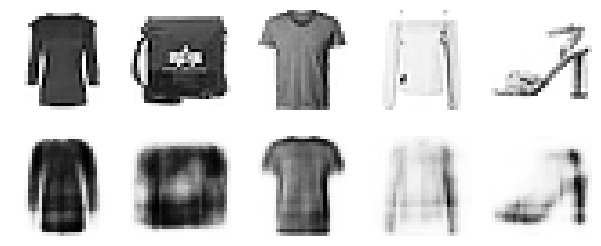

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.legacy.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

In [25]:
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10


   1/1719 [..............................] - ETA: 10:29 - loss: 0.2811 - rounded_accuracy: 0.9403

  24/1719 [..............................] - ETA: 3s - loss: 0.2895 - rounded_accuracy: 0.9326   

  47/1719 [..............................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9336

  70/1719 [>.............................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9342

  92/1719 [>.............................] - ETA: 3s - loss: 0.2830 - rounded_accuracy: 0.9345

 115/1719 [=>............................] - ETA: 3s - loss: 0.2840 - rounded_accuracy: 0.9344

 138/1719 [=>............................] - ETA: 3s - loss: 0.2846 - rounded_accuracy: 0.9340

 160/1719 [=>............................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9341

 182/1719 [==>...........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9343

 204/1719 [==>...........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9347

 227/1719 [==>...........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9345

 251/1719 [===>..........................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9344

 275/1719 [===>..........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9345

 299/1719 [====>.........................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9346

 323/1719 [====>.........................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9348

 346/1719 [=====>........................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9349

 369/1719 [=====>........................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9349

 390/1719 [=====>........................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9350

 410/1719 [======>.......................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9351

 431/1719 [======>.......................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9351

 451/1719 [======>.......................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9350

 475/1719 [=======>......................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9350

 496/1719 [=======>......................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9349

 517/1719 [========>.....................] - ETA: 2s - loss: 0.2860 - rounded_accuracy: 0.9349

 540/1719 [========>.....................] - ETA: 2s - loss: 0.2860 - rounded_accuracy: 0.9348

 563/1719 [========>.....................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9348

 585/1719 [=========>....................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9348

 607/1719 [=========>....................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9349

 630/1719 [=========>....................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9349

 651/1719 [==========>...................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9349

 673/1719 [==========>...................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9350

 694/1719 [===========>..................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9349

 715/1719 [===========>..................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9349

 737/1719 [===========>..................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9349

 758/1719 [============>.................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9348

 780/1719 [============>.................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9348

 803/1719 [=============>................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9349

 825/1719 [=============>................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9348

 847/1719 [=============>................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9348

 868/1719 [==============>...............] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9349

 890/1719 [==============>...............] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9349

 911/1719 [==============>...............] - ETA: 1s - loss: 0.2855 - rounded_accuracy: 0.9349

 932/1719 [===============>..............] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9348

 953/1719 [===============>..............] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9348

 973/1719 [===============>..............] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9349

 994/1719 [================>.............] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9349

1015/1719 [================>.............] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9350

1036/1719 [=================>............] - ETA: 1s - loss: 0.2855 - rounded_accuracy: 0.9350

1057/1719 [=================>............] - ETA: 1s - loss: 0.2855 - rounded_accuracy: 0.9350

1079/1719 [=================>............] - ETA: 1s - loss: 0.2855 - rounded_accuracy: 0.9350

1101/1719 [==================>...........] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9350

1124/1719 [==================>...........] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9350

1145/1719 [==================>...........] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9350

1166/1719 [===================>..........] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9350

1186/1719 [===================>..........] - ETA: 1s - loss: 0.2856 - rounded_accuracy: 0.9350

1209/1719 [====================>.........] - ETA: 1s - loss: 0.2857 - rounded_accuracy: 0.9350

1231/1719 [====================>.........] - ETA: 1s - loss: 0.2859 - rounded_accuracy: 0.9350

1253/1719 [====================>.........] - ETA: 1s - loss: 0.2859 - rounded_accuracy: 0.9351

1274/1719 [=====================>........] - ETA: 1s - loss: 0.2859 - rounded_accuracy: 0.9350

1293/1719 [=====================>........] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9351

1314/1719 [=====================>........] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9351

1335/1719 [======================>.......] - ETA: 0s - loss: 0.2857 - rounded_accuracy: 0.9352

1356/1719 [======================>.......] - ETA: 0s - loss: 0.2857 - rounded_accuracy: 0.9352

1377/1719 [=======================>......] - ETA: 0s - loss: 0.2856 - rounded_accuracy: 0.9352

1399/1719 [=======================>......] - ETA: 0s - loss: 0.2857 - rounded_accuracy: 0.9352

1420/1719 [=======================>......] - ETA: 0s - loss: 0.2857 - rounded_accuracy: 0.9352

1441/1719 [========================>.....] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1464/1719 [========================>.....] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1485/1719 [========================>.....] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1506/1719 [=========================>....] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1529/1719 [=========================>....] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1552/1719 [==========================>...] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1574/1719 [==========================>...] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1595/1719 [==========================>...] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9351

1615/1719 [===========================>..] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9351

1636/1719 [===========================>..] - ETA: 0s - loss: 0.2859 - rounded_accuracy: 0.9351

1656/1719 [===========================>..] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1677/1719 [============================>.] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1699/1719 [============================>.] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1718/1719 [============================>.] - ETA: 0s - loss: 0.2858 - rounded_accuracy: 0.9352

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2858 - rounded_accuracy: 0.9352 - val_loss: 0.2873 - val_rounded_accuracy: 0.9353


Epoch 2/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2838 - rounded_accuracy: 0.9410

  23/1719 [..............................] - ETA: 3s - loss: 0.2914 - rounded_accuracy: 0.9335

  41/1719 [..............................] - ETA: 4s - loss: 0.2880 - rounded_accuracy: 0.9336

  63/1719 [>.............................] - ETA: 4s - loss: 0.2860 - rounded_accuracy: 0.9347

  85/1719 [>.............................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9356

 108/1719 [>.............................] - ETA: 3s - loss: 0.2866 - rounded_accuracy: 0.9356

 132/1719 [=>............................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9357

 154/1719 [=>............................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9356

 177/1719 [==>...........................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9353

 201/1719 [==>...........................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9351

 224/1719 [==>...........................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9352

 244/1719 [===>..........................] - ETA: 3s - loss: 0.2862 - rounded_accuracy: 0.9352

 267/1719 [===>..........................] - ETA: 3s - loss: 0.2864 - rounded_accuracy: 0.9353

 288/1719 [====>.........................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9351

 309/1719 [====>.........................] - ETA: 3s - loss: 0.2867 - rounded_accuracy: 0.9350

 331/1719 [====>.........................] - ETA: 3s - loss: 0.2864 - rounded_accuracy: 0.9353

 353/1719 [=====>........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9354

 375/1719 [=====>........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9353

 397/1719 [=====>........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9352

 419/1719 [======>.......................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9352

 440/1719 [======>.......................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9352

 462/1719 [=======>......................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9353

 485/1719 [=======>......................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 508/1719 [=======>......................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9353

 529/1719 [========>.....................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9352

 551/1719 [========>.....................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9353

 574/1719 [=========>....................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9354

 598/1719 [=========>....................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 621/1719 [=========>....................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 642/1719 [==========>...................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 663/1719 [==========>...................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 684/1719 [==========>...................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9354

 706/1719 [===========>..................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9354

 727/1719 [===========>..................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 749/1719 [============>.................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 771/1719 [============>.................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9354

 792/1719 [============>.................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9355

 815/1719 [=============>................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9354

 838/1719 [=============>................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9354

 860/1719 [==============>...............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9355

 881/1719 [==============>...............] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9355

 903/1719 [==============>...............] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9355

 926/1719 [===============>..............] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9355

 949/1719 [===============>..............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9355

 972/1719 [===============>..............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9355

 994/1719 [================>.............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1016/1719 [================>.............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1039/1719 [=================>............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1062/1719 [=================>............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9355

1083/1719 [=================>............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1104/1719 [==================>...........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1126/1719 [==================>...........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9355

1147/1719 [===================>..........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1171/1719 [===================>..........] - ETA: 1s - loss: 0.2855 - rounded_accuracy: 0.9356

1195/1719 [===================>..........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1217/1719 [====================>.........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1238/1719 [====================>.........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1260/1719 [====================>.........] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9356

1282/1719 [=====================>........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1304/1719 [=====================>........] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9356

1325/1719 [======================>.......] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9356

1346/1719 [======================>.......] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9356

1370/1719 [======================>.......] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9356

1392/1719 [=======================>......] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1413/1719 [=======================>......] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9357

1436/1719 [========================>.....] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9356

1460/1719 [========================>.....] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9356

1483/1719 [========================>.....] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9356

1506/1719 [=========================>....] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9356

1528/1719 [=========================>....] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1547/1719 [=========================>....] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1570/1719 [==========================>...] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1591/1719 [==========================>...] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1614/1719 [===========================>..] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1637/1719 [===========================>..] - ETA: 0s - loss: 0.2854 - rounded_accuracy: 0.9357

1660/1719 [===========================>..] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9357

1681/1719 [============================>.] - ETA: 0s - loss: 0.2854 - rounded_accuracy: 0.9357

1702/1719 [============================>.] - ETA: 0s - loss: 0.2854 - rounded_accuracy: 0.9357

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2853 - rounded_accuracy: 0.9357 - val_loss: 0.2869 - val_rounded_accuracy: 0.9355


Epoch 3/10


   1/1719 [..............................] - ETA: 16s - loss: 0.2791 - rounded_accuracy: 0.9516

  22/1719 [..............................] - ETA: 4s - loss: 0.2859 - rounded_accuracy: 0.9374 

  42/1719 [..............................] - ETA: 4s - loss: 0.2865 - rounded_accuracy: 0.9366

  61/1719 [>.............................] - ETA: 4s - loss: 0.2844 - rounded_accuracy: 0.9372

  82/1719 [>.............................] - ETA: 4s - loss: 0.2843 - rounded_accuracy: 0.9363

 104/1719 [>.............................] - ETA: 3s - loss: 0.2834 - rounded_accuracy: 0.9366

 124/1719 [=>............................] - ETA: 3s - loss: 0.2839 - rounded_accuracy: 0.9363

 145/1719 [=>............................] - ETA: 3s - loss: 0.2839 - rounded_accuracy: 0.9363

 167/1719 [=>............................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9358

 188/1719 [==>...........................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9359

 209/1719 [==>...........................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9359

 231/1719 [===>..........................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9359

 252/1719 [===>..........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9360

 276/1719 [===>..........................] - ETA: 3s - loss: 0.2846 - rounded_accuracy: 0.9362

 298/1719 [====>.........................] - ETA: 3s - loss: 0.2845 - rounded_accuracy: 0.9362

 322/1719 [====>.........................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9361

 345/1719 [=====>........................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9362

 366/1719 [=====>........................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9362

 387/1719 [=====>........................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9361

 409/1719 [======>.......................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9363

 430/1719 [======>.......................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9362

 454/1719 [======>.......................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9362

 477/1719 [=======>......................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9361

 499/1719 [=======>......................] - ETA: 2s - loss: 0.2846 - rounded_accuracy: 0.9360

 522/1719 [========>.....................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9360

 543/1719 [========>.....................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9360

 564/1719 [========>.....................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9359

 586/1719 [=========>....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9359

 608/1719 [=========>....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9358

 632/1719 [==========>...................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9358

 655/1719 [==========>...................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9357

 679/1719 [==========>...................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9357

 701/1719 [===========>..................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9357

 722/1719 [===========>..................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9356

 743/1719 [===========>..................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9355

 764/1719 [============>.................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9355

 788/1719 [============>.................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9355

 811/1719 [=============>................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9355

 832/1719 [=============>................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9356

 853/1719 [=============>................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9356

 874/1719 [==============>...............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9357

 895/1719 [==============>...............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9357

 918/1719 [===============>..............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9357

 939/1719 [===============>..............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9357

 960/1719 [===============>..............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9357

 980/1719 [================>.............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9357

1002/1719 [================>.............] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9358

1024/1719 [================>.............] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9357

1045/1719 [=================>............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9357

1066/1719 [=================>............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1087/1719 [=================>............] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9357

1108/1719 [==================>...........] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9357

1130/1719 [==================>...........] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9357

1152/1719 [===================>..........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9357

1173/1719 [===================>..........] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9357

1194/1719 [===================>..........] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9357

1218/1719 [====================>.........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1241/1719 [====================>.........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9356

1263/1719 [=====================>........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9357

1285/1719 [=====================>........] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9357

1306/1719 [=====================>........] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9357

1327/1719 [======================>.......] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9358

1349/1719 [======================>.......] - ETA: 0s - loss: 0.2853 - rounded_accuracy: 0.9358

1370/1719 [======================>.......] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9358

1392/1719 [=======================>......] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9358

1414/1719 [=======================>......] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1437/1719 [========================>.....] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1458/1719 [========================>.....] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9358

1480/1719 [========================>.....] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9359

1503/1719 [=========================>....] - ETA: 0s - loss: 0.2852 - rounded_accuracy: 0.9359

1524/1719 [=========================>....] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1545/1719 [=========================>....] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1568/1719 [==========================>...] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1588/1719 [==========================>...] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9359

1610/1719 [===========================>..] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9360

1632/1719 [===========================>..] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9360

1654/1719 [===========================>..] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9360

1676/1719 [============================>.] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9360

1698/1719 [============================>.] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9360

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9360 - val_loss: 0.2867 - val_rounded_accuracy: 0.9357


Epoch 4/10


   1/1719 [..............................] - ETA: 7s - loss: 0.2991 - rounded_accuracy: 0.9245

  25/1719 [..............................] - ETA: 3s - loss: 0.2881 - rounded_accuracy: 0.9351

  48/1719 [..............................] - ETA: 3s - loss: 0.2839 - rounded_accuracy: 0.9359

  70/1719 [>.............................] - ETA: 3s - loss: 0.2839 - rounded_accuracy: 0.9357

  93/1719 [>.............................] - ETA: 3s - loss: 0.2840 - rounded_accuracy: 0.9354

 115/1719 [=>............................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9355

 136/1719 [=>............................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9352

 157/1719 [=>............................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9354

 175/1719 [==>...........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9357

 194/1719 [==>...........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9357

 215/1719 [==>...........................] - ETA: 3s - loss: 0.2853 - rounded_accuracy: 0.9357

 237/1719 [===>..........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9358

 260/1719 [===>..........................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9359

 280/1719 [===>..........................] - ETA: 3s - loss: 0.2852 - rounded_accuracy: 0.9361

 302/1719 [====>.........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9360

 323/1719 [====>.........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9360

 345/1719 [=====>........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9359

 366/1719 [=====>........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9359

 388/1719 [=====>........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9359

 411/1719 [======>.......................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9359

 432/1719 [======>.......................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9360

 453/1719 [======>.......................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9360

 474/1719 [=======>......................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9361

 495/1719 [=======>......................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9359

 515/1719 [=======>......................] - ETA: 2s - loss: 0.2856 - rounded_accuracy: 0.9360

 537/1719 [========>.....................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9361

 559/1719 [========>.....................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9362

 580/1719 [=========>....................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9363

 601/1719 [=========>....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9363

 621/1719 [=========>....................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9362

 643/1719 [==========>...................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9360

 665/1719 [==========>...................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9361

 687/1719 [==========>...................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9360

 708/1719 [===========>..................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9362

 730/1719 [===========>..................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9363

 751/1719 [============>.................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9362

 774/1719 [============>.................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9362

 796/1719 [============>.................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9362

 818/1719 [=============>................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9362

 839/1719 [=============>................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9362

 860/1719 [==============>...............] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9362

 883/1719 [==============>...............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9361

 906/1719 [==============>...............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9362

 927/1719 [===============>..............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9362

 947/1719 [===============>..............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9362

 968/1719 [===============>..............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9362

 988/1719 [================>.............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9363

1010/1719 [================>.............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9362

1030/1719 [================>.............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9363

1051/1719 [=================>............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1072/1719 [=================>............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9363

1093/1719 [==================>...........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1115/1719 [==================>...........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9362

1136/1719 [==================>...........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1158/1719 [===================>..........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9363

1179/1719 [===================>..........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1200/1719 [===================>..........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9363

1224/1719 [====================>.........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1245/1719 [====================>.........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1265/1719 [=====================>........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1286/1719 [=====================>........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9363

1306/1719 [=====================>........] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1324/1719 [======================>.......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1346/1719 [======================>.......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9362

1367/1719 [======================>.......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9362

1388/1719 [=======================>......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1408/1719 [=======================>......] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9363

1429/1719 [=======================>......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1448/1719 [========================>.....] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9363

1469/1719 [========================>.....] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1490/1719 [=========================>....] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1512/1719 [=========================>....] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1534/1719 [=========================>....] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9362

1555/1719 [==========================>...] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9362

1577/1719 [==========================>...] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9362

1598/1719 [==========================>...] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9362

1619/1719 [===========================>..] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9362

1641/1719 [===========================>..] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9362

1662/1719 [============================>.] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9362

1682/1719 [============================>.] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9362

1703/1719 [============================>.] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9362

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2848 - rounded_accuracy: 0.9362 - val_loss: 0.2865 - val_rounded_accuracy: 0.9361


Epoch 5/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2845 - rounded_accuracy: 0.9438

  25/1719 [..............................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9370

  45/1719 [..............................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9366

  65/1719 [>.............................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9368

  86/1719 [>.............................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9365

 108/1719 [>.............................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9368

 131/1719 [=>............................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9364

 153/1719 [=>............................] - ETA: 3s - loss: 0.2839 - rounded_accuracy: 0.9362

 174/1719 [==>...........................] - ETA: 3s - loss: 0.2843 - rounded_accuracy: 0.9359

 196/1719 [==>...........................] - ETA: 3s - loss: 0.2842 - rounded_accuracy: 0.9359

 218/1719 [==>...........................] - ETA: 3s - loss: 0.2845 - rounded_accuracy: 0.9358

 239/1719 [===>..........................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9358

 259/1719 [===>..........................] - ETA: 3s - loss: 0.2845 - rounded_accuracy: 0.9363

 279/1719 [===>..........................] - ETA: 3s - loss: 0.2845 - rounded_accuracy: 0.9363

 300/1719 [====>.........................] - ETA: 3s - loss: 0.2847 - rounded_accuracy: 0.9365

 321/1719 [====>.........................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9365

 343/1719 [====>.........................] - ETA: 3s - loss: 0.2848 - rounded_accuracy: 0.9364

 365/1719 [=====>........................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9364

 386/1719 [=====>........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9362

 407/1719 [======>.......................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9364

 428/1719 [======>.......................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9364

 449/1719 [======>.......................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9363

 471/1719 [=======>......................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9363

 494/1719 [=======>......................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9363

 515/1719 [=======>......................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9364

 538/1719 [========>.....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9365

 560/1719 [========>.....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9364

 582/1719 [=========>....................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9365

 604/1719 [=========>....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9364

 627/1719 [=========>....................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9365

 649/1719 [==========>...................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9365

 668/1719 [==========>...................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9365

 691/1719 [===========>..................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9364

 712/1719 [===========>..................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 735/1719 [===========>..................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9366

 756/1719 [============>.................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 777/1719 [============>.................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 798/1719 [============>.................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 819/1719 [=============>................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9365

 842/1719 [=============>................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9364

 863/1719 [==============>...............] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9364

 884/1719 [==============>...............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

 905/1719 [==============>...............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9365

 926/1719 [===============>..............] - ETA: 1s - loss: 0.2845 - rounded_accuracy: 0.9365

 947/1719 [===============>..............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

 968/1719 [===============>..............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

 989/1719 [================>.............] - ETA: 1s - loss: 0.2845 - rounded_accuracy: 0.9366

1012/1719 [================>.............] - ETA: 1s - loss: 0.2845 - rounded_accuracy: 0.9366

1033/1719 [=================>............] - ETA: 1s - loss: 0.2844 - rounded_accuracy: 0.9367

1052/1719 [=================>............] - ETA: 1s - loss: 0.2844 - rounded_accuracy: 0.9367

1073/1719 [=================>............] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1094/1719 [==================>...........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1115/1719 [==================>...........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1136/1719 [==================>...........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1158/1719 [===================>..........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1179/1719 [===================>..........] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1201/1719 [===================>..........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1221/1719 [====================>.........] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9368

1244/1719 [====================>.........] - ETA: 1s - loss: 0.2844 - rounded_accuracy: 0.9367

1266/1719 [=====================>........] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1288/1719 [=====================>........] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1308/1719 [=====================>........] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1330/1719 [======================>.......] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9366

1350/1719 [======================>.......] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9366

1371/1719 [======================>.......] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9366

1392/1719 [=======================>......] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9366

1412/1719 [=======================>......] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1433/1719 [========================>.....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1454/1719 [========================>.....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1477/1719 [========================>.....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1498/1719 [=========================>....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1518/1719 [=========================>....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9366

1539/1719 [=========================>....] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9365

1561/1719 [==========================>...] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9365

1582/1719 [==========================>...] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9365

1603/1719 [==========================>...] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9365

1625/1719 [===========================>..] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9364

1646/1719 [===========================>..] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9364

1667/1719 [============================>.] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9364

1688/1719 [============================>.] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9364

1709/1719 [============================>.] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9364

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2846 - rounded_accuracy: 0.9364 - val_loss: 0.2864 - val_rounded_accuracy: 0.9362


Epoch 6/10


   1/1719 [..............................] - ETA: 5s - loss: 0.3017 - rounded_accuracy: 0.9345

  23/1719 [..............................] - ETA: 3s - loss: 0.2827 - rounded_accuracy: 0.9381

  45/1719 [..............................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9373

  66/1719 [>.............................] - ETA: 3s - loss: 0.2883 - rounded_accuracy: 0.9365

  87/1719 [>.............................] - ETA: 3s - loss: 0.2891 - rounded_accuracy: 0.9361

 108/1719 [>.............................] - ETA: 3s - loss: 0.2884 - rounded_accuracy: 0.9362

 129/1719 [=>............................] - ETA: 3s - loss: 0.2876 - rounded_accuracy: 0.9363

 150/1719 [=>............................] - ETA: 3s - loss: 0.2880 - rounded_accuracy: 0.9357

 172/1719 [==>...........................] - ETA: 3s - loss: 0.2867 - rounded_accuracy: 0.9360

 195/1719 [==>...........................] - ETA: 3s - loss: 0.2870 - rounded_accuracy: 0.9359

 216/1719 [==>...........................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9358

 237/1719 [===>..........................] - ETA: 3s - loss: 0.2863 - rounded_accuracy: 0.9359

 259/1719 [===>..........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9361

 279/1719 [===>..........................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9361

 303/1719 [====>.........................] - ETA: 3s - loss: 0.2863 - rounded_accuracy: 0.9361

 326/1719 [====>.........................] - ETA: 3s - loss: 0.2863 - rounded_accuracy: 0.9362

 348/1719 [=====>........................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9359

 371/1719 [=====>........................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9360

 392/1719 [=====>........................] - ETA: 3s - loss: 0.2865 - rounded_accuracy: 0.9361

 413/1719 [======>.......................] - ETA: 3s - loss: 0.2866 - rounded_accuracy: 0.9361

 435/1719 [======>.......................] - ETA: 3s - loss: 0.2867 - rounded_accuracy: 0.9362

 456/1719 [======>.......................] - ETA: 2s - loss: 0.2863 - rounded_accuracy: 0.9363

 478/1719 [=======>......................] - ETA: 2s - loss: 0.2865 - rounded_accuracy: 0.9362

 500/1719 [=======>......................] - ETA: 2s - loss: 0.2864 - rounded_accuracy: 0.9362

 524/1719 [========>.....................] - ETA: 2s - loss: 0.2864 - rounded_accuracy: 0.9362

 545/1719 [========>.....................] - ETA: 2s - loss: 0.2863 - rounded_accuracy: 0.9362

 566/1719 [========>.....................] - ETA: 2s - loss: 0.2860 - rounded_accuracy: 0.9363

 587/1719 [=========>....................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9363

 607/1719 [=========>....................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9363

 629/1719 [=========>....................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9362

 653/1719 [==========>...................] - ETA: 2s - loss: 0.2858 - rounded_accuracy: 0.9363

 675/1719 [==========>...................] - ETA: 2s - loss: 0.2859 - rounded_accuracy: 0.9363

 696/1719 [===========>..................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9363

 720/1719 [===========>..................] - ETA: 2s - loss: 0.2855 - rounded_accuracy: 0.9364

 741/1719 [===========>..................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9363

 762/1719 [============>.................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9363

 786/1719 [============>.................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9363

 809/1719 [=============>................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9362

 831/1719 [=============>................] - ETA: 2s - loss: 0.2857 - rounded_accuracy: 0.9363

 854/1719 [=============>................] - ETA: 2s - loss: 0.2854 - rounded_accuracy: 0.9364

 876/1719 [==============>...............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

 900/1719 [==============>...............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

 923/1719 [===============>..............] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9364

 947/1719 [===============>..............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9363

 970/1719 [===============>..............] - ETA: 1s - loss: 0.2853 - rounded_accuracy: 0.9363

 991/1719 [================>.............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

1009/1719 [================>.............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

1028/1719 [================>.............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

1049/1719 [=================>............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9363

1070/1719 [=================>............] - ETA: 1s - loss: 0.2854 - rounded_accuracy: 0.9362

1091/1719 [==================>...........] - ETA: 1s - loss: 0.2852 - rounded_accuracy: 0.9363

1112/1719 [==================>...........] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9363

1132/1719 [==================>...........] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9363

1154/1719 [===================>..........] - ETA: 1s - loss: 0.2851 - rounded_accuracy: 0.9363

1175/1719 [===================>..........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9363

1196/1719 [===================>..........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9364

1218/1719 [====================>.........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9364

1241/1719 [====================>.........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9364

1263/1719 [=====================>........] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9364

1284/1719 [=====================>........] - ETA: 1s - loss: 0.2850 - rounded_accuracy: 0.9364

1305/1719 [=====================>........] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9364

1327/1719 [======================>.......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9364

1350/1719 [======================>.......] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9363

1371/1719 [======================>.......] - ETA: 0s - loss: 0.2850 - rounded_accuracy: 0.9363

1394/1719 [=======================>......] - ETA: 0s - loss: 0.2851 - rounded_accuracy: 0.9363

1414/1719 [=======================>......] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1436/1719 [========================>.....] - ETA: 0s - loss: 0.2849 - rounded_accuracy: 0.9363

1457/1719 [========================>.....] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9364

1478/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9364

1500/1719 [=========================>....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9364

1521/1719 [=========================>....] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9364

1541/1719 [=========================>....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9364

1562/1719 [==========================>...] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1584/1719 [==========================>...] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9365

1606/1719 [===========================>..] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9365

1628/1719 [===========================>..] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9365

1648/1719 [===========================>..] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9365

1669/1719 [============================>.] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9365

1693/1719 [============================>.] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9366

1716/1719 [============================>.] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9366

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2845 - rounded_accuracy: 0.9366 - val_loss: 0.2862 - val_rounded_accuracy: 0.9361


Epoch 7/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2913 - rounded_accuracy: 0.9302

  25/1719 [..............................] - ETA: 3s - loss: 0.2905 - rounded_accuracy: 0.9386

  48/1719 [..............................] - ETA: 3s - loss: 0.2883 - rounded_accuracy: 0.9373

  69/1719 [>.............................] - ETA: 3s - loss: 0.2882 - rounded_accuracy: 0.9365

  90/1719 [>.............................] - ETA: 3s - loss: 0.2880 - rounded_accuracy: 0.9357

 112/1719 [>.............................] - ETA: 3s - loss: 0.2870 - rounded_accuracy: 0.9355

 134/1719 [=>............................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9362

 155/1719 [=>............................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9364

 176/1719 [==>...........................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9360

 197/1719 [==>...........................] - ETA: 3s - loss: 0.2861 - rounded_accuracy: 0.9361

 220/1719 [==>...........................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9362

 241/1719 [===>..........................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9359

 262/1719 [===>..........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9362

 284/1719 [===>..........................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9364

 306/1719 [====>.........................] - ETA: 3s - loss: 0.2846 - rounded_accuracy: 0.9365

 328/1719 [====>.........................] - ETA: 3s - loss: 0.2844 - rounded_accuracy: 0.9366

 353/1719 [=====>........................] - ETA: 3s - loss: 0.2843 - rounded_accuracy: 0.9366

 376/1719 [=====>........................] - ETA: 3s - loss: 0.2840 - rounded_accuracy: 0.9367

 399/1719 [=====>........................] - ETA: 3s - loss: 0.2840 - rounded_accuracy: 0.9367

 419/1719 [======>.......................] - ETA: 3s - loss: 0.2843 - rounded_accuracy: 0.9366

 442/1719 [======>.......................] - ETA: 2s - loss: 0.2843 - rounded_accuracy: 0.9367

 463/1719 [=======>......................] - ETA: 2s - loss: 0.2843 - rounded_accuracy: 0.9368

 485/1719 [=======>......................] - ETA: 2s - loss: 0.2845 - rounded_accuracy: 0.9366

 506/1719 [=======>......................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9368

 528/1719 [========>.....................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9367

 552/1719 [========>.....................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9367

 572/1719 [========>.....................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9368

 591/1719 [=========>....................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9368

 612/1719 [=========>....................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9367

 633/1719 [==========>...................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9367

 655/1719 [==========>...................] - ETA: 2s - loss: 0.2843 - rounded_accuracy: 0.9367

 676/1719 [==========>...................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9366

 698/1719 [===========>..................] - ETA: 2s - loss: 0.2845 - rounded_accuracy: 0.9366

 721/1719 [===========>..................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9366

 743/1719 [===========>..................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9366

 767/1719 [============>.................] - ETA: 2s - loss: 0.2845 - rounded_accuracy: 0.9365

 789/1719 [============>.................] - ETA: 2s - loss: 0.2845 - rounded_accuracy: 0.9365

 810/1719 [=============>................] - ETA: 2s - loss: 0.2846 - rounded_accuracy: 0.9364

 832/1719 [=============>................] - ETA: 2s - loss: 0.2846 - rounded_accuracy: 0.9364

 849/1719 [=============>................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9363

 868/1719 [==============>...............] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9363

 890/1719 [==============>...............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9363

 914/1719 [==============>...............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9364

 937/1719 [===============>..............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9365

 960/1719 [===============>..............] - ETA: 1s - loss: 0.2849 - rounded_accuracy: 0.9364

 983/1719 [================>.............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1006/1719 [================>.............] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9365

1026/1719 [================>.............] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1044/1719 [=================>............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

1066/1719 [=================>............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

1089/1719 [==================>...........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9366

1112/1719 [==================>...........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1135/1719 [==================>...........] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

1157/1719 [===================>..........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1178/1719 [===================>..........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1201/1719 [===================>..........] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

1223/1719 [====================>.........] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

1245/1719 [====================>.........] - ETA: 1s - loss: 0.2848 - rounded_accuracy: 0.9365

1266/1719 [=====================>........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1289/1719 [=====================>........] - ETA: 1s - loss: 0.2847 - rounded_accuracy: 0.9365

1310/1719 [=====================>........] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9365

1333/1719 [======================>.......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1353/1719 [======================>.......] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9365

1375/1719 [======================>.......] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9365

1399/1719 [=======================>......] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1421/1719 [=======================>......] - ETA: 0s - loss: 0.2848 - rounded_accuracy: 0.9366

1443/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1464/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1484/1719 [========================>.....] - ETA: 0s - loss: 0.2847 - rounded_accuracy: 0.9365

1506/1719 [=========================>....] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9366

1528/1719 [=========================>....] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9366

1550/1719 [==========================>...] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9366

1572/1719 [==========================>...] - ETA: 0s - loss: 0.2846 - rounded_accuracy: 0.9366

1595/1719 [==========================>...] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9366

1618/1719 [===========================>..] - ETA: 0s - loss: 0.2845 - rounded_accuracy: 0.9366

1639/1719 [===========================>..] - ETA: 0s - loss: 0.2844 - rounded_accuracy: 0.9367

1660/1719 [===========================>..] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9366

1682/1719 [============================>.] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1701/1719 [============================>.] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2843 - rounded_accuracy: 0.9367 - val_loss: 0.2861 - val_rounded_accuracy: 0.9363


Epoch 8/10


   1/1719 [..............................] - ETA: 8s - loss: 0.2928 - rounded_accuracy: 0.9265

  18/1719 [..............................] - ETA: 5s - loss: 0.2783 - rounded_accuracy: 0.9393

  39/1719 [..............................] - ETA: 4s - loss: 0.2823 - rounded_accuracy: 0.9366

  61/1719 [>.............................] - ETA: 4s - loss: 0.2814 - rounded_accuracy: 0.9380

  84/1719 [>.............................] - ETA: 4s - loss: 0.2822 - rounded_accuracy: 0.9377

 107/1719 [>.............................] - ETA: 3s - loss: 0.2833 - rounded_accuracy: 0.9372

 129/1719 [=>............................] - ETA: 3s - loss: 0.2833 - rounded_accuracy: 0.9374

 151/1719 [=>............................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9373

 175/1719 [==>...........................] - ETA: 3s - loss: 0.2835 - rounded_accuracy: 0.9374

 198/1719 [==>...........................] - ETA: 3s - loss: 0.2835 - rounded_accuracy: 0.9372

 218/1719 [==>...........................] - ETA: 3s - loss: 0.2832 - rounded_accuracy: 0.9374

 239/1719 [===>..........................] - ETA: 3s - loss: 0.2830 - rounded_accuracy: 0.9373

 260/1719 [===>..........................] - ETA: 3s - loss: 0.2830 - rounded_accuracy: 0.9373

 283/1719 [===>..........................] - ETA: 3s - loss: 0.2833 - rounded_accuracy: 0.9373

 304/1719 [====>.........................] - ETA: 3s - loss: 0.2836 - rounded_accuracy: 0.9373

 325/1719 [====>.........................] - ETA: 3s - loss: 0.2835 - rounded_accuracy: 0.9372

 344/1719 [=====>........................] - ETA: 3s - loss: 0.2832 - rounded_accuracy: 0.9374

 365/1719 [=====>........................] - ETA: 3s - loss: 0.2833 - rounded_accuracy: 0.9374

 386/1719 [=====>........................] - ETA: 3s - loss: 0.2834 - rounded_accuracy: 0.9374

 410/1719 [======>.......................] - ETA: 3s - loss: 0.2836 - rounded_accuracy: 0.9372

 431/1719 [======>.......................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9371

 454/1719 [======>.......................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9372

 475/1719 [=======>......................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9372

 496/1719 [=======>......................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9371

 516/1719 [========>.....................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9371

 538/1719 [========>.....................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9371

 559/1719 [========>.....................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9370

 580/1719 [=========>....................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9369

 599/1719 [=========>....................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9369

 620/1719 [=========>....................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9369

 642/1719 [==========>...................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9369

 663/1719 [==========>...................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9369

 684/1719 [==========>...................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9369

 705/1719 [===========>..................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9368

 726/1719 [===========>..................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9367

 748/1719 [============>.................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9367

 769/1719 [============>.................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9368

 790/1719 [============>.................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9367

 813/1719 [=============>................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9367

 835/1719 [=============>................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9367

 855/1719 [=============>................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9367

 876/1719 [==============>...............] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9367

 896/1719 [==============>...............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9367

 917/1719 [===============>..............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9367

 939/1719 [===============>..............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9367

 961/1719 [===============>..............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9367

 983/1719 [================>.............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9367

1007/1719 [================>.............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9367

1031/1719 [================>.............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9367

1055/1719 [=================>............] - ETA: 1s - loss: 0.2840 - rounded_accuracy: 0.9367

1077/1719 [=================>............] - ETA: 1s - loss: 0.2840 - rounded_accuracy: 0.9367

1098/1719 [==================>...........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9367

1120/1719 [==================>...........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1141/1719 [==================>...........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9366

1161/1719 [===================>..........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9367

1184/1719 [===================>..........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1206/1719 [====================>.........] - ETA: 1s - loss: 0.2840 - rounded_accuracy: 0.9368

1229/1719 [====================>.........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9367

1253/1719 [====================>.........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9367

1276/1719 [=====================>........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1297/1719 [=====================>........] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1319/1719 [======================>.......] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1342/1719 [======================>.......] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1364/1719 [======================>.......] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9367

1385/1719 [=======================>......] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9367

1408/1719 [=======================>......] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9367

1431/1719 [=======================>......] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1452/1719 [========================>.....] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1472/1719 [========================>.....] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1494/1719 [=========================>....] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9367

1514/1719 [=========================>....] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9367

1536/1719 [=========================>....] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1558/1719 [==========================>...] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1578/1719 [==========================>...] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1600/1719 [==========================>...] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1619/1719 [===========================>..] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9367

1641/1719 [===========================>..] - ETA: 0s - loss: 0.2843 - rounded_accuracy: 0.9368

1662/1719 [============================>.] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1683/1719 [============================>.] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1703/1719 [============================>.] - ETA: 0s - loss: 0.2842 - rounded_accuracy: 0.9368

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2842 - rounded_accuracy: 0.9368 - val_loss: 0.2860 - val_rounded_accuracy: 0.9363


Epoch 9/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2636 - rounded_accuracy: 0.9484

  22/1719 [..............................] - ETA: 4s - loss: 0.2847 - rounded_accuracy: 0.9368

  43/1719 [..............................] - ETA: 4s - loss: 0.2860 - rounded_accuracy: 0.9371

  64/1719 [>.............................] - ETA: 4s - loss: 0.2882 - rounded_accuracy: 0.9362

  86/1719 [>.............................] - ETA: 3s - loss: 0.2876 - rounded_accuracy: 0.9362

 109/1719 [>.............................] - ETA: 3s - loss: 0.2868 - rounded_accuracy: 0.9364

 129/1719 [=>............................] - ETA: 3s - loss: 0.2857 - rounded_accuracy: 0.9364

 151/1719 [=>............................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9363

 171/1719 [=>............................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9363

 192/1719 [==>...........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9360

 213/1719 [==>...........................] - ETA: 3s - loss: 0.2864 - rounded_accuracy: 0.9358

 236/1719 [===>..........................] - ETA: 3s - loss: 0.2862 - rounded_accuracy: 0.9360

 259/1719 [===>..........................] - ETA: 3s - loss: 0.2861 - rounded_accuracy: 0.9359

 280/1719 [===>..........................] - ETA: 3s - loss: 0.2861 - rounded_accuracy: 0.9360

 301/1719 [====>.........................] - ETA: 3s - loss: 0.2859 - rounded_accuracy: 0.9360

 324/1719 [====>.........................] - ETA: 3s - loss: 0.2858 - rounded_accuracy: 0.9360

 346/1719 [=====>........................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9361

 364/1719 [=====>........................] - ETA: 3s - loss: 0.2855 - rounded_accuracy: 0.9362

 383/1719 [=====>........................] - ETA: 3s - loss: 0.2854 - rounded_accuracy: 0.9364

 404/1719 [======>.......................] - ETA: 3s - loss: 0.2852 - rounded_accuracy: 0.9364

 425/1719 [======>.......................] - ETA: 3s - loss: 0.2851 - rounded_accuracy: 0.9365

 447/1719 [======>.......................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9367

 469/1719 [=======>......................] - ETA: 3s - loss: 0.2850 - rounded_accuracy: 0.9366

 489/1719 [=======>......................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9367

 512/1719 [=======>......................] - ETA: 2s - loss: 0.2853 - rounded_accuracy: 0.9366

 533/1719 [========>.....................] - ETA: 2s - loss: 0.2852 - rounded_accuracy: 0.9366

 553/1719 [========>.....................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9366

 571/1719 [========>.....................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9366

 591/1719 [=========>....................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9365

 613/1719 [=========>....................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9365

 636/1719 [==========>...................] - ETA: 2s - loss: 0.2851 - rounded_accuracy: 0.9365

 658/1719 [==========>...................] - ETA: 2s - loss: 0.2850 - rounded_accuracy: 0.9365

 678/1719 [==========>...................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9366

 698/1719 [===========>..................] - ETA: 2s - loss: 0.2849 - rounded_accuracy: 0.9365

 718/1719 [===========>..................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9366

 739/1719 [===========>..................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9366

 760/1719 [============>.................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 782/1719 [============>.................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9366

 805/1719 [=============>................] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 828/1719 [=============>................] - ETA: 2s - loss: 0.2848 - rounded_accuracy: 0.9366

 849/1719 [=============>................] - ETA: 2s - loss: 0.2846 - rounded_accuracy: 0.9366

 870/1719 [==============>...............] - ETA: 2s - loss: 0.2847 - rounded_accuracy: 0.9365

 892/1719 [==============>...............] - ETA: 1s - loss: 0.2846 - rounded_accuracy: 0.9366

 915/1719 [==============>...............] - ETA: 1s - loss: 0.2845 - rounded_accuracy: 0.9366

 935/1719 [===============>..............] - ETA: 1s - loss: 0.2844 - rounded_accuracy: 0.9367

 957/1719 [===============>..............] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

 980/1719 [================>.............] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1004/1719 [================>.............] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9367

1024/1719 [================>.............] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1044/1719 [=================>............] - ETA: 1s - loss: 0.2843 - rounded_accuracy: 0.9367

1065/1719 [=================>............] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1084/1719 [=================>............] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1107/1719 [==================>...........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1128/1719 [==================>...........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1150/1719 [===================>..........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1170/1719 [===================>..........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1191/1719 [===================>..........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1212/1719 [====================>.........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1234/1719 [====================>.........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1255/1719 [====================>.........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9368

1274/1719 [=====================>........] - ETA: 1s - loss: 0.2841 - rounded_accuracy: 0.9368

1297/1719 [=====================>........] - ETA: 1s - loss: 0.2842 - rounded_accuracy: 0.9369

1319/1719 [======================>.......] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1339/1719 [======================>.......] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1357/1719 [======================>.......] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9369

1375/1719 [======================>.......] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1396/1719 [=======================>......] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9369

1418/1719 [=======================>......] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9369

1436/1719 [========================>.....] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9369

1457/1719 [========================>.....] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1478/1719 [========================>.....] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1499/1719 [=========================>....] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1522/1719 [=========================>....] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1544/1719 [=========================>....] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1565/1719 [==========================>...] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1586/1719 [==========================>...] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1609/1719 [===========================>..] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9368

1630/1719 [===========================>..] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1650/1719 [===========================>..] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1670/1719 [============================>.] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1691/1719 [============================>.] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1713/1719 [============================>.] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9369

1719/1719 [==============================] - 4s 3ms/step - loss: 0.2841 - rounded_accuracy: 0.9369 - val_loss: 0.2859 - val_rounded_accuracy: 0.9364


Epoch 10/10


   1/1719 [..............................] - ETA: 7s - loss: 0.2770 - rounded_accuracy: 0.9463

  24/1719 [..............................] - ETA: 3s - loss: 0.2849 - rounded_accuracy: 0.9353

  47/1719 [..............................] - ETA: 3s - loss: 0.2860 - rounded_accuracy: 0.9361

  71/1719 [>.............................] - ETA: 3s - loss: 0.2856 - rounded_accuracy: 0.9373

  93/1719 [>.............................] - ETA: 3s - loss: 0.2836 - rounded_accuracy: 0.9377

 115/1719 [=>............................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9373

 138/1719 [=>............................] - ETA: 3s - loss: 0.2834 - rounded_accuracy: 0.9375

 161/1719 [=>............................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9373

 184/1719 [==>...........................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9372

 205/1719 [==>...........................] - ETA: 3s - loss: 0.2837 - rounded_accuracy: 0.9372

 228/1719 [==>...........................] - ETA: 3s - loss: 0.2838 - rounded_accuracy: 0.9374

 250/1719 [===>..........................] - ETA: 3s - loss: 0.2844 - rounded_accuracy: 0.9372

 274/1719 [===>..........................] - ETA: 3s - loss: 0.2844 - rounded_accuracy: 0.9372

 296/1719 [====>.........................] - ETA: 3s - loss: 0.2843 - rounded_accuracy: 0.9370

 318/1719 [====>.........................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9371

 341/1719 [====>.........................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9371

 363/1719 [=====>........................] - ETA: 3s - loss: 0.2842 - rounded_accuracy: 0.9369

 385/1719 [=====>........................] - ETA: 3s - loss: 0.2841 - rounded_accuracy: 0.9369

 406/1719 [======>.......................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9369

 427/1719 [======>.......................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9369

 446/1719 [======>.......................] - ETA: 2s - loss: 0.2843 - rounded_accuracy: 0.9368

 468/1719 [=======>......................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9368

 490/1719 [=======>......................] - ETA: 2s - loss: 0.2844 - rounded_accuracy: 0.9368

 513/1719 [=======>......................] - ETA: 2s - loss: 0.2845 - rounded_accuracy: 0.9368

 535/1719 [========>.....................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9369

 558/1719 [========>.....................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9370

 579/1719 [=========>....................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9371

 601/1719 [=========>....................] - ETA: 2s - loss: 0.2836 - rounded_accuracy: 0.9371

 623/1719 [=========>....................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9371

 644/1719 [==========>...................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9369

 666/1719 [==========>...................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9370

 689/1719 [===========>..................] - ETA: 2s - loss: 0.2842 - rounded_accuracy: 0.9369

 713/1719 [===========>..................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9370

 736/1719 [===========>..................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9370

 758/1719 [============>.................] - ETA: 2s - loss: 0.2841 - rounded_accuracy: 0.9369

 779/1719 [============>.................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9370

 799/1719 [============>.................] - ETA: 2s - loss: 0.2838 - rounded_accuracy: 0.9370

 819/1719 [=============>................] - ETA: 2s - loss: 0.2839 - rounded_accuracy: 0.9369

 841/1719 [=============>................] - ETA: 2s - loss: 0.2840 - rounded_accuracy: 0.9369

 861/1719 [==============>...............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9370

 883/1719 [==============>...............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9370

 907/1719 [==============>...............] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9370

 929/1719 [===============>..............] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

 951/1719 [===============>..............] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

 971/1719 [===============>..............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

 992/1719 [================>.............] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

1013/1719 [================>.............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1033/1719 [=================>............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1054/1719 [=================>............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1074/1719 [=================>............] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1093/1719 [==================>...........] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

1116/1719 [==================>...........] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

1139/1719 [==================>...........] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9371

1162/1719 [===================>..........] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

1184/1719 [===================>..........] - ETA: 1s - loss: 0.2837 - rounded_accuracy: 0.9370

1205/1719 [====================>.........] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9369

1228/1719 [====================>.........] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9369

1250/1719 [====================>.........] - ETA: 1s - loss: 0.2839 - rounded_accuracy: 0.9370

1271/1719 [=====================>........] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1290/1719 [=====================>........] - ETA: 1s - loss: 0.2838 - rounded_accuracy: 0.9370

1313/1719 [=====================>........] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1335/1719 [======================>.......] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1358/1719 [======================>.......] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1381/1719 [=======================>......] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1403/1719 [=======================>......] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1425/1719 [=======================>......] - ETA: 0s - loss: 0.2839 - rounded_accuracy: 0.9370

1446/1719 [========================>.....] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1469/1719 [========================>.....] - ETA: 0s - loss: 0.2838 - rounded_accuracy: 0.9370

1491/1719 [=========================>....] - ETA: 0s - loss: 0.2839 - rounded_accuracy: 0.9370

1511/1719 [=========================>....] - ETA: 0s - loss: 0.2839 - rounded_accuracy: 0.9370

1533/1719 [=========================>....] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1553/1719 [==========================>...] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1575/1719 [==========================>...] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1597/1719 [==========================>...] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1618/1719 [===========================>..] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1640/1719 [===========================>..] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1663/1719 [============================>.] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1685/1719 [============================>.] - ETA: 0s - loss: 0.2841 - rounded_accuracy: 0.9370

1708/1719 [============================>.] - ETA: 0s - loss: 0.2840 - rounded_accuracy: 0.9370

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2840 - rounded_accuracy: 0.9370 - val_loss: 0.2858 - val_rounded_accuracy: 0.9369


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 61ms/step


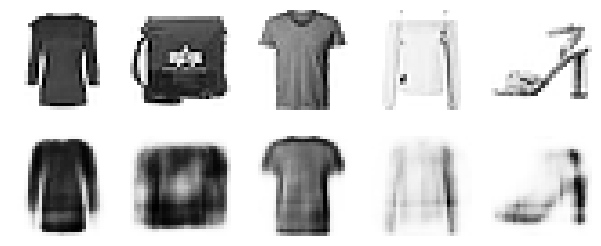

In [26]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Visualising the features

* Many ways to do this
* the simplest technique is to consider each neuron in every hidden layer, and find the training instances that activate it the most. Ok for layers close to input, but not for deep layers
* Alternatively e.g. for each neuron in the first hidden layer, you can create an image where a pixel’s intensity corresponds to the weight of the connection to the given neuron


In [27]:
stacked_ae.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential (Sequential)     (None, 30)                81530     


 sequential_1 (Sequential)   (None, 28, 28)            82284     


Total params: 163814 (639.90 KB)


Trainable params: 163814 (639.90 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [28]:
for w in stacked_ae.trainable_weights:
    print(K.eval(w).shape)

(784, 100)
(100,)
(100, 30)
(30,)
(30, 100)
(100,)
(100, 784)
(784,)


In [29]:
w = stacked_ae.trainable_weights
w0 = w[0] # Weights from first layer
w0.shape

TensorShape([784, 100])

In [30]:
w0 = tf.reshape(w0, [100, 784])
w0

<tf.Tensor: shape=(100, 784), dtype=float32, numpy=
array([[-0.023881  ,  0.00987931, -0.04028571, ...,  0.01349479,
         0.00445445,  0.03602773],
       [ 0.02111423, -0.04076767, -0.01987516, ..., -0.00976528,
        -0.0289662 , -0.03109019],
       [-0.02258361,  0.039319  , -0.00561018, ..., -0.05967777,
         0.01428638,  0.00396939],
       ...,
       [-0.00434501,  0.01360635, -0.05177874, ...,  0.03212816,
         0.03579177, -0.04487387],
       [-0.0186268 , -0.02908142,  0.04341421, ...,  0.02825667,
        -0.01064374,  0.0080286 ],
       [ 0.00418238, -0.03190599, -0.0053121 , ..., -0.05225816,
         0.02237959,  0.02680395]], dtype=float32)>

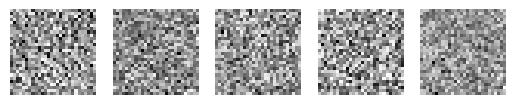

In [31]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(w0[i].numpy())

plt.show()

In [32]:
w = stacked_ae.trainable_weights
w6 = w[6] # Weights from first layer
w6.shape

TensorShape([100, 784])

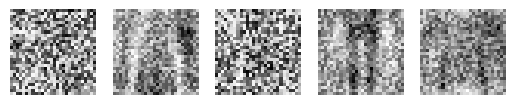

In [33]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(w6[i].numpy())

plt.show()     

## Denoising Autoencoder

* Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. 
* This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

* The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/noise.jpeg" alt="Drawing" style="width: 500px;"/>

### Gaussian Noise

Simple example (not phased training or weight matching so can use tf.keras.layers.Dense)

In [34]:
reset_state()

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.legacy.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])

In [35]:
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10


   1/1719 [..............................] - ETA: 10:57 - loss: 0.7069 - rounded_accuracy: 0.4981

  21/1719 [..............................] - ETA: 4s - loss: 0.6509 - rounded_accuracy: 0.6062   

  41/1719 [..............................] - ETA: 4s - loss: 0.5874 - rounded_accuracy: 0.6689

  61/1719 [>.............................] - ETA: 4s - loss: 0.5559 - rounded_accuracy: 0.6966

  82/1719 [>.............................] - ETA: 4s - loss: 0.5366 - rounded_accuracy: 0.7137

 103/1719 [>.............................] - ETA: 4s - loss: 0.5193 - rounded_accuracy: 0.7291

 123/1719 [=>............................] - ETA: 4s - loss: 0.5047 - rounded_accuracy: 0.7416

 140/1719 [=>............................] - ETA: 4s - loss: 0.4925 - rounded_accuracy: 0.7517

 160/1719 [=>............................] - ETA: 4s - loss: 0.4808 - rounded_accuracy: 0.7618

 181/1719 [==>...........................] - ETA: 3s - loss: 0.4696 - rounded_accuracy: 0.7715

 201/1719 [==>...........................] - ETA: 3s - loss: 0.4611 - rounded_accuracy: 0.7795

 221/1719 [==>...........................] - ETA: 3s - loss: 0.4526 - rounded_accuracy: 0.7862

 241/1719 [===>..........................] - ETA: 3s - loss: 0.4459 - rounded_accuracy: 0.7917

 261/1719 [===>..........................] - ETA: 3s - loss: 0.4408 - rounded_accuracy: 0.7966

 282/1719 [===>..........................] - ETA: 3s - loss: 0.4355 - rounded_accuracy: 0.8011

 302/1719 [====>.........................] - ETA: 3s - loss: 0.4305 - rounded_accuracy: 0.8055

 322/1719 [====>.........................] - ETA: 3s - loss: 0.4266 - rounded_accuracy: 0.8091

 343/1719 [====>.........................] - ETA: 3s - loss: 0.4229 - rounded_accuracy: 0.8127

 363/1719 [=====>........................] - ETA: 3s - loss: 0.4195 - rounded_accuracy: 0.8157

 382/1719 [=====>........................] - ETA: 3s - loss: 0.4167 - rounded_accuracy: 0.8183

 403/1719 [======>.......................] - ETA: 3s - loss: 0.4138 - rounded_accuracy: 0.8211

 424/1719 [======>.......................] - ETA: 3s - loss: 0.4110 - rounded_accuracy: 0.8236

 444/1719 [======>.......................] - ETA: 3s - loss: 0.4085 - rounded_accuracy: 0.8258

 464/1719 [=======>......................] - ETA: 3s - loss: 0.4064 - rounded_accuracy: 0.8278

 485/1719 [=======>......................] - ETA: 3s - loss: 0.4044 - rounded_accuracy: 0.8297

 506/1719 [=======>......................] - ETA: 3s - loss: 0.4021 - rounded_accuracy: 0.8317

 527/1719 [========>.....................] - ETA: 3s - loss: 0.4001 - rounded_accuracy: 0.8335

 546/1719 [========>.....................] - ETA: 2s - loss: 0.3984 - rounded_accuracy: 0.8351

 566/1719 [========>.....................] - ETA: 2s - loss: 0.3964 - rounded_accuracy: 0.8366

 585/1719 [=========>....................] - ETA: 2s - loss: 0.3947 - rounded_accuracy: 0.8380

 605/1719 [=========>....................] - ETA: 2s - loss: 0.3931 - rounded_accuracy: 0.8395

 625/1719 [=========>....................] - ETA: 2s - loss: 0.3915 - rounded_accuracy: 0.8409

 646/1719 [==========>...................] - ETA: 2s - loss: 0.3900 - rounded_accuracy: 0.8422

 667/1719 [==========>...................] - ETA: 2s - loss: 0.3883 - rounded_accuracy: 0.8436

 687/1719 [==========>...................] - ETA: 2s - loss: 0.3868 - rounded_accuracy: 0.8449

 707/1719 [===========>..................] - ETA: 2s - loss: 0.3855 - rounded_accuracy: 0.8459

 728/1719 [===========>..................] - ETA: 2s - loss: 0.3839 - rounded_accuracy: 0.8472

 748/1719 [============>.................] - ETA: 2s - loss: 0.3827 - rounded_accuracy: 0.8482

 769/1719 [============>.................] - ETA: 2s - loss: 0.3814 - rounded_accuracy: 0.8494

 789/1719 [============>.................] - ETA: 2s - loss: 0.3802 - rounded_accuracy: 0.8504

 809/1719 [=============>................] - ETA: 2s - loss: 0.3790 - rounded_accuracy: 0.8513

 830/1719 [=============>................] - ETA: 2s - loss: 0.3781 - rounded_accuracy: 0.8522

 851/1719 [=============>................] - ETA: 2s - loss: 0.3769 - rounded_accuracy: 0.8532

 871/1719 [==============>...............] - ETA: 2s - loss: 0.3759 - rounded_accuracy: 0.8542

 891/1719 [==============>...............] - ETA: 2s - loss: 0.3748 - rounded_accuracy: 0.8551

 912/1719 [==============>...............] - ETA: 2s - loss: 0.3737 - rounded_accuracy: 0.8561

 933/1719 [===============>..............] - ETA: 1s - loss: 0.3728 - rounded_accuracy: 0.8568

 952/1719 [===============>..............] - ETA: 1s - loss: 0.3719 - rounded_accuracy: 0.8576

 972/1719 [===============>..............] - ETA: 1s - loss: 0.3711 - rounded_accuracy: 0.8584

 992/1719 [================>.............] - ETA: 1s - loss: 0.3702 - rounded_accuracy: 0.8592

1011/1719 [================>.............] - ETA: 1s - loss: 0.3693 - rounded_accuracy: 0.8601

1031/1719 [================>.............] - ETA: 1s - loss: 0.3684 - rounded_accuracy: 0.8609

1051/1719 [=================>............] - ETA: 1s - loss: 0.3676 - rounded_accuracy: 0.8615

1071/1719 [=================>............] - ETA: 1s - loss: 0.3667 - rounded_accuracy: 0.8622

1090/1719 [==================>...........] - ETA: 1s - loss: 0.3661 - rounded_accuracy: 0.8629

1111/1719 [==================>...........] - ETA: 1s - loss: 0.3655 - rounded_accuracy: 0.8635

1132/1719 [==================>...........] - ETA: 1s - loss: 0.3646 - rounded_accuracy: 0.8642

1152/1719 [===================>..........] - ETA: 1s - loss: 0.3640 - rounded_accuracy: 0.8648

1173/1719 [===================>..........] - ETA: 1s - loss: 0.3632 - rounded_accuracy: 0.8655

1194/1719 [===================>..........] - ETA: 1s - loss: 0.3625 - rounded_accuracy: 0.8661

1216/1719 [====================>.........] - ETA: 1s - loss: 0.3620 - rounded_accuracy: 0.8667

1237/1719 [====================>.........] - ETA: 1s - loss: 0.3615 - rounded_accuracy: 0.8672

1258/1719 [====================>.........] - ETA: 1s - loss: 0.3607 - rounded_accuracy: 0.8679

1279/1719 [=====================>........] - ETA: 1s - loss: 0.3601 - rounded_accuracy: 0.8684

1300/1719 [=====================>........] - ETA: 1s - loss: 0.3594 - rounded_accuracy: 0.8690

1320/1719 [======================>.......] - ETA: 1s - loss: 0.3588 - rounded_accuracy: 0.8695

1339/1719 [======================>.......] - ETA: 0s - loss: 0.3582 - rounded_accuracy: 0.8700

1358/1719 [======================>.......] - ETA: 0s - loss: 0.3577 - rounded_accuracy: 0.8705

1379/1719 [=======================>......] - ETA: 0s - loss: 0.3571 - rounded_accuracy: 0.8710

1400/1719 [=======================>......] - ETA: 0s - loss: 0.3566 - rounded_accuracy: 0.8714

1420/1719 [=======================>......] - ETA: 0s - loss: 0.3561 - rounded_accuracy: 0.8718

1440/1719 [========================>.....] - ETA: 0s - loss: 0.3556 - rounded_accuracy: 0.8723

1460/1719 [========================>.....] - ETA: 0s - loss: 0.3552 - rounded_accuracy: 0.8727

1482/1719 [========================>.....] - ETA: 0s - loss: 0.3547 - rounded_accuracy: 0.8731

1503/1719 [=========================>....] - ETA: 0s - loss: 0.3542 - rounded_accuracy: 0.8736

1524/1719 [=========================>....] - ETA: 0s - loss: 0.3537 - rounded_accuracy: 0.8740

1545/1719 [=========================>....] - ETA: 0s - loss: 0.3532 - rounded_accuracy: 0.8744

1566/1719 [==========================>...] - ETA: 0s - loss: 0.3528 - rounded_accuracy: 0.8748

1587/1719 [==========================>...] - ETA: 0s - loss: 0.3523 - rounded_accuracy: 0.8751

1607/1719 [===========================>..] - ETA: 0s - loss: 0.3519 - rounded_accuracy: 0.8755

1628/1719 [===========================>..] - ETA: 0s - loss: 0.3516 - rounded_accuracy: 0.8758

1647/1719 [===========================>..] - ETA: 0s - loss: 0.3511 - rounded_accuracy: 0.8762

1668/1719 [============================>.] - ETA: 0s - loss: 0.3507 - rounded_accuracy: 0.8766

1689/1719 [============================>.] - ETA: 0s - loss: 0.3503 - rounded_accuracy: 0.8769

1709/1719 [============================>.] - ETA: 0s - loss: 0.3499 - rounded_accuracy: 0.8772

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3497 - rounded_accuracy: 0.8774 - val_loss: 0.3180 - val_rounded_accuracy: 0.9070


Epoch 2/10


   1/1719 [..............................] - ETA: 5s - loss: 0.3186 - rounded_accuracy: 0.9120

  21/1719 [..............................] - ETA: 4s - loss: 0.3273 - rounded_accuracy: 0.9019

  41/1719 [..............................] - ETA: 4s - loss: 0.3207 - rounded_accuracy: 0.9018

  61/1719 [>.............................] - ETA: 4s - loss: 0.3190 - rounded_accuracy: 0.9030

  81/1719 [>.............................] - ETA: 4s - loss: 0.3171 - rounded_accuracy: 0.9050

 101/1719 [>.............................] - ETA: 4s - loss: 0.3177 - rounded_accuracy: 0.9054

 122/1719 [=>............................] - ETA: 4s - loss: 0.3173 - rounded_accuracy: 0.9050

 142/1719 [=>............................] - ETA: 4s - loss: 0.3162 - rounded_accuracy: 0.9056

 162/1719 [=>............................] - ETA: 3s - loss: 0.3170 - rounded_accuracy: 0.9053

 182/1719 [==>...........................] - ETA: 3s - loss: 0.3173 - rounded_accuracy: 0.9055

 203/1719 [==>...........................] - ETA: 3s - loss: 0.3166 - rounded_accuracy: 0.9055

 223/1719 [==>...........................] - ETA: 3s - loss: 0.3170 - rounded_accuracy: 0.9057

 241/1719 [===>..........................] - ETA: 3s - loss: 0.3172 - rounded_accuracy: 0.9057

 261/1719 [===>..........................] - ETA: 3s - loss: 0.3174 - rounded_accuracy: 0.9058

 280/1719 [===>..........................] - ETA: 3s - loss: 0.3176 - rounded_accuracy: 0.9057

 301/1719 [====>.........................] - ETA: 3s - loss: 0.3177 - rounded_accuracy: 0.9054

 322/1719 [====>.........................] - ETA: 3s - loss: 0.3177 - rounded_accuracy: 0.9054

 342/1719 [====>.........................] - ETA: 3s - loss: 0.3171 - rounded_accuracy: 0.9058

 362/1719 [=====>........................] - ETA: 3s - loss: 0.3167 - rounded_accuracy: 0.9059

 381/1719 [=====>........................] - ETA: 3s - loss: 0.3166 - rounded_accuracy: 0.9059

 401/1719 [=====>........................] - ETA: 3s - loss: 0.3166 - rounded_accuracy: 0.9059

 421/1719 [======>.......................] - ETA: 3s - loss: 0.3164 - rounded_accuracy: 0.9059

 441/1719 [======>.......................] - ETA: 3s - loss: 0.3163 - rounded_accuracy: 0.9060

 462/1719 [=======>......................] - ETA: 3s - loss: 0.3160 - rounded_accuracy: 0.9062

 483/1719 [=======>......................] - ETA: 3s - loss: 0.3158 - rounded_accuracy: 0.9064

 504/1719 [=======>......................] - ETA: 3s - loss: 0.3157 - rounded_accuracy: 0.9063

 524/1719 [========>.....................] - ETA: 3s - loss: 0.3158 - rounded_accuracy: 0.9062

 544/1719 [========>.....................] - ETA: 2s - loss: 0.3157 - rounded_accuracy: 0.9063

 564/1719 [========>.....................] - ETA: 2s - loss: 0.3156 - rounded_accuracy: 0.9063

 585/1719 [=========>....................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9065

 606/1719 [=========>....................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9065

 626/1719 [=========>....................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9065

 646/1719 [==========>...................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9066

 666/1719 [==========>...................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9066

 686/1719 [==========>...................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9066

 706/1719 [===========>..................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9067

 726/1719 [===========>..................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9068

 745/1719 [============>.................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9068

 766/1719 [============>.................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9068

 788/1719 [============>.................] - ETA: 2s - loss: 0.3151 - rounded_accuracy: 0.9070

 809/1719 [=============>................] - ETA: 2s - loss: 0.3150 - rounded_accuracy: 0.9070

 830/1719 [=============>................] - ETA: 2s - loss: 0.3149 - rounded_accuracy: 0.9070

 851/1719 [=============>................] - ETA: 2s - loss: 0.3149 - rounded_accuracy: 0.9070

 871/1719 [==============>...............] - ETA: 2s - loss: 0.3147 - rounded_accuracy: 0.9071

 892/1719 [==============>...............] - ETA: 2s - loss: 0.3146 - rounded_accuracy: 0.9071

 913/1719 [==============>...............] - ETA: 2s - loss: 0.3146 - rounded_accuracy: 0.9071

 934/1719 [===============>..............] - ETA: 1s - loss: 0.3146 - rounded_accuracy: 0.9072

 954/1719 [===============>..............] - ETA: 1s - loss: 0.3147 - rounded_accuracy: 0.9072

 974/1719 [===============>..............] - ETA: 1s - loss: 0.3147 - rounded_accuracy: 0.9072

 995/1719 [================>.............] - ETA: 1s - loss: 0.3146 - rounded_accuracy: 0.9074

1016/1719 [================>.............] - ETA: 1s - loss: 0.3145 - rounded_accuracy: 0.9075

1036/1719 [=================>............] - ETA: 1s - loss: 0.3145 - rounded_accuracy: 0.9075

1057/1719 [=================>............] - ETA: 1s - loss: 0.3145 - rounded_accuracy: 0.9075

1077/1719 [=================>............] - ETA: 1s - loss: 0.3145 - rounded_accuracy: 0.9075

1098/1719 [==================>...........] - ETA: 1s - loss: 0.3145 - rounded_accuracy: 0.9076

1118/1719 [==================>...........] - ETA: 1s - loss: 0.3144 - rounded_accuracy: 0.9076

1139/1719 [==================>...........] - ETA: 1s - loss: 0.3144 - rounded_accuracy: 0.9076

1160/1719 [===================>..........] - ETA: 1s - loss: 0.3142 - rounded_accuracy: 0.9077

1181/1719 [===================>..........] - ETA: 1s - loss: 0.3143 - rounded_accuracy: 0.9078

1202/1719 [===================>..........] - ETA: 1s - loss: 0.3142 - rounded_accuracy: 0.9078

1224/1719 [====================>.........] - ETA: 1s - loss: 0.3141 - rounded_accuracy: 0.9079

1245/1719 [====================>.........] - ETA: 1s - loss: 0.3141 - rounded_accuracy: 0.9079

1266/1719 [=====================>........] - ETA: 1s - loss: 0.3140 - rounded_accuracy: 0.9080

1287/1719 [=====================>........] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9080

1309/1719 [=====================>........] - ETA: 1s - loss: 0.3138 - rounded_accuracy: 0.9081

1330/1719 [======================>.......] - ETA: 0s - loss: 0.3137 - rounded_accuracy: 0.9081

1351/1719 [======================>.......] - ETA: 0s - loss: 0.3136 - rounded_accuracy: 0.9081

1371/1719 [======================>.......] - ETA: 0s - loss: 0.3136 - rounded_accuracy: 0.9082

1392/1719 [=======================>......] - ETA: 0s - loss: 0.3136 - rounded_accuracy: 0.9083

1412/1719 [=======================>......] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9084

1433/1719 [========================>.....] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9083

1453/1719 [========================>.....] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9084

1474/1719 [========================>.....] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9084

1494/1719 [=========================>....] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9085

1515/1719 [=========================>....] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9085

1536/1719 [=========================>....] - ETA: 0s - loss: 0.3133 - rounded_accuracy: 0.9086

1557/1719 [==========================>...] - ETA: 0s - loss: 0.3132 - rounded_accuracy: 0.9087

1578/1719 [==========================>...] - ETA: 0s - loss: 0.3133 - rounded_accuracy: 0.9087

1599/1719 [==========================>...] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9087

1620/1719 [===========================>..] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9088

1640/1719 [===========================>..] - ETA: 0s - loss: 0.3132 - rounded_accuracy: 0.9088

1659/1719 [===========================>..] - ETA: 0s - loss: 0.3130 - rounded_accuracy: 0.9089

1680/1719 [============================>.] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9089

1700/1719 [============================>.] - ETA: 0s - loss: 0.3130 - rounded_accuracy: 0.9089

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3129 - rounded_accuracy: 0.9090 - val_loss: 0.3086 - val_rounded_accuracy: 0.9144


Epoch 3/10


   1/1719 [..............................] - ETA: 8s - loss: 0.2983 - rounded_accuracy: 0.9311

  22/1719 [..............................] - ETA: 4s - loss: 0.3099 - rounded_accuracy: 0.9133

  41/1719 [..............................] - ETA: 4s - loss: 0.3107 - rounded_accuracy: 0.9124

  61/1719 [>.............................] - ETA: 4s - loss: 0.3081 - rounded_accuracy: 0.9135

  82/1719 [>.............................] - ETA: 4s - loss: 0.3077 - rounded_accuracy: 0.9130

 102/1719 [>.............................] - ETA: 4s - loss: 0.3063 - rounded_accuracy: 0.9137

 122/1719 [=>............................] - ETA: 4s - loss: 0.3072 - rounded_accuracy: 0.9133

 143/1719 [=>............................] - ETA: 3s - loss: 0.3070 - rounded_accuracy: 0.9133

 163/1719 [=>............................] - ETA: 3s - loss: 0.3079 - rounded_accuracy: 0.9128

 183/1719 [==>...........................] - ETA: 3s - loss: 0.3081 - rounded_accuracy: 0.9126

 203/1719 [==>...........................] - ETA: 3s - loss: 0.3083 - rounded_accuracy: 0.9127

 223/1719 [==>...........................] - ETA: 3s - loss: 0.3085 - rounded_accuracy: 0.9127

 243/1719 [===>..........................] - ETA: 3s - loss: 0.3087 - rounded_accuracy: 0.9127

 264/1719 [===>..........................] - ETA: 3s - loss: 0.3082 - rounded_accuracy: 0.9129

 284/1719 [===>..........................] - ETA: 3s - loss: 0.3078 - rounded_accuracy: 0.9130

 305/1719 [====>.........................] - ETA: 3s - loss: 0.3079 - rounded_accuracy: 0.9131

 325/1719 [====>.........................] - ETA: 3s - loss: 0.3082 - rounded_accuracy: 0.9130

 346/1719 [=====>........................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9133

 364/1719 [=====>........................] - ETA: 3s - loss: 0.3078 - rounded_accuracy: 0.9132

 383/1719 [=====>........................] - ETA: 3s - loss: 0.3078 - rounded_accuracy: 0.9131

 403/1719 [======>.......................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9133

 422/1719 [======>.......................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9134

 441/1719 [======>.......................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9134

 461/1719 [=======>......................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9133

 482/1719 [=======>......................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9133

 502/1719 [=======>......................] - ETA: 3s - loss: 0.3074 - rounded_accuracy: 0.9133

 523/1719 [========>.....................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9132

 544/1719 [========>.....................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9132

 562/1719 [========>.....................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9132

 582/1719 [=========>....................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9133

 603/1719 [=========>....................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9132

 623/1719 [=========>....................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9131

 645/1719 [==========>...................] - ETA: 2s - loss: 0.3078 - rounded_accuracy: 0.9131

 667/1719 [==========>...................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9130

 688/1719 [===========>..................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9131

 710/1719 [===========>..................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9130

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9130

 753/1719 [============>.................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9130

 773/1719 [============>.................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9130

 794/1719 [============>.................] - ETA: 2s - loss: 0.3077 - rounded_accuracy: 0.9130

 815/1719 [=============>................] - ETA: 2s - loss: 0.3074 - rounded_accuracy: 0.9131

 836/1719 [=============>................] - ETA: 2s - loss: 0.3074 - rounded_accuracy: 0.9132

 854/1719 [=============>................] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9133

 875/1719 [==============>...............] - ETA: 2s - loss: 0.3072 - rounded_accuracy: 0.9133

 896/1719 [==============>...............] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9133

 917/1719 [===============>..............] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9134

 936/1719 [===============>..............] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9135

 957/1719 [===============>..............] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9135

 978/1719 [================>.............] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9135

 998/1719 [================>.............] - ETA: 1s - loss: 0.3071 - rounded_accuracy: 0.9136

1019/1719 [================>.............] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9136

1040/1719 [=================>............] - ETA: 1s - loss: 0.3073 - rounded_accuracy: 0.9136

1061/1719 [=================>............] - ETA: 1s - loss: 0.3073 - rounded_accuracy: 0.9136

1082/1719 [=================>............] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9136

1103/1719 [==================>...........] - ETA: 1s - loss: 0.3071 - rounded_accuracy: 0.9137

1124/1719 [==================>...........] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9138

1146/1719 [===================>..........] - ETA: 1s - loss: 0.3072 - rounded_accuracy: 0.9137

1167/1719 [===================>..........] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9138

1187/1719 [===================>..........] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9138

1207/1719 [====================>.........] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9138

1228/1719 [====================>.........] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9138

1248/1719 [====================>.........] - ETA: 1s - loss: 0.3071 - rounded_accuracy: 0.9138

1268/1719 [=====================>........] - ETA: 1s - loss: 0.3071 - rounded_accuracy: 0.9139

1287/1719 [=====================>........] - ETA: 1s - loss: 0.3071 - rounded_accuracy: 0.9139

1307/1719 [=====================>........] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9140

1327/1719 [======================>.......] - ETA: 0s - loss: 0.3069 - rounded_accuracy: 0.9140

1347/1719 [======================>.......] - ETA: 0s - loss: 0.3069 - rounded_accuracy: 0.9141

1368/1719 [======================>.......] - ETA: 0s - loss: 0.3068 - rounded_accuracy: 0.9142

1388/1719 [=======================>......] - ETA: 0s - loss: 0.3068 - rounded_accuracy: 0.9142

1409/1719 [=======================>......] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9142

1430/1719 [=======================>......] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9142

1451/1719 [========================>.....] - ETA: 0s - loss: 0.3068 - rounded_accuracy: 0.9142

1472/1719 [========================>.....] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9143

1492/1719 [=========================>....] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9143

1513/1719 [=========================>....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9144

1534/1719 [=========================>....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9144

1555/1719 [==========================>...] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9144

1575/1719 [==========================>...] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9145

1595/1719 [==========================>...] - ETA: 0s - loss: 0.3064 - rounded_accuracy: 0.9145

1616/1719 [===========================>..] - ETA: 0s - loss: 0.3064 - rounded_accuracy: 0.9146

1636/1719 [===========================>..] - ETA: 0s - loss: 0.3063 - rounded_accuracy: 0.9146

1655/1719 [===========================>..] - ETA: 0s - loss: 0.3062 - rounded_accuracy: 0.9146

1675/1719 [============================>.] - ETA: 0s - loss: 0.3063 - rounded_accuracy: 0.9147

1695/1719 [============================>.] - ETA: 0s - loss: 0.3062 - rounded_accuracy: 0.9147

1716/1719 [============================>.] - ETA: 0s - loss: 0.3061 - rounded_accuracy: 0.9147

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3061 - rounded_accuracy: 0.9148 - val_loss: 0.3028 - val_rounded_accuracy: 0.9194


Epoch 4/10


   1/1719 [..............................] - ETA: 7s - loss: 0.3159 - rounded_accuracy: 0.9064

  22/1719 [..............................] - ETA: 4s - loss: 0.3075 - rounded_accuracy: 0.9146

  42/1719 [..............................] - ETA: 4s - loss: 0.3031 - rounded_accuracy: 0.9164

  62/1719 [>.............................] - ETA: 4s - loss: 0.3028 - rounded_accuracy: 0.9163

  82/1719 [>.............................] - ETA: 4s - loss: 0.3017 - rounded_accuracy: 0.9170

 101/1719 [>.............................] - ETA: 4s - loss: 0.3026 - rounded_accuracy: 0.9165

 121/1719 [=>............................] - ETA: 4s - loss: 0.3040 - rounded_accuracy: 0.9159

 142/1719 [=>............................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9160

 163/1719 [=>............................] - ETA: 3s - loss: 0.3035 - rounded_accuracy: 0.9161

 183/1719 [==>...........................] - ETA: 3s - loss: 0.3034 - rounded_accuracy: 0.9165

 203/1719 [==>...........................] - ETA: 3s - loss: 0.3039 - rounded_accuracy: 0.9164

 222/1719 [==>...........................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9165

 242/1719 [===>..........................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9165

 261/1719 [===>..........................] - ETA: 3s - loss: 0.3040 - rounded_accuracy: 0.9166

 281/1719 [===>..........................] - ETA: 3s - loss: 0.3037 - rounded_accuracy: 0.9168

 301/1719 [====>.........................] - ETA: 3s - loss: 0.3039 - rounded_accuracy: 0.9167

 321/1719 [====>.........................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9167

 342/1719 [====>.........................] - ETA: 3s - loss: 0.3039 - rounded_accuracy: 0.9167

 362/1719 [=====>........................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9168

 383/1719 [=====>........................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9168

 404/1719 [======>.......................] - ETA: 3s - loss: 0.3043 - rounded_accuracy: 0.9167

 425/1719 [======>.......................] - ETA: 3s - loss: 0.3044 - rounded_accuracy: 0.9168

 446/1719 [======>.......................] - ETA: 3s - loss: 0.3043 - rounded_accuracy: 0.9168

 467/1719 [=======>......................] - ETA: 3s - loss: 0.3040 - rounded_accuracy: 0.9170

 488/1719 [=======>......................] - ETA: 3s - loss: 0.3041 - rounded_accuracy: 0.9169

 508/1719 [=======>......................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9170

 528/1719 [========>.....................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9171

 549/1719 [========>.....................] - ETA: 2s - loss: 0.3034 - rounded_accuracy: 0.9173

 569/1719 [========>.....................] - ETA: 2s - loss: 0.3033 - rounded_accuracy: 0.9174

 589/1719 [=========>....................] - ETA: 2s - loss: 0.3031 - rounded_accuracy: 0.9175

 608/1719 [=========>....................] - ETA: 2s - loss: 0.3029 - rounded_accuracy: 0.9175

 629/1719 [=========>....................] - ETA: 2s - loss: 0.3028 - rounded_accuracy: 0.9174

 649/1719 [==========>...................] - ETA: 2s - loss: 0.3027 - rounded_accuracy: 0.9174

 669/1719 [==========>...................] - ETA: 2s - loss: 0.3028 - rounded_accuracy: 0.9174

 690/1719 [===========>..................] - ETA: 2s - loss: 0.3030 - rounded_accuracy: 0.9173

 711/1719 [===========>..................] - ETA: 2s - loss: 0.3030 - rounded_accuracy: 0.9174

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3028 - rounded_accuracy: 0.9175

 753/1719 [============>.................] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 774/1719 [============>.................] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 795/1719 [============>.................] - ETA: 2s - loss: 0.3027 - rounded_accuracy: 0.9176

 816/1719 [=============>................] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 836/1719 [=============>................] - ETA: 2s - loss: 0.3027 - rounded_accuracy: 0.9176

 857/1719 [=============>................] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 878/1719 [==============>...............] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 898/1719 [==============>...............] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9177

 919/1719 [===============>..............] - ETA: 2s - loss: 0.3026 - rounded_accuracy: 0.9176

 939/1719 [===============>..............] - ETA: 1s - loss: 0.3025 - rounded_accuracy: 0.9177

 959/1719 [===============>..............] - ETA: 1s - loss: 0.3024 - rounded_accuracy: 0.9178

 980/1719 [================>.............] - ETA: 1s - loss: 0.3024 - rounded_accuracy: 0.9179

1000/1719 [================>.............] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9179

1019/1719 [================>.............] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9179

1039/1719 [=================>............] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9180

1059/1719 [=================>............] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9180

1080/1719 [=================>............] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9179

1101/1719 [==================>...........] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9179

1122/1719 [==================>...........] - ETA: 1s - loss: 0.3024 - rounded_accuracy: 0.9180

1143/1719 [==================>...........] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9180

1163/1719 [===================>..........] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9180

1184/1719 [===================>..........] - ETA: 1s - loss: 0.3024 - rounded_accuracy: 0.9180

1205/1719 [====================>.........] - ETA: 1s - loss: 0.3024 - rounded_accuracy: 0.9180

1226/1719 [====================>.........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9181

1246/1719 [====================>.........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9181

1267/1719 [=====================>........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9181

1287/1719 [=====================>........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9181

1307/1719 [=====================>........] - ETA: 1s - loss: 0.3023 - rounded_accuracy: 0.9181

1328/1719 [======================>.......] - ETA: 0s - loss: 0.3023 - rounded_accuracy: 0.9181

1349/1719 [======================>.......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9181

1370/1719 [======================>.......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9181

1391/1719 [=======================>......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1412/1719 [=======================>......] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9182

1431/1719 [=======================>......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1451/1719 [========================>.....] - ETA: 0s - loss: 0.3023 - rounded_accuracy: 0.9182

1471/1719 [========================>.....] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1490/1719 [=========================>....] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1510/1719 [=========================>....] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1530/1719 [=========================>....] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1551/1719 [==========================>...] - ETA: 0s - loss: 0.3023 - rounded_accuracy: 0.9182

1572/1719 [==========================>...] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9182

1593/1719 [==========================>...] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9183

1614/1719 [===========================>..] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9183

1632/1719 [===========================>..] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9183

1652/1719 [===========================>..] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9183

1673/1719 [============================>.] - ETA: 0s - loss: 0.3019 - rounded_accuracy: 0.9183

1693/1719 [============================>.] - ETA: 0s - loss: 0.3019 - rounded_accuracy: 0.9183

1714/1719 [============================>.] - ETA: 0s - loss: 0.3018 - rounded_accuracy: 0.9184

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3018 - rounded_accuracy: 0.9184 - val_loss: 0.2993 - val_rounded_accuracy: 0.9226


Epoch 5/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2982 - rounded_accuracy: 0.9287

  19/1719 [..............................] - ETA: 4s - loss: 0.2986 - rounded_accuracy: 0.9208

  36/1719 [..............................] - ETA: 4s - loss: 0.3007 - rounded_accuracy: 0.9205

  57/1719 [..............................] - ETA: 4s - loss: 0.3003 - rounded_accuracy: 0.9207

  77/1719 [>.............................] - ETA: 4s - loss: 0.3009 - rounded_accuracy: 0.9197

  98/1719 [>.............................] - ETA: 4s - loss: 0.3002 - rounded_accuracy: 0.9203

 118/1719 [=>............................] - ETA: 4s - loss: 0.2993 - rounded_accuracy: 0.9202

 139/1719 [=>............................] - ETA: 4s - loss: 0.2998 - rounded_accuracy: 0.9200

 159/1719 [=>............................] - ETA: 4s - loss: 0.2999 - rounded_accuracy: 0.9196

 179/1719 [==>...........................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9194

 199/1719 [==>...........................] - ETA: 3s - loss: 0.2994 - rounded_accuracy: 0.9196

 219/1719 [==>...........................] - ETA: 3s - loss: 0.2999 - rounded_accuracy: 0.9193

 239/1719 [===>..........................] - ETA: 3s - loss: 0.3002 - rounded_accuracy: 0.9194

 259/1719 [===>..........................] - ETA: 3s - loss: 0.2997 - rounded_accuracy: 0.9199

 279/1719 [===>..........................] - ETA: 3s - loss: 0.2997 - rounded_accuracy: 0.9199

 300/1719 [====>.........................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9201

 320/1719 [====>.........................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9201

 341/1719 [====>.........................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9201

 362/1719 [=====>........................] - ETA: 3s - loss: 0.3002 - rounded_accuracy: 0.9200

 383/1719 [=====>........................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9200

 402/1719 [======>.......................] - ETA: 3s - loss: 0.3001 - rounded_accuracy: 0.9201

 422/1719 [======>.......................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9202

 442/1719 [======>.......................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9201

 461/1719 [=======>......................] - ETA: 3s - loss: 0.3004 - rounded_accuracy: 0.9201

 481/1719 [=======>......................] - ETA: 3s - loss: 0.3004 - rounded_accuracy: 0.9201

 501/1719 [=======>......................] - ETA: 3s - loss: 0.3001 - rounded_accuracy: 0.9201

 521/1719 [========>.....................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9203

 540/1719 [========>.....................] - ETA: 3s - loss: 0.3001 - rounded_accuracy: 0.9203

 560/1719 [========>.....................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9203

 581/1719 [=========>....................] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9204

 602/1719 [=========>....................] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9204

 620/1719 [=========>....................] - ETA: 2s - loss: 0.2999 - rounded_accuracy: 0.9204

 641/1719 [==========>...................] - ETA: 2s - loss: 0.2999 - rounded_accuracy: 0.9204

 662/1719 [==========>...................] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9204

 683/1719 [==========>...................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9204

 704/1719 [===========>..................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9204

 725/1719 [===========>..................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 746/1719 [============>.................] - ETA: 2s - loss: 0.2996 - rounded_accuracy: 0.9206

 767/1719 [============>.................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 788/1719 [============>.................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 806/1719 [=============>................] - ETA: 2s - loss: 0.2996 - rounded_accuracy: 0.9206

 827/1719 [=============>................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 847/1719 [=============>................] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 868/1719 [==============>...............] - ETA: 2s - loss: 0.2997 - rounded_accuracy: 0.9205

 887/1719 [==============>...............] - ETA: 2s - loss: 0.2995 - rounded_accuracy: 0.9206

 907/1719 [==============>...............] - ETA: 2s - loss: 0.2994 - rounded_accuracy: 0.9206

 928/1719 [===============>..............] - ETA: 2s - loss: 0.2994 - rounded_accuracy: 0.9207

 948/1719 [===============>..............] - ETA: 1s - loss: 0.2994 - rounded_accuracy: 0.9208

 969/1719 [===============>..............] - ETA: 1s - loss: 0.2994 - rounded_accuracy: 0.9208

 990/1719 [================>.............] - ETA: 1s - loss: 0.2993 - rounded_accuracy: 0.9208

1010/1719 [================>.............] - ETA: 1s - loss: 0.2993 - rounded_accuracy: 0.9208

1030/1719 [================>.............] - ETA: 1s - loss: 0.2992 - rounded_accuracy: 0.9209

1051/1719 [=================>............] - ETA: 1s - loss: 0.2992 - rounded_accuracy: 0.9208

1072/1719 [=================>............] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1092/1719 [==================>...........] - ETA: 1s - loss: 0.2989 - rounded_accuracy: 0.9209

1113/1719 [==================>...........] - ETA: 1s - loss: 0.2989 - rounded_accuracy: 0.9209

1134/1719 [==================>...........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9210

1155/1719 [===================>..........] - ETA: 1s - loss: 0.2989 - rounded_accuracy: 0.9210

1176/1719 [===================>..........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1196/1719 [===================>..........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1214/1719 [====================>.........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1235/1719 [====================>.........] - ETA: 1s - loss: 0.2991 - rounded_accuracy: 0.9209

1256/1719 [====================>.........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1276/1719 [=====================>........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1296/1719 [=====================>........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9210

1315/1719 [=====================>........] - ETA: 1s - loss: 0.2990 - rounded_accuracy: 0.9209

1333/1719 [======================>.......] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1351/1719 [======================>.......] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1370/1719 [======================>.......] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1390/1719 [=======================>......] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1410/1719 [=======================>......] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9209

1430/1719 [=======================>......] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9209

1451/1719 [========================>.....] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1472/1719 [========================>.....] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1493/1719 [=========================>....] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9209

1513/1719 [=========================>....] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1533/1719 [=========================>....] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9209

1554/1719 [==========================>...] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9208

1575/1719 [==========================>...] - ETA: 0s - loss: 0.2989 - rounded_accuracy: 0.9208

1595/1719 [==========================>...] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9208

1614/1719 [===========================>..] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9208

1634/1719 [===========================>..] - ETA: 0s - loss: 0.2991 - rounded_accuracy: 0.9208

1654/1719 [===========================>..] - ETA: 0s - loss: 0.2991 - rounded_accuracy: 0.9208

1674/1719 [============================>.] - ETA: 0s - loss: 0.2991 - rounded_accuracy: 0.9208

1694/1719 [============================>.] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9208

1714/1719 [============================>.] - ETA: 0s - loss: 0.2990 - rounded_accuracy: 0.9209

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2990 - rounded_accuracy: 0.9208 - val_loss: 0.2971 - val_rounded_accuracy: 0.9242


Epoch 6/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3146 - rounded_accuracy: 0.9224

  21/1719 [..............................] - ETA: 4s - loss: 0.2945 - rounded_accuracy: 0.9237

  42/1719 [..............................] - ETA: 4s - loss: 0.2974 - rounded_accuracy: 0.9234

  62/1719 [>.............................] - ETA: 4s - loss: 0.3012 - rounded_accuracy: 0.9220

  83/1719 [>.............................] - ETA: 4s - loss: 0.3015 - rounded_accuracy: 0.9219

 103/1719 [>.............................] - ETA: 4s - loss: 0.3016 - rounded_accuracy: 0.9216

 123/1719 [=>............................] - ETA: 4s - loss: 0.3010 - rounded_accuracy: 0.9219

 143/1719 [=>............................] - ETA: 4s - loss: 0.3015 - rounded_accuracy: 0.9212

 161/1719 [=>............................] - ETA: 4s - loss: 0.3002 - rounded_accuracy: 0.9214

 180/1719 [==>...........................] - ETA: 3s - loss: 0.2998 - rounded_accuracy: 0.9214

 196/1719 [==>...........................] - ETA: 4s - loss: 0.3001 - rounded_accuracy: 0.9214

 215/1719 [==>...........................] - ETA: 3s - loss: 0.2999 - rounded_accuracy: 0.9213

 235/1719 [===>..........................] - ETA: 3s - loss: 0.2994 - rounded_accuracy: 0.9215

 252/1719 [===>..........................] - ETA: 3s - loss: 0.2993 - rounded_accuracy: 0.9216

 271/1719 [===>..........................] - ETA: 3s - loss: 0.2988 - rounded_accuracy: 0.9217

 291/1719 [====>.........................] - ETA: 3s - loss: 0.2993 - rounded_accuracy: 0.9217

 311/1719 [====>.........................] - ETA: 3s - loss: 0.2993 - rounded_accuracy: 0.9218

 330/1719 [====>.........................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9216

 350/1719 [=====>........................] - ETA: 3s - loss: 0.3001 - rounded_accuracy: 0.9214

 370/1719 [=====>........................] - ETA: 3s - loss: 0.2999 - rounded_accuracy: 0.9215

 390/1719 [=====>........................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9217

 410/1719 [======>.......................] - ETA: 3s - loss: 0.2998 - rounded_accuracy: 0.9217

 430/1719 [======>.......................] - ETA: 3s - loss: 0.2997 - rounded_accuracy: 0.9218

 450/1719 [======>.......................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9219

 470/1719 [=======>......................] - ETA: 3s - loss: 0.2995 - rounded_accuracy: 0.9218

 489/1719 [=======>......................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9218

 510/1719 [=======>......................] - ETA: 3s - loss: 0.2995 - rounded_accuracy: 0.9219

 529/1719 [========>.....................] - ETA: 3s - loss: 0.2994 - rounded_accuracy: 0.9219

 547/1719 [========>.....................] - ETA: 3s - loss: 0.2993 - rounded_accuracy: 0.9218

 567/1719 [========>.....................] - ETA: 3s - loss: 0.2990 - rounded_accuracy: 0.9219

 587/1719 [=========>....................] - ETA: 2s - loss: 0.2988 - rounded_accuracy: 0.9219

 606/1719 [=========>....................] - ETA: 2s - loss: 0.2987 - rounded_accuracy: 0.9220

 625/1719 [=========>....................] - ETA: 2s - loss: 0.2987 - rounded_accuracy: 0.9220

 644/1719 [==========>...................] - ETA: 2s - loss: 0.2988 - rounded_accuracy: 0.9220

 663/1719 [==========>...................] - ETA: 2s - loss: 0.2988 - rounded_accuracy: 0.9219

 684/1719 [==========>...................] - ETA: 2s - loss: 0.2989 - rounded_accuracy: 0.9219

 705/1719 [===========>..................] - ETA: 2s - loss: 0.2986 - rounded_accuracy: 0.9220

 724/1719 [===========>..................] - ETA: 2s - loss: 0.2984 - rounded_accuracy: 0.9220

 744/1719 [===========>..................] - ETA: 2s - loss: 0.2984 - rounded_accuracy: 0.9220

 763/1719 [============>.................] - ETA: 2s - loss: 0.2983 - rounded_accuracy: 0.9220

 783/1719 [============>.................] - ETA: 2s - loss: 0.2983 - rounded_accuracy: 0.9220

 803/1719 [=============>................] - ETA: 2s - loss: 0.2985 - rounded_accuracy: 0.9220

 822/1719 [=============>................] - ETA: 2s - loss: 0.2986 - rounded_accuracy: 0.9220

 842/1719 [=============>................] - ETA: 2s - loss: 0.2985 - rounded_accuracy: 0.9220

 863/1719 [==============>...............] - ETA: 2s - loss: 0.2983 - rounded_accuracy: 0.9221

 882/1719 [==============>...............] - ETA: 2s - loss: 0.2983 - rounded_accuracy: 0.9220

 903/1719 [==============>...............] - ETA: 2s - loss: 0.2983 - rounded_accuracy: 0.9220

 922/1719 [===============>..............] - ETA: 2s - loss: 0.2982 - rounded_accuracy: 0.9221

 942/1719 [===============>..............] - ETA: 2s - loss: 0.2981 - rounded_accuracy: 0.9221

 963/1719 [===============>..............] - ETA: 1s - loss: 0.2982 - rounded_accuracy: 0.9221

 983/1719 [================>.............] - ETA: 1s - loss: 0.2983 - rounded_accuracy: 0.9220

1003/1719 [================>.............] - ETA: 1s - loss: 0.2983 - rounded_accuracy: 0.9220

1024/1719 [================>.............] - ETA: 1s - loss: 0.2983 - rounded_accuracy: 0.9220

1045/1719 [=================>............] - ETA: 1s - loss: 0.2982 - rounded_accuracy: 0.9220

1066/1719 [=================>............] - ETA: 1s - loss: 0.2983 - rounded_accuracy: 0.9220

1086/1719 [=================>............] - ETA: 1s - loss: 0.2981 - rounded_accuracy: 0.9220

1106/1719 [==================>...........] - ETA: 1s - loss: 0.2980 - rounded_accuracy: 0.9220

1126/1719 [==================>...........] - ETA: 1s - loss: 0.2980 - rounded_accuracy: 0.9220

1146/1719 [===================>..........] - ETA: 1s - loss: 0.2979 - rounded_accuracy: 0.9220

1166/1719 [===================>..........] - ETA: 1s - loss: 0.2979 - rounded_accuracy: 0.9221

1184/1719 [===================>..........] - ETA: 1s - loss: 0.2978 - rounded_accuracy: 0.9221

1204/1719 [====================>.........] - ETA: 1s - loss: 0.2977 - rounded_accuracy: 0.9221

1225/1719 [====================>.........] - ETA: 1s - loss: 0.2977 - rounded_accuracy: 0.9222

1246/1719 [====================>.........] - ETA: 1s - loss: 0.2976 - rounded_accuracy: 0.9222

1265/1719 [=====================>........] - ETA: 1s - loss: 0.2976 - rounded_accuracy: 0.9222

1285/1719 [=====================>........] - ETA: 1s - loss: 0.2978 - rounded_accuracy: 0.9222

1305/1719 [=====================>........] - ETA: 1s - loss: 0.2978 - rounded_accuracy: 0.9222

1324/1719 [======================>.......] - ETA: 1s - loss: 0.2977 - rounded_accuracy: 0.9222

1344/1719 [======================>.......] - ETA: 0s - loss: 0.2977 - rounded_accuracy: 0.9222

1363/1719 [======================>.......] - ETA: 0s - loss: 0.2977 - rounded_accuracy: 0.9222

1381/1719 [=======================>......] - ETA: 0s - loss: 0.2977 - rounded_accuracy: 0.9222

1401/1719 [=======================>......] - ETA: 0s - loss: 0.2977 - rounded_accuracy: 0.9222

1421/1719 [=======================>......] - ETA: 0s - loss: 0.2976 - rounded_accuracy: 0.9222

1442/1719 [========================>.....] - ETA: 0s - loss: 0.2976 - rounded_accuracy: 0.9222

1462/1719 [========================>.....] - ETA: 0s - loss: 0.2974 - rounded_accuracy: 0.9223

1481/1719 [========================>.....] - ETA: 0s - loss: 0.2974 - rounded_accuracy: 0.9223

1499/1719 [=========================>....] - ETA: 0s - loss: 0.2974 - rounded_accuracy: 0.9223

1519/1719 [=========================>....] - ETA: 0s - loss: 0.2974 - rounded_accuracy: 0.9223

1539/1719 [=========================>....] - ETA: 0s - loss: 0.2974 - rounded_accuracy: 0.9224

1559/1719 [==========================>...] - ETA: 0s - loss: 0.2973 - rounded_accuracy: 0.9224

1580/1719 [==========================>...] - ETA: 0s - loss: 0.2973 - rounded_accuracy: 0.9224

1601/1719 [==========================>...] - ETA: 0s - loss: 0.2972 - rounded_accuracy: 0.9225

1620/1719 [===========================>..] - ETA: 0s - loss: 0.2972 - rounded_accuracy: 0.9225

1641/1719 [===========================>..] - ETA: 0s - loss: 0.2972 - rounded_accuracy: 0.9225

1662/1719 [============================>.] - ETA: 0s - loss: 0.2971 - rounded_accuracy: 0.9226

1683/1719 [============================>.] - ETA: 0s - loss: 0.2971 - rounded_accuracy: 0.9226

1703/1719 [============================>.] - ETA: 0s - loss: 0.2971 - rounded_accuracy: 0.9226

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2970 - rounded_accuracy: 0.9226 - val_loss: 0.2958 - val_rounded_accuracy: 0.9269


Epoch 7/10


   1/1719 [..............................] - ETA: 7s - loss: 0.3044 - rounded_accuracy: 0.9169

  21/1719 [..............................] - ETA: 4s - loss: 0.3021 - rounded_accuracy: 0.9251

  40/1719 [..............................] - ETA: 4s - loss: 0.3002 - rounded_accuracy: 0.9254

  60/1719 [>.............................] - ETA: 4s - loss: 0.2993 - rounded_accuracy: 0.9246

  81/1719 [>.............................] - ETA: 4s - loss: 0.2998 - rounded_accuracy: 0.9229

 101/1719 [>.............................] - ETA: 4s - loss: 0.2984 - rounded_accuracy: 0.9230

 122/1719 [=>............................] - ETA: 4s - loss: 0.2975 - rounded_accuracy: 0.9231

 142/1719 [=>............................] - ETA: 3s - loss: 0.2968 - rounded_accuracy: 0.9234

 162/1719 [=>............................] - ETA: 3s - loss: 0.2972 - rounded_accuracy: 0.9233

 182/1719 [==>...........................] - ETA: 3s - loss: 0.2974 - rounded_accuracy: 0.9232

 202/1719 [==>...........................] - ETA: 3s - loss: 0.2974 - rounded_accuracy: 0.9234

 223/1719 [==>...........................] - ETA: 3s - loss: 0.2973 - rounded_accuracy: 0.9232

 244/1719 [===>..........................] - ETA: 3s - loss: 0.2975 - rounded_accuracy: 0.9228

 263/1719 [===>..........................] - ETA: 3s - loss: 0.2969 - rounded_accuracy: 0.9231

 283/1719 [===>..........................] - ETA: 3s - loss: 0.2966 - rounded_accuracy: 0.9233

 301/1719 [====>.........................] - ETA: 3s - loss: 0.2963 - rounded_accuracy: 0.9234

 321/1719 [====>.........................] - ETA: 3s - loss: 0.2960 - rounded_accuracy: 0.9234

 342/1719 [====>.........................] - ETA: 3s - loss: 0.2959 - rounded_accuracy: 0.9235

 363/1719 [=====>........................] - ETA: 3s - loss: 0.2956 - rounded_accuracy: 0.9236

 384/1719 [=====>........................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9235

 405/1719 [======>.......................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9235

 426/1719 [======>.......................] - ETA: 3s - loss: 0.2958 - rounded_accuracy: 0.9234

 446/1719 [======>.......................] - ETA: 3s - loss: 0.2957 - rounded_accuracy: 0.9235

 467/1719 [=======>......................] - ETA: 3s - loss: 0.2959 - rounded_accuracy: 0.9236

 488/1719 [=======>......................] - ETA: 3s - loss: 0.2961 - rounded_accuracy: 0.9235

 507/1719 [=======>......................] - ETA: 3s - loss: 0.2959 - rounded_accuracy: 0.9237

 528/1719 [========>.....................] - ETA: 3s - loss: 0.2958 - rounded_accuracy: 0.9237

 548/1719 [========>.....................] - ETA: 2s - loss: 0.2956 - rounded_accuracy: 0.9236

 569/1719 [========>.....................] - ETA: 2s - loss: 0.2957 - rounded_accuracy: 0.9237

 589/1719 [=========>....................] - ETA: 2s - loss: 0.2957 - rounded_accuracy: 0.9238

 609/1719 [=========>....................] - ETA: 2s - loss: 0.2956 - rounded_accuracy: 0.9238

 629/1719 [=========>....................] - ETA: 2s - loss: 0.2956 - rounded_accuracy: 0.9237

 648/1719 [==========>...................] - ETA: 2s - loss: 0.2957 - rounded_accuracy: 0.9236

 669/1719 [==========>...................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9236

 689/1719 [===========>..................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9236

 707/1719 [===========>..................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9236

 726/1719 [===========>..................] - ETA: 2s - loss: 0.2958 - rounded_accuracy: 0.9236

 745/1719 [============>.................] - ETA: 2s - loss: 0.2958 - rounded_accuracy: 0.9236

 765/1719 [============>.................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9235

 785/1719 [============>.................] - ETA: 2s - loss: 0.2959 - rounded_accuracy: 0.9235

 804/1719 [=============>................] - ETA: 2s - loss: 0.2960 - rounded_accuracy: 0.9235

 824/1719 [=============>................] - ETA: 2s - loss: 0.2961 - rounded_accuracy: 0.9234

 845/1719 [=============>................] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9234

 866/1719 [==============>...............] - ETA: 2s - loss: 0.2963 - rounded_accuracy: 0.9234

 886/1719 [==============>...............] - ETA: 2s - loss: 0.2963 - rounded_accuracy: 0.9234

 906/1719 [==============>...............] - ETA: 2s - loss: 0.2963 - rounded_accuracy: 0.9235

 927/1719 [===============>..............] - ETA: 2s - loss: 0.2962 - rounded_accuracy: 0.9235

 947/1719 [===============>..............] - ETA: 1s - loss: 0.2962 - rounded_accuracy: 0.9235

 967/1719 [===============>..............] - ETA: 1s - loss: 0.2961 - rounded_accuracy: 0.9236

 987/1719 [================>.............] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9236

1007/1719 [================>.............] - ETA: 1s - loss: 0.2962 - rounded_accuracy: 0.9235

1028/1719 [================>.............] - ETA: 1s - loss: 0.2961 - rounded_accuracy: 0.9236

1049/1719 [=================>............] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1070/1719 [=================>............] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1089/1719 [==================>...........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9237

1110/1719 [==================>...........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9236

1130/1719 [==================>...........] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1151/1719 [===================>..........] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1172/1719 [===================>..........] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1193/1719 [===================>..........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9237

1213/1719 [====================>.........] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1233/1719 [====================>.........] - ETA: 1s - loss: 0.2959 - rounded_accuracy: 0.9237

1253/1719 [====================>.........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9237

1273/1719 [=====================>........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9237

1295/1719 [=====================>........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9236

1316/1719 [=====================>........] - ETA: 1s - loss: 0.2960 - rounded_accuracy: 0.9237

1337/1719 [======================>.......] - ETA: 0s - loss: 0.2960 - rounded_accuracy: 0.9237

1358/1719 [======================>.......] - ETA: 0s - loss: 0.2960 - rounded_accuracy: 0.9237

1379/1719 [=======================>......] - ETA: 0s - loss: 0.2961 - rounded_accuracy: 0.9237

1400/1719 [=======================>......] - ETA: 0s - loss: 0.2960 - rounded_accuracy: 0.9237

1421/1719 [=======================>......] - ETA: 0s - loss: 0.2960 - rounded_accuracy: 0.9238

1442/1719 [========================>.....] - ETA: 0s - loss: 0.2959 - rounded_accuracy: 0.9238

1460/1719 [========================>.....] - ETA: 0s - loss: 0.2960 - rounded_accuracy: 0.9238

1481/1719 [========================>.....] - ETA: 0s - loss: 0.2959 - rounded_accuracy: 0.9238

1500/1719 [=========================>....] - ETA: 0s - loss: 0.2959 - rounded_accuracy: 0.9238

1520/1719 [=========================>....] - ETA: 0s - loss: 0.2959 - rounded_accuracy: 0.9238

1540/1719 [=========================>....] - ETA: 0s - loss: 0.2958 - rounded_accuracy: 0.9239

1560/1719 [==========================>...] - ETA: 0s - loss: 0.2958 - rounded_accuracy: 0.9239

1580/1719 [==========================>...] - ETA: 0s - loss: 0.2958 - rounded_accuracy: 0.9239

1600/1719 [==========================>...] - ETA: 0s - loss: 0.2957 - rounded_accuracy: 0.9239

1621/1719 [===========================>..] - ETA: 0s - loss: 0.2956 - rounded_accuracy: 0.9240

1640/1719 [===========================>..] - ETA: 0s - loss: 0.2955 - rounded_accuracy: 0.9240

1660/1719 [===========================>..] - ETA: 0s - loss: 0.2955 - rounded_accuracy: 0.9240

1679/1719 [============================>.] - ETA: 0s - loss: 0.2955 - rounded_accuracy: 0.9240

1700/1719 [============================>.] - ETA: 0s - loss: 0.2955 - rounded_accuracy: 0.9240

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2955 - rounded_accuracy: 0.9240 - val_loss: 0.2938 - val_rounded_accuracy: 0.9282


Epoch 8/10


   1/1719 [..............................] - ETA: 7s - loss: 0.3035 - rounded_accuracy: 0.9149

  21/1719 [..............................] - ETA: 4s - loss: 0.2904 - rounded_accuracy: 0.9274

  41/1719 [..............................] - ETA: 4s - loss: 0.2921 - rounded_accuracy: 0.9253

  61/1719 [>.............................] - ETA: 4s - loss: 0.2913 - rounded_accuracy: 0.9267

  81/1719 [>.............................] - ETA: 4s - loss: 0.2923 - rounded_accuracy: 0.9262

 101/1719 [>.............................] - ETA: 4s - loss: 0.2930 - rounded_accuracy: 0.9259

 121/1719 [=>............................] - ETA: 4s - loss: 0.2934 - rounded_accuracy: 0.9258

 141/1719 [=>............................] - ETA: 4s - loss: 0.2939 - rounded_accuracy: 0.9254

 161/1719 [=>............................] - ETA: 4s - loss: 0.2942 - rounded_accuracy: 0.9256

 181/1719 [==>...........................] - ETA: 3s - loss: 0.2939 - rounded_accuracy: 0.9257

 201/1719 [==>...........................] - ETA: 3s - loss: 0.2939 - rounded_accuracy: 0.9254

 222/1719 [==>...........................] - ETA: 3s - loss: 0.2937 - rounded_accuracy: 0.9256

 243/1719 [===>..........................] - ETA: 3s - loss: 0.2935 - rounded_accuracy: 0.9255

 264/1719 [===>..........................] - ETA: 3s - loss: 0.2937 - rounded_accuracy: 0.9254

 285/1719 [===>..........................] - ETA: 3s - loss: 0.2936 - rounded_accuracy: 0.9254

 305/1719 [====>.........................] - ETA: 3s - loss: 0.2938 - rounded_accuracy: 0.9255

 326/1719 [====>.........................] - ETA: 3s - loss: 0.2938 - rounded_accuracy: 0.9254

 347/1719 [=====>........................] - ETA: 3s - loss: 0.2935 - rounded_accuracy: 0.9256

 368/1719 [=====>........................] - ETA: 3s - loss: 0.2937 - rounded_accuracy: 0.9255

 387/1719 [=====>........................] - ETA: 3s - loss: 0.2937 - rounded_accuracy: 0.9255

 408/1719 [======>.......................] - ETA: 3s - loss: 0.2939 - rounded_accuracy: 0.9252

 428/1719 [======>.......................] - ETA: 3s - loss: 0.2941 - rounded_accuracy: 0.9252

 447/1719 [======>.......................] - ETA: 3s - loss: 0.2941 - rounded_accuracy: 0.9252

 467/1719 [=======>......................] - ETA: 3s - loss: 0.2940 - rounded_accuracy: 0.9253

 487/1719 [=======>......................] - ETA: 3s - loss: 0.2944 - rounded_accuracy: 0.9251

 507/1719 [=======>......................] - ETA: 3s - loss: 0.2945 - rounded_accuracy: 0.9250

 528/1719 [========>.....................] - ETA: 3s - loss: 0.2943 - rounded_accuracy: 0.9250

 548/1719 [========>.....................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9250

 568/1719 [========>.....................] - ETA: 2s - loss: 0.2943 - rounded_accuracy: 0.9249

 588/1719 [=========>....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9248

 608/1719 [=========>....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9249

 629/1719 [=========>....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9248

 649/1719 [==========>...................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9249

 670/1719 [==========>...................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9249

 689/1719 [===========>..................] - ETA: 2s - loss: 0.2943 - rounded_accuracy: 0.9249

 708/1719 [===========>..................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9248

 727/1719 [===========>..................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9248

 744/1719 [===========>..................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9248

 762/1719 [============>.................] - ETA: 2s - loss: 0.2943 - rounded_accuracy: 0.9248

 781/1719 [============>.................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9249

 801/1719 [============>.................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9249

 820/1719 [=============>................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9248

 838/1719 [=============>................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9248

 858/1719 [=============>................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9248

 878/1719 [==============>...............] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9248

 899/1719 [==============>...............] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9248

 919/1719 [===============>..............] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9248

 939/1719 [===============>..............] - ETA: 1s - loss: 0.2941 - rounded_accuracy: 0.9248

 960/1719 [===============>..............] - ETA: 1s - loss: 0.2942 - rounded_accuracy: 0.9248

 980/1719 [================>.............] - ETA: 1s - loss: 0.2942 - rounded_accuracy: 0.9248

1001/1719 [================>.............] - ETA: 1s - loss: 0.2941 - rounded_accuracy: 0.9248

1022/1719 [================>.............] - ETA: 1s - loss: 0.2941 - rounded_accuracy: 0.9248

1042/1719 [=================>............] - ETA: 1s - loss: 0.2941 - rounded_accuracy: 0.9249

1062/1719 [=================>............] - ETA: 1s - loss: 0.2942 - rounded_accuracy: 0.9248

1082/1719 [=================>............] - ETA: 1s - loss: 0.2943 - rounded_accuracy: 0.9248

1103/1719 [==================>...........] - ETA: 1s - loss: 0.2943 - rounded_accuracy: 0.9248

1124/1719 [==================>...........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9248

1143/1719 [==================>...........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9248

1163/1719 [===================>..........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9249

1184/1719 [===================>..........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9249

1204/1719 [====================>.........] - ETA: 1s - loss: 0.2943 - rounded_accuracy: 0.9250

1225/1719 [====================>.........] - ETA: 1s - loss: 0.2943 - rounded_accuracy: 0.9250

1243/1719 [====================>.........] - ETA: 1s - loss: 0.2943 - rounded_accuracy: 0.9249

1262/1719 [=====================>........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9249

1282/1719 [=====================>........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9249

1301/1719 [=====================>........] - ETA: 1s - loss: 0.2944 - rounded_accuracy: 0.9249

1321/1719 [======================>.......] - ETA: 1s - loss: 0.2945 - rounded_accuracy: 0.9249

1342/1719 [======================>.......] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1362/1719 [======================>.......] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9249

1382/1719 [=======================>......] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9249

1402/1719 [=======================>......] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9249

1423/1719 [=======================>......] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9250

1443/1719 [========================>.....] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1463/1719 [========================>.....] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9249

1483/1719 [========================>.....] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9249

1504/1719 [=========================>....] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1524/1719 [=========================>....] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9250

1544/1719 [=========================>....] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9250

1564/1719 [==========================>...] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1584/1719 [==========================>...] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1604/1719 [==========================>...] - ETA: 0s - loss: 0.2945 - rounded_accuracy: 0.9250

1624/1719 [===========================>..] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1643/1719 [===========================>..] - ETA: 0s - loss: 0.2944 - rounded_accuracy: 0.9250

1663/1719 [============================>.] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9250

1684/1719 [============================>.] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9251

1704/1719 [============================>.] - ETA: 0s - loss: 0.2943 - rounded_accuracy: 0.9251

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2943 - rounded_accuracy: 0.9251 - val_loss: 0.2939 - val_rounded_accuracy: 0.9296


Epoch 9/10


   1/1719 [..............................] - ETA: 5s - loss: 0.2764 - rounded_accuracy: 0.9357

  21/1719 [..............................] - ETA: 4s - loss: 0.2938 - rounded_accuracy: 0.9246

  41/1719 [..............................] - ETA: 4s - loss: 0.2952 - rounded_accuracy: 0.9261

  61/1719 [>.............................] - ETA: 4s - loss: 0.2974 - rounded_accuracy: 0.9249

  81/1719 [>.............................] - ETA: 4s - loss: 0.2974 - rounded_accuracy: 0.9245

 102/1719 [>.............................] - ETA: 4s - loss: 0.2963 - rounded_accuracy: 0.9250

 122/1719 [=>............................] - ETA: 4s - loss: 0.2955 - rounded_accuracy: 0.9254

 142/1719 [=>............................] - ETA: 4s - loss: 0.2954 - rounded_accuracy: 0.9253

 162/1719 [=>............................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9252

 183/1719 [==>...........................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9250

 203/1719 [==>...........................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9250

 220/1719 [==>...........................] - ETA: 3s - loss: 0.2957 - rounded_accuracy: 0.9248

 240/1719 [===>..........................] - ETA: 3s - loss: 0.2956 - rounded_accuracy: 0.9248

 260/1719 [===>..........................] - ETA: 3s - loss: 0.2956 - rounded_accuracy: 0.9247

 280/1719 [===>..........................] - ETA: 3s - loss: 0.2955 - rounded_accuracy: 0.9248

 301/1719 [====>.........................] - ETA: 3s - loss: 0.2953 - rounded_accuracy: 0.9248

 322/1719 [====>.........................] - ETA: 3s - loss: 0.2952 - rounded_accuracy: 0.9248

 342/1719 [====>.........................] - ETA: 3s - loss: 0.2950 - rounded_accuracy: 0.9249

 362/1719 [=====>........................] - ETA: 3s - loss: 0.2950 - rounded_accuracy: 0.9249

 382/1719 [=====>........................] - ETA: 3s - loss: 0.2949 - rounded_accuracy: 0.9250

 402/1719 [======>.......................] - ETA: 3s - loss: 0.2947 - rounded_accuracy: 0.9251

 422/1719 [======>.......................] - ETA: 3s - loss: 0.2945 - rounded_accuracy: 0.9252

 442/1719 [======>.......................] - ETA: 3s - loss: 0.2945 - rounded_accuracy: 0.9253

 462/1719 [=======>......................] - ETA: 3s - loss: 0.2945 - rounded_accuracy: 0.9254

 482/1719 [=======>......................] - ETA: 3s - loss: 0.2944 - rounded_accuracy: 0.9255

 502/1719 [=======>......................] - ETA: 3s - loss: 0.2947 - rounded_accuracy: 0.9255

 522/1719 [========>.....................] - ETA: 3s - loss: 0.2947 - rounded_accuracy: 0.9255

 542/1719 [========>.....................] - ETA: 2s - loss: 0.2947 - rounded_accuracy: 0.9254

 563/1719 [========>.....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9254

 583/1719 [=========>....................] - ETA: 2s - loss: 0.2945 - rounded_accuracy: 0.9254

 603/1719 [=========>....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9253

 622/1719 [=========>....................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9253

 641/1719 [==========>...................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9253

 662/1719 [==========>...................] - ETA: 2s - loss: 0.2944 - rounded_accuracy: 0.9254

 682/1719 [==========>...................] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9254

 702/1719 [===========>..................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9253

 722/1719 [===========>..................] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9254

 742/1719 [===========>..................] - ETA: 2s - loss: 0.2940 - rounded_accuracy: 0.9254

 763/1719 [============>.................] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9253

 784/1719 [============>.................] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9254

 805/1719 [=============>................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9254

 826/1719 [=============>................] - ETA: 2s - loss: 0.2942 - rounded_accuracy: 0.9254

 847/1719 [=============>................] - ETA: 2s - loss: 0.2940 - rounded_accuracy: 0.9255

 867/1719 [==============>...............] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9254

 888/1719 [==============>...............] - ETA: 2s - loss: 0.2941 - rounded_accuracy: 0.9254

 909/1719 [==============>...............] - ETA: 2s - loss: 0.2939 - rounded_accuracy: 0.9254

 929/1719 [===============>..............] - ETA: 2s - loss: 0.2937 - rounded_accuracy: 0.9255

 950/1719 [===============>..............] - ETA: 1s - loss: 0.2938 - rounded_accuracy: 0.9255

 970/1719 [===============>..............] - ETA: 1s - loss: 0.2937 - rounded_accuracy: 0.9256

 991/1719 [================>.............] - ETA: 1s - loss: 0.2936 - rounded_accuracy: 0.9256

1010/1719 [================>.............] - ETA: 1s - loss: 0.2936 - rounded_accuracy: 0.9256

1030/1719 [================>.............] - ETA: 1s - loss: 0.2936 - rounded_accuracy: 0.9256

1050/1719 [=================>............] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9257

1071/1719 [=================>............] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9258

1092/1719 [==================>...........] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9257

1112/1719 [==================>...........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9257

1132/1719 [==================>...........] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9257

1152/1719 [===================>..........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9257

1172/1719 [===================>..........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9258

1193/1719 [===================>..........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9258

1214/1719 [====================>.........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9258

1234/1719 [====================>.........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9258

1255/1719 [====================>.........] - ETA: 1s - loss: 0.2935 - rounded_accuracy: 0.9258

1276/1719 [=====================>........] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9258

1296/1719 [=====================>........] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9259

1317/1719 [=====================>........] - ETA: 1s - loss: 0.2934 - rounded_accuracy: 0.9259

1338/1719 [======================>.......] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1358/1719 [======================>.......] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1378/1719 [=======================>......] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1399/1719 [=======================>......] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1416/1719 [=======================>......] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1436/1719 [========================>.....] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1455/1719 [========================>.....] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1475/1719 [========================>.....] - ETA: 0s - loss: 0.2934 - rounded_accuracy: 0.9258

1496/1719 [=========================>....] - ETA: 0s - loss: 0.2934 - rounded_accuracy: 0.9258

1516/1719 [=========================>....] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9258

1536/1719 [=========================>....] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1556/1719 [==========================>...] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9258

1576/1719 [==========================>...] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1595/1719 [==========================>...] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1614/1719 [===========================>..] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1633/1719 [===========================>..] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1653/1719 [===========================>..] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1673/1719 [============================>.] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1693/1719 [============================>.] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9259

1712/1719 [============================>.] - ETA: 0s - loss: 0.2933 - rounded_accuracy: 0.9260

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2933 - rounded_accuracy: 0.9260 - val_loss: 0.2925 - val_rounded_accuracy: 0.9269


Epoch 10/10


   1/1719 [..............................] - ETA: 8s - loss: 0.2875 - rounded_accuracy: 0.9347

  21/1719 [..............................] - ETA: 4s - loss: 0.2947 - rounded_accuracy: 0.9257

  41/1719 [..............................] - ETA: 4s - loss: 0.2940 - rounded_accuracy: 0.9253

  61/1719 [>.............................] - ETA: 4s - loss: 0.2937 - rounded_accuracy: 0.9269

  81/1719 [>.............................] - ETA: 4s - loss: 0.2932 - rounded_accuracy: 0.9275

 101/1719 [>.............................] - ETA: 4s - loss: 0.2921 - rounded_accuracy: 0.9276

 121/1719 [=>............................] - ETA: 4s - loss: 0.2920 - rounded_accuracy: 0.9270

 141/1719 [=>............................] - ETA: 4s - loss: 0.2920 - rounded_accuracy: 0.9271

 161/1719 [=>............................] - ETA: 3s - loss: 0.2923 - rounded_accuracy: 0.9269

 182/1719 [==>...........................] - ETA: 3s - loss: 0.2925 - rounded_accuracy: 0.9269

 202/1719 [==>...........................] - ETA: 3s - loss: 0.2923 - rounded_accuracy: 0.9269

 221/1719 [==>...........................] - ETA: 3s - loss: 0.2921 - rounded_accuracy: 0.9271

 241/1719 [===>..........................] - ETA: 3s - loss: 0.2927 - rounded_accuracy: 0.9271

 262/1719 [===>..........................] - ETA: 3s - loss: 0.2930 - rounded_accuracy: 0.9269

 283/1719 [===>..........................] - ETA: 3s - loss: 0.2930 - rounded_accuracy: 0.9269

 301/1719 [====>.........................] - ETA: 3s - loss: 0.2929 - rounded_accuracy: 0.9268

 321/1719 [====>.........................] - ETA: 3s - loss: 0.2928 - rounded_accuracy: 0.9267

 341/1719 [====>.........................] - ETA: 3s - loss: 0.2927 - rounded_accuracy: 0.9267

 359/1719 [=====>........................] - ETA: 3s - loss: 0.2929 - rounded_accuracy: 0.9266

 378/1719 [=====>........................] - ETA: 3s - loss: 0.2928 - rounded_accuracy: 0.9265

 398/1719 [=====>........................] - ETA: 3s - loss: 0.2925 - rounded_accuracy: 0.9267

 417/1719 [======>.......................] - ETA: 3s - loss: 0.2929 - rounded_accuracy: 0.9264

 436/1719 [======>.......................] - ETA: 3s - loss: 0.2929 - rounded_accuracy: 0.9264

 455/1719 [======>.......................] - ETA: 3s - loss: 0.2930 - rounded_accuracy: 0.9263

 475/1719 [=======>......................] - ETA: 3s - loss: 0.2931 - rounded_accuracy: 0.9263

 495/1719 [=======>......................] - ETA: 3s - loss: 0.2931 - rounded_accuracy: 0.9263

 514/1719 [=======>......................] - ETA: 3s - loss: 0.2932 - rounded_accuracy: 0.9263

 529/1719 [========>.....................] - ETA: 3s - loss: 0.2930 - rounded_accuracy: 0.9264

 544/1719 [========>.....................] - ETA: 3s - loss: 0.2928 - rounded_accuracy: 0.9265

 564/1719 [========>.....................] - ETA: 3s - loss: 0.2925 - rounded_accuracy: 0.9266

 584/1719 [=========>....................] - ETA: 2s - loss: 0.2925 - rounded_accuracy: 0.9267

 604/1719 [=========>....................] - ETA: 2s - loss: 0.2923 - rounded_accuracy: 0.9268

 625/1719 [=========>....................] - ETA: 2s - loss: 0.2925 - rounded_accuracy: 0.9266

 645/1719 [==========>...................] - ETA: 2s - loss: 0.2927 - rounded_accuracy: 0.9265

 665/1719 [==========>...................] - ETA: 2s - loss: 0.2926 - rounded_accuracy: 0.9266

 686/1719 [==========>...................] - ETA: 2s - loss: 0.2929 - rounded_accuracy: 0.9265

 706/1719 [===========>..................] - ETA: 2s - loss: 0.2928 - rounded_accuracy: 0.9265

 727/1719 [===========>..................] - ETA: 2s - loss: 0.2928 - rounded_accuracy: 0.9265

 744/1719 [===========>..................] - ETA: 2s - loss: 0.2929 - rounded_accuracy: 0.9265

 764/1719 [============>.................] - ETA: 2s - loss: 0.2929 - rounded_accuracy: 0.9264

 784/1719 [============>.................] - ETA: 2s - loss: 0.2927 - rounded_accuracy: 0.9266

 804/1719 [=============>................] - ETA: 2s - loss: 0.2926 - rounded_accuracy: 0.9265

 824/1719 [=============>................] - ETA: 2s - loss: 0.2926 - rounded_accuracy: 0.9265

 844/1719 [=============>................] - ETA: 2s - loss: 0.2927 - rounded_accuracy: 0.9265

 864/1719 [==============>...............] - ETA: 2s - loss: 0.2926 - rounded_accuracy: 0.9266

 882/1719 [==============>...............] - ETA: 2s - loss: 0.2927 - rounded_accuracy: 0.9266

 901/1719 [==============>...............] - ETA: 2s - loss: 0.2925 - rounded_accuracy: 0.9266

 922/1719 [===============>..............] - ETA: 2s - loss: 0.2925 - rounded_accuracy: 0.9266

 942/1719 [===============>..............] - ETA: 2s - loss: 0.2923 - rounded_accuracy: 0.9266

 962/1719 [===============>..............] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

 981/1719 [================>.............] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1000/1719 [================>.............] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1020/1719 [================>.............] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1039/1719 [=================>............] - ETA: 1s - loss: 0.2925 - rounded_accuracy: 0.9267

1059/1719 [=================>............] - ETA: 1s - loss: 0.2925 - rounded_accuracy: 0.9266

1079/1719 [=================>............] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1098/1719 [==================>...........] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1117/1719 [==================>...........] - ETA: 1s - loss: 0.2923 - rounded_accuracy: 0.9267

1137/1719 [==================>...........] - ETA: 1s - loss: 0.2923 - rounded_accuracy: 0.9267

1157/1719 [===================>..........] - ETA: 1s - loss: 0.2923 - rounded_accuracy: 0.9267

1177/1719 [===================>..........] - ETA: 1s - loss: 0.2923 - rounded_accuracy: 0.9266

1197/1719 [===================>..........] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9266

1216/1719 [====================>.........] - ETA: 1s - loss: 0.2925 - rounded_accuracy: 0.9266

1236/1719 [====================>.........] - ETA: 1s - loss: 0.2925 - rounded_accuracy: 0.9266

1257/1719 [====================>.........] - ETA: 1s - loss: 0.2925 - rounded_accuracy: 0.9266

1277/1719 [=====================>........] - ETA: 1s - loss: 0.2923 - rounded_accuracy: 0.9266

1296/1719 [=====================>........] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9266

1316/1719 [=====================>........] - ETA: 1s - loss: 0.2924 - rounded_accuracy: 0.9267

1336/1719 [======================>.......] - ETA: 0s - loss: 0.2923 - rounded_accuracy: 0.9267

1357/1719 [======================>.......] - ETA: 0s - loss: 0.2923 - rounded_accuracy: 0.9267

1377/1719 [=======================>......] - ETA: 0s - loss: 0.2924 - rounded_accuracy: 0.9267

1397/1719 [=======================>......] - ETA: 0s - loss: 0.2924 - rounded_accuracy: 0.9267

1416/1719 [=======================>......] - ETA: 0s - loss: 0.2924 - rounded_accuracy: 0.9267

1437/1719 [========================>.....] - ETA: 0s - loss: 0.2924 - rounded_accuracy: 0.9267

1456/1719 [========================>.....] - ETA: 0s - loss: 0.2923 - rounded_accuracy: 0.9267

1477/1719 [========================>.....] - ETA: 0s - loss: 0.2924 - rounded_accuracy: 0.9267

1497/1719 [=========================>....] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1516/1719 [=========================>....] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1536/1719 [=========================>....] - ETA: 0s - loss: 0.2926 - rounded_accuracy: 0.9267

1557/1719 [==========================>...] - ETA: 0s - loss: 0.2926 - rounded_accuracy: 0.9267

1578/1719 [==========================>...] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1596/1719 [==========================>...] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1616/1719 [===========================>..] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1637/1719 [===========================>..] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1659/1719 [===========================>..] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1679/1719 [============================>.] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1700/1719 [============================>.] - ETA: 0s - loss: 0.2925 - rounded_accuracy: 0.9267

1719/1719 [==============================] - 5s 3ms/step - loss: 0.2925 - rounded_accuracy: 0.9267 - val_loss: 0.2913 - val_rounded_accuracy: 0.9294


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 63ms/step


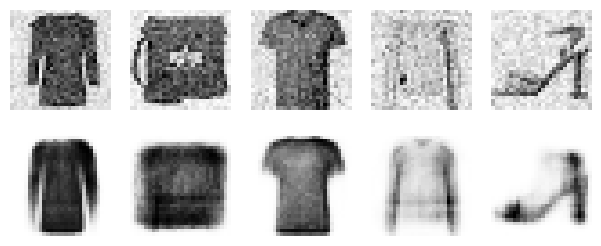

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.1)

show_reconstructions(denoising_ae, noise(X_valid, training=True).numpy())
plt.show()

### Dropout 

Simple example (not phased training or weight matching so can user tf.layers.dense)

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.legacy.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])

In [38]:
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10


   1/1719 [..............................] - ETA: 16:02 - loss: 0.7070 - rounded_accuracy: 0.5069

  21/1719 [..............................] - ETA: 4s - loss: 0.6584 - rounded_accuracy: 0.6015   

  39/1719 [..............................] - ETA: 4s - loss: 0.6002 - rounded_accuracy: 0.6586

  60/1719 [>.............................] - ETA: 4s - loss: 0.5629 - rounded_accuracy: 0.6897

  81/1719 [>.............................] - ETA: 4s - loss: 0.5423 - rounded_accuracy: 0.7067

 102/1719 [>.............................] - ETA: 4s - loss: 0.5252 - rounded_accuracy: 0.7221

 122/1719 [=>............................] - ETA: 4s - loss: 0.5112 - rounded_accuracy: 0.7348

 142/1719 [=>............................] - ETA: 4s - loss: 0.4972 - rounded_accuracy: 0.7466

 163/1719 [=>............................] - ETA: 3s - loss: 0.4848 - rounded_accuracy: 0.7571

 184/1719 [==>...........................] - ETA: 3s - loss: 0.4737 - rounded_accuracy: 0.7669

 205/1719 [==>...........................] - ETA: 3s - loss: 0.4641 - rounded_accuracy: 0.7754

 226/1719 [==>...........................] - ETA: 3s - loss: 0.4558 - rounded_accuracy: 0.7821

 247/1719 [===>..........................] - ETA: 3s - loss: 0.4495 - rounded_accuracy: 0.7875

 267/1719 [===>..........................] - ETA: 3s - loss: 0.4445 - rounded_accuracy: 0.7923

 288/1719 [====>.........................] - ETA: 3s - loss: 0.4390 - rounded_accuracy: 0.7971

 309/1719 [====>.........................] - ETA: 3s - loss: 0.4341 - rounded_accuracy: 0.8013

 329/1719 [====>.........................] - ETA: 3s - loss: 0.4303 - rounded_accuracy: 0.8048

 350/1719 [=====>........................] - ETA: 3s - loss: 0.4268 - rounded_accuracy: 0.8082

 369/1719 [=====>........................] - ETA: 3s - loss: 0.4237 - rounded_accuracy: 0.8110

 390/1719 [=====>........................] - ETA: 3s - loss: 0.4205 - rounded_accuracy: 0.8141

 410/1719 [======>.......................] - ETA: 3s - loss: 0.4176 - rounded_accuracy: 0.8167

 431/1719 [======>.......................] - ETA: 3s - loss: 0.4145 - rounded_accuracy: 0.8193

 450/1719 [======>.......................] - ETA: 3s - loss: 0.4125 - rounded_accuracy: 0.8213

 470/1719 [=======>......................] - ETA: 3s - loss: 0.4102 - rounded_accuracy: 0.8233

 491/1719 [=======>......................] - ETA: 3s - loss: 0.4081 - rounded_accuracy: 0.8252

 512/1719 [=======>......................] - ETA: 3s - loss: 0.4059 - rounded_accuracy: 0.8272

 533/1719 [========>.....................] - ETA: 2s - loss: 0.4039 - rounded_accuracy: 0.8291

 554/1719 [========>.....................] - ETA: 2s - loss: 0.4019 - rounded_accuracy: 0.8309

 575/1719 [=========>....................] - ETA: 2s - loss: 0.3999 - rounded_accuracy: 0.8326

 596/1719 [=========>....................] - ETA: 2s - loss: 0.3980 - rounded_accuracy: 0.8342

 617/1719 [=========>....................] - ETA: 2s - loss: 0.3962 - rounded_accuracy: 0.8357

 637/1719 [==========>...................] - ETA: 2s - loss: 0.3947 - rounded_accuracy: 0.8371

 657/1719 [==========>...................] - ETA: 2s - loss: 0.3931 - rounded_accuracy: 0.8384

 677/1719 [==========>...................] - ETA: 2s - loss: 0.3917 - rounded_accuracy: 0.8397

 698/1719 [===========>..................] - ETA: 2s - loss: 0.3901 - rounded_accuracy: 0.8410

 719/1719 [===========>..................] - ETA: 2s - loss: 0.3887 - rounded_accuracy: 0.8422

 740/1719 [===========>..................] - ETA: 2s - loss: 0.3875 - rounded_accuracy: 0.8432

 761/1719 [============>.................] - ETA: 2s - loss: 0.3862 - rounded_accuracy: 0.8442

 781/1719 [============>.................] - ETA: 2s - loss: 0.3851 - rounded_accuracy: 0.8451

 802/1719 [============>.................] - ETA: 2s - loss: 0.3838 - rounded_accuracy: 0.8462

 823/1719 [=============>................] - ETA: 2s - loss: 0.3829 - rounded_accuracy: 0.8470

 844/1719 [=============>................] - ETA: 2s - loss: 0.3819 - rounded_accuracy: 0.8480

 865/1719 [==============>...............] - ETA: 2s - loss: 0.3809 - rounded_accuracy: 0.8489

 886/1719 [==============>...............] - ETA: 2s - loss: 0.3799 - rounded_accuracy: 0.8498

 908/1719 [==============>...............] - ETA: 2s - loss: 0.3787 - rounded_accuracy: 0.8507

 928/1719 [===============>..............] - ETA: 1s - loss: 0.3779 - rounded_accuracy: 0.8514

 948/1719 [===============>..............] - ETA: 1s - loss: 0.3771 - rounded_accuracy: 0.8521

 970/1719 [===============>..............] - ETA: 1s - loss: 0.3761 - rounded_accuracy: 0.8531

 991/1719 [================>.............] - ETA: 1s - loss: 0.3753 - rounded_accuracy: 0.8539

1013/1719 [================>.............] - ETA: 1s - loss: 0.3743 - rounded_accuracy: 0.8547

1034/1719 [=================>............] - ETA: 1s - loss: 0.3735 - rounded_accuracy: 0.8555

1055/1719 [=================>............] - ETA: 1s - loss: 0.3727 - rounded_accuracy: 0.8562

1076/1719 [=================>............] - ETA: 1s - loss: 0.3718 - rounded_accuracy: 0.8569

1097/1719 [==================>...........] - ETA: 1s - loss: 0.3712 - rounded_accuracy: 0.8575

1118/1719 [==================>...........] - ETA: 1s - loss: 0.3705 - rounded_accuracy: 0.8581

1139/1719 [==================>...........] - ETA: 1s - loss: 0.3698 - rounded_accuracy: 0.8587

1161/1719 [===================>..........] - ETA: 1s - loss: 0.3691 - rounded_accuracy: 0.8594

1181/1719 [===================>..........] - ETA: 1s - loss: 0.3684 - rounded_accuracy: 0.8600

1200/1719 [===================>..........] - ETA: 1s - loss: 0.3678 - rounded_accuracy: 0.8605

1221/1719 [====================>.........] - ETA: 1s - loss: 0.3674 - rounded_accuracy: 0.8610

1243/1719 [====================>.........] - ETA: 1s - loss: 0.3667 - rounded_accuracy: 0.8617

1264/1719 [=====================>........] - ETA: 1s - loss: 0.3661 - rounded_accuracy: 0.8623

1285/1719 [=====================>........] - ETA: 1s - loss: 0.3655 - rounded_accuracy: 0.8628

1306/1719 [=====================>........] - ETA: 1s - loss: 0.3648 - rounded_accuracy: 0.8634

1324/1719 [======================>.......] - ETA: 0s - loss: 0.3643 - rounded_accuracy: 0.8638

1344/1719 [======================>.......] - ETA: 0s - loss: 0.3636 - rounded_accuracy: 0.8644

1365/1719 [======================>.......] - ETA: 0s - loss: 0.3631 - rounded_accuracy: 0.8648

1387/1719 [=======================>......] - ETA: 0s - loss: 0.3625 - rounded_accuracy: 0.8654

1408/1719 [=======================>......] - ETA: 0s - loss: 0.3620 - rounded_accuracy: 0.8658

1429/1719 [=======================>......] - ETA: 0s - loss: 0.3616 - rounded_accuracy: 0.8662

1450/1719 [========================>.....] - ETA: 0s - loss: 0.3611 - rounded_accuracy: 0.8666

1471/1719 [========================>.....] - ETA: 0s - loss: 0.3606 - rounded_accuracy: 0.8670

1492/1719 [=========================>....] - ETA: 0s - loss: 0.3601 - rounded_accuracy: 0.8675

1513/1719 [=========================>....] - ETA: 0s - loss: 0.3597 - rounded_accuracy: 0.8679

1534/1719 [=========================>....] - ETA: 0s - loss: 0.3592 - rounded_accuracy: 0.8683

1555/1719 [==========================>...] - ETA: 0s - loss: 0.3587 - rounded_accuracy: 0.8687

1576/1719 [==========================>...] - ETA: 0s - loss: 0.3583 - rounded_accuracy: 0.8691

1598/1719 [==========================>...] - ETA: 0s - loss: 0.3578 - rounded_accuracy: 0.8694

1618/1719 [===========================>..] - ETA: 0s - loss: 0.3575 - rounded_accuracy: 0.8698

1639/1719 [===========================>..] - ETA: 0s - loss: 0.3570 - rounded_accuracy: 0.8701

1660/1719 [===========================>..] - ETA: 0s - loss: 0.3565 - rounded_accuracy: 0.8705

1680/1719 [============================>.] - ETA: 0s - loss: 0.3562 - rounded_accuracy: 0.8709

1700/1719 [============================>.] - ETA: 0s - loss: 0.3558 - rounded_accuracy: 0.8712

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3555 - rounded_accuracy: 0.8715 - val_loss: 0.3213 - val_rounded_accuracy: 0.9017


Epoch 2/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3260 - rounded_accuracy: 0.9037

  23/1719 [..............................] - ETA: 4s - loss: 0.3314 - rounded_accuracy: 0.8956

  44/1719 [..............................] - ETA: 4s - loss: 0.3263 - rounded_accuracy: 0.8969

  64/1719 [>.............................] - ETA: 4s - loss: 0.3241 - rounded_accuracy: 0.8976

  85/1719 [>.............................] - ETA: 3s - loss: 0.3233 - rounded_accuracy: 0.8989

 104/1719 [>.............................] - ETA: 4s - loss: 0.3241 - rounded_accuracy: 0.8990

 125/1719 [=>............................] - ETA: 3s - loss: 0.3227 - rounded_accuracy: 0.8990

 146/1719 [=>............................] - ETA: 3s - loss: 0.3217 - rounded_accuracy: 0.8995

 167/1719 [=>............................] - ETA: 3s - loss: 0.3227 - rounded_accuracy: 0.8993

 188/1719 [==>...........................] - ETA: 3s - loss: 0.3231 - rounded_accuracy: 0.8993

 210/1719 [==>...........................] - ETA: 3s - loss: 0.3223 - rounded_accuracy: 0.8995

 228/1719 [==>...........................] - ETA: 3s - loss: 0.3229 - rounded_accuracy: 0.8995

 250/1719 [===>..........................] - ETA: 3s - loss: 0.3233 - rounded_accuracy: 0.8994

 271/1719 [===>..........................] - ETA: 3s - loss: 0.3238 - rounded_accuracy: 0.8993

 291/1719 [====>.........................] - ETA: 3s - loss: 0.3236 - rounded_accuracy: 0.8992

 310/1719 [====>.........................] - ETA: 3s - loss: 0.3238 - rounded_accuracy: 0.8990

 329/1719 [====>.........................] - ETA: 3s - loss: 0.3233 - rounded_accuracy: 0.8995

 349/1719 [=====>........................] - ETA: 3s - loss: 0.3229 - rounded_accuracy: 0.8997

 370/1719 [=====>........................] - ETA: 3s - loss: 0.3226 - rounded_accuracy: 0.8998

 391/1719 [=====>........................] - ETA: 3s - loss: 0.3226 - rounded_accuracy: 0.8996

 412/1719 [======>.......................] - ETA: 3s - loss: 0.3225 - rounded_accuracy: 0.8996

 433/1719 [======>.......................] - ETA: 3s - loss: 0.3223 - rounded_accuracy: 0.8996

 455/1719 [======>.......................] - ETA: 3s - loss: 0.3220 - rounded_accuracy: 0.8999

 475/1719 [=======>......................] - ETA: 3s - loss: 0.3218 - rounded_accuracy: 0.9001

 495/1719 [=======>......................] - ETA: 3s - loss: 0.3216 - rounded_accuracy: 0.9001

 514/1719 [=======>......................] - ETA: 3s - loss: 0.3219 - rounded_accuracy: 0.8999

 534/1719 [========>.....................] - ETA: 2s - loss: 0.3216 - rounded_accuracy: 0.8999

 556/1719 [========>.....................] - ETA: 2s - loss: 0.3216 - rounded_accuracy: 0.9000

 577/1719 [=========>....................] - ETA: 2s - loss: 0.3214 - rounded_accuracy: 0.9002

 597/1719 [=========>....................] - ETA: 2s - loss: 0.3214 - rounded_accuracy: 0.9002

 618/1719 [=========>....................] - ETA: 2s - loss: 0.3214 - rounded_accuracy: 0.9003

 639/1719 [==========>...................] - ETA: 2s - loss: 0.3213 - rounded_accuracy: 0.9004

 660/1719 [==========>...................] - ETA: 2s - loss: 0.3214 - rounded_accuracy: 0.9004

 680/1719 [==========>...................] - ETA: 2s - loss: 0.3213 - rounded_accuracy: 0.9004

 701/1719 [===========>..................] - ETA: 2s - loss: 0.3212 - rounded_accuracy: 0.9004

 721/1719 [===========>..................] - ETA: 2s - loss: 0.3213 - rounded_accuracy: 0.9004

 742/1719 [===========>..................] - ETA: 2s - loss: 0.3212 - rounded_accuracy: 0.9004

 763/1719 [============>.................] - ETA: 2s - loss: 0.3212 - rounded_accuracy: 0.9004

 784/1719 [============>.................] - ETA: 2s - loss: 0.3211 - rounded_accuracy: 0.9006

 805/1719 [=============>................] - ETA: 2s - loss: 0.3210 - rounded_accuracy: 0.9006

 825/1719 [=============>................] - ETA: 2s - loss: 0.3210 - rounded_accuracy: 0.9006

 846/1719 [=============>................] - ETA: 2s - loss: 0.3209 - rounded_accuracy: 0.9006

 867/1719 [==============>...............] - ETA: 2s - loss: 0.3208 - rounded_accuracy: 0.9007

 888/1719 [==============>...............] - ETA: 2s - loss: 0.3207 - rounded_accuracy: 0.9007

 908/1719 [==============>...............] - ETA: 2s - loss: 0.3206 - rounded_accuracy: 0.9008

 928/1719 [===============>..............] - ETA: 1s - loss: 0.3206 - rounded_accuracy: 0.9008

 949/1719 [===============>..............] - ETA: 1s - loss: 0.3207 - rounded_accuracy: 0.9008

 970/1719 [===============>..............] - ETA: 1s - loss: 0.3207 - rounded_accuracy: 0.9009

 990/1719 [================>.............] - ETA: 1s - loss: 0.3206 - rounded_accuracy: 0.9010

1011/1719 [================>.............] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9011

1032/1719 [=================>............] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9011

1053/1719 [=================>............] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9011

1074/1719 [=================>............] - ETA: 1s - loss: 0.3206 - rounded_accuracy: 0.9011

1096/1719 [==================>...........] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9011

1117/1719 [==================>...........] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9012

1138/1719 [==================>...........] - ETA: 1s - loss: 0.3206 - rounded_accuracy: 0.9012

1159/1719 [===================>..........] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9013

1180/1719 [===================>..........] - ETA: 1s - loss: 0.3204 - rounded_accuracy: 0.9013

1202/1719 [===================>..........] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9013

1222/1719 [====================>.........] - ETA: 1s - loss: 0.3202 - rounded_accuracy: 0.9014

1242/1719 [====================>.........] - ETA: 1s - loss: 0.3202 - rounded_accuracy: 0.9014

1262/1719 [=====================>........] - ETA: 1s - loss: 0.3202 - rounded_accuracy: 0.9014

1284/1719 [=====================>........] - ETA: 1s - loss: 0.3200 - rounded_accuracy: 0.9015

1305/1719 [=====================>........] - ETA: 1s - loss: 0.3199 - rounded_accuracy: 0.9015

1325/1719 [======================>.......] - ETA: 0s - loss: 0.3198 - rounded_accuracy: 0.9015

1347/1719 [======================>.......] - ETA: 0s - loss: 0.3197 - rounded_accuracy: 0.9016

1368/1719 [======================>.......] - ETA: 0s - loss: 0.3197 - rounded_accuracy: 0.9016

1389/1719 [=======================>......] - ETA: 0s - loss: 0.3197 - rounded_accuracy: 0.9017

1410/1719 [=======================>......] - ETA: 0s - loss: 0.3196 - rounded_accuracy: 0.9018

1431/1719 [=======================>......] - ETA: 0s - loss: 0.3195 - rounded_accuracy: 0.9018

1452/1719 [========================>.....] - ETA: 0s - loss: 0.3195 - rounded_accuracy: 0.9018

1472/1719 [========================>.....] - ETA: 0s - loss: 0.3196 - rounded_accuracy: 0.9018

1492/1719 [=========================>....] - ETA: 0s - loss: 0.3196 - rounded_accuracy: 0.9019

1513/1719 [=========================>....] - ETA: 0s - loss: 0.3195 - rounded_accuracy: 0.9019

1534/1719 [=========================>....] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9020

1554/1719 [==========================>...] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9021

1575/1719 [==========================>...] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9021

1596/1719 [==========================>...] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9021

1617/1719 [===========================>..] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9022

1637/1719 [===========================>..] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9022

1657/1719 [===========================>..] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9023

1678/1719 [============================>.] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9023

1699/1719 [============================>.] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9023

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3191 - rounded_accuracy: 0.9024 - val_loss: 0.3121 - val_rounded_accuracy: 0.9103


Epoch 3/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3042 - rounded_accuracy: 0.9237

  21/1719 [..............................] - ETA: 4s - loss: 0.3172 - rounded_accuracy: 0.9056

  42/1719 [..............................] - ETA: 4s - loss: 0.3166 - rounded_accuracy: 0.9055

  62/1719 [>.............................] - ETA: 4s - loss: 0.3145 - rounded_accuracy: 0.9069

  84/1719 [>.............................] - ETA: 4s - loss: 0.3141 - rounded_accuracy: 0.9062

 105/1719 [>.............................] - ETA: 3s - loss: 0.3132 - rounded_accuracy: 0.9065

 126/1719 [=>............................] - ETA: 3s - loss: 0.3137 - rounded_accuracy: 0.9063

 146/1719 [=>............................] - ETA: 3s - loss: 0.3136 - rounded_accuracy: 0.9060

 166/1719 [=>............................] - ETA: 3s - loss: 0.3145 - rounded_accuracy: 0.9053

 187/1719 [==>...........................] - ETA: 3s - loss: 0.3144 - rounded_accuracy: 0.9055

 208/1719 [==>...........................] - ETA: 3s - loss: 0.3141 - rounded_accuracy: 0.9060

 230/1719 [===>..........................] - ETA: 3s - loss: 0.3150 - rounded_accuracy: 0.9057

 250/1719 [===>..........................] - ETA: 3s - loss: 0.3150 - rounded_accuracy: 0.9059

 271/1719 [===>..........................] - ETA: 3s - loss: 0.3143 - rounded_accuracy: 0.9062

 292/1719 [====>.........................] - ETA: 3s - loss: 0.3138 - rounded_accuracy: 0.9062

 313/1719 [====>.........................] - ETA: 3s - loss: 0.3143 - rounded_accuracy: 0.9061

 331/1719 [====>.........................] - ETA: 3s - loss: 0.3143 - rounded_accuracy: 0.9060

 352/1719 [=====>........................] - ETA: 3s - loss: 0.3141 - rounded_accuracy: 0.9061

 373/1719 [=====>........................] - ETA: 3s - loss: 0.3141 - rounded_accuracy: 0.9061

 394/1719 [=====>........................] - ETA: 3s - loss: 0.3140 - rounded_accuracy: 0.9062

 414/1719 [======>.......................] - ETA: 3s - loss: 0.3139 - rounded_accuracy: 0.9063

 434/1719 [======>.......................] - ETA: 3s - loss: 0.3139 - rounded_accuracy: 0.9063

 454/1719 [======>.......................] - ETA: 3s - loss: 0.3139 - rounded_accuracy: 0.9062

 476/1719 [=======>......................] - ETA: 3s - loss: 0.3138 - rounded_accuracy: 0.9062

 496/1719 [=======>......................] - ETA: 3s - loss: 0.3138 - rounded_accuracy: 0.9060

 516/1719 [========>.....................] - ETA: 2s - loss: 0.3138 - rounded_accuracy: 0.9061

 536/1719 [========>.....................] - ETA: 2s - loss: 0.3139 - rounded_accuracy: 0.9060

 559/1719 [========>.....................] - ETA: 2s - loss: 0.3139 - rounded_accuracy: 0.9060

 580/1719 [=========>....................] - ETA: 2s - loss: 0.3141 - rounded_accuracy: 0.9060

 601/1719 [=========>....................] - ETA: 2s - loss: 0.3141 - rounded_accuracy: 0.9059

 622/1719 [=========>....................] - ETA: 2s - loss: 0.3139 - rounded_accuracy: 0.9059

 641/1719 [==========>...................] - ETA: 2s - loss: 0.3141 - rounded_accuracy: 0.9059

 660/1719 [==========>...................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9058

 681/1719 [==========>...................] - ETA: 2s - loss: 0.3142 - rounded_accuracy: 0.9058

 703/1719 [===========>..................] - ETA: 2s - loss: 0.3138 - rounded_accuracy: 0.9059

 724/1719 [===========>..................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9057

 744/1719 [===========>..................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9057

 765/1719 [============>.................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9057

 785/1719 [============>.................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9057

 805/1719 [=============>................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9057

 823/1719 [=============>................] - ETA: 2s - loss: 0.3138 - rounded_accuracy: 0.9058

 844/1719 [=============>................] - ETA: 2s - loss: 0.3138 - rounded_accuracy: 0.9059

 865/1719 [==============>...............] - ETA: 2s - loss: 0.3137 - rounded_accuracy: 0.9059

 885/1719 [==============>...............] - ETA: 2s - loss: 0.3137 - rounded_accuracy: 0.9060

 904/1719 [==============>...............] - ETA: 2s - loss: 0.3137 - rounded_accuracy: 0.9060

 925/1719 [===============>..............] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9061

 945/1719 [===============>..............] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9062

 965/1719 [===============>..............] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9062

 986/1719 [================>.............] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9062

1005/1719 [================>.............] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9063

1024/1719 [================>.............] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9062

1045/1719 [=================>............] - ETA: 1s - loss: 0.3138 - rounded_accuracy: 0.9062

1066/1719 [=================>............] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9062

1085/1719 [=================>............] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9062

1106/1719 [==================>...........] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9063

1127/1719 [==================>...........] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9064

1145/1719 [==================>...........] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9064

1166/1719 [===================>..........] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9064

1187/1719 [===================>..........] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9064

1208/1719 [====================>.........] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9064

1230/1719 [====================>.........] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9064

1251/1719 [====================>.........] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9064

1272/1719 [=====================>........] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9065

1293/1719 [=====================>........] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9066

1313/1719 [=====================>........] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9066

1334/1719 [======================>.......] - ETA: 0s - loss: 0.3135 - rounded_accuracy: 0.9067

1354/1719 [======================>.......] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9067

1375/1719 [======================>.......] - ETA: 0s - loss: 0.3134 - rounded_accuracy: 0.9068

1396/1719 [=======================>......] - ETA: 0s - loss: 0.3132 - rounded_accuracy: 0.9069

1416/1719 [=======================>......] - ETA: 0s - loss: 0.3132 - rounded_accuracy: 0.9069

1436/1719 [========================>.....] - ETA: 0s - loss: 0.3133 - rounded_accuracy: 0.9069

1457/1719 [========================>.....] - ETA: 0s - loss: 0.3133 - rounded_accuracy: 0.9069

1478/1719 [========================>.....] - ETA: 0s - loss: 0.3133 - rounded_accuracy: 0.9069

1499/1719 [=========================>....] - ETA: 0s - loss: 0.3132 - rounded_accuracy: 0.9070

1520/1719 [=========================>....] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9070

1539/1719 [=========================>....] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9070

1560/1719 [==========================>...] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9071

1581/1719 [==========================>...] - ETA: 0s - loss: 0.3131 - rounded_accuracy: 0.9071

1602/1719 [==========================>...] - ETA: 0s - loss: 0.3130 - rounded_accuracy: 0.9072

1623/1719 [===========================>..] - ETA: 0s - loss: 0.3130 - rounded_accuracy: 0.9072

1644/1719 [===========================>..] - ETA: 0s - loss: 0.3129 - rounded_accuracy: 0.9072

1664/1719 [============================>.] - ETA: 0s - loss: 0.3129 - rounded_accuracy: 0.9073

1685/1719 [============================>.] - ETA: 0s - loss: 0.3128 - rounded_accuracy: 0.9073

1707/1719 [============================>.] - ETA: 0s - loss: 0.3128 - rounded_accuracy: 0.9074

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9074 - val_loss: 0.3069 - val_rounded_accuracy: 0.9150


Epoch 4/10


   1/1719 [..............................] - ETA: 7s - loss: 0.3230 - rounded_accuracy: 0.8953

  23/1719 [..............................] - ETA: 3s - loss: 0.3127 - rounded_accuracy: 0.9076

  44/1719 [..............................] - ETA: 4s - loss: 0.3097 - rounded_accuracy: 0.9089

  65/1719 [>.............................] - ETA: 3s - loss: 0.3100 - rounded_accuracy: 0.9087

  86/1719 [>.............................] - ETA: 3s - loss: 0.3093 - rounded_accuracy: 0.9087

 105/1719 [>.............................] - ETA: 3s - loss: 0.3103 - rounded_accuracy: 0.9082

 126/1719 [=>............................] - ETA: 3s - loss: 0.3113 - rounded_accuracy: 0.9078

 147/1719 [=>............................] - ETA: 3s - loss: 0.3113 - rounded_accuracy: 0.9077

 167/1719 [=>............................] - ETA: 3s - loss: 0.3106 - rounded_accuracy: 0.9083

 187/1719 [==>...........................] - ETA: 3s - loss: 0.3109 - rounded_accuracy: 0.9081

 207/1719 [==>...........................] - ETA: 3s - loss: 0.3110 - rounded_accuracy: 0.9082

 228/1719 [==>...........................] - ETA: 3s - loss: 0.3110 - rounded_accuracy: 0.9085

 249/1719 [===>..........................] - ETA: 3s - loss: 0.3109 - rounded_accuracy: 0.9086

 270/1719 [===>..........................] - ETA: 3s - loss: 0.3111 - rounded_accuracy: 0.9088

 292/1719 [====>.........................] - ETA: 3s - loss: 0.3109 - rounded_accuracy: 0.9088

 312/1719 [====>.........................] - ETA: 3s - loss: 0.3108 - rounded_accuracy: 0.9090

 333/1719 [====>.........................] - ETA: 3s - loss: 0.3109 - rounded_accuracy: 0.9089

 354/1719 [=====>........................] - ETA: 3s - loss: 0.3109 - rounded_accuracy: 0.9088

 374/1719 [=====>........................] - ETA: 3s - loss: 0.3108 - rounded_accuracy: 0.9089

 394/1719 [=====>........................] - ETA: 3s - loss: 0.3111 - rounded_accuracy: 0.9088

 415/1719 [======>.......................] - ETA: 3s - loss: 0.3114 - rounded_accuracy: 0.9089

 436/1719 [======>.......................] - ETA: 3s - loss: 0.3115 - rounded_accuracy: 0.9090

 457/1719 [======>.......................] - ETA: 3s - loss: 0.3112 - rounded_accuracy: 0.9092

 478/1719 [=======>......................] - ETA: 3s - loss: 0.3110 - rounded_accuracy: 0.9091

 499/1719 [=======>......................] - ETA: 3s - loss: 0.3111 - rounded_accuracy: 0.9091

 517/1719 [========>.....................] - ETA: 2s - loss: 0.3108 - rounded_accuracy: 0.9092

 538/1719 [========>.....................] - ETA: 2s - loss: 0.3106 - rounded_accuracy: 0.9094

 559/1719 [========>.....................] - ETA: 2s - loss: 0.3104 - rounded_accuracy: 0.9095

 580/1719 [=========>....................] - ETA: 2s - loss: 0.3103 - rounded_accuracy: 0.9097

 600/1719 [=========>....................] - ETA: 2s - loss: 0.3101 - rounded_accuracy: 0.9097

 621/1719 [=========>....................] - ETA: 2s - loss: 0.3100 - rounded_accuracy: 0.9096

 642/1719 [==========>...................] - ETA: 2s - loss: 0.3100 - rounded_accuracy: 0.9095

 663/1719 [==========>...................] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9096

 682/1719 [==========>...................] - ETA: 2s - loss: 0.3101 - rounded_accuracy: 0.9095

 702/1719 [===========>..................] - ETA: 2s - loss: 0.3100 - rounded_accuracy: 0.9097

 722/1719 [===========>..................] - ETA: 2s - loss: 0.3100 - rounded_accuracy: 0.9097

 742/1719 [===========>..................] - ETA: 2s - loss: 0.3099 - rounded_accuracy: 0.9098

 762/1719 [============>.................] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9098

 782/1719 [============>.................] - ETA: 2s - loss: 0.3097 - rounded_accuracy: 0.9098

 802/1719 [============>.................] - ETA: 2s - loss: 0.3097 - rounded_accuracy: 0.9097

 821/1719 [=============>................] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9097

 841/1719 [=============>................] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9098

 860/1719 [==============>...............] - ETA: 2s - loss: 0.3097 - rounded_accuracy: 0.9097

 881/1719 [==============>...............] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9097

 901/1719 [==============>...............] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9098

 918/1719 [===============>..............] - ETA: 2s - loss: 0.3098 - rounded_accuracy: 0.9097

 937/1719 [===============>..............] - ETA: 1s - loss: 0.3098 - rounded_accuracy: 0.9098

 954/1719 [===============>..............] - ETA: 1s - loss: 0.3098 - rounded_accuracy: 0.9098

 973/1719 [===============>..............] - ETA: 1s - loss: 0.3096 - rounded_accuracy: 0.9099

 993/1719 [================>.............] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9099

1013/1719 [================>.............] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9099

1034/1719 [=================>............] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1055/1719 [=================>............] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1076/1719 [=================>............] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9099

1096/1719 [==================>...........] - ETA: 1s - loss: 0.3096 - rounded_accuracy: 0.9099

1117/1719 [==================>...........] - ETA: 1s - loss: 0.3096 - rounded_accuracy: 0.9099

1138/1719 [==================>...........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1159/1719 [===================>..........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1179/1719 [===================>..........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1199/1719 [===================>..........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1220/1719 [====================>.........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1241/1719 [====================>.........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1262/1719 [=====================>........] - ETA: 1s - loss: 0.3094 - rounded_accuracy: 0.9101

1282/1719 [=====================>........] - ETA: 1s - loss: 0.3094 - rounded_accuracy: 0.9101

1303/1719 [=====================>........] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9101

1319/1719 [======================>.......] - ETA: 1s - loss: 0.3095 - rounded_accuracy: 0.9100

1339/1719 [======================>.......] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9101

1360/1719 [======================>.......] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9101

1380/1719 [=======================>......] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9101

1400/1719 [=======================>......] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9102

1421/1719 [=======================>......] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9102

1441/1719 [========================>.....] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9102

1462/1719 [========================>.....] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9102

1483/1719 [========================>.....] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9102

1503/1719 [=========================>....] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9102

1524/1719 [=========================>....] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9102

1544/1719 [=========================>....] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9102

1564/1719 [==========================>...] - ETA: 0s - loss: 0.3095 - rounded_accuracy: 0.9102

1585/1719 [==========================>...] - ETA: 0s - loss: 0.3094 - rounded_accuracy: 0.9103

1606/1719 [===========================>..] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9103

1627/1719 [===========================>..] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9103

1646/1719 [===========================>..] - ETA: 0s - loss: 0.3093 - rounded_accuracy: 0.9103

1667/1719 [============================>.] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9103

1688/1719 [============================>.] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9103

1706/1719 [============================>.] - ETA: 0s - loss: 0.3092 - rounded_accuracy: 0.9103

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3091 - rounded_accuracy: 0.9104 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182


Epoch 5/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3048 - rounded_accuracy: 0.9254

  21/1719 [..............................] - ETA: 4s - loss: 0.3073 - rounded_accuracy: 0.9126

  40/1719 [..............................] - ETA: 4s - loss: 0.3086 - rounded_accuracy: 0.9119

  59/1719 [>.............................] - ETA: 4s - loss: 0.3079 - rounded_accuracy: 0.9117

  79/1719 [>.............................] - ETA: 4s - loss: 0.3085 - rounded_accuracy: 0.9108

 100/1719 [>.............................] - ETA: 4s - loss: 0.3074 - rounded_accuracy: 0.9117

 120/1719 [=>............................] - ETA: 4s - loss: 0.3068 - rounded_accuracy: 0.9116

 141/1719 [=>............................] - ETA: 4s - loss: 0.3070 - rounded_accuracy: 0.9116

 161/1719 [=>............................] - ETA: 3s - loss: 0.3071 - rounded_accuracy: 0.9112

 182/1719 [==>...........................] - ETA: 3s - loss: 0.3067 - rounded_accuracy: 0.9112

 202/1719 [==>...........................] - ETA: 3s - loss: 0.3070 - rounded_accuracy: 0.9111

 223/1719 [==>...........................] - ETA: 3s - loss: 0.3074 - rounded_accuracy: 0.9110

 244/1719 [===>..........................] - ETA: 3s - loss: 0.3071 - rounded_accuracy: 0.9114

 263/1719 [===>..........................] - ETA: 3s - loss: 0.3068 - rounded_accuracy: 0.9118

 283/1719 [===>..........................] - ETA: 3s - loss: 0.3070 - rounded_accuracy: 0.9118

 304/1719 [====>.........................] - ETA: 3s - loss: 0.3074 - rounded_accuracy: 0.9119

 324/1719 [====>.........................] - ETA: 3s - loss: 0.3074 - rounded_accuracy: 0.9120

 344/1719 [=====>........................] - ETA: 3s - loss: 0.3074 - rounded_accuracy: 0.9119

 365/1719 [=====>........................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9118

 385/1719 [=====>........................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9117

 406/1719 [======>.......................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9118

 428/1719 [======>.......................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9119

 448/1719 [======>.......................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9118

 468/1719 [=======>......................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9118

 489/1719 [=======>......................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9118

 509/1719 [=======>......................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9118

 529/1719 [========>.....................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9120

 551/1719 [========>.....................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9119

 572/1719 [========>.....................] - ETA: 2s - loss: 0.3076 - rounded_accuracy: 0.9119

 590/1719 [=========>....................] - ETA: 2s - loss: 0.3074 - rounded_accuracy: 0.9120

 611/1719 [=========>....................] - ETA: 2s - loss: 0.3074 - rounded_accuracy: 0.9119

 631/1719 [==========>...................] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9120

 651/1719 [==========>...................] - ETA: 2s - loss: 0.3074 - rounded_accuracy: 0.9119

 671/1719 [==========>...................] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9119

 692/1719 [===========>..................] - ETA: 2s - loss: 0.3072 - rounded_accuracy: 0.9119

 713/1719 [===========>..................] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9120

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9120

 753/1719 [============>.................] - ETA: 2s - loss: 0.3070 - rounded_accuracy: 0.9121

 774/1719 [============>.................] - ETA: 2s - loss: 0.3072 - rounded_accuracy: 0.9120

 795/1719 [============>.................] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9121

 816/1719 [=============>................] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9121

 837/1719 [=============>................] - ETA: 2s - loss: 0.3072 - rounded_accuracy: 0.9121

 858/1719 [=============>................] - ETA: 2s - loss: 0.3073 - rounded_accuracy: 0.9120

 879/1719 [==============>...............] - ETA: 2s - loss: 0.3069 - rounded_accuracy: 0.9122

 900/1719 [==============>...............] - ETA: 2s - loss: 0.3070 - rounded_accuracy: 0.9122

 921/1719 [===============>..............] - ETA: 2s - loss: 0.3069 - rounded_accuracy: 0.9123

 942/1719 [===============>..............] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9123

 963/1719 [===============>..............] - ETA: 1s - loss: 0.3070 - rounded_accuracy: 0.9123

 984/1719 [================>.............] - ETA: 1s - loss: 0.3068 - rounded_accuracy: 0.9124

1004/1719 [================>.............] - ETA: 1s - loss: 0.3068 - rounded_accuracy: 0.9124

1025/1719 [================>.............] - ETA: 1s - loss: 0.3068 - rounded_accuracy: 0.9124

1046/1719 [=================>............] - ETA: 1s - loss: 0.3067 - rounded_accuracy: 0.9125

1067/1719 [=================>............] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1088/1719 [=================>............] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1109/1719 [==================>...........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1130/1719 [==================>...........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9126

1151/1719 [===================>..........] - ETA: 1s - loss: 0.3064 - rounded_accuracy: 0.9126

1172/1719 [===================>..........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1193/1719 [===================>..........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1213/1719 [====================>.........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9126

1234/1719 [====================>.........] - ETA: 1s - loss: 0.3066 - rounded_accuracy: 0.9125

1255/1719 [====================>.........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1273/1719 [=====================>........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1293/1719 [=====================>........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1315/1719 [=====================>........] - ETA: 1s - loss: 0.3065 - rounded_accuracy: 0.9125

1336/1719 [======================>.......] - ETA: 0s - loss: 0.3064 - rounded_accuracy: 0.9125

1356/1719 [======================>.......] - ETA: 0s - loss: 0.3064 - rounded_accuracy: 0.9125

1378/1719 [=======================>......] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9125

1399/1719 [=======================>......] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9125

1419/1719 [=======================>......] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9125

1440/1719 [========================>.....] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9125

1461/1719 [========================>.....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9125

1479/1719 [========================>.....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9124

1499/1719 [=========================>....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9124

1519/1719 [=========================>....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9125

1539/1719 [=========================>....] - ETA: 0s - loss: 0.3065 - rounded_accuracy: 0.9124

1560/1719 [==========================>...] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9124

1581/1719 [==========================>...] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9124

1601/1719 [==========================>...] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9123

1622/1719 [===========================>..] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9123

1643/1719 [===========================>..] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9123

1664/1719 [============================>.] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9123

1685/1719 [============================>.] - ETA: 0s - loss: 0.3067 - rounded_accuracy: 0.9123

1706/1719 [============================>.] - ETA: 0s - loss: 0.3066 - rounded_accuracy: 0.9124

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3066 - rounded_accuracy: 0.9124 - val_loss: 0.3017 - val_rounded_accuracy: 0.9196


Epoch 6/10


   1/1719 [..............................] - ETA: 5s - loss: 0.3229 - rounded_accuracy: 0.9133

  22/1719 [..............................] - ETA: 4s - loss: 0.3033 - rounded_accuracy: 0.9145

  43/1719 [..............................] - ETA: 4s - loss: 0.3056 - rounded_accuracy: 0.9139

  63/1719 [>.............................] - ETA: 4s - loss: 0.3087 - rounded_accuracy: 0.9132

  82/1719 [>.............................] - ETA: 4s - loss: 0.3089 - rounded_accuracy: 0.9133

 103/1719 [>.............................] - ETA: 4s - loss: 0.3092 - rounded_accuracy: 0.9124

 122/1719 [=>............................] - ETA: 4s - loss: 0.3085 - rounded_accuracy: 0.9126

 142/1719 [=>............................] - ETA: 4s - loss: 0.3092 - rounded_accuracy: 0.9121

 163/1719 [=>............................] - ETA: 3s - loss: 0.3079 - rounded_accuracy: 0.9123

 184/1719 [==>...........................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9126

 205/1719 [==>...........................] - ETA: 3s - loss: 0.3078 - rounded_accuracy: 0.9123

 226/1719 [==>...........................] - ETA: 3s - loss: 0.3073 - rounded_accuracy: 0.9125

 246/1719 [===>..........................] - ETA: 3s - loss: 0.3072 - rounded_accuracy: 0.9126

 267/1719 [===>..........................] - ETA: 3s - loss: 0.3067 - rounded_accuracy: 0.9128

 287/1719 [====>.........................] - ETA: 3s - loss: 0.3069 - rounded_accuracy: 0.9126

 308/1719 [====>.........................] - ETA: 3s - loss: 0.3071 - rounded_accuracy: 0.9128

 329/1719 [====>.........................] - ETA: 3s - loss: 0.3073 - rounded_accuracy: 0.9128

 349/1719 [=====>........................] - ETA: 3s - loss: 0.3078 - rounded_accuracy: 0.9126

 369/1719 [=====>........................] - ETA: 3s - loss: 0.3077 - rounded_accuracy: 0.9126

 384/1719 [=====>........................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9128

 404/1719 [======>.......................] - ETA: 3s - loss: 0.3075 - rounded_accuracy: 0.9129

 424/1719 [======>.......................] - ETA: 3s - loss: 0.3076 - rounded_accuracy: 0.9128

 445/1719 [======>.......................] - ETA: 3s - loss: 0.3073 - rounded_accuracy: 0.9130

 464/1719 [=======>......................] - ETA: 3s - loss: 0.3072 - rounded_accuracy: 0.9130

 484/1719 [=======>......................] - ETA: 3s - loss: 0.3073 - rounded_accuracy: 0.9130

 505/1719 [=======>......................] - ETA: 3s - loss: 0.3073 - rounded_accuracy: 0.9130

 526/1719 [========>.....................] - ETA: 3s - loss: 0.3072 - rounded_accuracy: 0.9131

 547/1719 [========>.....................] - ETA: 2s - loss: 0.3071 - rounded_accuracy: 0.9130

 568/1719 [========>.....................] - ETA: 2s - loss: 0.3068 - rounded_accuracy: 0.9131

 589/1719 [=========>....................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9131

 609/1719 [=========>....................] - ETA: 2s - loss: 0.3066 - rounded_accuracy: 0.9132

 629/1719 [=========>....................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9131

 650/1719 [==========>...................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9131

 671/1719 [==========>...................] - ETA: 2s - loss: 0.3067 - rounded_accuracy: 0.9131

 691/1719 [===========>..................] - ETA: 2s - loss: 0.3066 - rounded_accuracy: 0.9132

 712/1719 [===========>..................] - ETA: 2s - loss: 0.3063 - rounded_accuracy: 0.9132

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3064 - rounded_accuracy: 0.9131

 752/1719 [============>.................] - ETA: 2s - loss: 0.3063 - rounded_accuracy: 0.9132

 773/1719 [============>.................] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9133

 793/1719 [============>.................] - ETA: 2s - loss: 0.3062 - rounded_accuracy: 0.9131

 811/1719 [=============>................] - ETA: 2s - loss: 0.3065 - rounded_accuracy: 0.9131

 829/1719 [=============>................] - ETA: 2s - loss: 0.3065 - rounded_accuracy: 0.9131

 850/1719 [=============>................] - ETA: 2s - loss: 0.3063 - rounded_accuracy: 0.9132

 867/1719 [==============>...............] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9132

 887/1719 [==============>...............] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9131

 908/1719 [==============>...............] - ETA: 2s - loss: 0.3061 - rounded_accuracy: 0.9132

 929/1719 [===============>..............] - ETA: 2s - loss: 0.3060 - rounded_accuracy: 0.9132

 950/1719 [===============>..............] - ETA: 1s - loss: 0.3059 - rounded_accuracy: 0.9132

 971/1719 [===============>..............] - ETA: 1s - loss: 0.3060 - rounded_accuracy: 0.9132

 992/1719 [================>.............] - ETA: 1s - loss: 0.3061 - rounded_accuracy: 0.9131

1011/1719 [================>.............] - ETA: 1s - loss: 0.3061 - rounded_accuracy: 0.9132

1028/1719 [================>.............] - ETA: 1s - loss: 0.3061 - rounded_accuracy: 0.9132

1047/1719 [=================>............] - ETA: 1s - loss: 0.3060 - rounded_accuracy: 0.9132

1067/1719 [=================>............] - ETA: 1s - loss: 0.3061 - rounded_accuracy: 0.9132

1085/1719 [=================>............] - ETA: 1s - loss: 0.3060 - rounded_accuracy: 0.9132

1104/1719 [==================>...........] - ETA: 1s - loss: 0.3058 - rounded_accuracy: 0.9132

1125/1719 [==================>...........] - ETA: 1s - loss: 0.3058 - rounded_accuracy: 0.9132

1146/1719 [===================>..........] - ETA: 1s - loss: 0.3057 - rounded_accuracy: 0.9132

1167/1719 [===================>..........] - ETA: 1s - loss: 0.3056 - rounded_accuracy: 0.9133

1188/1719 [===================>..........] - ETA: 1s - loss: 0.3055 - rounded_accuracy: 0.9133

1209/1719 [====================>.........] - ETA: 1s - loss: 0.3055 - rounded_accuracy: 0.9133

1229/1719 [====================>.........] - ETA: 1s - loss: 0.3054 - rounded_accuracy: 0.9134

1249/1719 [====================>.........] - ETA: 1s - loss: 0.3054 - rounded_accuracy: 0.9134

1267/1719 [=====================>........] - ETA: 1s - loss: 0.3054 - rounded_accuracy: 0.9134

1287/1719 [=====================>........] - ETA: 1s - loss: 0.3055 - rounded_accuracy: 0.9134

1303/1719 [=====================>........] - ETA: 1s - loss: 0.3056 - rounded_accuracy: 0.9134

1324/1719 [======================>.......] - ETA: 1s - loss: 0.3054 - rounded_accuracy: 0.9134

1344/1719 [======================>.......] - ETA: 0s - loss: 0.3054 - rounded_accuracy: 0.9134

1364/1719 [======================>.......] - ETA: 0s - loss: 0.3055 - rounded_accuracy: 0.9134

1384/1719 [=======================>......] - ETA: 0s - loss: 0.3055 - rounded_accuracy: 0.9134

1404/1719 [=======================>......] - ETA: 0s - loss: 0.3055 - rounded_accuracy: 0.9134

1425/1719 [=======================>......] - ETA: 0s - loss: 0.3054 - rounded_accuracy: 0.9134

1446/1719 [========================>.....] - ETA: 0s - loss: 0.3053 - rounded_accuracy: 0.9135

1467/1719 [========================>.....] - ETA: 0s - loss: 0.3052 - rounded_accuracy: 0.9135

1487/1719 [========================>.....] - ETA: 0s - loss: 0.3052 - rounded_accuracy: 0.9135

1507/1719 [=========================>....] - ETA: 0s - loss: 0.3051 - rounded_accuracy: 0.9135

1527/1719 [=========================>....] - ETA: 0s - loss: 0.3052 - rounded_accuracy: 0.9136

1547/1719 [=========================>....] - ETA: 0s - loss: 0.3051 - rounded_accuracy: 0.9136

1568/1719 [==========================>...] - ETA: 0s - loss: 0.3050 - rounded_accuracy: 0.9137

1589/1719 [==========================>...] - ETA: 0s - loss: 0.3050 - rounded_accuracy: 0.9137

1610/1719 [===========================>..] - ETA: 0s - loss: 0.3050 - rounded_accuracy: 0.9138

1631/1719 [===========================>..] - ETA: 0s - loss: 0.3049 - rounded_accuracy: 0.9138

1651/1719 [===========================>..] - ETA: 0s - loss: 0.3050 - rounded_accuracy: 0.9138

1670/1719 [============================>.] - ETA: 0s - loss: 0.3049 - rounded_accuracy: 0.9138

1691/1719 [============================>.] - ETA: 0s - loss: 0.3048 - rounded_accuracy: 0.9138

1711/1719 [============================>.] - ETA: 0s - loss: 0.3048 - rounded_accuracy: 0.9138

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3011 - val_rounded_accuracy: 0.9178


Epoch 7/10


   1/1719 [..............................] - ETA: 6s - loss: 0.3126 - rounded_accuracy: 0.9012

  22/1719 [..............................] - ETA: 4s - loss: 0.3112 - rounded_accuracy: 0.9153

  42/1719 [..............................] - ETA: 4s - loss: 0.3082 - rounded_accuracy: 0.9159

  63/1719 [>.............................] - ETA: 4s - loss: 0.3070 - rounded_accuracy: 0.9152

  84/1719 [>.............................] - ETA: 4s - loss: 0.3077 - rounded_accuracy: 0.9139

 105/1719 [>.............................] - ETA: 4s - loss: 0.3063 - rounded_accuracy: 0.9139

 126/1719 [=>............................] - ETA: 3s - loss: 0.3051 - rounded_accuracy: 0.9143

 146/1719 [=>............................] - ETA: 3s - loss: 0.3045 - rounded_accuracy: 0.9147

 166/1719 [=>............................] - ETA: 3s - loss: 0.3049 - rounded_accuracy: 0.9144

 186/1719 [==>...........................] - ETA: 3s - loss: 0.3053 - rounded_accuracy: 0.9141

 206/1719 [==>...........................] - ETA: 3s - loss: 0.3051 - rounded_accuracy: 0.9144

 224/1719 [==>...........................] - ETA: 3s - loss: 0.3052 - rounded_accuracy: 0.9142

 242/1719 [===>..........................] - ETA: 3s - loss: 0.3052 - rounded_accuracy: 0.9139

 263/1719 [===>..........................] - ETA: 3s - loss: 0.3047 - rounded_accuracy: 0.9142

 284/1719 [===>..........................] - ETA: 3s - loss: 0.3044 - rounded_accuracy: 0.9146

 304/1719 [====>.........................] - ETA: 3s - loss: 0.3041 - rounded_accuracy: 0.9148

 324/1719 [====>.........................] - ETA: 3s - loss: 0.3038 - rounded_accuracy: 0.9149

 344/1719 [=====>........................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9150

 364/1719 [=====>........................] - ETA: 3s - loss: 0.3033 - rounded_accuracy: 0.9151

 385/1719 [=====>........................] - ETA: 3s - loss: 0.3032 - rounded_accuracy: 0.9150

 406/1719 [======>.......................] - ETA: 3s - loss: 0.3032 - rounded_accuracy: 0.9150

 427/1719 [======>.......................] - ETA: 3s - loss: 0.3035 - rounded_accuracy: 0.9149

 448/1719 [======>.......................] - ETA: 3s - loss: 0.3035 - rounded_accuracy: 0.9150

 469/1719 [=======>......................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9151

 490/1719 [=======>......................] - ETA: 3s - loss: 0.3037 - rounded_accuracy: 0.9151

 511/1719 [=======>......................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9152

 533/1719 [========>.....................] - ETA: 2s - loss: 0.3034 - rounded_accuracy: 0.9152

 552/1719 [========>.....................] - ETA: 2s - loss: 0.3033 - rounded_accuracy: 0.9151

 573/1719 [=========>....................] - ETA: 2s - loss: 0.3034 - rounded_accuracy: 0.9152

 593/1719 [=========>....................] - ETA: 2s - loss: 0.3034 - rounded_accuracy: 0.9152

 613/1719 [=========>....................] - ETA: 2s - loss: 0.3033 - rounded_accuracy: 0.9152

 633/1719 [==========>...................] - ETA: 2s - loss: 0.3034 - rounded_accuracy: 0.9151

 651/1719 [==========>...................] - ETA: 2s - loss: 0.3035 - rounded_accuracy: 0.9151

 671/1719 [==========>...................] - ETA: 2s - loss: 0.3036 - rounded_accuracy: 0.9151

 692/1719 [===========>..................] - ETA: 2s - loss: 0.3038 - rounded_accuracy: 0.9150

 713/1719 [===========>..................] - ETA: 2s - loss: 0.3036 - rounded_accuracy: 0.9151

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3036 - rounded_accuracy: 0.9150

 752/1719 [============>.................] - ETA: 2s - loss: 0.3037 - rounded_accuracy: 0.9150

 773/1719 [============>.................] - ETA: 2s - loss: 0.3037 - rounded_accuracy: 0.9148

 794/1719 [============>.................] - ETA: 2s - loss: 0.3037 - rounded_accuracy: 0.9149

 814/1719 [=============>................] - ETA: 2s - loss: 0.3039 - rounded_accuracy: 0.9148

 835/1719 [=============>................] - ETA: 2s - loss: 0.3038 - rounded_accuracy: 0.9148

 853/1719 [=============>................] - ETA: 2s - loss: 0.3041 - rounded_accuracy: 0.9147

 874/1719 [==============>...............] - ETA: 2s - loss: 0.3041 - rounded_accuracy: 0.9147

 895/1719 [==============>...............] - ETA: 2s - loss: 0.3041 - rounded_accuracy: 0.9147

 916/1719 [==============>...............] - ETA: 2s - loss: 0.3041 - rounded_accuracy: 0.9147

 936/1719 [===============>..............] - ETA: 1s - loss: 0.3040 - rounded_accuracy: 0.9148

 955/1719 [===============>..............] - ETA: 1s - loss: 0.3041 - rounded_accuracy: 0.9148

 975/1719 [================>.............] - ETA: 1s - loss: 0.3039 - rounded_accuracy: 0.9148

 994/1719 [================>.............] - ETA: 1s - loss: 0.3039 - rounded_accuracy: 0.9149

1014/1719 [================>.............] - ETA: 1s - loss: 0.3040 - rounded_accuracy: 0.9149

1035/1719 [=================>............] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1054/1719 [=================>............] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1074/1719 [=================>............] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1095/1719 [==================>...........] - ETA: 1s - loss: 0.3038 - rounded_accuracy: 0.9150

1116/1719 [==================>...........] - ETA: 1s - loss: 0.3038 - rounded_accuracy: 0.9150

1136/1719 [==================>...........] - ETA: 1s - loss: 0.3036 - rounded_accuracy: 0.9150

1157/1719 [===================>..........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1178/1719 [===================>..........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1199/1719 [===================>..........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1220/1719 [====================>.........] - ETA: 1s - loss: 0.3036 - rounded_accuracy: 0.9150

1241/1719 [====================>.........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1261/1719 [=====================>........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1281/1719 [=====================>........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1301/1719 [=====================>........] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1322/1719 [======================>.......] - ETA: 1s - loss: 0.3037 - rounded_accuracy: 0.9150

1343/1719 [======================>.......] - ETA: 0s - loss: 0.3038 - rounded_accuracy: 0.9150

1361/1719 [======================>.......] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9150

1380/1719 [=======================>......] - ETA: 0s - loss: 0.3038 - rounded_accuracy: 0.9150

1401/1719 [=======================>......] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9151

1421/1719 [=======================>......] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9151

1439/1719 [========================>.....] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9151

1460/1719 [========================>.....] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9151

1481/1719 [========================>.....] - ETA: 0s - loss: 0.3037 - rounded_accuracy: 0.9151

1501/1719 [=========================>....] - ETA: 0s - loss: 0.3036 - rounded_accuracy: 0.9151

1521/1719 [=========================>....] - ETA: 0s - loss: 0.3036 - rounded_accuracy: 0.9152

1541/1719 [=========================>....] - ETA: 0s - loss: 0.3036 - rounded_accuracy: 0.9152

1561/1719 [==========================>...] - ETA: 0s - loss: 0.3035 - rounded_accuracy: 0.9152

1581/1719 [==========================>...] - ETA: 0s - loss: 0.3035 - rounded_accuracy: 0.9152

1602/1719 [==========================>...] - ETA: 0s - loss: 0.3034 - rounded_accuracy: 0.9152

1621/1719 [===========================>..] - ETA: 0s - loss: 0.3034 - rounded_accuracy: 0.9152

1640/1719 [===========================>..] - ETA: 0s - loss: 0.3033 - rounded_accuracy: 0.9152

1661/1719 [===========================>..] - ETA: 0s - loss: 0.3033 - rounded_accuracy: 0.9152

1681/1719 [============================>.] - ETA: 0s - loss: 0.3033 - rounded_accuracy: 0.9152

1701/1719 [============================>.] - ETA: 0s - loss: 0.3033 - rounded_accuracy: 0.9153

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3033 - rounded_accuracy: 0.9152 - val_loss: 0.2986 - val_rounded_accuracy: 0.9217


Epoch 8/10


   1/1719 [..............................] - ETA: 8s - loss: 0.3094 - rounded_accuracy: 0.9043

  22/1719 [..............................] - ETA: 4s - loss: 0.2979 - rounded_accuracy: 0.9187

  44/1719 [..............................] - ETA: 4s - loss: 0.3000 - rounded_accuracy: 0.9161

  64/1719 [>.............................] - ETA: 4s - loss: 0.2997 - rounded_accuracy: 0.9176

  85/1719 [>.............................] - ETA: 4s - loss: 0.3003 - rounded_accuracy: 0.9173

 106/1719 [>.............................] - ETA: 3s - loss: 0.3014 - rounded_accuracy: 0.9168

 127/1719 [=>............................] - ETA: 3s - loss: 0.3013 - rounded_accuracy: 0.9167

 148/1719 [=>............................] - ETA: 3s - loss: 0.3020 - rounded_accuracy: 0.9163

 169/1719 [=>............................] - ETA: 3s - loss: 0.3021 - rounded_accuracy: 0.9164

 187/1719 [==>...........................] - ETA: 3s - loss: 0.3018 - rounded_accuracy: 0.9165

 206/1719 [==>...........................] - ETA: 3s - loss: 0.3019 - rounded_accuracy: 0.9164

 227/1719 [==>...........................] - ETA: 3s - loss: 0.3013 - rounded_accuracy: 0.9165

 248/1719 [===>..........................] - ETA: 3s - loss: 0.3013 - rounded_accuracy: 0.9164

 268/1719 [===>..........................] - ETA: 3s - loss: 0.3015 - rounded_accuracy: 0.9164

 289/1719 [====>.........................] - ETA: 3s - loss: 0.3016 - rounded_accuracy: 0.9164

 307/1719 [====>.........................] - ETA: 3s - loss: 0.3017 - rounded_accuracy: 0.9164

 325/1719 [====>.........................] - ETA: 3s - loss: 0.3016 - rounded_accuracy: 0.9164

 345/1719 [=====>........................] - ETA: 3s - loss: 0.3013 - rounded_accuracy: 0.9166

 365/1719 [=====>........................] - ETA: 3s - loss: 0.3015 - rounded_accuracy: 0.9167

 387/1719 [=====>........................] - ETA: 3s - loss: 0.3015 - rounded_accuracy: 0.9166

 406/1719 [======>.......................] - ETA: 3s - loss: 0.3017 - rounded_accuracy: 0.9164

 425/1719 [======>.......................] - ETA: 3s - loss: 0.3019 - rounded_accuracy: 0.9164

 446/1719 [======>.......................] - ETA: 3s - loss: 0.3019 - rounded_accuracy: 0.9164

 467/1719 [=======>......................] - ETA: 3s - loss: 0.3018 - rounded_accuracy: 0.9165

 489/1719 [=======>......................] - ETA: 3s - loss: 0.3021 - rounded_accuracy: 0.9165

 510/1719 [=======>......................] - ETA: 3s - loss: 0.3022 - rounded_accuracy: 0.9163

 531/1719 [========>.....................] - ETA: 2s - loss: 0.3020 - rounded_accuracy: 0.9164

 551/1719 [========>.....................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9163

 571/1719 [========>.....................] - ETA: 2s - loss: 0.3020 - rounded_accuracy: 0.9162

 593/1719 [=========>....................] - ETA: 2s - loss: 0.3020 - rounded_accuracy: 0.9162

 613/1719 [=========>....................] - ETA: 2s - loss: 0.3022 - rounded_accuracy: 0.9162

 633/1719 [==========>...................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9161

 654/1719 [==========>...................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9161

 675/1719 [==========>...................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9161

 692/1719 [===========>..................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9161

 713/1719 [===========>..................] - ETA: 2s - loss: 0.3022 - rounded_accuracy: 0.9160

 734/1719 [===========>..................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9160

 755/1719 [============>.................] - ETA: 2s - loss: 0.3020 - rounded_accuracy: 0.9161

 775/1719 [============>.................] - ETA: 2s - loss: 0.3020 - rounded_accuracy: 0.9161

 796/1719 [============>.................] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9161

 816/1719 [=============>................] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9161

 835/1719 [=============>................] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9160

 855/1719 [=============>................] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9160

 876/1719 [==============>...............] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9160

 896/1719 [==============>...............] - ETA: 2s - loss: 0.3019 - rounded_accuracy: 0.9160

 917/1719 [===============>..............] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9160

 939/1719 [===============>..............] - ETA: 1s - loss: 0.3018 - rounded_accuracy: 0.9161

 960/1719 [===============>..............] - ETA: 1s - loss: 0.3019 - rounded_accuracy: 0.9161

 981/1719 [================>.............] - ETA: 1s - loss: 0.3019 - rounded_accuracy: 0.9160

1002/1719 [================>.............] - ETA: 1s - loss: 0.3018 - rounded_accuracy: 0.9160

1022/1719 [================>.............] - ETA: 1s - loss: 0.3018 - rounded_accuracy: 0.9160

1043/1719 [=================>............] - ETA: 1s - loss: 0.3018 - rounded_accuracy: 0.9161

1063/1719 [=================>............] - ETA: 1s - loss: 0.3020 - rounded_accuracy: 0.9160

1084/1719 [=================>............] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1106/1719 [==================>...........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1126/1719 [==================>...........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1147/1719 [===================>..........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9159

1167/1719 [===================>..........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9160

1188/1719 [===================>..........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9160

1209/1719 [====================>.........] - ETA: 1s - loss: 0.3020 - rounded_accuracy: 0.9161

1229/1719 [====================>.........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1245/1719 [====================>.........] - ETA: 1s - loss: 0.3020 - rounded_accuracy: 0.9161

1266/1719 [=====================>........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1286/1719 [=====================>........] - ETA: 1s - loss: 0.3021 - rounded_accuracy: 0.9160

1307/1719 [=====================>........] - ETA: 1s - loss: 0.3022 - rounded_accuracy: 0.9160

1328/1719 [======================>.......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9160

1349/1719 [======================>.......] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9161

1371/1719 [======================>.......] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1392/1719 [=======================>......] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9160

1413/1719 [=======================>......] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1433/1719 [========================>.....] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1455/1719 [========================>.....] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1476/1719 [========================>.....] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1497/1719 [=========================>....] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1516/1719 [=========================>....] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9160

1537/1719 [=========================>....] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9161

1557/1719 [==========================>...] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9161

1576/1719 [==========================>...] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9161

1596/1719 [==========================>...] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9161

1618/1719 [===========================>..] - ETA: 0s - loss: 0.3022 - rounded_accuracy: 0.9161

1639/1719 [===========================>..] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9161

1660/1719 [===========================>..] - ETA: 0s - loss: 0.3021 - rounded_accuracy: 0.9161

1679/1719 [============================>.] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9162

1698/1719 [============================>.] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9162

1719/1719 [==============================] - ETA: 0s - loss: 0.3020 - rounded_accuracy: 0.9162

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3020 - rounded_accuracy: 0.9162 - val_loss: 0.2974 - val_rounded_accuracy: 0.9235


Epoch 9/10


   1/1719 [..............................] - ETA: 6s - loss: 0.2862 - rounded_accuracy: 0.9233

  23/1719 [..............................] - ETA: 3s - loss: 0.3018 - rounded_accuracy: 0.9164

  44/1719 [..............................] - ETA: 4s - loss: 0.3037 - rounded_accuracy: 0.9171

  62/1719 [>.............................] - ETA: 4s - loss: 0.3052 - rounded_accuracy: 0.9166

  80/1719 [>.............................] - ETA: 4s - loss: 0.3047 - rounded_accuracy: 0.9163

 101/1719 [>.............................] - ETA: 4s - loss: 0.3042 - rounded_accuracy: 0.9164

 123/1719 [=>............................] - ETA: 4s - loss: 0.3031 - rounded_accuracy: 0.9169

 144/1719 [=>............................] - ETA: 3s - loss: 0.3031 - rounded_accuracy: 0.9168

 164/1719 [=>............................] - ETA: 3s - loss: 0.3028 - rounded_accuracy: 0.9166

 185/1719 [==>...........................] - ETA: 3s - loss: 0.3032 - rounded_accuracy: 0.9160

 202/1719 [==>...........................] - ETA: 3s - loss: 0.3032 - rounded_accuracy: 0.9161

 223/1719 [==>...........................] - ETA: 3s - loss: 0.3036 - rounded_accuracy: 0.9159

 244/1719 [===>..........................] - ETA: 3s - loss: 0.3033 - rounded_accuracy: 0.9159

 266/1719 [===>..........................] - ETA: 3s - loss: 0.3035 - rounded_accuracy: 0.9158

 287/1719 [====>.........................] - ETA: 3s - loss: 0.3034 - rounded_accuracy: 0.9157

 308/1719 [====>.........................] - ETA: 3s - loss: 0.3031 - rounded_accuracy: 0.9159

 330/1719 [====>.........................] - ETA: 3s - loss: 0.3028 - rounded_accuracy: 0.9159

 351/1719 [=====>........................] - ETA: 3s - loss: 0.3028 - rounded_accuracy: 0.9159

 373/1719 [=====>........................] - ETA: 3s - loss: 0.3025 - rounded_accuracy: 0.9160

 395/1719 [=====>........................] - ETA: 3s - loss: 0.3025 - rounded_accuracy: 0.9161

 416/1719 [======>.......................] - ETA: 3s - loss: 0.3022 - rounded_accuracy: 0.9163

 437/1719 [======>.......................] - ETA: 3s - loss: 0.3021 - rounded_accuracy: 0.9164

 458/1719 [======>.......................] - ETA: 3s - loss: 0.3021 - rounded_accuracy: 0.9164

 479/1719 [=======>......................] - ETA: 3s - loss: 0.3021 - rounded_accuracy: 0.9164

 501/1719 [=======>......................] - ETA: 3s - loss: 0.3024 - rounded_accuracy: 0.9164

 523/1719 [========>.....................] - ETA: 2s - loss: 0.3024 - rounded_accuracy: 0.9165

 544/1719 [========>.....................] - ETA: 2s - loss: 0.3024 - rounded_accuracy: 0.9164

 564/1719 [========>.....................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9166

 584/1719 [=========>....................] - ETA: 2s - loss: 0.3022 - rounded_accuracy: 0.9166

 603/1719 [=========>....................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9164

 623/1719 [=========>....................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9164

 644/1719 [==========>...................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9164

 663/1719 [==========>...................] - ETA: 2s - loss: 0.3021 - rounded_accuracy: 0.9165

 683/1719 [==========>...................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9166

 703/1719 [===========>..................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9165

 722/1719 [===========>..................] - ETA: 2s - loss: 0.3017 - rounded_accuracy: 0.9166

 743/1719 [===========>..................] - ETA: 2s - loss: 0.3016 - rounded_accuracy: 0.9165

 764/1719 [============>.................] - ETA: 2s - loss: 0.3017 - rounded_accuracy: 0.9165

 785/1719 [============>.................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9166

 806/1719 [=============>................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9166

 823/1719 [=============>................] - ETA: 2s - loss: 0.3018 - rounded_accuracy: 0.9166

 844/1719 [=============>................] - ETA: 2s - loss: 0.3017 - rounded_accuracy: 0.9167

 865/1719 [==============>...............] - ETA: 2s - loss: 0.3017 - rounded_accuracy: 0.9166

 884/1719 [==============>...............] - ETA: 2s - loss: 0.3017 - rounded_accuracy: 0.9166

 903/1719 [==============>...............] - ETA: 2s - loss: 0.3016 - rounded_accuracy: 0.9167

 923/1719 [===============>..............] - ETA: 1s - loss: 0.3014 - rounded_accuracy: 0.9168

 944/1719 [===============>..............] - ETA: 1s - loss: 0.3013 - rounded_accuracy: 0.9168

 965/1719 [===============>..............] - ETA: 1s - loss: 0.3013 - rounded_accuracy: 0.9168

 985/1719 [================>.............] - ETA: 1s - loss: 0.3012 - rounded_accuracy: 0.9168

1005/1719 [================>.............] - ETA: 1s - loss: 0.3012 - rounded_accuracy: 0.9168

1025/1719 [================>.............] - ETA: 1s - loss: 0.3013 - rounded_accuracy: 0.9168

1046/1719 [=================>............] - ETA: 1s - loss: 0.3012 - rounded_accuracy: 0.9168

1066/1719 [=================>............] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9169

1086/1719 [=================>............] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9169

1108/1719 [==================>...........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9169

1128/1719 [==================>...........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9169

1148/1719 [===================>..........] - ETA: 1s - loss: 0.3012 - rounded_accuracy: 0.9169

1169/1719 [===================>..........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9169

1191/1719 [===================>..........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9170

1212/1719 [====================>.........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9170

1232/1719 [====================>.........] - ETA: 1s - loss: 0.3012 - rounded_accuracy: 0.9170

1252/1719 [====================>.........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9170

1271/1719 [=====================>........] - ETA: 1s - loss: 0.3010 - rounded_accuracy: 0.9170

1291/1719 [=====================>........] - ETA: 1s - loss: 0.3011 - rounded_accuracy: 0.9170

1312/1719 [=====================>........] - ETA: 1s - loss: 0.3010 - rounded_accuracy: 0.9170

1332/1719 [======================>.......] - ETA: 0s - loss: 0.3010 - rounded_accuracy: 0.9170

1353/1719 [======================>.......] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1373/1719 [======================>.......] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9170

1392/1719 [=======================>......] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1408/1719 [=======================>......] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1430/1719 [=======================>......] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1451/1719 [========================>.....] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9170

1471/1719 [========================>.....] - ETA: 0s - loss: 0.3010 - rounded_accuracy: 0.9170

1490/1719 [=========================>....] - ETA: 0s - loss: 0.3010 - rounded_accuracy: 0.9170

1512/1719 [=========================>....] - ETA: 0s - loss: 0.3010 - rounded_accuracy: 0.9170

1533/1719 [=========================>....] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9170

1554/1719 [==========================>...] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9170

1576/1719 [==========================>...] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9170

1597/1719 [==========================>...] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1618/1719 [===========================>..] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1639/1719 [===========================>..] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1660/1719 [===========================>..] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9171

1681/1719 [============================>.] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9172

1702/1719 [============================>.] - ETA: 0s - loss: 0.3009 - rounded_accuracy: 0.9172

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3009 - rounded_accuracy: 0.9172 - val_loss: 0.2964 - val_rounded_accuracy: 0.9237


Epoch 10/10


   1/1719 [..............................] - ETA: 7s - loss: 0.2934 - rounded_accuracy: 0.9325

  21/1719 [..............................] - ETA: 4s - loss: 0.3020 - rounded_accuracy: 0.9160

  42/1719 [..............................] - ETA: 4s - loss: 0.3014 - rounded_accuracy: 0.9149

  63/1719 [>.............................] - ETA: 4s - loss: 0.3012 - rounded_accuracy: 0.9173

  83/1719 [>.............................] - ETA: 4s - loss: 0.3005 - rounded_accuracy: 0.9182

 105/1719 [>.............................] - ETA: 3s - loss: 0.2991 - rounded_accuracy: 0.9186

 126/1719 [=>............................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9180

 147/1719 [=>............................] - ETA: 3s - loss: 0.2997 - rounded_accuracy: 0.9181

 166/1719 [=>............................] - ETA: 3s - loss: 0.2997 - rounded_accuracy: 0.9179

 186/1719 [==>...........................] - ETA: 3s - loss: 0.3000 - rounded_accuracy: 0.9178

 207/1719 [==>...........................] - ETA: 3s - loss: 0.2996 - rounded_accuracy: 0.9178

 228/1719 [==>...........................] - ETA: 3s - loss: 0.2998 - rounded_accuracy: 0.9181

 248/1719 [===>..........................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9179

 267/1719 [===>..........................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9180

 287/1719 [====>.........................] - ETA: 3s - loss: 0.3004 - rounded_accuracy: 0.9179

 309/1719 [====>.........................] - ETA: 3s - loss: 0.3002 - rounded_accuracy: 0.9180

 330/1719 [====>.........................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9179

 348/1719 [=====>........................] - ETA: 3s - loss: 0.3002 - rounded_accuracy: 0.9179

 369/1719 [=====>........................] - ETA: 3s - loss: 0.3005 - rounded_accuracy: 0.9176

 390/1719 [=====>........................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9177

 409/1719 [======>.......................] - ETA: 3s - loss: 0.3003 - rounded_accuracy: 0.9177

 430/1719 [======>.......................] - ETA: 3s - loss: 0.3002 - rounded_accuracy: 0.9176

 451/1719 [======>.......................] - ETA: 3s - loss: 0.3004 - rounded_accuracy: 0.9175

 473/1719 [=======>......................] - ETA: 3s - loss: 0.3006 - rounded_accuracy: 0.9174

 495/1719 [=======>......................] - ETA: 3s - loss: 0.3006 - rounded_accuracy: 0.9175

 516/1719 [========>.....................] - ETA: 2s - loss: 0.3007 - rounded_accuracy: 0.9175

 537/1719 [========>.....................] - ETA: 2s - loss: 0.3003 - rounded_accuracy: 0.9177

 559/1719 [========>.....................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9178

 581/1719 [=========>....................] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9179

 603/1719 [=========>....................] - ETA: 2s - loss: 0.2998 - rounded_accuracy: 0.9180

 625/1719 [=========>....................] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9179

 646/1719 [==========>...................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9178

 667/1719 [==========>...................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9179

 688/1719 [===========>..................] - ETA: 2s - loss: 0.3003 - rounded_accuracy: 0.9178

 710/1719 [===========>..................] - ETA: 2s - loss: 0.3002 - rounded_accuracy: 0.9178

 732/1719 [===========>..................] - ETA: 2s - loss: 0.3002 - rounded_accuracy: 0.9178

 753/1719 [============>.................] - ETA: 2s - loss: 0.3004 - rounded_accuracy: 0.9177

 774/1719 [============>.................] - ETA: 2s - loss: 0.3003 - rounded_accuracy: 0.9178

 795/1719 [============>.................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9179

 816/1719 [=============>................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9179

 834/1719 [=============>................] - ETA: 2s - loss: 0.3002 - rounded_accuracy: 0.9178

 855/1719 [=============>................] - ETA: 2s - loss: 0.3001 - rounded_accuracy: 0.9179

 876/1719 [==============>...............] - ETA: 2s - loss: 0.3002 - rounded_accuracy: 0.9178

 897/1719 [==============>...............] - ETA: 2s - loss: 0.3000 - rounded_accuracy: 0.9179

 919/1719 [===============>..............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9179

 940/1719 [===============>..............] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9179

 962/1719 [===============>..............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

 983/1719 [================>.............] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9180

1004/1719 [================>.............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

1025/1719 [================>.............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

1047/1719 [=================>............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

1069/1719 [=================>............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

1087/1719 [=================>............] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9180

1107/1719 [==================>...........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9180

1127/1719 [==================>...........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9180

1148/1719 [===================>..........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9180

1169/1719 [===================>..........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9179

1190/1719 [===================>..........] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9179

1210/1719 [====================>.........] - ETA: 1s - loss: 0.3000 - rounded_accuracy: 0.9178

1231/1719 [====================>.........] - ETA: 1s - loss: 0.3000 - rounded_accuracy: 0.9178

1251/1719 [====================>.........] - ETA: 1s - loss: 0.2999 - rounded_accuracy: 0.9179

1272/1719 [=====================>........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9179

1293/1719 [=====================>........] - ETA: 1s - loss: 0.2998 - rounded_accuracy: 0.9179

1314/1719 [=====================>........] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1335/1719 [======================>.......] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1356/1719 [======================>.......] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1377/1719 [=======================>......] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1398/1719 [=======================>......] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1419/1719 [=======================>......] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1440/1719 [========================>.....] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9180

1462/1719 [========================>.....] - ETA: 0s - loss: 0.2997 - rounded_accuracy: 0.9181

1483/1719 [========================>.....] - ETA: 0s - loss: 0.2998 - rounded_accuracy: 0.9181

1504/1719 [=========================>....] - ETA: 0s - loss: 0.2999 - rounded_accuracy: 0.9180

1525/1719 [=========================>....] - ETA: 0s - loss: 0.2999 - rounded_accuracy: 0.9181

1545/1719 [=========================>....] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9180

1566/1719 [==========================>...] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9181

1587/1719 [==========================>...] - ETA: 0s - loss: 0.2999 - rounded_accuracy: 0.9181

1608/1719 [===========================>..] - ETA: 0s - loss: 0.2999 - rounded_accuracy: 0.9181

1630/1719 [===========================>..] - ETA: 0s - loss: 0.2999 - rounded_accuracy: 0.9181

1651/1719 [===========================>..] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9181

1672/1719 [============================>.] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9181

1694/1719 [============================>.] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9180

1715/1719 [============================>.] - ETA: 0s - loss: 0.3000 - rounded_accuracy: 0.9181

1719/1719 [==============================] - 4s 3ms/step - loss: 0.3000 - rounded_accuracy: 0.9180 - val_loss: 0.2959 - val_rounded_accuracy: 0.9234


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 62ms/step


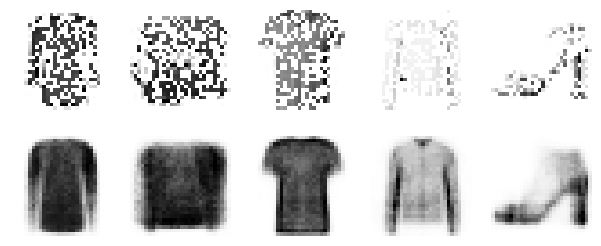

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True).numpy())
save_fig("dropout_denoising_plot", tight_layout=False)

## Variational Autoencoders 

* They are probabilistic autoencoders, meaning that their outputs are partly determined by chance,
* Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.


* The encoder produces a mean coding μ and a standard deviation σ. 
* The actual coding is then sampled randomly from a Gaussian distribution with mean μ and standard deviation σ.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture21_Images/var_ae.jpeg" alt="Drawing" style="width: 500px;"/>


Gaussian distribution: during training, the cost function (discussed next) pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper) spherical region that looks like a cloud of Gaussian points.


### Cost Function 

Composed of two parts: 
* The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (e.g. we can use cross entropy for this) 
* The second is the _latent loss_ that pushes the autoencoder to have codings that _look as though they were sampled from a simple Gaussian distribution_, for which we use the KL (Kullback–Leibler) divergence between the target distribution (the Gaussian distribution) and the actual distribution of the internal codings


In [40]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [42]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25


  1/430 [..............................] - ETA: 6:28 - loss: 0.7223 - rounded_accuracy: 0.4943

 10/430 [..............................] - ETA: 2s - loss: 0.7094 - rounded_accuracy: 0.5328  

 19/430 [>.............................] - ETA: 2s - loss: 0.6569 - rounded_accuracy: 0.6143

 28/430 [>.............................] - ETA: 2s - loss: 0.6172 - rounded_accuracy: 0.6539

 38/430 [=>............................] - ETA: 2s - loss: 0.5860 - rounded_accuracy: 0.6791

 47/430 [==>...........................] - ETA: 2s - loss: 0.5667 - rounded_accuracy: 0.6958

 56/430 [==>...........................] - ETA: 2s - loss: 0.5496 - rounded_accuracy: 0.7117

 65/430 [===>..........................] - ETA: 2s - loss: 0.5376 - rounded_accuracy: 0.7224

 74/430 [====>.........................] - ETA: 2s - loss: 0.5250 - rounded_accuracy: 0.7336

 82/430 [====>.........................] - ETA: 2s - loss: 0.5170 - rounded_accuracy: 0.7411

 91/430 [=====>........................] - ETA: 1s - loss: 0.5079 - rounded_accuracy: 0.7492

100/430 [=====>........................] - ETA: 1s - loss: 0.5002 - rounded_accuracy: 0.7565

109/430 [======>.......................] - ETA: 1s - loss: 0.4933 - rounded_accuracy: 0.7631

118/430 [=======>......................] - ETA: 1s - loss: 0.4881 - rounded_accuracy: 0.7676

127/430 [=======>......................] - ETA: 1s - loss: 0.4829 - rounded_accuracy: 0.7725

137/430 [========>.....................] - ETA: 1s - loss: 0.4776 - rounded_accuracy: 0.7773

146/430 [=========>....................] - ETA: 1s - loss: 0.4731 - rounded_accuracy: 0.7811

155/430 [=========>....................] - ETA: 1s - loss: 0.4694 - rounded_accuracy: 0.7845

164/430 [==========>...................] - ETA: 1s - loss: 0.4659 - rounded_accuracy: 0.7877

174/430 [===========>..................] - ETA: 1s - loss: 0.4621 - rounded_accuracy: 0.7909

184/430 [===========>..................] - ETA: 1s - loss: 0.4588 - rounded_accuracy: 0.7938

194/430 [============>.................] - ETA: 1s - loss: 0.4557 - rounded_accuracy: 0.7966

203/430 [=============>................] - ETA: 1s - loss: 0.4531 - rounded_accuracy: 0.7988

212/430 [=============>................] - ETA: 1s - loss: 0.4509 - rounded_accuracy: 0.8008

221/430 [==============>...............] - ETA: 1s - loss: 0.4490 - rounded_accuracy: 0.8027

231/430 [===============>..............] - ETA: 1s - loss: 0.4464 - rounded_accuracy: 0.8050

241/430 [===============>..............] - ETA: 1s - loss: 0.4441 - rounded_accuracy: 0.8072

250/430 [================>.............] - ETA: 1s - loss: 0.4424 - rounded_accuracy: 0.8089

259/430 [=================>............] - ETA: 0s - loss: 0.4405 - rounded_accuracy: 0.8106

269/430 [=================>............] - ETA: 0s - loss: 0.4385 - rounded_accuracy: 0.8125

278/430 [==================>...........] - ETA: 0s - loss: 0.4372 - rounded_accuracy: 0.8138

288/430 [===================>..........] - ETA: 0s - loss: 0.4354 - rounded_accuracy: 0.8155

298/430 [===================>..........] - ETA: 0s - loss: 0.4337 - rounded_accuracy: 0.8170

307/430 [====================>.........] - ETA: 0s - loss: 0.4326 - rounded_accuracy: 0.8183

317/430 [=====================>........] - ETA: 0s - loss: 0.4311 - rounded_accuracy: 0.8199

326/430 [=====================>........] - ETA: 0s - loss: 0.4297 - rounded_accuracy: 0.8212

335/430 [======================>.......] - ETA: 0s - loss: 0.4282 - rounded_accuracy: 0.8225

345/430 [=======================>......] - ETA: 0s - loss: 0.4268 - rounded_accuracy: 0.8239

354/430 [=======================>......] - ETA: 0s - loss: 0.4256 - rounded_accuracy: 0.8250

363/430 [========================>.....] - ETA: 0s - loss: 0.4245 - rounded_accuracy: 0.8261

372/430 [========================>.....] - ETA: 0s - loss: 0.4233 - rounded_accuracy: 0.8273

382/430 [=========================>....] - ETA: 0s - loss: 0.4221 - rounded_accuracy: 0.8285

392/430 [==========================>...] - ETA: 0s - loss: 0.4209 - rounded_accuracy: 0.8297

402/430 [===========================>..] - ETA: 0s - loss: 0.4196 - rounded_accuracy: 0.8308

412/430 [===========================>..] - ETA: 0s - loss: 0.4184 - rounded_accuracy: 0.8320

422/430 [============================>.] - ETA: 0s - loss: 0.4174 - rounded_accuracy: 0.8330

430/430 [==============================] - 4s 6ms/step - loss: 0.4164 - rounded_accuracy: 0.8339 - val_loss: 0.3841 - val_rounded_accuracy: 0.8741


Epoch 2/25


  1/430 [..............................] - ETA: 3s - loss: 0.3845 - rounded_accuracy: 0.8676

 10/430 [..............................] - ETA: 2s - loss: 0.3711 - rounded_accuracy: 0.8749

 20/430 [>.............................] - ETA: 2s - loss: 0.3674 - rounded_accuracy: 0.8799

 29/430 [=>............................] - ETA: 2s - loss: 0.3680 - rounded_accuracy: 0.8799

 39/430 [=>............................] - ETA: 2s - loss: 0.3661 - rounded_accuracy: 0.8810

 49/430 [==>...........................] - ETA: 2s - loss: 0.3670 - rounded_accuracy: 0.8807

 58/430 [===>..........................] - ETA: 2s - loss: 0.3667 - rounded_accuracy: 0.8811

 68/430 [===>..........................] - ETA: 2s - loss: 0.3676 - rounded_accuracy: 0.8807

 77/430 [====>.........................] - ETA: 1s - loss: 0.3670 - rounded_accuracy: 0.8813

 87/430 [=====>........................] - ETA: 1s - loss: 0.3658 - rounded_accuracy: 0.8819

 97/430 [=====>........................] - ETA: 1s - loss: 0.3649 - rounded_accuracy: 0.8823

107/430 [======>.......................] - ETA: 1s - loss: 0.3646 - rounded_accuracy: 0.8824

117/430 [=======>......................] - ETA: 1s - loss: 0.3638 - rounded_accuracy: 0.8831

126/430 [=======>......................] - ETA: 1s - loss: 0.3636 - rounded_accuracy: 0.8830

135/430 [========>.....................] - ETA: 1s - loss: 0.3633 - rounded_accuracy: 0.8833

144/430 [=========>....................] - ETA: 1s - loss: 0.3629 - rounded_accuracy: 0.8837

153/430 [=========>....................] - ETA: 1s - loss: 0.3628 - rounded_accuracy: 0.8838

163/430 [==========>...................] - ETA: 1s - loss: 0.3627 - rounded_accuracy: 0.8839

173/430 [===========>..................] - ETA: 1s - loss: 0.3622 - rounded_accuracy: 0.8842

182/430 [===========>..................] - ETA: 1s - loss: 0.3620 - rounded_accuracy: 0.8843

191/430 [============>.................] - ETA: 1s - loss: 0.3618 - rounded_accuracy: 0.8844

200/430 [============>.................] - ETA: 1s - loss: 0.3614 - rounded_accuracy: 0.8847

209/430 [=============>................] - ETA: 1s - loss: 0.3611 - rounded_accuracy: 0.8849

218/430 [==============>...............] - ETA: 1s - loss: 0.3609 - rounded_accuracy: 0.8850

226/430 [==============>...............] - ETA: 1s - loss: 0.3606 - rounded_accuracy: 0.8852

235/430 [===============>..............] - ETA: 1s - loss: 0.3605 - rounded_accuracy: 0.8854

244/430 [================>.............] - ETA: 1s - loss: 0.3604 - rounded_accuracy: 0.8855

253/430 [================>.............] - ETA: 0s - loss: 0.3602 - rounded_accuracy: 0.8857

263/430 [=================>............] - ETA: 0s - loss: 0.3600 - rounded_accuracy: 0.8859

273/430 [==================>...........] - ETA: 0s - loss: 0.3599 - rounded_accuracy: 0.8859

282/430 [==================>...........] - ETA: 0s - loss: 0.3597 - rounded_accuracy: 0.8862

291/430 [===================>..........] - ETA: 0s - loss: 0.3594 - rounded_accuracy: 0.8863

300/430 [===================>..........] - ETA: 0s - loss: 0.3593 - rounded_accuracy: 0.8864

309/430 [====================>.........] - ETA: 0s - loss: 0.3591 - rounded_accuracy: 0.8865

318/430 [=====================>........] - ETA: 0s - loss: 0.3589 - rounded_accuracy: 0.8866

327/430 [=====================>........] - ETA: 0s - loss: 0.3586 - rounded_accuracy: 0.8868

337/430 [======================>.......] - ETA: 0s - loss: 0.3583 - rounded_accuracy: 0.8869

346/430 [=======================>......] - ETA: 0s - loss: 0.3582 - rounded_accuracy: 0.8871

355/430 [=======================>......] - ETA: 0s - loss: 0.3579 - rounded_accuracy: 0.8872

365/430 [========================>.....] - ETA: 0s - loss: 0.3578 - rounded_accuracy: 0.8873

374/430 [=========================>....] - ETA: 0s - loss: 0.3577 - rounded_accuracy: 0.8875

383/430 [=========================>....] - ETA: 0s - loss: 0.3576 - rounded_accuracy: 0.8876

392/430 [==========================>...] - ETA: 0s - loss: 0.3574 - rounded_accuracy: 0.8877

401/430 [==========================>...] - ETA: 0s - loss: 0.3572 - rounded_accuracy: 0.8879

410/430 [===========================>..] - ETA: 0s - loss: 0.3571 - rounded_accuracy: 0.8880

419/430 [============================>.] - ETA: 0s - loss: 0.3570 - rounded_accuracy: 0.8881

428/430 [============================>.] - ETA: 0s - loss: 0.3568 - rounded_accuracy: 0.8882

430/430 [==============================] - 3s 6ms/step - loss: 0.3568 - rounded_accuracy: 0.8882 - val_loss: 0.3568 - val_rounded_accuracy: 0.8795


Epoch 3/25


  1/430 [..............................] - ETA: 3s - loss: 0.3582 - rounded_accuracy: 0.8754

 10/430 [..............................] - ETA: 2s - loss: 0.3525 - rounded_accuracy: 0.8913

 19/430 [>.............................] - ETA: 2s - loss: 0.3486 - rounded_accuracy: 0.8933

 28/430 [>.............................] - ETA: 2s - loss: 0.3465 - rounded_accuracy: 0.8939

 37/430 [=>............................] - ETA: 2s - loss: 0.3474 - rounded_accuracy: 0.8934

 46/430 [==>...........................] - ETA: 2s - loss: 0.3480 - rounded_accuracy: 0.8933

 55/430 [==>...........................] - ETA: 2s - loss: 0.3487 - rounded_accuracy: 0.8930

 63/430 [===>..........................] - ETA: 2s - loss: 0.3484 - rounded_accuracy: 0.8936

 72/430 [====>.........................] - ETA: 2s - loss: 0.3477 - rounded_accuracy: 0.8936

 81/430 [====>.........................] - ETA: 2s - loss: 0.3480 - rounded_accuracy: 0.8936

 90/430 [=====>........................] - ETA: 1s - loss: 0.3478 - rounded_accuracy: 0.8938

 98/430 [=====>........................] - ETA: 1s - loss: 0.3475 - rounded_accuracy: 0.8939

107/430 [======>.......................] - ETA: 1s - loss: 0.3476 - rounded_accuracy: 0.8938

116/430 [=======>......................] - ETA: 1s - loss: 0.3475 - rounded_accuracy: 0.8939

125/430 [=======>......................] - ETA: 1s - loss: 0.3473 - rounded_accuracy: 0.8938

134/430 [========>.....................] - ETA: 1s - loss: 0.3475 - rounded_accuracy: 0.8938

143/430 [========>.....................] - ETA: 1s - loss: 0.3475 - rounded_accuracy: 0.8940

152/430 [=========>....................] - ETA: 1s - loss: 0.3474 - rounded_accuracy: 0.8939

161/430 [==========>...................] - ETA: 1s - loss: 0.3476 - rounded_accuracy: 0.8935

170/430 [==========>...................] - ETA: 1s - loss: 0.3475 - rounded_accuracy: 0.8936

179/430 [===========>..................] - ETA: 1s - loss: 0.3473 - rounded_accuracy: 0.8936

189/430 [============>.................] - ETA: 1s - loss: 0.3472 - rounded_accuracy: 0.8936

197/430 [============>.................] - ETA: 1s - loss: 0.3473 - rounded_accuracy: 0.8937

206/430 [=============>................] - ETA: 1s - loss: 0.3470 - rounded_accuracy: 0.8939

215/430 [==============>...............] - ETA: 1s - loss: 0.3468 - rounded_accuracy: 0.8940

225/430 [==============>...............] - ETA: 1s - loss: 0.3467 - rounded_accuracy: 0.8941

234/430 [===============>..............] - ETA: 1s - loss: 0.3467 - rounded_accuracy: 0.8943

243/430 [===============>..............] - ETA: 1s - loss: 0.3466 - rounded_accuracy: 0.8944

252/430 [================>.............] - ETA: 1s - loss: 0.3466 - rounded_accuracy: 0.8944

261/430 [=================>............] - ETA: 0s - loss: 0.3468 - rounded_accuracy: 0.8945

271/430 [=================>............] - ETA: 0s - loss: 0.3466 - rounded_accuracy: 0.8945

279/430 [==================>...........] - ETA: 0s - loss: 0.3466 - rounded_accuracy: 0.8946

288/430 [===================>..........] - ETA: 0s - loss: 0.3465 - rounded_accuracy: 0.8946

297/430 [===================>..........] - ETA: 0s - loss: 0.3463 - rounded_accuracy: 0.8947

306/430 [====================>.........] - ETA: 0s - loss: 0.3464 - rounded_accuracy: 0.8947

315/430 [====================>.........] - ETA: 0s - loss: 0.3464 - rounded_accuracy: 0.8948

324/430 [=====================>........] - ETA: 0s - loss: 0.3463 - rounded_accuracy: 0.8949

333/430 [======================>.......] - ETA: 0s - loss: 0.3462 - rounded_accuracy: 0.8951

342/430 [======================>.......] - ETA: 0s - loss: 0.3460 - rounded_accuracy: 0.8952

351/430 [=======================>......] - ETA: 0s - loss: 0.3459 - rounded_accuracy: 0.8953

360/430 [========================>.....] - ETA: 0s - loss: 0.3459 - rounded_accuracy: 0.8953

369/430 [========================>.....] - ETA: 0s - loss: 0.3459 - rounded_accuracy: 0.8953

378/430 [=========================>....] - ETA: 0s - loss: 0.3457 - rounded_accuracy: 0.8955

387/430 [==========================>...] - ETA: 0s - loss: 0.3457 - rounded_accuracy: 0.8955

394/430 [==========================>...] - ETA: 0s - loss: 0.3456 - rounded_accuracy: 0.8955

402/430 [===========================>..] - ETA: 0s - loss: 0.3454 - rounded_accuracy: 0.8957

411/430 [===========================>..] - ETA: 0s - loss: 0.3454 - rounded_accuracy: 0.8957

420/430 [============================>.] - ETA: 0s - loss: 0.3453 - rounded_accuracy: 0.8958

429/430 [============================>.] - ETA: 0s - loss: 0.3451 - rounded_accuracy: 0.8959

430/430 [==============================] - 3s 6ms/step - loss: 0.3451 - rounded_accuracy: 0.8959 - val_loss: 0.3472 - val_rounded_accuracy: 0.8926


Epoch 4/25


  1/430 [..............................] - ETA: 2s - loss: 0.3482 - rounded_accuracy: 0.8923

 10/430 [..............................] - ETA: 2s - loss: 0.3423 - rounded_accuracy: 0.8967

 19/430 [>.............................] - ETA: 2s - loss: 0.3401 - rounded_accuracy: 0.8987

 28/430 [>.............................] - ETA: 2s - loss: 0.3417 - rounded_accuracy: 0.8978

 37/430 [=>............................] - ETA: 2s - loss: 0.3420 - rounded_accuracy: 0.8975

 46/430 [==>...........................] - ETA: 2s - loss: 0.3413 - rounded_accuracy: 0.8979

 55/430 [==>...........................] - ETA: 2s - loss: 0.3416 - rounded_accuracy: 0.8979

 65/430 [===>..........................] - ETA: 2s - loss: 0.3416 - rounded_accuracy: 0.8985

 74/430 [====>.........................] - ETA: 2s - loss: 0.3413 - rounded_accuracy: 0.8989

 84/430 [====>.........................] - ETA: 1s - loss: 0.3413 - rounded_accuracy: 0.8987

 93/430 [=====>........................] - ETA: 1s - loss: 0.3412 - rounded_accuracy: 0.8988

102/430 [======>.......................] - ETA: 1s - loss: 0.3417 - rounded_accuracy: 0.8989

111/430 [======>.......................] - ETA: 1s - loss: 0.3418 - rounded_accuracy: 0.8990

120/430 [=======>......................] - ETA: 1s - loss: 0.3415 - rounded_accuracy: 0.8991

129/430 [========>.....................] - ETA: 1s - loss: 0.3412 - rounded_accuracy: 0.8991

138/430 [========>.....................] - ETA: 1s - loss: 0.3407 - rounded_accuracy: 0.8994

147/430 [=========>....................] - ETA: 1s - loss: 0.3405 - rounded_accuracy: 0.8997

156/430 [=========>....................] - ETA: 1s - loss: 0.3401 - rounded_accuracy: 0.8996

165/430 [==========>...................] - ETA: 1s - loss: 0.3399 - rounded_accuracy: 0.8996

173/430 [===========>..................] - ETA: 1s - loss: 0.3403 - rounded_accuracy: 0.8995

182/430 [===========>..................] - ETA: 1s - loss: 0.3401 - rounded_accuracy: 0.8998

191/430 [============>.................] - ETA: 1s - loss: 0.3399 - rounded_accuracy: 0.8998

200/430 [============>.................] - ETA: 1s - loss: 0.3399 - rounded_accuracy: 0.8998

209/430 [=============>................] - ETA: 1s - loss: 0.3399 - rounded_accuracy: 0.8997

218/430 [==============>...............] - ETA: 1s - loss: 0.3397 - rounded_accuracy: 0.8998

227/430 [==============>...............] - ETA: 1s - loss: 0.3399 - rounded_accuracy: 0.8998

236/430 [===============>..............] - ETA: 1s - loss: 0.3398 - rounded_accuracy: 0.8999

245/430 [================>.............] - ETA: 1s - loss: 0.3395 - rounded_accuracy: 0.9001

254/430 [================>.............] - ETA: 1s - loss: 0.3394 - rounded_accuracy: 0.9001

262/430 [=================>............] - ETA: 0s - loss: 0.3394 - rounded_accuracy: 0.9003

271/430 [=================>............] - ETA: 0s - loss: 0.3394 - rounded_accuracy: 0.9002

280/430 [==================>...........] - ETA: 0s - loss: 0.3394 - rounded_accuracy: 0.9003

289/430 [===================>..........] - ETA: 0s - loss: 0.3392 - rounded_accuracy: 0.9005

298/430 [===================>..........] - ETA: 0s - loss: 0.3393 - rounded_accuracy: 0.9004

307/430 [====================>.........] - ETA: 0s - loss: 0.3392 - rounded_accuracy: 0.9005

316/430 [=====================>........] - ETA: 0s - loss: 0.3391 - rounded_accuracy: 0.9005

325/430 [=====================>........] - ETA: 0s - loss: 0.3392 - rounded_accuracy: 0.9005

334/430 [======================>.......] - ETA: 0s - loss: 0.3391 - rounded_accuracy: 0.9006

343/430 [======================>.......] - ETA: 0s - loss: 0.3391 - rounded_accuracy: 0.9006

353/430 [=======================>......] - ETA: 0s - loss: 0.3390 - rounded_accuracy: 0.9007

361/430 [========================>.....] - ETA: 0s - loss: 0.3391 - rounded_accuracy: 0.9007

370/430 [========================>.....] - ETA: 0s - loss: 0.3390 - rounded_accuracy: 0.9007

379/430 [=========================>....] - ETA: 0s - loss: 0.3390 - rounded_accuracy: 0.9007

388/430 [==========================>...] - ETA: 0s - loss: 0.3391 - rounded_accuracy: 0.9007

398/430 [==========================>...] - ETA: 0s - loss: 0.3389 - rounded_accuracy: 0.9008

407/430 [===========================>..] - ETA: 0s - loss: 0.3388 - rounded_accuracy: 0.9008

416/430 [============================>.] - ETA: 0s - loss: 0.3387 - rounded_accuracy: 0.9008

425/430 [============================>.] - ETA: 0s - loss: 0.3387 - rounded_accuracy: 0.9009

430/430 [==============================] - 3s 6ms/step - loss: 0.3385 - rounded_accuracy: 0.9009 - val_loss: 0.3385 - val_rounded_accuracy: 0.9054


Epoch 5/25


  1/430 [..............................] - ETA: 2s - loss: 0.3325 - rounded_accuracy: 0.9078

 10/430 [..............................] - ETA: 2s - loss: 0.3362 - rounded_accuracy: 0.9052

 19/430 [>.............................] - ETA: 2s - loss: 0.3357 - rounded_accuracy: 0.9042

 28/430 [>.............................] - ETA: 2s - loss: 0.3346 - rounded_accuracy: 0.9039

 37/430 [=>............................] - ETA: 2s - loss: 0.3346 - rounded_accuracy: 0.9039

 46/430 [==>...........................] - ETA: 2s - loss: 0.3347 - rounded_accuracy: 0.9031

 55/430 [==>...........................] - ETA: 2s - loss: 0.3351 - rounded_accuracy: 0.9031

 63/430 [===>..........................] - ETA: 2s - loss: 0.3349 - rounded_accuracy: 0.9036

 72/430 [====>.........................] - ETA: 2s - loss: 0.3353 - rounded_accuracy: 0.9035

 81/430 [====>.........................] - ETA: 2s - loss: 0.3353 - rounded_accuracy: 0.9038

 90/430 [=====>........................] - ETA: 1s - loss: 0.3357 - rounded_accuracy: 0.9036

 99/430 [=====>........................] - ETA: 1s - loss: 0.3354 - rounded_accuracy: 0.9037

108/430 [======>.......................] - ETA: 1s - loss: 0.3355 - rounded_accuracy: 0.9037

117/430 [=======>......................] - ETA: 1s - loss: 0.3357 - rounded_accuracy: 0.9037

126/430 [=======>......................] - ETA: 1s - loss: 0.3355 - rounded_accuracy: 0.9038

135/430 [========>.....................] - ETA: 1s - loss: 0.3354 - rounded_accuracy: 0.9039

144/430 [=========>....................] - ETA: 1s - loss: 0.3354 - rounded_accuracy: 0.9038

153/430 [=========>....................] - ETA: 1s - loss: 0.3352 - rounded_accuracy: 0.9038

162/430 [==========>...................] - ETA: 1s - loss: 0.3352 - rounded_accuracy: 0.9039

171/430 [==========>...................] - ETA: 1s - loss: 0.3350 - rounded_accuracy: 0.9040

180/430 [===========>..................] - ETA: 1s - loss: 0.3350 - rounded_accuracy: 0.9040

189/430 [============>.................] - ETA: 1s - loss: 0.3349 - rounded_accuracy: 0.9041

198/430 [============>.................] - ETA: 1s - loss: 0.3349 - rounded_accuracy: 0.9042

207/430 [=============>................] - ETA: 1s - loss: 0.3350 - rounded_accuracy: 0.9041

216/430 [==============>...............] - ETA: 1s - loss: 0.3349 - rounded_accuracy: 0.9041

225/430 [==============>...............] - ETA: 1s - loss: 0.3347 - rounded_accuracy: 0.9042

234/430 [===============>..............] - ETA: 1s - loss: 0.3346 - rounded_accuracy: 0.9044

242/430 [===============>..............] - ETA: 1s - loss: 0.3345 - rounded_accuracy: 0.9044

251/430 [================>.............] - ETA: 1s - loss: 0.3344 - rounded_accuracy: 0.9044

260/430 [=================>............] - ETA: 0s - loss: 0.3343 - rounded_accuracy: 0.9045

269/430 [=================>............] - ETA: 0s - loss: 0.3341 - rounded_accuracy: 0.9046

278/430 [==================>...........] - ETA: 0s - loss: 0.3341 - rounded_accuracy: 0.9046

287/430 [===================>..........] - ETA: 0s - loss: 0.3340 - rounded_accuracy: 0.9047

296/430 [===================>..........] - ETA: 0s - loss: 0.3341 - rounded_accuracy: 0.9046

306/430 [====================>.........] - ETA: 0s - loss: 0.3340 - rounded_accuracy: 0.9047

315/430 [====================>.........] - ETA: 0s - loss: 0.3340 - rounded_accuracy: 0.9047

324/430 [=====================>........] - ETA: 0s - loss: 0.3340 - rounded_accuracy: 0.9047

333/430 [======================>.......] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9047

342/430 [======================>.......] - ETA: 0s - loss: 0.3340 - rounded_accuracy: 0.9047

351/430 [=======================>......] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9047

360/430 [========================>.....] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9047

369/430 [========================>.....] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9047

378/430 [=========================>....] - ETA: 0s - loss: 0.3338 - rounded_accuracy: 0.9048

387/430 [==========================>...] - ETA: 0s - loss: 0.3338 - rounded_accuracy: 0.9046

396/430 [==========================>...] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9046

406/430 [===========================>..] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9046

415/430 [===========================>..] - ETA: 0s - loss: 0.3339 - rounded_accuracy: 0.9046

425/430 [============================>.] - ETA: 0s - loss: 0.3338 - rounded_accuracy: 0.9047

430/430 [==============================] - 3s 6ms/step - loss: 0.3338 - rounded_accuracy: 0.9047 - val_loss: 0.3335 - val_rounded_accuracy: 0.9064


Epoch 6/25


  1/430 [..............................] - ETA: 2s - loss: 0.3371 - rounded_accuracy: 0.9132

 11/430 [..............................] - ETA: 2s - loss: 0.3320 - rounded_accuracy: 0.9066

 20/430 [>.............................] - ETA: 2s - loss: 0.3353 - rounded_accuracy: 0.9059

 30/430 [=>............................] - ETA: 2s - loss: 0.3350 - rounded_accuracy: 0.9056

 39/430 [=>............................] - ETA: 2s - loss: 0.3352 - rounded_accuracy: 0.9045

 48/430 [==>...........................] - ETA: 2s - loss: 0.3344 - rounded_accuracy: 0.9046

 57/430 [==>...........................] - ETA: 2s - loss: 0.3337 - rounded_accuracy: 0.9049

 66/430 [===>..........................] - ETA: 2s - loss: 0.3329 - rounded_accuracy: 0.9054

 75/430 [====>.........................] - ETA: 2s - loss: 0.3337 - rounded_accuracy: 0.9051

 84/430 [====>.........................] - ETA: 1s - loss: 0.3337 - rounded_accuracy: 0.9053

 93/430 [=====>........................] - ETA: 1s - loss: 0.3339 - rounded_accuracy: 0.9054

102/430 [======>.......................] - ETA: 1s - loss: 0.3338 - rounded_accuracy: 0.9055

111/430 [======>.......................] - ETA: 1s - loss: 0.3336 - rounded_accuracy: 0.9056

120/430 [=======>......................] - ETA: 1s - loss: 0.3337 - rounded_accuracy: 0.9057

129/430 [========>.....................] - ETA: 1s - loss: 0.3333 - rounded_accuracy: 0.9058

137/430 [========>.....................] - ETA: 1s - loss: 0.3333 - rounded_accuracy: 0.9057

146/430 [=========>....................] - ETA: 1s - loss: 0.3327 - rounded_accuracy: 0.9059

155/430 [=========>....................] - ETA: 1s - loss: 0.3324 - rounded_accuracy: 0.9060

164/430 [==========>...................] - ETA: 1s - loss: 0.3327 - rounded_accuracy: 0.9058

173/430 [===========>..................] - ETA: 1s - loss: 0.3326 - rounded_accuracy: 0.9061

182/430 [===========>..................] - ETA: 1s - loss: 0.3323 - rounded_accuracy: 0.9060

191/430 [============>.................] - ETA: 1s - loss: 0.3322 - rounded_accuracy: 0.9061

200/430 [============>.................] - ETA: 1s - loss: 0.3322 - rounded_accuracy: 0.9061

209/430 [=============>................] - ETA: 1s - loss: 0.3323 - rounded_accuracy: 0.9061

219/430 [==============>...............] - ETA: 1s - loss: 0.3321 - rounded_accuracy: 0.9062

229/430 [==============>...............] - ETA: 1s - loss: 0.3319 - rounded_accuracy: 0.9063

238/430 [===============>..............] - ETA: 1s - loss: 0.3318 - rounded_accuracy: 0.9063

247/430 [================>.............] - ETA: 1s - loss: 0.3320 - rounded_accuracy: 0.9062

256/430 [================>.............] - ETA: 1s - loss: 0.3320 - rounded_accuracy: 0.9063

265/430 [=================>............] - ETA: 0s - loss: 0.3320 - rounded_accuracy: 0.9063

274/430 [==================>...........] - ETA: 0s - loss: 0.3317 - rounded_accuracy: 0.9064

283/430 [==================>...........] - ETA: 0s - loss: 0.3316 - rounded_accuracy: 0.9064

292/430 [===================>..........] - ETA: 0s - loss: 0.3315 - rounded_accuracy: 0.9064

301/430 [====================>.........] - ETA: 0s - loss: 0.3313 - rounded_accuracy: 0.9065

309/430 [====================>.........] - ETA: 0s - loss: 0.3312 - rounded_accuracy: 0.9065

318/430 [=====================>........] - ETA: 0s - loss: 0.3312 - rounded_accuracy: 0.9066

327/430 [=====================>........] - ETA: 0s - loss: 0.3313 - rounded_accuracy: 0.9066

336/430 [======================>.......] - ETA: 0s - loss: 0.3312 - rounded_accuracy: 0.9066

345/430 [=======================>......] - ETA: 0s - loss: 0.3313 - rounded_accuracy: 0.9067

354/430 [=======================>......] - ETA: 0s - loss: 0.3311 - rounded_accuracy: 0.9067

363/430 [========================>.....] - ETA: 0s - loss: 0.3310 - rounded_accuracy: 0.9067

372/430 [========================>.....] - ETA: 0s - loss: 0.3309 - rounded_accuracy: 0.9068

381/430 [=========================>....] - ETA: 0s - loss: 0.3309 - rounded_accuracy: 0.9068

390/430 [==========================>...] - ETA: 0s - loss: 0.3307 - rounded_accuracy: 0.9069

399/430 [==========================>...] - ETA: 0s - loss: 0.3306 - rounded_accuracy: 0.9071

408/430 [===========================>..] - ETA: 0s - loss: 0.3306 - rounded_accuracy: 0.9071

417/430 [============================>.] - ETA: 0s - loss: 0.3305 - rounded_accuracy: 0.9071

426/430 [============================>.] - ETA: 0s - loss: 0.3305 - rounded_accuracy: 0.9072

430/430 [==============================] - 3s 6ms/step - loss: 0.3304 - rounded_accuracy: 0.9072 - val_loss: 0.3296 - val_rounded_accuracy: 0.9082


Epoch 7/25


  1/430 [..............................] - ETA: 2s - loss: 0.3376 - rounded_accuracy: 0.9104

 10/430 [..............................] - ETA: 2s - loss: 0.3326 - rounded_accuracy: 0.9113

 19/430 [>.............................] - ETA: 2s - loss: 0.3323 - rounded_accuracy: 0.9088

 28/430 [>.............................] - ETA: 2s - loss: 0.3309 - rounded_accuracy: 0.9080

 36/430 [=>............................] - ETA: 2s - loss: 0.3294 - rounded_accuracy: 0.9088

 45/430 [==>...........................] - ETA: 2s - loss: 0.3298 - rounded_accuracy: 0.9085

 54/430 [==>...........................] - ETA: 2s - loss: 0.3293 - rounded_accuracy: 0.9086

 63/430 [===>..........................] - ETA: 2s - loss: 0.3298 - rounded_accuracy: 0.9079

 72/430 [====>.........................] - ETA: 2s - loss: 0.3289 - rounded_accuracy: 0.9087

 81/430 [====>.........................] - ETA: 2s - loss: 0.3285 - rounded_accuracy: 0.9088

 90/430 [=====>........................] - ETA: 1s - loss: 0.3281 - rounded_accuracy: 0.9089

 99/430 [=====>........................] - ETA: 1s - loss: 0.3278 - rounded_accuracy: 0.9091

108/430 [======>.......................] - ETA: 1s - loss: 0.3284 - rounded_accuracy: 0.9088

117/430 [=======>......................] - ETA: 1s - loss: 0.3284 - rounded_accuracy: 0.9091

127/430 [=======>......................] - ETA: 1s - loss: 0.3283 - rounded_accuracy: 0.9092

136/430 [========>.....................] - ETA: 1s - loss: 0.3281 - rounded_accuracy: 0.9092

145/430 [=========>....................] - ETA: 1s - loss: 0.3281 - rounded_accuracy: 0.9092

154/430 [=========>....................] - ETA: 1s - loss: 0.3281 - rounded_accuracy: 0.9092

164/430 [==========>...................] - ETA: 1s - loss: 0.3282 - rounded_accuracy: 0.9091

174/430 [===========>..................] - ETA: 1s - loss: 0.3284 - rounded_accuracy: 0.9090

184/430 [===========>..................] - ETA: 1s - loss: 0.3283 - rounded_accuracy: 0.9090

193/430 [============>.................] - ETA: 1s - loss: 0.3284 - rounded_accuracy: 0.9089

202/430 [=============>................] - ETA: 1s - loss: 0.3284 - rounded_accuracy: 0.9088

211/430 [=============>................] - ETA: 1s - loss: 0.3286 - rounded_accuracy: 0.9086

220/430 [==============>...............] - ETA: 1s - loss: 0.3287 - rounded_accuracy: 0.9087

229/430 [==============>...............] - ETA: 1s - loss: 0.3287 - rounded_accuracy: 0.9087

238/430 [===============>..............] - ETA: 1s - loss: 0.3287 - rounded_accuracy: 0.9087

247/430 [================>.............] - ETA: 1s - loss: 0.3285 - rounded_accuracy: 0.9088

256/430 [================>.............] - ETA: 1s - loss: 0.3285 - rounded_accuracy: 0.9089

265/430 [=================>............] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

274/430 [==================>...........] - ETA: 0s - loss: 0.3284 - rounded_accuracy: 0.9090

283/430 [==================>...........] - ETA: 0s - loss: 0.3282 - rounded_accuracy: 0.9090

292/430 [===================>..........] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

302/430 [====================>.........] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

311/430 [====================>.........] - ETA: 0s - loss: 0.3284 - rounded_accuracy: 0.9089

320/430 [=====================>........] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

329/430 [=====================>........] - ETA: 0s - loss: 0.3284 - rounded_accuracy: 0.9089

338/430 [======================>.......] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

347/430 [=======================>......] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9090

356/430 [=======================>......] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9091

365/430 [========================>.....] - ETA: 0s - loss: 0.3283 - rounded_accuracy: 0.9091

374/430 [=========================>....] - ETA: 0s - loss: 0.3281 - rounded_accuracy: 0.9092

383/430 [=========================>....] - ETA: 0s - loss: 0.3281 - rounded_accuracy: 0.9092

392/430 [==========================>...] - ETA: 0s - loss: 0.3281 - rounded_accuracy: 0.9092

401/430 [==========================>...] - ETA: 0s - loss: 0.3280 - rounded_accuracy: 0.9093

410/430 [===========================>..] - ETA: 0s - loss: 0.3278 - rounded_accuracy: 0.9093

419/430 [============================>.] - ETA: 0s - loss: 0.3278 - rounded_accuracy: 0.9093

428/430 [============================>.] - ETA: 0s - loss: 0.3278 - rounded_accuracy: 0.9093

430/430 [==============================] - 3s 6ms/step - loss: 0.3278 - rounded_accuracy: 0.9093 - val_loss: 0.3299 - val_rounded_accuracy: 0.9102


Epoch 8/25


  1/430 [..............................] - ETA: 2s - loss: 0.3286 - rounded_accuracy: 0.9047

 10/430 [..............................] - ETA: 2s - loss: 0.3236 - rounded_accuracy: 0.9114

 19/430 [>.............................] - ETA: 2s - loss: 0.3246 - rounded_accuracy: 0.9117

 27/430 [>.............................] - ETA: 2s - loss: 0.3261 - rounded_accuracy: 0.9112

 36/430 [=>............................] - ETA: 2s - loss: 0.3261 - rounded_accuracy: 0.9113

 45/430 [==>...........................] - ETA: 2s - loss: 0.3260 - rounded_accuracy: 0.9111

 54/430 [==>...........................] - ETA: 2s - loss: 0.3257 - rounded_accuracy: 0.9108

 63/430 [===>..........................] - ETA: 2s - loss: 0.3254 - rounded_accuracy: 0.9109

 72/430 [====>.........................] - ETA: 2s - loss: 0.3258 - rounded_accuracy: 0.9108

 81/430 [====>.........................] - ETA: 2s - loss: 0.3259 - rounded_accuracy: 0.9108

 90/430 [=====>........................] - ETA: 2s - loss: 0.3256 - rounded_accuracy: 0.9110

 99/430 [=====>........................] - ETA: 1s - loss: 0.3257 - rounded_accuracy: 0.9109

107/430 [======>.......................] - ETA: 1s - loss: 0.3261 - rounded_accuracy: 0.9107

116/430 [=======>......................] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9109

125/430 [=======>......................] - ETA: 1s - loss: 0.3263 - rounded_accuracy: 0.9106

134/430 [========>.....................] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9108

143/430 [========>.....................] - ETA: 1s - loss: 0.3261 - rounded_accuracy: 0.9106

152/430 [=========>....................] - ETA: 1s - loss: 0.3261 - rounded_accuracy: 0.9106

161/430 [==========>...................] - ETA: 1s - loss: 0.3262 - rounded_accuracy: 0.9105

170/430 [==========>...................] - ETA: 1s - loss: 0.3262 - rounded_accuracy: 0.9106

179/430 [===========>..................] - ETA: 1s - loss: 0.3262 - rounded_accuracy: 0.9104

188/430 [============>.................] - ETA: 1s - loss: 0.3261 - rounded_accuracy: 0.9104

197/430 [============>.................] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9104

206/430 [=============>................] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9105

215/430 [==============>...............] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9104

224/430 [==============>...............] - ETA: 1s - loss: 0.3259 - rounded_accuracy: 0.9104

233/430 [===============>..............] - ETA: 1s - loss: 0.3259 - rounded_accuracy: 0.9104

242/430 [===============>..............] - ETA: 1s - loss: 0.3259 - rounded_accuracy: 0.9103

251/430 [================>.............] - ETA: 1s - loss: 0.3258 - rounded_accuracy: 0.9104

260/430 [=================>............] - ETA: 0s - loss: 0.3259 - rounded_accuracy: 0.9104

269/430 [=================>............] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9104

278/430 [==================>...........] - ETA: 0s - loss: 0.3261 - rounded_accuracy: 0.9103

287/430 [===================>..........] - ETA: 0s - loss: 0.3261 - rounded_accuracy: 0.9103

297/430 [===================>..........] - ETA: 0s - loss: 0.3262 - rounded_accuracy: 0.9104

306/430 [====================>.........] - ETA: 0s - loss: 0.3261 - rounded_accuracy: 0.9105

315/430 [====================>.........] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9105

325/430 [=====================>........] - ETA: 0s - loss: 0.3261 - rounded_accuracy: 0.9105

334/430 [======================>.......] - ETA: 0s - loss: 0.3261 - rounded_accuracy: 0.9105

343/430 [======================>.......] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9105

352/430 [=======================>......] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9105

361/430 [========================>.....] - ETA: 0s - loss: 0.3259 - rounded_accuracy: 0.9106

370/430 [========================>.....] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9106

379/430 [=========================>....] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9106

388/430 [==========================>...] - ETA: 0s - loss: 0.3259 - rounded_accuracy: 0.9106

397/430 [==========================>...] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9106

406/430 [===========================>..] - ETA: 0s - loss: 0.3260 - rounded_accuracy: 0.9106

415/430 [===========================>..] - ETA: 0s - loss: 0.3259 - rounded_accuracy: 0.9107

424/430 [============================>.] - ETA: 0s - loss: 0.3258 - rounded_accuracy: 0.9107

430/430 [==============================] - 3s 6ms/step - loss: 0.3258 - rounded_accuracy: 0.9108 - val_loss: 0.3273 - val_rounded_accuracy: 0.9116


Epoch 9/25


  1/430 [..............................] - ETA: 4s - loss: 0.3281 - rounded_accuracy: 0.9122

 10/430 [..............................] - ETA: 2s - loss: 0.3267 - rounded_accuracy: 0.9114

 19/430 [>.............................] - ETA: 2s - loss: 0.3285 - rounded_accuracy: 0.9100

 28/430 [>.............................] - ETA: 2s - loss: 0.3280 - rounded_accuracy: 0.9100

 37/430 [=>............................] - ETA: 2s - loss: 0.3268 - rounded_accuracy: 0.9103

 46/430 [==>...........................] - ETA: 2s - loss: 0.3269 - rounded_accuracy: 0.9100

 55/430 [==>...........................] - ETA: 2s - loss: 0.3269 - rounded_accuracy: 0.9100

 64/430 [===>..........................] - ETA: 2s - loss: 0.3268 - rounded_accuracy: 0.9100

 73/430 [====>.........................] - ETA: 2s - loss: 0.3268 - rounded_accuracy: 0.9100

 82/430 [====>.........................] - ETA: 2s - loss: 0.3263 - rounded_accuracy: 0.9102

 91/430 [=====>........................] - ETA: 1s - loss: 0.3262 - rounded_accuracy: 0.9103

100/430 [=====>........................] - ETA: 1s - loss: 0.3259 - rounded_accuracy: 0.9105

109/430 [======>.......................] - ETA: 1s - loss: 0.3257 - rounded_accuracy: 0.9107

118/430 [=======>......................] - ETA: 1s - loss: 0.3256 - rounded_accuracy: 0.9108

127/430 [=======>......................] - ETA: 1s - loss: 0.3261 - rounded_accuracy: 0.9107

136/430 [========>.....................] - ETA: 1s - loss: 0.3260 - rounded_accuracy: 0.9108

146/430 [=========>....................] - ETA: 1s - loss: 0.3257 - rounded_accuracy: 0.9109

155/430 [=========>....................] - ETA: 1s - loss: 0.3256 - rounded_accuracy: 0.9107

165/430 [==========>...................] - ETA: 1s - loss: 0.3256 - rounded_accuracy: 0.9109

174/430 [===========>..................] - ETA: 1s - loss: 0.3254 - rounded_accuracy: 0.9109

182/430 [===========>..................] - ETA: 1s - loss: 0.3253 - rounded_accuracy: 0.9110

191/430 [============>.................] - ETA: 1s - loss: 0.3252 - rounded_accuracy: 0.9110

201/430 [=============>................] - ETA: 1s - loss: 0.3252 - rounded_accuracy: 0.9110

210/430 [=============>................] - ETA: 1s - loss: 0.3252 - rounded_accuracy: 0.9112

219/430 [==============>...............] - ETA: 1s - loss: 0.3252 - rounded_accuracy: 0.9111

228/430 [==============>...............] - ETA: 1s - loss: 0.3250 - rounded_accuracy: 0.9112

237/430 [===============>..............] - ETA: 1s - loss: 0.3249 - rounded_accuracy: 0.9113

246/430 [================>.............] - ETA: 1s - loss: 0.3247 - rounded_accuracy: 0.9114

255/430 [================>.............] - ETA: 1s - loss: 0.3247 - rounded_accuracy: 0.9114

265/430 [=================>............] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9116

274/430 [==================>...........] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9116

283/430 [==================>...........] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9116

293/430 [===================>..........] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9116

302/430 [====================>.........] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9116

311/430 [====================>.........] - ETA: 0s - loss: 0.3245 - rounded_accuracy: 0.9117

320/430 [=====================>........] - ETA: 0s - loss: 0.3244 - rounded_accuracy: 0.9117

329/430 [=====================>........] - ETA: 0s - loss: 0.3244 - rounded_accuracy: 0.9117

338/430 [======================>.......] - ETA: 0s - loss: 0.3242 - rounded_accuracy: 0.9118

347/430 [=======================>......] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9118

355/430 [=======================>......] - ETA: 0s - loss: 0.3242 - rounded_accuracy: 0.9118

364/430 [========================>.....] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9117

373/430 [=========================>....] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9117

382/430 [=========================>....] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9117

391/430 [==========================>...] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9117

400/430 [==========================>...] - ETA: 0s - loss: 0.3243 - rounded_accuracy: 0.9118

409/430 [===========================>..] - ETA: 0s - loss: 0.3242 - rounded_accuracy: 0.9117

418/430 [============================>.] - ETA: 0s - loss: 0.3242 - rounded_accuracy: 0.9118

427/430 [============================>.] - ETA: 0s - loss: 0.3242 - rounded_accuracy: 0.9119

430/430 [==============================] - 3s 6ms/step - loss: 0.3242 - rounded_accuracy: 0.9118 - val_loss: 0.3297 - val_rounded_accuracy: 0.9076


Epoch 10/25


  1/430 [..............................] - ETA: 3s - loss: 0.3369 - rounded_accuracy: 0.9056

  9/430 [..............................] - ETA: 2s - loss: 0.3233 - rounded_accuracy: 0.9110

 18/430 [>.............................] - ETA: 2s - loss: 0.3253 - rounded_accuracy: 0.9129

 27/430 [>.............................] - ETA: 2s - loss: 0.3227 - rounded_accuracy: 0.9138

 36/430 [=>............................] - ETA: 2s - loss: 0.3228 - rounded_accuracy: 0.9134

 45/430 [==>...........................] - ETA: 2s - loss: 0.3231 - rounded_accuracy: 0.9131

 54/430 [==>...........................] - ETA: 2s - loss: 0.3227 - rounded_accuracy: 0.9132

 63/430 [===>..........................] - ETA: 2s - loss: 0.3235 - rounded_accuracy: 0.9131

 72/430 [====>.........................] - ETA: 2s - loss: 0.3236 - rounded_accuracy: 0.9131

 80/430 [====>.........................] - ETA: 2s - loss: 0.3235 - rounded_accuracy: 0.9129

 88/430 [=====>........................] - ETA: 2s - loss: 0.3233 - rounded_accuracy: 0.9129

 97/430 [=====>........................] - ETA: 1s - loss: 0.3234 - rounded_accuracy: 0.9127

106/430 [======>.......................] - ETA: 1s - loss: 0.3235 - rounded_accuracy: 0.9126

115/430 [=======>......................] - ETA: 1s - loss: 0.3236 - rounded_accuracy: 0.9125

125/430 [=======>......................] - ETA: 1s - loss: 0.3239 - rounded_accuracy: 0.9125

135/430 [========>.....................] - ETA: 1s - loss: 0.3235 - rounded_accuracy: 0.9127

144/430 [=========>....................] - ETA: 1s - loss: 0.3231 - rounded_accuracy: 0.9128

153/430 [=========>....................] - ETA: 1s - loss: 0.3230 - rounded_accuracy: 0.9128

162/430 [==========>...................] - ETA: 1s - loss: 0.3233 - rounded_accuracy: 0.9127

171/430 [==========>...................] - ETA: 1s - loss: 0.3235 - rounded_accuracy: 0.9127

180/430 [===========>..................] - ETA: 1s - loss: 0.3233 - rounded_accuracy: 0.9128

189/430 [============>.................] - ETA: 1s - loss: 0.3235 - rounded_accuracy: 0.9127

198/430 [============>.................] - ETA: 1s - loss: 0.3231 - rounded_accuracy: 0.9129

207/430 [=============>................] - ETA: 1s - loss: 0.3232 - rounded_accuracy: 0.9127

216/430 [==============>...............] - ETA: 1s - loss: 0.3232 - rounded_accuracy: 0.9127

225/430 [==============>...............] - ETA: 1s - loss: 0.3231 - rounded_accuracy: 0.9128

234/430 [===============>..............] - ETA: 1s - loss: 0.3229 - rounded_accuracy: 0.9128

243/430 [===============>..............] - ETA: 1s - loss: 0.3231 - rounded_accuracy: 0.9128

251/430 [================>.............] - ETA: 1s - loss: 0.3229 - rounded_accuracy: 0.9129

260/430 [=================>............] - ETA: 1s - loss: 0.3230 - rounded_accuracy: 0.9129

269/430 [=================>............] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9128

278/430 [==================>...........] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9128

287/430 [===================>..........] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9128

296/430 [===================>..........] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9128

305/430 [====================>.........] - ETA: 0s - loss: 0.3231 - rounded_accuracy: 0.9127

314/430 [====================>.........] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9128

323/430 [=====================>........] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9129

332/430 [======================>.......] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9129

341/430 [======================>.......] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9129

350/430 [=======================>......] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9129

359/430 [========================>.....] - ETA: 0s - loss: 0.3229 - rounded_accuracy: 0.9129

368/430 [========================>.....] - ETA: 0s - loss: 0.3228 - rounded_accuracy: 0.9130

378/430 [=========================>....] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9129

387/430 [==========================>...] - ETA: 0s - loss: 0.3231 - rounded_accuracy: 0.9129

396/430 [==========================>...] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9129

405/430 [===========================>..] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9130

414/430 [===========================>..] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9129

422/430 [============================>.] - ETA: 0s - loss: 0.3230 - rounded_accuracy: 0.9130

430/430 [==============================] - 3s 6ms/step - loss: 0.3230 - rounded_accuracy: 0.9130 - val_loss: 0.3258 - val_rounded_accuracy: 0.9143


Epoch 11/25


  1/430 [..............................] - ETA: 3s - loss: 0.3247 - rounded_accuracy: 0.9125

 10/430 [..............................] - ETA: 2s - loss: 0.3289 - rounded_accuracy: 0.9097

 19/430 [>.............................] - ETA: 2s - loss: 0.3297 - rounded_accuracy: 0.9097

 28/430 [>.............................] - ETA: 2s - loss: 0.3262 - rounded_accuracy: 0.9113

 37/430 [=>............................] - ETA: 2s - loss: 0.3252 - rounded_accuracy: 0.9115

 46/430 [==>...........................] - ETA: 2s - loss: 0.3249 - rounded_accuracy: 0.9118

 55/430 [==>...........................] - ETA: 2s - loss: 0.3240 - rounded_accuracy: 0.9119

 64/430 [===>..........................] - ETA: 2s - loss: 0.3237 - rounded_accuracy: 0.9122

 73/430 [====>.........................] - ETA: 2s - loss: 0.3228 - rounded_accuracy: 0.9129

 82/430 [====>.........................] - ETA: 2s - loss: 0.3228 - rounded_accuracy: 0.9130

 91/430 [=====>........................] - ETA: 1s - loss: 0.3229 - rounded_accuracy: 0.9129

100/430 [=====>........................] - ETA: 1s - loss: 0.3226 - rounded_accuracy: 0.9132

109/430 [======>.......................] - ETA: 1s - loss: 0.3223 - rounded_accuracy: 0.9133

118/430 [=======>......................] - ETA: 1s - loss: 0.3222 - rounded_accuracy: 0.9132

127/430 [=======>......................] - ETA: 1s - loss: 0.3223 - rounded_accuracy: 0.9131

135/430 [========>.....................] - ETA: 1s - loss: 0.3221 - rounded_accuracy: 0.9131

144/430 [=========>....................] - ETA: 1s - loss: 0.3219 - rounded_accuracy: 0.9131

153/430 [=========>....................] - ETA: 1s - loss: 0.3219 - rounded_accuracy: 0.9133

162/430 [==========>...................] - ETA: 1s - loss: 0.3223 - rounded_accuracy: 0.9131

172/430 [===========>..................] - ETA: 1s - loss: 0.3222 - rounded_accuracy: 0.9132

182/430 [===========>..................] - ETA: 1s - loss: 0.3222 - rounded_accuracy: 0.9132

191/430 [============>.................] - ETA: 1s - loss: 0.3222 - rounded_accuracy: 0.9131

200/430 [============>.................] - ETA: 1s - loss: 0.3221 - rounded_accuracy: 0.9131

209/430 [=============>................] - ETA: 1s - loss: 0.3221 - rounded_accuracy: 0.9131

218/430 [==============>...............] - ETA: 1s - loss: 0.3220 - rounded_accuracy: 0.9132

227/430 [==============>...............] - ETA: 1s - loss: 0.3220 - rounded_accuracy: 0.9132

236/430 [===============>..............] - ETA: 1s - loss: 0.3220 - rounded_accuracy: 0.9133

245/430 [================>.............] - ETA: 1s - loss: 0.3217 - rounded_accuracy: 0.9134

254/430 [================>.............] - ETA: 1s - loss: 0.3217 - rounded_accuracy: 0.9135

263/430 [=================>............] - ETA: 0s - loss: 0.3217 - rounded_accuracy: 0.9134

272/430 [=================>............] - ETA: 0s - loss: 0.3217 - rounded_accuracy: 0.9135

281/430 [==================>...........] - ETA: 0s - loss: 0.3218 - rounded_accuracy: 0.9135

290/430 [===================>..........] - ETA: 0s - loss: 0.3219 - rounded_accuracy: 0.9134

299/430 [===================>..........] - ETA: 0s - loss: 0.3218 - rounded_accuracy: 0.9134

307/430 [====================>.........] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9134

316/430 [=====================>........] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9134

325/430 [=====================>........] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9134

334/430 [======================>.......] - ETA: 0s - loss: 0.3219 - rounded_accuracy: 0.9135

343/430 [======================>.......] - ETA: 0s - loss: 0.3219 - rounded_accuracy: 0.9135

353/430 [=======================>......] - ETA: 0s - loss: 0.3218 - rounded_accuracy: 0.9136

363/430 [========================>.....] - ETA: 0s - loss: 0.3218 - rounded_accuracy: 0.9136

372/430 [========================>.....] - ETA: 0s - loss: 0.3219 - rounded_accuracy: 0.9136

381/430 [=========================>....] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9136

390/430 [==========================>...] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9136

399/430 [==========================>...] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9136

408/430 [===========================>..] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9136

417/430 [============================>.] - ETA: 0s - loss: 0.3220 - rounded_accuracy: 0.9136

426/430 [============================>.] - ETA: 0s - loss: 0.3219 - rounded_accuracy: 0.9137

430/430 [==============================] - 3s 6ms/step - loss: 0.3219 - rounded_accuracy: 0.9137 - val_loss: 0.3220 - val_rounded_accuracy: 0.9156


Epoch 12/25


  1/430 [..............................] - ETA: 3s - loss: 0.3273 - rounded_accuracy: 0.9144

 10/430 [..............................] - ETA: 2s - loss: 0.3214 - rounded_accuracy: 0.9164

 19/430 [>.............................] - ETA: 2s - loss: 0.3194 - rounded_accuracy: 0.9153

 28/430 [>.............................] - ETA: 2s - loss: 0.3204 - rounded_accuracy: 0.9151

 36/430 [=>............................] - ETA: 2s - loss: 0.3210 - rounded_accuracy: 0.9150

 45/430 [==>...........................] - ETA: 2s - loss: 0.3205 - rounded_accuracy: 0.9150

 54/430 [==>...........................] - ETA: 2s - loss: 0.3208 - rounded_accuracy: 0.9147

 63/430 [===>..........................] - ETA: 2s - loss: 0.3207 - rounded_accuracy: 0.9150

 72/430 [====>.........................] - ETA: 2s - loss: 0.3208 - rounded_accuracy: 0.9149

 81/430 [====>.........................] - ETA: 2s - loss: 0.3206 - rounded_accuracy: 0.9148

 90/430 [=====>........................] - ETA: 1s - loss: 0.3208 - rounded_accuracy: 0.9147

 99/430 [=====>........................] - ETA: 1s - loss: 0.3209 - rounded_accuracy: 0.9145

108/430 [======>.......................] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9147

117/430 [=======>......................] - ETA: 1s - loss: 0.3209 - rounded_accuracy: 0.9147

126/430 [=======>......................] - ETA: 1s - loss: 0.3207 - rounded_accuracy: 0.9147

134/430 [========>.....................] - ETA: 1s - loss: 0.3209 - rounded_accuracy: 0.9147

143/430 [========>.....................] - ETA: 1s - loss: 0.3211 - rounded_accuracy: 0.9146

152/430 [=========>....................] - ETA: 1s - loss: 0.3212 - rounded_accuracy: 0.9145

161/430 [==========>...................] - ETA: 1s - loss: 0.3211 - rounded_accuracy: 0.9145

170/430 [==========>...................] - ETA: 1s - loss: 0.3212 - rounded_accuracy: 0.9145

179/430 [===========>..................] - ETA: 1s - loss: 0.3215 - rounded_accuracy: 0.9144

188/430 [============>.................] - ETA: 1s - loss: 0.3212 - rounded_accuracy: 0.9144

197/430 [============>.................] - ETA: 1s - loss: 0.3213 - rounded_accuracy: 0.9144

205/430 [=============>................] - ETA: 1s - loss: 0.3213 - rounded_accuracy: 0.9144

214/430 [=============>................] - ETA: 1s - loss: 0.3213 - rounded_accuracy: 0.9143

223/430 [==============>...............] - ETA: 1s - loss: 0.3212 - rounded_accuracy: 0.9143

232/430 [===============>..............] - ETA: 1s - loss: 0.3211 - rounded_accuracy: 0.9144

241/430 [===============>..............] - ETA: 1s - loss: 0.3212 - rounded_accuracy: 0.9143

250/430 [================>.............] - ETA: 1s - loss: 0.3211 - rounded_accuracy: 0.9144

259/430 [=================>............] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9144

267/430 [=================>............] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9144

276/430 [==================>...........] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9144

285/430 [==================>...........] - ETA: 0s - loss: 0.3213 - rounded_accuracy: 0.9143

294/430 [===================>..........] - ETA: 0s - loss: 0.3214 - rounded_accuracy: 0.9143

303/430 [====================>.........] - ETA: 0s - loss: 0.3214 - rounded_accuracy: 0.9143

312/430 [====================>.........] - ETA: 0s - loss: 0.3213 - rounded_accuracy: 0.9143

321/430 [=====================>........] - ETA: 0s - loss: 0.3213 - rounded_accuracy: 0.9143

330/430 [======================>.......] - ETA: 0s - loss: 0.3212 - rounded_accuracy: 0.9143

339/430 [======================>.......] - ETA: 0s - loss: 0.3212 - rounded_accuracy: 0.9143

348/430 [=======================>......] - ETA: 0s - loss: 0.3212 - rounded_accuracy: 0.9143

357/430 [=======================>......] - ETA: 0s - loss: 0.3212 - rounded_accuracy: 0.9144

366/430 [========================>.....] - ETA: 0s - loss: 0.3212 - rounded_accuracy: 0.9144

375/430 [=========================>....] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9144

383/430 [=========================>....] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9144

392/430 [==========================>...] - ETA: 0s - loss: 0.3211 - rounded_accuracy: 0.9145

401/430 [==========================>...] - ETA: 0s - loss: 0.3210 - rounded_accuracy: 0.9145

410/430 [===========================>..] - ETA: 0s - loss: 0.3209 - rounded_accuracy: 0.9145

419/430 [============================>.] - ETA: 0s - loss: 0.3210 - rounded_accuracy: 0.9145

428/430 [============================>.] - ETA: 0s - loss: 0.3210 - rounded_accuracy: 0.9144

430/430 [==============================] - 3s 6ms/step - loss: 0.3210 - rounded_accuracy: 0.9144 - val_loss: 0.3226 - val_rounded_accuracy: 0.9156


Epoch 13/25


  1/430 [..............................] - ETA: 2s - loss: 0.3160 - rounded_accuracy: 0.9164

 10/430 [..............................] - ETA: 2s - loss: 0.3177 - rounded_accuracy: 0.9140

 19/430 [>.............................] - ETA: 2s - loss: 0.3197 - rounded_accuracy: 0.9143

 28/430 [>.............................] - ETA: 2s - loss: 0.3184 - rounded_accuracy: 0.9150

 37/430 [=>............................] - ETA: 2s - loss: 0.3185 - rounded_accuracy: 0.9145

 47/430 [==>...........................] - ETA: 2s - loss: 0.3194 - rounded_accuracy: 0.9137

 56/430 [==>...........................] - ETA: 2s - loss: 0.3197 - rounded_accuracy: 0.9141

 65/430 [===>..........................] - ETA: 2s - loss: 0.3202 - rounded_accuracy: 0.9141

 74/430 [====>.........................] - ETA: 2s - loss: 0.3205 - rounded_accuracy: 0.9142

 83/430 [====>.........................] - ETA: 1s - loss: 0.3206 - rounded_accuracy: 0.9142

 92/430 [=====>........................] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9143

102/430 [======>.......................] - ETA: 1s - loss: 0.3204 - rounded_accuracy: 0.9144

111/430 [======>.......................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9144

120/430 [=======>......................] - ETA: 1s - loss: 0.3204 - rounded_accuracy: 0.9142

129/430 [========>.....................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9143

138/430 [========>.....................] - ETA: 1s - loss: 0.3200 - rounded_accuracy: 0.9145

147/430 [=========>....................] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9144

157/430 [=========>....................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9146

167/430 [==========>...................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9144

177/430 [===========>..................] - ETA: 1s - loss: 0.3201 - rounded_accuracy: 0.9144

186/430 [===========>..................] - ETA: 1s - loss: 0.3201 - rounded_accuracy: 0.9144

195/430 [============>.................] - ETA: 1s - loss: 0.3202 - rounded_accuracy: 0.9144

204/430 [=============>................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9144

212/430 [=============>................] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9143

221/430 [==============>...............] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9143

230/430 [===============>..............] - ETA: 1s - loss: 0.3203 - rounded_accuracy: 0.9144

239/430 [===============>..............] - ETA: 1s - loss: 0.3202 - rounded_accuracy: 0.9144

249/430 [================>.............] - ETA: 1s - loss: 0.3205 - rounded_accuracy: 0.9143

259/430 [=================>............] - ETA: 0s - loss: 0.3204 - rounded_accuracy: 0.9144

268/430 [=================>............] - ETA: 0s - loss: 0.3203 - rounded_accuracy: 0.9145

277/430 [==================>...........] - ETA: 0s - loss: 0.3204 - rounded_accuracy: 0.9146

285/430 [==================>...........] - ETA: 0s - loss: 0.3204 - rounded_accuracy: 0.9146

294/430 [===================>..........] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9147

303/430 [====================>.........] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9148

313/430 [====================>.........] - ETA: 0s - loss: 0.3203 - rounded_accuracy: 0.9148

322/430 [=====================>........] - ETA: 0s - loss: 0.3203 - rounded_accuracy: 0.9147

331/430 [======================>.......] - ETA: 0s - loss: 0.3203 - rounded_accuracy: 0.9147

339/430 [======================>.......] - ETA: 0s - loss: 0.3203 - rounded_accuracy: 0.9147

348/430 [=======================>......] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9147

357/430 [=======================>......] - ETA: 0s - loss: 0.3201 - rounded_accuracy: 0.9148

366/430 [========================>.....] - ETA: 0s - loss: 0.3201 - rounded_accuracy: 0.9148

375/430 [=========================>....] - ETA: 0s - loss: 0.3201 - rounded_accuracy: 0.9148

384/430 [=========================>....] - ETA: 0s - loss: 0.3201 - rounded_accuracy: 0.9149

393/430 [==========================>...] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9149

402/430 [===========================>..] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9148

411/430 [===========================>..] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9148

420/430 [============================>.] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9148

429/430 [============================>.] - ETA: 0s - loss: 0.3202 - rounded_accuracy: 0.9148

430/430 [==============================] - 3s 6ms/step - loss: 0.3202 - rounded_accuracy: 0.9148 - val_loss: 0.3234 - val_rounded_accuracy: 0.9149


Epoch 14/25


  1/430 [..............................] - ETA: 3s - loss: 0.3253 - rounded_accuracy: 0.9205

 10/430 [..............................] - ETA: 2s - loss: 0.3181 - rounded_accuracy: 0.9162

 19/430 [>.............................] - ETA: 2s - loss: 0.3203 - rounded_accuracy: 0.9160

 28/430 [>.............................] - ETA: 2s - loss: 0.3200 - rounded_accuracy: 0.9167

 37/430 [=>............................] - ETA: 2s - loss: 0.3187 - rounded_accuracy: 0.9168

 47/430 [==>...........................] - ETA: 2s - loss: 0.3194 - rounded_accuracy: 0.9161

 57/430 [==>...........................] - ETA: 2s - loss: 0.3195 - rounded_accuracy: 0.9163

 66/430 [===>..........................] - ETA: 2s - loss: 0.3192 - rounded_accuracy: 0.9162

 75/430 [====>.........................] - ETA: 2s - loss: 0.3184 - rounded_accuracy: 0.9165

 84/430 [====>.........................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9164

 93/430 [=====>........................] - ETA: 1s - loss: 0.3181 - rounded_accuracy: 0.9167

103/430 [======>.......................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9166

112/430 [======>.......................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9166

121/430 [=======>......................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9163

130/430 [========>.....................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9163

139/430 [========>.....................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9164

148/430 [=========>....................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9163

157/430 [=========>....................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9161

166/430 [==========>...................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9160

175/430 [===========>..................] - ETA: 1s - loss: 0.3187 - rounded_accuracy: 0.9160

184/430 [===========>..................] - ETA: 1s - loss: 0.3188 - rounded_accuracy: 0.9160

193/430 [============>.................] - ETA: 1s - loss: 0.3190 - rounded_accuracy: 0.9158

202/430 [=============>................] - ETA: 1s - loss: 0.3191 - rounded_accuracy: 0.9158

211/430 [=============>................] - ETA: 1s - loss: 0.3193 - rounded_accuracy: 0.9157

220/430 [==============>...............] - ETA: 1s - loss: 0.3192 - rounded_accuracy: 0.9156

230/430 [===============>..............] - ETA: 1s - loss: 0.3190 - rounded_accuracy: 0.9157

239/430 [===============>..............] - ETA: 1s - loss: 0.3192 - rounded_accuracy: 0.9157

248/430 [================>.............] - ETA: 1s - loss: 0.3193 - rounded_accuracy: 0.9156

257/430 [================>.............] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9156

266/430 [=================>............] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9157

275/430 [==================>...........] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9157

284/430 [==================>...........] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9156

293/430 [===================>..........] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9156

302/430 [====================>.........] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9156

311/430 [====================>.........] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9156

320/430 [=====================>........] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9156

329/430 [=====================>........] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9155

338/430 [======================>.......] - ETA: 0s - loss: 0.3191 - rounded_accuracy: 0.9156

347/430 [=======================>......] - ETA: 0s - loss: 0.3191 - rounded_accuracy: 0.9156

356/430 [=======================>......] - ETA: 0s - loss: 0.3191 - rounded_accuracy: 0.9156

365/430 [========================>.....] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9156

374/430 [=========================>....] - ETA: 0s - loss: 0.3192 - rounded_accuracy: 0.9156

384/430 [=========================>....] - ETA: 0s - loss: 0.3193 - rounded_accuracy: 0.9155

393/430 [==========================>...] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9155

402/430 [===========================>..] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9154

411/430 [===========================>..] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9154

420/430 [============================>.] - ETA: 0s - loss: 0.3194 - rounded_accuracy: 0.9154

429/430 [============================>.] - ETA: 0s - loss: 0.3195 - rounded_accuracy: 0.9154

430/430 [==============================] - 3s 6ms/step - loss: 0.3195 - rounded_accuracy: 0.9155 - val_loss: 0.3210 - val_rounded_accuracy: 0.9146


Epoch 15/25


  1/430 [..............................] - ETA: 2s - loss: 0.3192 - rounded_accuracy: 0.9185

 10/430 [..............................] - ETA: 2s - loss: 0.3220 - rounded_accuracy: 0.9167

 19/430 [>.............................] - ETA: 2s - loss: 0.3203 - rounded_accuracy: 0.9163

 29/430 [=>............................] - ETA: 2s - loss: 0.3205 - rounded_accuracy: 0.9148

 38/430 [=>............................] - ETA: 2s - loss: 0.3201 - rounded_accuracy: 0.9151

 48/430 [==>...........................] - ETA: 2s - loss: 0.3201 - rounded_accuracy: 0.9151

 57/430 [==>...........................] - ETA: 2s - loss: 0.3191 - rounded_accuracy: 0.9154

 66/430 [===>..........................] - ETA: 2s - loss: 0.3187 - rounded_accuracy: 0.9155

 76/430 [====>.........................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9157

 84/430 [====>.........................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9156

 93/430 [=====>........................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9159

102/430 [======>.......................] - ETA: 1s - loss: 0.3180 - rounded_accuracy: 0.9159

111/430 [======>.......................] - ETA: 1s - loss: 0.3179 - rounded_accuracy: 0.9159

121/430 [=======>......................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9157

130/430 [========>.....................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9158

139/430 [========>.....................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9157

148/430 [=========>....................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9158

157/430 [=========>....................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9158

167/430 [==========>...................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9159

176/430 [===========>..................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9157

185/430 [===========>..................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9158

194/430 [============>.................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9158

203/430 [=============>................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9159

212/430 [=============>................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9159

221/430 [==============>...............] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9160

230/430 [===============>..............] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9160

239/430 [===============>..............] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9160

248/430 [================>.............] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9160

258/430 [=================>............] - ETA: 0s - loss: 0.3185 - rounded_accuracy: 0.9160

267/430 [=================>............] - ETA: 0s - loss: 0.3185 - rounded_accuracy: 0.9160

276/430 [==================>...........] - ETA: 0s - loss: 0.3185 - rounded_accuracy: 0.9160

286/430 [==================>...........] - ETA: 0s - loss: 0.3186 - rounded_accuracy: 0.9159

296/430 [===================>..........] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9158

306/430 [====================>.........] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9158

315/430 [====================>.........] - ETA: 0s - loss: 0.3189 - rounded_accuracy: 0.9157

324/430 [=====================>........] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9157

333/430 [======================>.......] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9158

342/430 [======================>.......] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9158

352/430 [=======================>......] - ETA: 0s - loss: 0.3189 - rounded_accuracy: 0.9158

361/430 [========================>.....] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9159

370/430 [========================>.....] - ETA: 0s - loss: 0.3189 - rounded_accuracy: 0.9158

379/430 [=========================>....] - ETA: 0s - loss: 0.3189 - rounded_accuracy: 0.9159

388/430 [==========================>...] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9160

397/430 [==========================>...] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9160

406/430 [===========================>..] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9160

415/430 [===========================>..] - ETA: 0s - loss: 0.3189 - rounded_accuracy: 0.9160

424/430 [============================>.] - ETA: 0s - loss: 0.3188 - rounded_accuracy: 0.9160

430/430 [==============================] - 3s 6ms/step - loss: 0.3188 - rounded_accuracy: 0.9160 - val_loss: 0.3216 - val_rounded_accuracy: 0.9155


Epoch 16/25


  1/430 [..............................] - ETA: 2s - loss: 0.3236 - rounded_accuracy: 0.9137

 10/430 [..............................] - ETA: 2s - loss: 0.3245 - rounded_accuracy: 0.9132

 19/430 [>.............................] - ETA: 2s - loss: 0.3219 - rounded_accuracy: 0.9150

 28/430 [>.............................] - ETA: 2s - loss: 0.3198 - rounded_accuracy: 0.9155

 36/430 [=>............................] - ETA: 2s - loss: 0.3199 - rounded_accuracy: 0.9156

 45/430 [==>...........................] - ETA: 2s - loss: 0.3195 - rounded_accuracy: 0.9157

 53/430 [==>...........................] - ETA: 2s - loss: 0.3194 - rounded_accuracy: 0.9157

 62/430 [===>..........................] - ETA: 2s - loss: 0.3194 - rounded_accuracy: 0.9157

 71/430 [===>..........................] - ETA: 2s - loss: 0.3190 - rounded_accuracy: 0.9158

 80/430 [====>.........................] - ETA: 2s - loss: 0.3189 - rounded_accuracy: 0.9159

 89/430 [=====>........................] - ETA: 1s - loss: 0.3191 - rounded_accuracy: 0.9160

 99/430 [=====>........................] - ETA: 1s - loss: 0.3192 - rounded_accuracy: 0.9158

108/430 [======>.......................] - ETA: 1s - loss: 0.3192 - rounded_accuracy: 0.9159

117/430 [=======>......................] - ETA: 1s - loss: 0.3194 - rounded_accuracy: 0.9158

126/430 [=======>......................] - ETA: 1s - loss: 0.3193 - rounded_accuracy: 0.9160

136/430 [========>.....................] - ETA: 1s - loss: 0.3193 - rounded_accuracy: 0.9160

146/430 [=========>....................] - ETA: 1s - loss: 0.3192 - rounded_accuracy: 0.9161

155/430 [=========>....................] - ETA: 1s - loss: 0.3193 - rounded_accuracy: 0.9160

163/430 [==========>...................] - ETA: 1s - loss: 0.3190 - rounded_accuracy: 0.9161

172/430 [===========>..................] - ETA: 1s - loss: 0.3190 - rounded_accuracy: 0.9161

181/430 [===========>..................] - ETA: 1s - loss: 0.3188 - rounded_accuracy: 0.9161

190/430 [============>.................] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9162

200/430 [============>.................] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9163

209/430 [=============>................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9163

218/430 [==============>...............] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9163

227/430 [==============>...............] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9162

236/430 [===============>..............] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9162

245/430 [================>.............] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9162

254/430 [================>.............] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9162

263/430 [=================>............] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

272/430 [=================>............] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

281/430 [==================>...........] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9162

290/430 [===================>..........] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9162

299/430 [===================>..........] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9163

308/430 [====================>.........] - ETA: 0s - loss: 0.3182 - rounded_accuracy: 0.9163

317/430 [=====================>........] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9162

326/430 [=====================>........] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

335/430 [======================>.......] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

344/430 [=======================>......] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

353/430 [=======================>......] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

362/430 [========================>.....] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

371/430 [========================>.....] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9162

380/430 [=========================>....] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9162

389/430 [==========================>...] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9163

398/430 [==========================>...] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9163

407/430 [===========================>..] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9163

417/430 [============================>.] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9164

426/430 [============================>.] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9164

430/430 [==============================] - 3s 6ms/step - loss: 0.3183 - rounded_accuracy: 0.9164 - val_loss: 0.3199 - val_rounded_accuracy: 0.9177


Epoch 17/25


  1/430 [..............................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9180

 10/430 [..............................] - ETA: 2s - loss: 0.3192 - rounded_accuracy: 0.9154

 20/430 [>.............................] - ETA: 2s - loss: 0.3169 - rounded_accuracy: 0.9168

 30/430 [=>............................] - ETA: 2s - loss: 0.3178 - rounded_accuracy: 0.9165

 39/430 [=>............................] - ETA: 2s - loss: 0.3179 - rounded_accuracy: 0.9164

 48/430 [==>...........................] - ETA: 2s - loss: 0.3184 - rounded_accuracy: 0.9166

 57/430 [==>...........................] - ETA: 2s - loss: 0.3188 - rounded_accuracy: 0.9168

 65/430 [===>..........................] - ETA: 2s - loss: 0.3180 - rounded_accuracy: 0.9169

 75/430 [====>.........................] - ETA: 2s - loss: 0.3182 - rounded_accuracy: 0.9167

 85/430 [====>.........................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9168

 95/430 [=====>........................] - ETA: 1s - loss: 0.3181 - rounded_accuracy: 0.9170

104/430 [======>.......................] - ETA: 1s - loss: 0.3179 - rounded_accuracy: 0.9168

112/430 [======>.......................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9166

121/430 [=======>......................] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9164

130/430 [========>.....................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9165

139/430 [========>.....................] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9165

148/430 [=========>....................] - ETA: 1s - loss: 0.3187 - rounded_accuracy: 0.9164

157/430 [=========>....................] - ETA: 1s - loss: 0.3186 - rounded_accuracy: 0.9165

167/430 [==========>...................] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9164

176/430 [===========>..................] - ETA: 1s - loss: 0.3181 - rounded_accuracy: 0.9165

185/430 [===========>..................] - ETA: 1s - loss: 0.3181 - rounded_accuracy: 0.9165

194/430 [============>.................] - ETA: 1s - loss: 0.3180 - rounded_accuracy: 0.9166

203/430 [=============>................] - ETA: 1s - loss: 0.3182 - rounded_accuracy: 0.9166

212/430 [=============>................] - ETA: 1s - loss: 0.3183 - rounded_accuracy: 0.9165

221/430 [==============>...............] - ETA: 1s - loss: 0.3184 - rounded_accuracy: 0.9164

230/430 [===============>..............] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9164

239/430 [===============>..............] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9164

248/430 [================>.............] - ETA: 1s - loss: 0.3185 - rounded_accuracy: 0.9164

258/430 [=================>............] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9164

267/430 [=================>............] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9164

277/430 [==================>...........] - ETA: 0s - loss: 0.3187 - rounded_accuracy: 0.9164

286/430 [==================>...........] - ETA: 0s - loss: 0.3185 - rounded_accuracy: 0.9164

295/430 [===================>..........] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9165

304/430 [====================>.........] - ETA: 0s - loss: 0.3184 - rounded_accuracy: 0.9165

313/430 [====================>.........] - ETA: 0s - loss: 0.3183 - rounded_accuracy: 0.9166

323/430 [=====================>........] - ETA: 0s - loss: 0.3181 - rounded_accuracy: 0.9167

333/430 [======================>.......] - ETA: 0s - loss: 0.3179 - rounded_accuracy: 0.9167

342/430 [======================>.......] - ETA: 0s - loss: 0.3179 - rounded_accuracy: 0.9168

351/430 [=======================>......] - ETA: 0s - loss: 0.3180 - rounded_accuracy: 0.9168

360/430 [========================>.....] - ETA: 0s - loss: 0.3179 - rounded_accuracy: 0.9169

369/430 [========================>.....] - ETA: 0s - loss: 0.3178 - rounded_accuracy: 0.9169

378/430 [=========================>....] - ETA: 0s - loss: 0.3179 - rounded_accuracy: 0.9169

387/430 [==========================>...] - ETA: 0s - loss: 0.3178 - rounded_accuracy: 0.9170

397/430 [==========================>...] - ETA: 0s - loss: 0.3177 - rounded_accuracy: 0.9170

406/430 [===========================>..] - ETA: 0s - loss: 0.3177 - rounded_accuracy: 0.9170

415/430 [===========================>..] - ETA: 0s - loss: 0.3178 - rounded_accuracy: 0.9170

423/430 [============================>.] - ETA: 0s - loss: 0.3178 - rounded_accuracy: 0.9169

430/430 [==============================] - 3s 6ms/step - loss: 0.3177 - rounded_accuracy: 0.9169 - val_loss: 0.3190 - val_rounded_accuracy: 0.9173


Epoch 18/25


  1/430 [..............................] - ETA: 3s - loss: 0.3183 - rounded_accuracy: 0.9112

 10/430 [..............................] - ETA: 2s - loss: 0.3139 - rounded_accuracy: 0.9190

 18/430 [>.............................] - ETA: 2s - loss: 0.3159 - rounded_accuracy: 0.9180

 26/430 [>.............................] - ETA: 2s - loss: 0.3153 - rounded_accuracy: 0.9180

 34/430 [=>............................] - ETA: 2s - loss: 0.3161 - rounded_accuracy: 0.9178

 43/430 [==>...........................] - ETA: 2s - loss: 0.3167 - rounded_accuracy: 0.9171

 53/430 [==>...........................] - ETA: 2s - loss: 0.3174 - rounded_accuracy: 0.9166

 63/430 [===>..........................] - ETA: 2s - loss: 0.3172 - rounded_accuracy: 0.9170

 72/430 [====>.........................] - ETA: 2s - loss: 0.3178 - rounded_accuracy: 0.9169

 81/430 [====>.........................] - ETA: 2s - loss: 0.3173 - rounded_accuracy: 0.9172

 90/430 [=====>........................] - ETA: 2s - loss: 0.3172 - rounded_accuracy: 0.9173

 99/430 [=====>........................] - ETA: 1s - loss: 0.3170 - rounded_accuracy: 0.9173

108/430 [======>.......................] - ETA: 1s - loss: 0.3171 - rounded_accuracy: 0.9173

117/430 [=======>......................] - ETA: 1s - loss: 0.3173 - rounded_accuracy: 0.9173

126/430 [=======>......................] - ETA: 1s - loss: 0.3172 - rounded_accuracy: 0.9172

135/430 [========>.....................] - ETA: 1s - loss: 0.3173 - rounded_accuracy: 0.9172

143/430 [========>.....................] - ETA: 1s - loss: 0.3174 - rounded_accuracy: 0.9172

152/430 [=========>....................] - ETA: 1s - loss: 0.3174 - rounded_accuracy: 0.9173

161/430 [==========>...................] - ETA: 1s - loss: 0.3173 - rounded_accuracy: 0.9174

170/430 [==========>...................] - ETA: 1s - loss: 0.3174 - rounded_accuracy: 0.9174

179/430 [===========>..................] - ETA: 1s - loss: 0.3173 - rounded_accuracy: 0.9173

188/430 [============>.................] - ETA: 1s - loss: 0.3170 - rounded_accuracy: 0.9175

197/430 [============>.................] - ETA: 1s - loss: 0.3169 - rounded_accuracy: 0.9174

206/430 [=============>................] - ETA: 1s - loss: 0.3172 - rounded_accuracy: 0.9174

215/430 [==============>...............] - ETA: 1s - loss: 0.3171 - rounded_accuracy: 0.9174

224/430 [==============>...............] - ETA: 1s - loss: 0.3171 - rounded_accuracy: 0.9174

234/430 [===============>..............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9175

243/430 [===============>..............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9175

252/430 [================>.............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9174

261/430 [=================>............] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9174

270/430 [=================>............] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9174

279/430 [==================>...........] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9174

288/430 [===================>..........] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9174

297/430 [===================>..........] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9173

306/430 [====================>.........] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

314/430 [====================>.........] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

323/430 [=====================>........] - ETA: 0s - loss: 0.3172 - rounded_accuracy: 0.9172

332/430 [======================>.......] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

341/430 [======================>.......] - ETA: 0s - loss: 0.3172 - rounded_accuracy: 0.9173

350/430 [=======================>......] - ETA: 0s - loss: 0.3172 - rounded_accuracy: 0.9172

359/430 [========================>.....] - ETA: 0s - loss: 0.3173 - rounded_accuracy: 0.9172

368/430 [========================>.....] - ETA: 0s - loss: 0.3173 - rounded_accuracy: 0.9172

377/430 [=========================>....] - ETA: 0s - loss: 0.3172 - rounded_accuracy: 0.9172

386/430 [=========================>....] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

396/430 [==========================>...] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9172

405/430 [===========================>..] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9172

414/430 [===========================>..] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

423/430 [============================>.] - ETA: 0s - loss: 0.3171 - rounded_accuracy: 0.9173

430/430 [==============================] - 3s 6ms/step - loss: 0.3173 - rounded_accuracy: 0.9172 - val_loss: 0.3196 - val_rounded_accuracy: 0.9156


Epoch 19/25


  1/430 [..............................] - ETA: 2s - loss: 0.3087 - rounded_accuracy: 0.9189

 10/430 [..............................] - ETA: 2s - loss: 0.3162 - rounded_accuracy: 0.9187

 19/430 [>.............................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9196

 28/430 [>.............................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9193

 36/430 [=>............................] - ETA: 2s - loss: 0.3162 - rounded_accuracy: 0.9186

 45/430 [==>...........................] - ETA: 2s - loss: 0.3162 - rounded_accuracy: 0.9188

 54/430 [==>...........................] - ETA: 2s - loss: 0.3160 - rounded_accuracy: 0.9187

 63/430 [===>..........................] - ETA: 2s - loss: 0.3168 - rounded_accuracy: 0.9184

 72/430 [====>.........................] - ETA: 2s - loss: 0.3170 - rounded_accuracy: 0.9182

 81/430 [====>.........................] - ETA: 2s - loss: 0.3175 - rounded_accuracy: 0.9176

 90/430 [=====>........................] - ETA: 2s - loss: 0.3173 - rounded_accuracy: 0.9179

 99/430 [=====>........................] - ETA: 1s - loss: 0.3174 - rounded_accuracy: 0.9178

108/430 [======>.......................] - ETA: 1s - loss: 0.3176 - rounded_accuracy: 0.9175

117/430 [=======>......................] - ETA: 1s - loss: 0.3170 - rounded_accuracy: 0.9178

126/430 [=======>......................] - ETA: 1s - loss: 0.3172 - rounded_accuracy: 0.9177

135/430 [========>.....................] - ETA: 1s - loss: 0.3171 - rounded_accuracy: 0.9178

144/430 [=========>....................] - ETA: 1s - loss: 0.3170 - rounded_accuracy: 0.9176

153/430 [=========>....................] - ETA: 1s - loss: 0.3169 - rounded_accuracy: 0.9177

162/430 [==========>...................] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9176

171/430 [==========>...................] - ETA: 1s - loss: 0.3167 - rounded_accuracy: 0.9177

180/430 [===========>..................] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9177

190/430 [============>.................] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9177

199/430 [============>.................] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9177

207/430 [=============>................] - ETA: 1s - loss: 0.3166 - rounded_accuracy: 0.9178

216/430 [==============>...............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9177

225/430 [==============>...............] - ETA: 1s - loss: 0.3167 - rounded_accuracy: 0.9177

234/430 [===============>..............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9177

242/430 [===============>..............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9176

250/430 [================>.............] - ETA: 1s - loss: 0.3167 - rounded_accuracy: 0.9176

259/430 [=================>............] - ETA: 1s - loss: 0.3168 - rounded_accuracy: 0.9176

268/430 [=================>............] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

277/430 [==================>...........] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

287/430 [===================>..........] - ETA: 0s - loss: 0.3167 - rounded_accuracy: 0.9176

296/430 [===================>..........] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9176

305/430 [====================>.........] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

314/430 [====================>.........] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

323/430 [=====================>........] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

332/430 [======================>.......] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

341/430 [======================>.......] - ETA: 0s - loss: 0.3170 - rounded_accuracy: 0.9174

350/430 [=======================>......] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9174

358/430 [=======================>......] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

367/430 [========================>.....] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

375/430 [=========================>....] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

383/430 [=========================>....] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9174

392/430 [==========================>...] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

401/430 [==========================>...] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9176

410/430 [===========================>..] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

419/430 [============================>.] - ETA: 0s - loss: 0.3169 - rounded_accuracy: 0.9175

428/430 [============================>.] - ETA: 0s - loss: 0.3168 - rounded_accuracy: 0.9175

430/430 [==============================] - 3s 6ms/step - loss: 0.3168 - rounded_accuracy: 0.9175 - val_loss: 0.3188 - val_rounded_accuracy: 0.9180


Epoch 20/25


  1/430 [..............................] - ETA: 2s - loss: 0.3310 - rounded_accuracy: 0.9079

 10/430 [..............................] - ETA: 2s - loss: 0.3136 - rounded_accuracy: 0.9168

 19/430 [>.............................] - ETA: 2s - loss: 0.3151 - rounded_accuracy: 0.9169

 28/430 [>.............................] - ETA: 2s - loss: 0.3153 - rounded_accuracy: 0.9173

 36/430 [=>............................] - ETA: 2s - loss: 0.3137 - rounded_accuracy: 0.9179

 45/430 [==>...........................] - ETA: 2s - loss: 0.3144 - rounded_accuracy: 0.9179

 54/430 [==>...........................] - ETA: 2s - loss: 0.3144 - rounded_accuracy: 0.9183

 63/430 [===>..........................] - ETA: 2s - loss: 0.3148 - rounded_accuracy: 0.9180

 72/430 [====>.........................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9180

 81/430 [====>.........................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9180

 90/430 [=====>........................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9181

 98/430 [=====>........................] - ETA: 1s - loss: 0.3153 - rounded_accuracy: 0.9183

107/430 [======>.......................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9183

116/430 [=======>......................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9185

125/430 [=======>......................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9183

134/430 [========>.....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9182

143/430 [========>.....................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9183

152/430 [=========>....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9182

161/430 [==========>...................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9181

170/430 [==========>...................] - ETA: 1s - loss: 0.3161 - rounded_accuracy: 0.9180

179/430 [===========>..................] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9181

188/430 [============>.................] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9180

197/430 [============>.................] - ETA: 1s - loss: 0.3162 - rounded_accuracy: 0.9178

206/430 [=============>................] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9178

215/430 [==============>...............] - ETA: 1s - loss: 0.3161 - rounded_accuracy: 0.9178

224/430 [==============>...............] - ETA: 1s - loss: 0.3162 - rounded_accuracy: 0.9177

233/430 [===============>..............] - ETA: 1s - loss: 0.3161 - rounded_accuracy: 0.9177

242/430 [===============>..............] - ETA: 1s - loss: 0.3162 - rounded_accuracy: 0.9177

251/430 [================>.............] - ETA: 1s - loss: 0.3162 - rounded_accuracy: 0.9178

260/430 [=================>............] - ETA: 1s - loss: 0.3162 - rounded_accuracy: 0.9178

269/430 [=================>............] - ETA: 0s - loss: 0.3162 - rounded_accuracy: 0.9178

278/430 [==================>...........] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9178

287/430 [===================>..........] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9178

296/430 [===================>..........] - ETA: 0s - loss: 0.3164 - rounded_accuracy: 0.9178

304/430 [====================>.........] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9178

313/430 [====================>.........] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9178

322/430 [=====================>........] - ETA: 0s - loss: 0.3164 - rounded_accuracy: 0.9178

331/430 [======================>.......] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9178

340/430 [======================>.......] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9177

349/430 [=======================>......] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9177

358/430 [=======================>......] - ETA: 0s - loss: 0.3166 - rounded_accuracy: 0.9177

367/430 [========================>.....] - ETA: 0s - loss: 0.3166 - rounded_accuracy: 0.9177

376/430 [=========================>....] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9178

385/430 [=========================>....] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9178

394/430 [==========================>...] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9178

403/430 [===========================>..] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9178

412/430 [===========================>..] - ETA: 0s - loss: 0.3165 - rounded_accuracy: 0.9178

421/430 [============================>.] - ETA: 0s - loss: 0.3164 - rounded_accuracy: 0.9178

430/430 [==============================] - ETA: 0s - loss: 0.3164 - rounded_accuracy: 0.9178

430/430 [==============================] - 3s 6ms/step - loss: 0.3164 - rounded_accuracy: 0.9178 - val_loss: 0.3188 - val_rounded_accuracy: 0.9180


Epoch 21/25


  1/430 [..............................] - ETA: 2s - loss: 0.3129 - rounded_accuracy: 0.9215

 11/430 [..............................] - ETA: 2s - loss: 0.3182 - rounded_accuracy: 0.9177

 20/430 [>.............................] - ETA: 2s - loss: 0.3190 - rounded_accuracy: 0.9183

 29/430 [=>............................] - ETA: 2s - loss: 0.3169 - rounded_accuracy: 0.9183

 38/430 [=>............................] - ETA: 2s - loss: 0.3177 - rounded_accuracy: 0.9181

 47/430 [==>...........................] - ETA: 2s - loss: 0.3179 - rounded_accuracy: 0.9178

 56/430 [==>...........................] - ETA: 2s - loss: 0.3173 - rounded_accuracy: 0.9180

 65/430 [===>..........................] - ETA: 2s - loss: 0.3175 - rounded_accuracy: 0.9181

 74/430 [====>.........................] - ETA: 2s - loss: 0.3164 - rounded_accuracy: 0.9188

 83/430 [====>.........................] - ETA: 2s - loss: 0.3162 - rounded_accuracy: 0.9187

 92/430 [=====>........................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9189

101/430 [======>.......................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9187

110/430 [======>.......................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9187

120/430 [=======>......................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9187

129/430 [========>.....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9187

138/430 [========>.....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9187

147/430 [=========>....................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9188

157/430 [=========>....................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9187

165/430 [==========>...................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9186

174/430 [===========>..................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9186

183/430 [===========>..................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9184

192/430 [============>.................] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9183

201/430 [=============>................] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9184

210/430 [=============>................] - ETA: 1s - loss: 0.3161 - rounded_accuracy: 0.9183

219/430 [==============>...............] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9184

228/430 [==============>...............] - ETA: 1s - loss: 0.3160 - rounded_accuracy: 0.9184

238/430 [===============>..............] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9184

248/430 [================>.............] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9185

257/430 [================>.............] - ETA: 0s - loss: 0.3159 - rounded_accuracy: 0.9183

267/430 [=================>............] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

276/430 [==================>...........] - ETA: 0s - loss: 0.3159 - rounded_accuracy: 0.9182

285/430 [==================>...........] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9181

294/430 [===================>..........] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9181

304/430 [====================>.........] - ETA: 0s - loss: 0.3159 - rounded_accuracy: 0.9182

313/430 [====================>.........] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

323/430 [=====================>........] - ETA: 0s - loss: 0.3162 - rounded_accuracy: 0.9181

332/430 [======================>.......] - ETA: 0s - loss: 0.3162 - rounded_accuracy: 0.9181

341/430 [======================>.......] - ETA: 0s - loss: 0.3162 - rounded_accuracy: 0.9181

349/430 [=======================>......] - ETA: 0s - loss: 0.3164 - rounded_accuracy: 0.9180

358/430 [=======================>......] - ETA: 0s - loss: 0.3163 - rounded_accuracy: 0.9180

367/430 [========================>.....] - ETA: 0s - loss: 0.3162 - rounded_accuracy: 0.9181

376/430 [=========================>....] - ETA: 0s - loss: 0.3161 - rounded_accuracy: 0.9182

385/430 [=========================>....] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

394/430 [==========================>...] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

404/430 [===========================>..] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9183

413/430 [===========================>..] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

422/430 [============================>.] - ETA: 0s - loss: 0.3160 - rounded_accuracy: 0.9182

430/430 [==============================] - 3s 6ms/step - loss: 0.3160 - rounded_accuracy: 0.9181 - val_loss: 0.3190 - val_rounded_accuracy: 0.9177


Epoch 22/25


  1/430 [..............................] - ETA: 3s - loss: 0.3118 - rounded_accuracy: 0.9178

 10/430 [..............................] - ETA: 2s - loss: 0.3140 - rounded_accuracy: 0.9203

 19/430 [>.............................] - ETA: 2s - loss: 0.3151 - rounded_accuracy: 0.9191

 28/430 [>.............................] - ETA: 2s - loss: 0.3160 - rounded_accuracy: 0.9193

 36/430 [=>............................] - ETA: 2s - loss: 0.3158 - rounded_accuracy: 0.9192

 45/430 [==>...........................] - ETA: 2s - loss: 0.3144 - rounded_accuracy: 0.9196

 54/430 [==>...........................] - ETA: 2s - loss: 0.3149 - rounded_accuracy: 0.9192

 64/430 [===>..........................] - ETA: 2s - loss: 0.3157 - rounded_accuracy: 0.9186

 73/430 [====>.........................] - ETA: 2s - loss: 0.3154 - rounded_accuracy: 0.9187

 82/430 [====>.........................] - ETA: 2s - loss: 0.3150 - rounded_accuracy: 0.9189

 91/430 [=====>........................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9187

101/430 [======>.......................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9186

110/430 [======>.......................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9184

120/430 [=======>......................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9184

129/430 [========>.....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9183

138/430 [========>.....................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9183

147/430 [=========>....................] - ETA: 1s - loss: 0.3153 - rounded_accuracy: 0.9184

156/430 [=========>....................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9184

165/430 [==========>...................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9183

174/430 [===========>..................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9182

183/430 [===========>..................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9182

192/430 [============>.................] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9183

201/430 [=============>................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9183

211/430 [=============>................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9184

220/430 [==============>...............] - ETA: 1s - loss: 0.3154 - rounded_accuracy: 0.9184

229/430 [==============>...............] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9183

238/430 [===============>..............] - ETA: 1s - loss: 0.3156 - rounded_accuracy: 0.9183

247/430 [================>.............] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9183

256/430 [================>.............] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9184

265/430 [=================>............] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

274/430 [==================>...........] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

283/430 [==================>...........] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

292/430 [===================>..........] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9184

301/430 [====================>.........] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9184

310/430 [====================>.........] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9185

319/430 [=====================>........] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

328/430 [=====================>........] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9185

337/430 [======================>.......] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9185

346/430 [=======================>......] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

355/430 [=======================>......] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9185

364/430 [========================>.....] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

373/430 [=========================>....] - ETA: 0s - loss: 0.3157 - rounded_accuracy: 0.9184

382/430 [=========================>....] - ETA: 0s - loss: 0.3156 - rounded_accuracy: 0.9184

391/430 [==========================>...] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9184

400/430 [==========================>...] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9184

409/430 [===========================>..] - ETA: 0s - loss: 0.3156 - rounded_accuracy: 0.9184

417/430 [============================>.] - ETA: 0s - loss: 0.3155 - rounded_accuracy: 0.9184

426/430 [============================>.] - ETA: 0s - loss: 0.3156 - rounded_accuracy: 0.9184

430/430 [==============================] - 3s 6ms/step - loss: 0.3156 - rounded_accuracy: 0.9183 - val_loss: 0.3175 - val_rounded_accuracy: 0.9176


Epoch 23/25


  1/430 [..............................] - ETA: 3s - loss: 0.3037 - rounded_accuracy: 0.9174

 10/430 [..............................] - ETA: 2s - loss: 0.3072 - rounded_accuracy: 0.9197

 19/430 [>.............................] - ETA: 2s - loss: 0.3131 - rounded_accuracy: 0.9185

 28/430 [>.............................] - ETA: 2s - loss: 0.3134 - rounded_accuracy: 0.9182

 37/430 [=>............................] - ETA: 2s - loss: 0.3145 - rounded_accuracy: 0.9176

 46/430 [==>...........................] - ETA: 2s - loss: 0.3146 - rounded_accuracy: 0.9177

 55/430 [==>...........................] - ETA: 2s - loss: 0.3145 - rounded_accuracy: 0.9184

 63/430 [===>..........................] - ETA: 2s - loss: 0.3152 - rounded_accuracy: 0.9177

 72/430 [====>.........................] - ETA: 2s - loss: 0.3157 - rounded_accuracy: 0.9177

 81/430 [====>.........................] - ETA: 2s - loss: 0.3160 - rounded_accuracy: 0.9179

 90/430 [=====>........................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9182

 99/430 [=====>........................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9180

108/430 [======>.......................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9180

117/430 [=======>......................] - ETA: 1s - loss: 0.3159 - rounded_accuracy: 0.9179

125/430 [=======>......................] - ETA: 1s - loss: 0.3158 - rounded_accuracy: 0.9180

132/430 [========>.....................] - ETA: 1s - loss: 0.3157 - rounded_accuracy: 0.9181

140/430 [========>.....................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9180

148/430 [=========>....................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9180

156/430 [=========>....................] - ETA: 1s - loss: 0.3155 - rounded_accuracy: 0.9179

164/430 [==========>...................] - ETA: 1s - loss: 0.3154 - rounded_accuracy: 0.9180

173/430 [===========>..................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9182

182/430 [===========>..................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9183

191/430 [============>.................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9183

200/430 [============>.................] - ETA: 1s - loss: 0.3148 - rounded_accuracy: 0.9185

209/430 [=============>................] - ETA: 1s - loss: 0.3149 - rounded_accuracy: 0.9185

219/430 [==============>...............] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9185

228/430 [==============>...............] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9184

237/430 [===============>..............] - ETA: 1s - loss: 0.3148 - rounded_accuracy: 0.9184

246/430 [================>.............] - ETA: 1s - loss: 0.3147 - rounded_accuracy: 0.9185

255/430 [================>.............] - ETA: 1s - loss: 0.3147 - rounded_accuracy: 0.9186

264/430 [=================>............] - ETA: 0s - loss: 0.3149 - rounded_accuracy: 0.9186

274/430 [==================>...........] - ETA: 0s - loss: 0.3149 - rounded_accuracy: 0.9186

283/430 [==================>...........] - ETA: 0s - loss: 0.3150 - rounded_accuracy: 0.9186

292/430 [===================>..........] - ETA: 0s - loss: 0.3150 - rounded_accuracy: 0.9186

301/430 [====================>.........] - ETA: 0s - loss: 0.3150 - rounded_accuracy: 0.9186

309/430 [====================>.........] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9186

318/430 [=====================>........] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9186

327/430 [=====================>........] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9186

336/430 [======================>.......] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9186

345/430 [=======================>......] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9186

354/430 [=======================>......] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9186

363/430 [========================>.....] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9187

372/430 [========================>.....] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9188

381/430 [=========================>....] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9188

390/430 [==========================>...] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9187

400/430 [==========================>...] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9187

410/430 [===========================>..] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9187

419/430 [============================>.] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9187

429/430 [============================>.] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9186

430/430 [==============================] - 3s 6ms/step - loss: 0.3153 - rounded_accuracy: 0.9186 - val_loss: 0.3186 - val_rounded_accuracy: 0.9160


Epoch 24/25


  1/430 [..............................] - ETA: 3s - loss: 0.3260 - rounded_accuracy: 0.9218

 10/430 [..............................] - ETA: 2s - loss: 0.3161 - rounded_accuracy: 0.9215

 20/430 [>.............................] - ETA: 2s - loss: 0.3166 - rounded_accuracy: 0.9210

 28/430 [>.............................] - ETA: 2s - loss: 0.3170 - rounded_accuracy: 0.9202

 37/430 [=>............................] - ETA: 2s - loss: 0.3155 - rounded_accuracy: 0.9206

 46/430 [==>...........................] - ETA: 2s - loss: 0.3148 - rounded_accuracy: 0.9203

 55/430 [==>...........................] - ETA: 2s - loss: 0.3141 - rounded_accuracy: 0.9206

 64/430 [===>..........................] - ETA: 2s - loss: 0.3143 - rounded_accuracy: 0.9203

 73/430 [====>.........................] - ETA: 2s - loss: 0.3145 - rounded_accuracy: 0.9199

 82/430 [====>.........................] - ETA: 2s - loss: 0.3148 - rounded_accuracy: 0.9198

 91/430 [=====>........................] - ETA: 2s - loss: 0.3146 - rounded_accuracy: 0.9199

100/430 [=====>........................] - ETA: 1s - loss: 0.3148 - rounded_accuracy: 0.9199

108/430 [======>.......................] - ETA: 1s - loss: 0.3149 - rounded_accuracy: 0.9195

117/430 [=======>......................] - ETA: 1s - loss: 0.3146 - rounded_accuracy: 0.9198

126/430 [=======>......................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9194

135/430 [========>.....................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9193

144/430 [=========>....................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9194

153/430 [=========>....................] - ETA: 1s - loss: 0.3150 - rounded_accuracy: 0.9193

163/430 [==========>...................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9191

172/430 [===========>..................] - ETA: 1s - loss: 0.3154 - rounded_accuracy: 0.9191

181/430 [===========>..................] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9192

190/430 [============>.................] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

198/430 [============>.................] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

206/430 [=============>................] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

215/430 [==============>...............] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

224/430 [==============>...............] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

233/430 [===============>..............] - ETA: 1s - loss: 0.3151 - rounded_accuracy: 0.9192

242/430 [===============>..............] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9191

251/430 [================>.............] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9190

260/430 [=================>............] - ETA: 1s - loss: 0.3152 - rounded_accuracy: 0.9189

269/430 [=================>............] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9189

278/430 [==================>...........] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9190

288/430 [===================>..........] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9190

297/430 [===================>..........] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9190

306/430 [====================>.........] - ETA: 0s - loss: 0.3154 - rounded_accuracy: 0.9189

315/430 [====================>.........] - ETA: 0s - loss: 0.3154 - rounded_accuracy: 0.9190

324/430 [=====================>........] - ETA: 0s - loss: 0.3154 - rounded_accuracy: 0.9190

333/430 [======================>.......] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9190

342/430 [======================>.......] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9190

351/430 [=======================>......] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9191

360/430 [========================>.....] - ETA: 0s - loss: 0.3153 - rounded_accuracy: 0.9190

369/430 [========================>.....] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9191

377/430 [=========================>....] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9191

386/430 [=========================>....] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9190

395/430 [==========================>...] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9191

404/430 [===========================>..] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9191

413/430 [===========================>..] - ETA: 0s - loss: 0.3152 - rounded_accuracy: 0.9190

422/430 [============================>.] - ETA: 0s - loss: 0.3151 - rounded_accuracy: 0.9190

430/430 [==============================] - 3s 6ms/step - loss: 0.3150 - rounded_accuracy: 0.9190 - val_loss: 0.3178 - val_rounded_accuracy: 0.9188


Epoch 25/25


  1/430 [..............................] - ETA: 3s - loss: 0.3183 - rounded_accuracy: 0.9156

  9/430 [..............................] - ETA: 2s - loss: 0.3113 - rounded_accuracy: 0.9198

 17/430 [>.............................] - ETA: 2s - loss: 0.3123 - rounded_accuracy: 0.9205

 26/430 [>.............................] - ETA: 2s - loss: 0.3134 - rounded_accuracy: 0.9196

 35/430 [=>............................] - ETA: 2s - loss: 0.3122 - rounded_accuracy: 0.9201

 44/430 [==>...........................] - ETA: 2s - loss: 0.3123 - rounded_accuracy: 0.9200

 53/430 [==>...........................] - ETA: 2s - loss: 0.3129 - rounded_accuracy: 0.9201

 62/430 [===>..........................] - ETA: 2s - loss: 0.3130 - rounded_accuracy: 0.9199

 71/430 [===>..........................] - ETA: 2s - loss: 0.3134 - rounded_accuracy: 0.9199

 80/430 [====>.........................] - ETA: 2s - loss: 0.3132 - rounded_accuracy: 0.9198

 89/430 [=====>........................] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9196

 97/430 [=====>........................] - ETA: 1s - loss: 0.3140 - rounded_accuracy: 0.9196

106/430 [======>.......................] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9195

115/430 [=======>......................] - ETA: 1s - loss: 0.3138 - rounded_accuracy: 0.9194

124/430 [=======>......................] - ETA: 1s - loss: 0.3135 - rounded_accuracy: 0.9197

133/430 [========>.....................] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9194

142/430 [========>.....................] - ETA: 1s - loss: 0.3136 - rounded_accuracy: 0.9193

151/430 [=========>....................] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9193

160/430 [==========>...................] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9193

169/430 [==========>...................] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9193

178/430 [===========>..................] - ETA: 1s - loss: 0.3137 - rounded_accuracy: 0.9194

188/430 [============>.................] - ETA: 1s - loss: 0.3138 - rounded_accuracy: 0.9194

197/430 [============>.................] - ETA: 1s - loss: 0.3138 - rounded_accuracy: 0.9194

206/430 [=============>................] - ETA: 1s - loss: 0.3140 - rounded_accuracy: 0.9194

215/430 [==============>...............] - ETA: 1s - loss: 0.3142 - rounded_accuracy: 0.9192

224/430 [==============>...............] - ETA: 1s - loss: 0.3143 - rounded_accuracy: 0.9192

233/430 [===============>..............] - ETA: 1s - loss: 0.3142 - rounded_accuracy: 0.9193

242/430 [===============>..............] - ETA: 1s - loss: 0.3142 - rounded_accuracy: 0.9194

251/430 [================>.............] - ETA: 1s - loss: 0.3139 - rounded_accuracy: 0.9195

259/430 [=================>............] - ETA: 1s - loss: 0.3140 - rounded_accuracy: 0.9194

267/430 [=================>............] - ETA: 0s - loss: 0.3141 - rounded_accuracy: 0.9194

275/430 [==================>...........] - ETA: 0s - loss: 0.3143 - rounded_accuracy: 0.9193

284/430 [==================>...........] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9192

294/430 [===================>..........] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9193

303/430 [====================>.........] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9192

312/430 [====================>.........] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9192

321/430 [=====================>........] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9191

330/430 [======================>.......] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9192

339/430 [======================>.......] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9192

348/430 [=======================>......] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9191

357/430 [=======================>......] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9191

366/430 [========================>.....] - ETA: 0s - loss: 0.3144 - rounded_accuracy: 0.9191

375/430 [=========================>....] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9191

384/430 [=========================>....] - ETA: 0s - loss: 0.3145 - rounded_accuracy: 0.9191

393/430 [==========================>...] - ETA: 0s - loss: 0.3144 - rounded_accuracy: 0.9192

402/430 [===========================>..] - ETA: 0s - loss: 0.3144 - rounded_accuracy: 0.9191

411/430 [===========================>..] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9191

420/430 [============================>.] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9191

429/430 [============================>.] - ETA: 0s - loss: 0.3146 - rounded_accuracy: 0.9192

430/430 [==============================] - 3s 6ms/step - loss: 0.3146 - rounded_accuracy: 0.9192 - val_loss: 0.3162 - val_rounded_accuracy: 0.9194


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 109ms/step


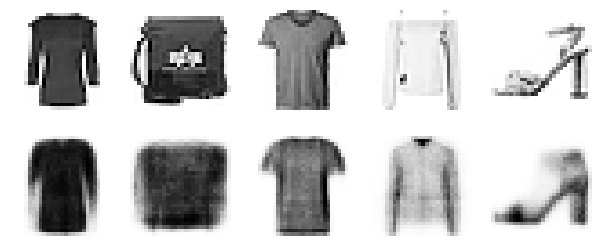

In [43]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [44]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

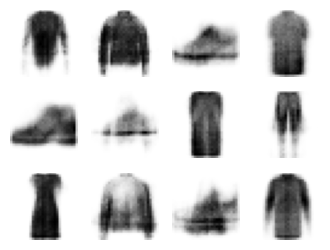

In [45]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

## No Exercise! 

* Instead go through these slides and understand the functionality 
* Also read and look at examples e.g. here https://www.learnopencv.com/understanding-autoencoders-using-tensorflow-python/
    